In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.metrics import roc_curve, auc, precision_recall_curve, roc_auc_score, f1_score
from tqdm import tqdm
import sys
sys.path.extend(["..", "../backbone","../.."])
from backbones import DenseNet201, ResNet152d
from dataloader import create_dataloader
from metric import Metric
from focal import FocalLoss
from ctran_ie import IEeCT
from tabulate import tabulate
torch.cuda.empty_cache()
# from torchsummary import summary

# Set device to GPU if available, else use CPU
device = torch.device("cuda")
print(f"Current device: {torch.cuda.get_device_name(torch.cuda.current_device())}" if torch.cuda.is_available() else "Current device: CPU")

Current device: NVIDIA A100 80GB PCIe


In [2]:
# Define hyperparameters
batch_size = 16
num_epochs = 200
learning_rate = 0.000001
image_size = 384
num_workers = 8
num_labels = 21
num_layers = 12
in_channels = 3
embed_dim = 960
mlp_dim = 1024
thresholds = [0.5] * num_labels
num_classes = 21
data_dir = '../../../data/GT-main'

In [3]:
# Create dataloaders
train_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='train')
val_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='val')
test_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='test')

384
../../../data/GT-main/./set1/train.csv
384
../../../data/GT-main/./set1/val.csv
384
../../../data/GT-main/./set1/test.csv


In [4]:
# Define model and optimizer
backbone1 = DenseNet201(num_classes=num_classes, embed_dim=embed_dim)
backbone2 = ResNet152d(num_classes=num_classes, embed_dim=embed_dim)
model = IEeCT(num_classes=num_classes, in_channels= in_channels, embed_dim=embed_dim, num_layers=num_layers, num_heads=num_workers, 
                      mlp_dim=mlp_dim, backbone1=backbone1, backbone2=backbone2)
model.to(device)
num_params = sum(p.numel() for p in model.parameters())
print(num_params)

# Wrap your model with DataParallel
# model = nn.DataParallel(model, device_ids=[0, 1, 2, 3])
criterion = nn.BCEWithLogitsLoss()
# criterion = FocalLoss(gamma=2, alpha=0.25, reduction='mean')

# Create a single optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-6)

# Create a single scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, epochs= num_epochs, steps_per_epoch=len(train_dataloader))

/home/deependra/project/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/deependra/project/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/deependra/project/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but se

273631861


In [5]:
# Initialize Metric class
metric = Metric(num_classes=num_classes)
thresholds = None

# create empty lists to store predicted probabilities and true labels for each epoch
test_preds_all, test_labels_all = [], []

# define the epochs at which to plot the ROC curve
roc_epochs = [5,10,20,30,40,50,60,70,80,90,100,120,140,160,180,200]

# create empty lists to store ROC data for each epoch
roc_fpr = []
roc_tpr = []
roc_auc = []
f1_arr = []
loss_arr = []
model_arr = []
max_ms = [0,0,0]
a,b = 0.4,0.6

# Train and evaluate model
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print('-' * 10)

    # Train phase
    model.train()
    for images, labels in tqdm(train_dataloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, labels)    
        outputs = torch.sigmoid(outputs)
        
        loss.backward()
        optimizer.step()

        with torch.no_grad(): metric.update(outputs, labels)
    
     # Print metrics on train set
    ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score, acc_list, spec_list, thresh = metric.compute()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
    print(thresh)
    print(f'Accuracy list: {acc_list}')   
    print(f'Specificity list: {spec_list}') 
    # Reset Metric class for evaluation
    metric.reset() 

    # Evaluate model on validation set
    model.eval()
    running_loss = 0.0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(val_dataloader):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            running_loss += criterion(outputs, labels).item()
            outputs = torch.sigmoid(outputs)

            # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
            val_preds += outputs.tolist()
            val_labels += labels.tolist()
            
            # Compute metrics on validation set
            metric.update(outputs, labels)

        # Print metrics on validation set
        ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score,  acc_list, spec_list, thresh = metric.compute()
        print(f"Val - Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
        
        # Reset Metric class for next epoch
        metric.reset()
        del images
        del labels
        del outputs
        torch.cuda.empty_cache()   
    print(thresh)   
    print(f'Accuracy list: {acc_list}')   
    print(f'Specificity list: {spec_list}')
    
     # Evaluate model on test set
    running_loss = 0.0
    test_preds, test_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(test_dataloader):
            images, labels = images.to(device), labels.to(device)
 
            outputs = model(images)

            running_loss += criterion(outputs, labels).item()
            outputs = torch.sigmoid(outputs)
            metric.update(outputs, labels)

            # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
            test_preds += outputs.tolist()
            test_labels += labels.tolist()
 
        # Print metrics on test set
        ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score,  acc_list, spec_list, thresh = metric.compute(thresholds = thresh)
        print(f"Test - Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
        
        f1_arr.append(ml_f1_score)
        model_arr.append(model_score)
        loss_arr.append(running_loss / len(test_dataloader))
        
        if max_ms[0] < model_score: 
            max_ms[0] = model_score
            max_ms[1] = epoch
            max_ms[2] = optimizer.param_groups[0]['lr']
            torch.save(model, 'models/ieect-js.pth')

        # append the predicted probabilities and true labels for this epoch to the lists for all epochs
        test_preds_all.append(test_preds)
        test_labels_all.append(test_labels)

        # check if the current epoch is in the list of epochs to plot ROC curve
        if epoch+1 in roc_epochs:
            # calculate ROC curve and AUC score for test set
            fpr, tpr, roc_thresholds = roc_curve(np.concatenate(test_labels_all).ravel(), np.concatenate(test_preds_all).ravel())
            roc_fpr.append(fpr)
            roc_tpr.append(tpr)
            roc_auc.append(auc(fpr, tpr))
        # Reset Metric class for next epoch
        metric.reset()
        del images
        del labels
        del outputs
        torch.cuda.empty_cache()     
    
    print(thresh)
    print(f'Accuracy list: {acc_list}')   
    print(f'Specificity list: {spec_list}') 
    print()      
    # Step the learning rate scheduler
    scheduler.step()  

Epoch 1/200
----------


100%|██████████| 125/125 [01:15<00:00,  1.66it/s]


Epoch [1/200], Loss: 0.2043, ML mAP: 0.1324, ML F1: 0.7242, ML AUC: 0.6647, ML Score: 0.3985, Bin AUC: 0.3500, Model Score: 0.3743, Bin F1: 1.0000
[0.44 0.6  0.73 0.72 0.45 0.66 0.62 0.7  0.63 0.6  0.6  0.61 0.59 0.51
 0.27 0.66 0.78 0.71 0.49 0.68 0.57]
Accuracy list: [0.7983991995997999, 0.9544772386193097, 0.9104552276138069, 0.8874437218609305, 0.840920460230115, 0.8804402201100551, 0.9149574787393697, 0.9279639819909955, 0.9404702351175588, 0.9249624812406203, 0.951975987993997, 0.928464232116058, 0.9554777388694348, 0.9149574787393697, 0.7663831915957979, 0.9474737368684342, 0.9349674837418709, 0.9404702351175588, 0.9029514757378689, 0.8929464732366184, 0.9479739869934968]
Specificity list: [0.8839233894370284, 0.9932043910088866, 0.99945085118067, 0.9994366197183099, 0.9145251396648044, 0.9994321408290744, 0.9994535519125683, 0.9994612068965517, 0.9994683678894205, 0.9994594594594595, 0.9994747899159664, 0.9994614970382337, 0.9989539748953975, 0.9567510548523207, 0.7994609164420

100%|██████████| 28/28 [00:08<00:00,  3.17it/s]


Val - Epoch [1/200], Loss: 5.3044, ML mAP: 0.2899, ML F1: 0.7984, ML AUC: 0.7941, ML Score: 0.5420, Bin AUC: 1.0000, Model Score: 0.7710, Bin F1: 1.0000
[0.23 0.32 0.33 0.41 0.39 0.59 0.12 0.84 0.13 0.51 0.14 0.35 0.25 0.17
 0.44 0.65 0.56 0.36 0.26 0.23 0.23]
Accuracy list: [0.8405466970387244, 0.8542141230068337, 0.9111617312072893, 0.9020501138952164, 0.908883826879271, 0.9407744874715261, 0.9384965831435079, 0.9567198177676538, 0.9681093394077449, 0.9772209567198178, 0.9772209567198178, 0.979498861047836, 0.9840546697038725, 0.958997722095672, 0.9726651480637813, 0.9817767653758542, 0.9908883826879271, 0.9840546697038725, 0.9772209567198178, 0.8883826879271071, 0.979498861047836]
Specificity list: [0.888268156424581, 0.9204892966360856, 0.9411764705882353, 0.9772727272727273, 0.9339853300733496, 0.9975845410628019, 0.9975786924939467, 0.997624703087886, 0.9976525821596244, 0.9976744186046511, 0.9953596287703016, 0.9976798143851509, 0.9976744186046511, 0.9718969555035128, 0.99766355

100%|██████████| 27/27 [00:06<00:00,  3.87it/s]


Test - Epoch [1/200], Loss: 5.1790, ML mAP: 0.2548, ML F1: 0.5123, ML AUC: 0.8048, ML Score: 0.5298, Bin AUC: 0.9500, Model Score: 0.7399, Bin F1: 0.0000
[0.23 0.32 0.33 0.41 0.39 0.59 0.12 0.84 0.13 0.51 0.14 0.35 0.25 0.17
 0.44 0.65 0.56 0.36 0.26 0.23 0.23]
Accuracy list: [0.8388625592417062, 0.8554502369668247, 0.909952606635071, 0.8791469194312796, 0.8933649289099526, 0.933649289099526, 0.9478672985781991, 0.9597156398104265, 0.9644549763033176, 0.9715639810426541, 0.9691943127962085, 0.976303317535545, 0.976303317535545, 0.9597156398104265, 0.990521327014218, 0.9739336492890995, 0.9881516587677726, 0.9881516587677726, 0.9691943127962085, 0.909952606635071, 0.9644549763033176]
Specificity list: [0.8901734104046243, 0.9123376623376623, 0.9360613810741688, 0.9657894736842105, 0.9090909090909091, 0.9924242424242424, 1.0, 1.0, 0.9975490196078431, 1.0, 0.9831730769230769, 0.9975786924939467, 1.0, 0.9685230024213075, 1.0, 0.9903614457831326, 0.9904534606205251, 0.9976076555023924, 0.99

100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


Epoch [2/200], Loss: 0.2181, ML mAP: 0.4084, ML F1: 0.6350, ML AUC: 0.8526, ML Score: 0.6305, Bin AUC: 0.8500, Model Score: 0.7403, Bin F1: 0.0000
[0.41 0.39 0.29 0.79 0.85 0.39 0.46 0.29 0.46 0.22 0.19 0.29 0.86 0.32
 0.26 0.26 0.29 0.21 0.46 0.25 0.36]
Accuracy list: [0.9104552276138069, 0.9524762381190596, 0.9084542271135568, 0.8899449724862432, 0.9019509754877438, 0.8844422211105553, 0.919959979989995, 0.9294647323661831, 0.9389694847423712, 0.896448224112056, 0.9294647323661831, 0.9324662331165583, 0.9554777388694348, 0.9449724862431216, 0.9464732366183092, 0.943471735867934, 0.9184592296148074, 0.8954477238619309, 0.9524762381190596, 0.8809404702351176, 0.983991995997999]
Specificity list: [0.9666474985623922, 0.9852242744063324, 0.955930359085963, 0.999438202247191, 0.9988919667590028, 0.9477311889718553, 0.9994565217391305, 0.9584457636265515, 0.9994675186368477, 0.9420600858369099, 0.9617021276595744, 0.9462832338578405, 0.9994767137624281, 0.9760255727224294, 0.96592119275825

100%|██████████| 28/28 [00:07<00:00,  3.51it/s]


Val - Epoch [2/200], Loss: 4.7977, ML mAP: 0.3616, ML F1: 0.8049, ML AUC: 0.8685, ML Score: 0.6151, Bin AUC: 1.0000, Model Score: 0.8075, Bin F1: 1.0000
[0.08 0.12 0.18 0.46 0.28 0.46 0.29 0.15 0.41 0.38 0.18 0.66 0.59 0.18
 0.56 0.68 0.46 0.66 0.21 0.52 0.8 ]
Accuracy list: [0.8906605922551253, 0.8405466970387244, 0.9202733485193622, 0.8997722095671982, 0.9271070615034168, 0.9498861047835991, 0.9384965831435079, 0.9658314350797267, 0.9681093394077449, 0.9772209567198178, 0.979498861047836, 0.9931662870159453, 0.9772209567198178, 0.9772209567198178, 0.9749430523917996, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.8883826879271071, 0.9931662870159453]
Specificity list: [0.9217877094972067, 0.9388379204892966, 0.9558823529411765, 0.9974747474747475, 0.9779951100244498, 0.9830917874396136, 0.9975786924939467, 0.9714964370546318, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 1.0, 0.9976744186046511, 0.990632318501171, 0.9906542056074766, 0

100%|██████████| 27/27 [00:07<00:00,  3.67it/s]


Test - Epoch [2/200], Loss: 4.5253, ML mAP: 0.3586, ML F1: 0.4949, ML AUC: 0.8575, ML Score: 0.6081, Bin AUC: 1.0000, Model Score: 0.8040, Bin F1: 1.0000
[0.08 0.12 0.18 0.46 0.28 0.46 0.29 0.15 0.41 0.38 0.18 0.66 0.59 0.18
 0.56 0.68 0.46 0.66 0.21 0.52 0.8 ]
Accuracy list: [0.8886255924170616, 0.8601895734597157, 0.9052132701421801, 0.9028436018957346, 0.933649289099526, 0.9383886255924171, 0.9454976303317536, 0.957345971563981, 0.966824644549763, 0.966824644549763, 0.9881516587677726, 0.9834123222748815, 0.9739336492890995, 0.985781990521327, 0.9691943127962085, 0.9786729857819905, 0.9928909952606635, 0.985781990521327, 0.9715639810426541, 0.9123222748815166, 0.9881516587677726]
Specificity list: [0.9219653179190751, 0.9188311688311688, 0.9514066496163683, 1.0, 0.9823232323232324, 0.9772727272727273, 0.9975, 0.967741935483871, 1.0, 0.9926829268292683, 0.9951923076923077, 1.0, 0.9975609756097561, 0.9927360774818402, 0.9808153477218226, 0.9951807228915662, 0.9976133651551312, 0.99521

100%|██████████| 125/125 [01:09<00:00,  1.81it/s]


Epoch [3/200], Loss: 0.1373, ML mAP: 0.5574, ML F1: 0.6784, ML AUC: 0.9097, ML Score: 0.7336, Bin AUC: 0.3000, Model Score: 0.5168, Bin F1: 0.0000
[0.35 0.32 0.28 0.31 0.37 0.34 0.24 0.35 0.69 0.52 0.35 0.46 0.17 0.3
 0.36 0.91 0.38 0.31 0.17 0.73 0.43]
Accuracy list: [0.9219609804902451, 0.9609804902451226, 0.9164582291145573, 0.897448724362181, 0.9179589794897449, 0.9004502251125562, 0.9219609804902451, 0.9539769884942472, 0.9374687343671836, 0.9394697348674337, 0.9524762381190596, 0.9629814907453726, 0.9364682341170585, 0.9684842421210605, 0.9624812406203102, 0.9479739869934968, 0.9494747373686844, 0.9399699849924963, 0.9249624812406203, 0.9094547273636818, 0.9919959979989995]
Specificity list: [0.9601139601139601, 0.9859007832898172, 0.9514192139737991, 0.9296653431650596, 0.9519821328866555, 0.9367452558941921, 0.9615179048637092, 0.974622030237581, 0.9994666666666666, 0.9994678020223523, 0.9774314884470715, 0.9830878341516639, 0.9570680628272251, 0.9790904338734971, 0.97939778129

100%|██████████| 28/28 [00:07<00:00,  3.68it/s]


Val - Epoch [3/200], Loss: 4.7280, ML mAP: 0.4433, ML F1: 0.8224, ML AUC: 0.8981, ML Score: 0.6707, Bin AUC: 1.0000, Model Score: 0.8354, Bin F1: 1.0000
[0.24 0.07 0.22 0.84 0.72 0.5  0.5  0.75 0.49 0.33 0.79 0.32 0.64 0.96
 0.75 0.76 0.81 0.75 0.46 0.76 0.11]
Accuracy list: [0.9157175398633257, 0.8610478359908884, 0.9476082004555809, 0.8997722095671982, 0.9316628701594533, 0.9476082004555809, 0.9384965831435079, 0.979498861047836, 0.9681093394077449, 0.9772209567198178, 0.9908883826879271, 0.9954441913439636, 0.9772209567198178, 0.9703872437357631, 0.9749430523917996, 0.9817767653758542, 0.9840546697038725, 0.9817767653758542, 0.9772209567198178, 0.8861047835990888, 1.0]
Specificity list: [0.9385474860335196, 0.8868501529051988, 0.9950980392156863, 0.9974747474747475, 0.9633251833740831, 0.9734299516908212, 0.9975786924939467, 0.9928741092636579, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 0.9953596287703016, 0.9976744186046511, 0.9976580796252927, 0.9906542056074766, 

100%|██████████| 27/27 [00:07<00:00,  3.79it/s]


Test - Epoch [3/200], Loss: 4.6207, ML mAP: 0.4548, ML F1: 0.4163, ML AUC: 0.8975, ML Score: 0.6762, Bin AUC: 0.9000, Model Score: 0.7881, Bin F1: 1.0000
[0.24 0.07 0.22 0.84 0.72 0.5  0.5  0.75 0.49 0.33 0.79 0.32 0.64 0.96
 0.75 0.76 0.81 0.75 0.46 0.76 0.11]
Accuracy list: [0.9004739336492891, 0.8649289099526066, 0.9454976303317536, 0.9004739336492891, 0.943127962085308, 0.9383886255924171, 0.9454976303317536, 0.9644549763033176, 0.9691943127962085, 0.9691943127962085, 0.981042654028436, 0.985781990521327, 0.9715639810426541, 0.9834123222748815, 0.976303317535545, 0.985781990521327, 0.9928909952606635, 0.985781990521327, 0.966824644549763, 0.9123222748815166, 0.995260663507109]
Specificity list: [0.930635838150289, 0.8571428571428571, 0.9820971867007673, 1.0, 0.9671717171717171, 0.9873737373737373, 0.9925, 0.9900744416873449, 1.0, 0.9975609756097561, 0.9855769230769231, 0.9975786924939467, 1.0, 1.0, 0.9856115107913669, 1.0, 1.0, 0.9952153110047847, 0.9926829268292683, 0.997395833333

100%|██████████| 125/125 [01:09<00:00,  1.81it/s]


Epoch [4/200], Loss: 0.1368, ML mAP: 0.6932, ML F1: 0.7006, ML AUC: 0.9431, ML Score: 0.8182, Bin AUC: 0.9000, Model Score: 0.8591, Bin F1: 0.0000
[0.4  0.32 0.3  0.32 0.24 0.42 0.26 0.34 0.24 0.28 0.33 0.54 0.36 0.36
 0.34 0.24 0.4  0.28 0.35 0.84 0.34]
Accuracy list: [0.9264632316158079, 0.9649824912456229, 0.9414707353676839, 0.9144572286143071, 0.9169584792396198, 0.9409704852426213, 0.9279639819909955, 0.959479739869935, 0.9344672336168084, 0.912456228114057, 0.9639819909954978, 0.9749874937468734, 0.968984492246123, 0.9724862431215607, 0.9714857428714357, 0.9724862431215607, 0.9739869934967483, 0.9564782391195598, 0.9564782391195598, 0.8994497248624312, 0.9979989994997499]
Specificity list: [0.9637638807714787, 0.9847127042698999, 0.9640522875816994, 0.9456398640996603, 0.9288079470198676, 0.9680729760547321, 0.9545208446128858, 0.9746083198271205, 0.9608998393144081, 0.9614967462039046, 0.9818473037907101, 0.9891891891891892, 0.9900314795383001, 0.9868004223864836, 0.98247477429

100%|██████████| 28/28 [00:07<00:00,  3.66it/s]


Val - Epoch [4/200], Loss: 3.5606, ML mAP: 0.4755, ML F1: 0.7564, ML AUC: 0.9108, ML Score: 0.6932, Bin AUC: 1.0000, Model Score: 0.8466, Bin F1: 1.0000
[0.29 0.21 0.26 0.65 0.29 0.84 0.5  0.36 0.17 0.43 0.18 0.79 0.46 0.48
 0.87 0.19 0.57 0.28 0.31 0.21 0.24]
Accuracy list: [0.929384965831435, 0.8883826879271071, 0.9339407744874715, 0.8997722095671982, 0.9111617312072893, 0.9384965831435079, 0.9384965831435079, 0.9658314350797267, 0.9749430523917996, 0.9772209567198178, 0.9817767653758542, 0.979498861047836, 0.9772209567198178, 0.979498861047836, 0.9840546697038725, 0.9817767653758542, 0.9840546697038725, 0.9817767653758542, 0.9817767653758542, 0.856492027334852, 1.0]
Specificity list: [0.9581005586592178, 0.9327217125382263, 0.9656862745098039, 0.9974747474747475, 0.9388753056234719, 0.9951690821256038, 0.9975786924939467, 0.9691211401425178, 0.9953051643192489, 0.9976744186046511, 0.988399071925754, 0.9976798143851509, 0.9976744186046511, 0.990632318501171, 0.9929906542056075, 0.988

100%|██████████| 27/27 [00:07<00:00,  3.66it/s]


Test - Epoch [4/200], Loss: 3.5012, ML mAP: 0.4852, ML F1: 0.5408, ML AUC: 0.9018, ML Score: 0.6935, Bin AUC: 1.0000, Model Score: 0.8468, Bin F1: 0.6667
[0.29 0.21 0.26 0.65 0.29 0.84 0.5  0.36 0.17 0.43 0.18 0.79 0.46 0.48
 0.87 0.19 0.57 0.28 0.31 0.21 0.24]
Accuracy list: [0.9028436018957346, 0.9004739336492891, 0.9312796208530806, 0.9004739336492891, 0.9218009478672986, 0.9360189573459715, 0.9478672985781991, 0.9502369668246445, 0.9691943127962085, 0.9691943127962085, 0.957345971563981, 0.9834123222748815, 0.9786729857819905, 0.9786729857819905, 0.981042654028436, 0.9786729857819905, 0.990521327014218, 0.9786729857819905, 0.9691943127962085, 0.8625592417061612, 0.9976303317535545]
Specificity list: [0.9508670520231214, 0.9253246753246753, 0.959079283887468, 1.0, 0.946969696969697, 0.9974747474747475, 0.995, 0.9553349875930521, 1.0, 0.9975609756097561, 0.9591346153846154, 1.0, 1.0, 0.9903147699757869, 0.988009592326139, 0.980722891566265, 0.9976133651551312, 0.9880382775119617, 0.9

100%|██████████| 125/125 [01:09<00:00,  1.81it/s]


Epoch [5/200], Loss: 0.1228, ML mAP: 0.7698, ML F1: 0.7223, ML AUC: 0.9596, ML Score: 0.8647, Bin AUC: 1.0000, Model Score: 0.9324, Bin F1: 1.0000
[0.38 0.43 0.29 0.35 0.35 0.45 0.25 0.33 0.29 0.28 0.37 0.43 0.29 0.38
 0.47 0.3  0.32 0.42 0.29 0.19 0.55]
Accuracy list: [0.9379689844922461, 0.9664832416208105, 0.9334667333666833, 0.9169584792396198, 0.9474737368684342, 0.9454727363681841, 0.9349674837418709, 0.9739869934967483, 0.9534767383691846, 0.9354677338669335, 0.9789894947473737, 0.9814907453726863, 0.9754877438719359, 0.9844922461230615, 0.9854927463731866, 0.9739869934967483, 0.9759879939969985, 0.9749874937468734, 0.9674837418709354, 0.8769384692346173, 0.9984992496248124]
Specificity list: [0.9666474985623922, 0.9900471451021478, 0.9603960396039604, 0.9556926528323051, 0.9662797125483693, 0.9730195177956372, 0.960042621204049, 0.9818084537185661, 0.97675647120972, 0.9732334047109208, 0.9893730074388948, 0.9884868421052632, 0.9878883622959452, 0.9931830099632931, 0.99523305084

100%|██████████| 28/28 [00:07<00:00,  3.87it/s]


Val - Epoch [5/200], Loss: 4.1900, ML mAP: 0.5017, ML F1: 0.6515, ML AUC: 0.9227, ML Score: 0.7122, Bin AUC: 1.0000, Model Score: 0.8561, Bin F1: 1.0000
[0.4  0.06 0.53 0.46 0.52 0.23 0.17 0.69 0.37 0.68 0.56 0.17 0.18 0.35
 0.91 0.82 0.81 0.53 0.36 0.4  0.41]
Accuracy list: [0.9248291571753986, 0.8724373576309795, 0.9430523917995444, 0.8701594533029613, 0.9453302961275627, 0.9407744874715261, 0.9202733485193622, 0.9749430523917996, 0.9703872437357631, 0.9772209567198178, 0.9840546697038725, 0.9954441913439636, 0.9658314350797267, 0.979498861047836, 0.9908883826879271, 0.9886104783599089, 0.9840546697038725, 0.9840546697038725, 0.9567198177676538, 0.8792710706150342, 1.0]
Specificity list: [0.9664804469273743, 0.9541284403669725, 0.9730392156862745, 0.8863636363636364, 0.9828850855745721, 0.9516908212560387, 0.9515738498789347, 0.9881235154394299, 0.9859154929577465, 0.9976744186046511, 0.9907192575406032, 0.9953596287703016, 0.9767441860465116, 0.9976580796252927, 1.0, 1.0, 0.99769053

100%|██████████| 27/27 [00:07<00:00,  3.56it/s]


Test - Epoch [5/200], Loss: 4.0859, ML mAP: 0.4846, ML F1: 0.5597, ML AUC: 0.9075, ML Score: 0.6960, Bin AUC: 0.9500, Model Score: 0.8230, Bin F1: 0.6667
[0.4  0.06 0.53 0.46 0.52 0.23 0.17 0.69 0.37 0.68 0.56 0.17 0.18 0.35
 0.91 0.82 0.81 0.53 0.36 0.4  0.41]
Accuracy list: [0.909952606635071, 0.8933649289099526, 0.933649289099526, 0.8909952606635071, 0.9454976303317536, 0.9265402843601895, 0.919431279620853, 0.976303317535545, 0.9691943127962085, 0.9691943127962085, 0.9786729857819905, 0.976303317535545, 0.976303317535545, 0.9786729857819905, 0.985781990521327, 0.9786729857819905, 0.995260663507109, 0.9834123222748815, 0.9478672985781991, 0.8554502369668247, 0.9976303317535545]
Specificity list: [0.9595375722543352, 0.948051948051948, 0.9565217391304348, 0.9078947368421053, 0.9772727272727273, 0.9545454545454546, 0.955, 0.9851116625310173, 0.9901960784313726, 0.9975609756097561, 0.9807692307692307, 0.9878934624697336, 0.9878048780487805, 0.9903147699757869, 0.9928057553956835, 0.992

100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


Epoch [6/200], Loss: 0.0831, ML mAP: 0.8363, ML F1: 0.7740, ML AUC: 0.9707, ML Score: 0.9035, Bin AUC: 1.0000, Model Score: 0.9518, Bin F1: 0.6667
[0.4  0.49 0.41 0.41 0.35 0.42 0.31 0.42 0.33 0.35 0.57 0.63 0.45 0.44
 0.32 0.4  0.5  0.36 0.39 0.32 0.25]
Accuracy list: [0.9514757378689345, 0.9724862431215607, 0.9414707353676839, 0.927463731865933, 0.9424712356178089, 0.9524762381190596, 0.9459729864932466, 0.9769884942471235, 0.9664832416208105, 0.9444722361180591, 0.9844922461230615, 0.9824912456228114, 0.983991995997999, 0.9879939969984992, 0.9769884942471235, 0.983991995997999, 0.983991995997999, 0.9824912456228114, 0.9794897448724362, 0.9264632316158079, 0.9989994997498749]
Specificity list: [0.9731428571428572, 0.9947340705634544, 0.9720700985761227, 0.9616036137775268, 0.9659598214285714, 0.9748427672955975, 0.9695652173913043, 0.9903329752953813, 0.9856687898089171, 0.978401727861771, 0.9973319103521878, 0.9946207638515331, 0.9973544973544973, 0.9957850368809273, 0.9845662586482

100%|██████████| 28/28 [00:08<00:00,  3.31it/s]


Val - Epoch [6/200], Loss: 3.5284, ML mAP: 0.5239, ML F1: 0.7169, ML AUC: 0.9215, ML Score: 0.7227, Bin AUC: 1.0000, Model Score: 0.8614, Bin F1: 1.0000
[0.18 0.1  0.36 0.37 0.43 0.41 0.63 0.7  0.29 0.55 0.4  0.23 0.4  0.1
 0.75 0.55 0.73 0.74 0.77 0.3  0.2 ]
Accuracy list: [0.9225512528473804, 0.8861047835990888, 0.9384965831435079, 0.9179954441913439, 0.929384965831435, 0.9567198177676538, 0.9384965831435079, 0.9772209567198178, 0.9749430523917996, 0.9817767653758542, 0.9863325740318907, 0.9977220956719818, 0.9749430523917996, 0.9658314350797267, 0.9908883826879271, 0.9840546697038725, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.8792710706150342, 0.9977220956719818]
Specificity list: [0.9608938547486033, 0.8960244648318043, 0.9681372549019608, 0.946969696969697, 0.9975550122249389, 0.9806763285024155, 0.9975786924939467, 0.9857482185273159, 0.9953051643192489, 0.9953488372093023, 0.9953596287703016, 0.9976798143851509, 0.986046511627907, 0.9765807962529274, 1.0, 0.9

100%|██████████| 27/27 [00:07<00:00,  3.66it/s]


Test - Epoch [6/200], Loss: 3.4552, ML mAP: 0.5211, ML F1: 0.5761, ML AUC: 0.9041, ML Score: 0.7126, Bin AUC: 1.0000, Model Score: 0.8563, Bin F1: 0.6667
[0.18 0.1  0.36 0.37 0.43 0.41 0.63 0.7  0.29 0.55 0.4  0.23 0.4  0.1
 0.75 0.55 0.73 0.74 0.77 0.3  0.2 ]
Accuracy list: [0.8815165876777251, 0.8838862559241706, 0.9383886255924171, 0.9123222748815166, 0.9502369668246445, 0.9383886255924171, 0.9383886255924171, 0.9739336492890995, 0.966824644549763, 0.9715639810426541, 0.985781990521327, 0.9834123222748815, 0.9834123222748815, 0.9739336492890995, 0.9881516587677726, 0.9881516587677726, 0.9928909952606635, 0.9881516587677726, 0.976303317535545, 0.8744075829383886, 0.995260663507109]
Specificity list: [0.9335260115606936, 0.8961038961038961, 0.9744245524296675, 0.9552631578947368, 0.9974747474747475, 0.9772727272727273, 0.99, 0.9875930521091811, 0.9926470588235294, 0.9951219512195122, 0.9855769230769231, 0.9951573849878934, 0.9951219512195122, 0.9806295399515739, 0.9952038369304557, 0.

100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


Epoch [7/200], Loss: 0.0750, ML mAP: 0.8802, ML F1: 0.8262, ML AUC: 0.9791, ML Score: 0.9296, Bin AUC: 1.0000, Model Score: 0.9648, Bin F1: 0.8000
[0.46 0.35 0.22 0.31 0.37 0.41 0.32 0.44 0.34 0.29 0.43 0.44 0.42 0.27
 0.5  0.43 0.41 0.5  0.48 0.33 0.44]
Accuracy list: [0.9639819909954978, 0.9729864932466233, 0.9444722361180591, 0.9379689844922461, 0.9579789894947474, 0.9619809904952477, 0.9534767383691846, 0.9809904952476238, 0.9744872436218109, 0.961480740370185, 0.9889944972486243, 0.9869934967483742, 0.9869934967483742, 0.9904952476238119, 0.9879939969984992, 0.9919959979989995, 0.9869934967483742, 0.9879939969984992, 0.9819909954977488, 0.9319659829914958, 0.9989994997498749]
Specificity list: [0.9867816091954023, 0.9920466595970308, 0.9519178822258239, 0.9546979865771812, 0.974585635359116, 0.977599080987938, 0.9669734704926909, 0.9919484702093397, 0.9871451526513123, 0.9780278670953912, 0.9936068193926478, 0.9929767693138843, 0.9952953476215368, 0.9936675461741424, 0.99470619375

100%|██████████| 28/28 [00:09<00:00,  3.10it/s]


Val - Epoch [7/200], Loss: 3.6736, ML mAP: 0.5108, ML F1: 0.6948, ML AUC: 0.9131, ML Score: 0.7120, Bin AUC: 1.0000, Model Score: 0.8560, Bin F1: 1.0000
[0.1  0.06 0.17 0.32 0.26 0.37 0.73 0.6  0.45 0.65 0.43 0.3  0.15 0.19
 0.68 0.31 0.85 0.79 0.51 0.24 0.14]
Accuracy list: [0.9248291571753986, 0.9111617312072893, 0.9225512528473804, 0.929384965831435, 0.9521640091116174, 0.958997722095672, 0.9384965831435079, 0.979498861047836, 0.9726651480637813, 0.9772209567198178, 0.9908883826879271, 0.9931662870159453, 0.9521640091116174, 0.9772209567198178, 0.9886104783599089, 0.9886104783599089, 0.9840546697038725, 0.9840546697038725, 0.9840546697038725, 0.8838268792710706, 0.9977220956719818]
Specificity list: [0.9608938547486033, 0.9480122324159022, 0.9607843137254902, 0.9722222222222222, 0.9706601466992665, 0.9855072463768116, 0.9975786924939467, 0.995249406175772, 0.9953051643192489, 0.9976744186046511, 0.9976798143851509, 0.9953596287703016, 0.958139534883721, 0.9882903981264637, 1.0, 1.0,

100%|██████████| 27/27 [00:07<00:00,  3.70it/s]


Test - Epoch [7/200], Loss: 3.6344, ML mAP: 0.5299, ML F1: 0.5081, ML AUC: 0.8997, ML Score: 0.7148, Bin AUC: 1.0000, Model Score: 0.8574, Bin F1: 1.0000
[0.1  0.06 0.17 0.32 0.26 0.37 0.73 0.6  0.45 0.65 0.43 0.3  0.15 0.19
 0.68 0.31 0.85 0.79 0.51 0.24 0.14]
Accuracy list: [0.8957345971563981, 0.9123222748815166, 0.9004739336492891, 0.9146919431279621, 0.9265402843601895, 0.95260663507109, 0.9478672985781991, 0.9715639810426541, 0.9739336492890995, 0.966824644549763, 0.990521327014218, 0.9834123222748815, 0.9289099526066351, 0.976303317535545, 0.9928909952606635, 0.995260663507109, 0.9928909952606635, 0.9834123222748815, 0.9644549763033176, 0.8412322274881516, 0.995260663507109]
Specificity list: [0.9421965317919075, 0.9448051948051948, 0.9386189258312021, 0.9631578947368421, 0.9419191919191919, 0.98989898989899, 0.9975, 0.9900744416873449, 1.0, 0.9926829268292683, 0.9903846153846154, 0.9951573849878934, 0.9414634146341463, 0.9854721549636803, 1.0, 1.0, 1.0, 0.992822966507177, 0.987

100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


Epoch [8/200], Loss: 0.0658, ML mAP: 0.8946, ML F1: 0.8345, ML AUC: 0.9814, ML Score: 0.9380, Bin AUC: 0.9000, Model Score: 0.9190, Bin F1: 0.0000
[0.49 0.59 0.29 0.41 0.39 0.4  0.28 0.37 0.28 0.33 0.36 0.28 0.39 0.53
 0.37 0.47 0.61 0.46 0.47 0.34 0.2 ]
Accuracy list: [0.9604802401200601, 0.9739869934967483, 0.951975987993997, 0.9414707353676839, 0.9654827413706853, 0.9609804902451226, 0.9644822411205602, 0.9804902451225613, 0.9729864932466233, 0.9629814907453726, 0.9904952476238119, 0.9899949974987494, 0.9894947473736868, 0.9919959979989995, 0.9899949974987494, 0.9909954977488744, 0.991495747873937, 0.9909954977488744, 0.9819909954977488, 0.9294647323661831, 0.9994997498749375]
Specificity list: [0.9861910241657077, 0.9957894736842106, 0.9719317556411667, 0.9695945945945946, 0.9783573806881243, 0.9753581661891118, 0.9799891833423472, 0.9897186147186147, 0.9813233724653149, 0.9818569903948773, 0.9941458222458754, 0.9918918918918919, 0.9968371112282551, 0.996262680192205, 0.99416445623

100%|██████████| 28/28 [00:08<00:00,  3.23it/s]


Val - Epoch [8/200], Loss: 3.3201, ML mAP: 0.5394, ML F1: 0.7123, ML AUC: 0.9313, ML Score: 0.7353, Bin AUC: 1.0000, Model Score: 0.8677, Bin F1: 1.0000
[0.19 0.08 0.35 0.2  0.21 0.19 0.73 0.77 0.65 0.5  0.47 0.2  0.26 0.1
 0.35 0.13 0.81 0.82 0.3  0.32 0.28]
Accuracy list: [0.9339407744874715, 0.9043280182232346, 0.9362186788154897, 0.9179954441913439, 0.9453302961275627, 0.9476082004555809, 0.9384965831435079, 0.9817767653758542, 0.9772209567198178, 0.9772209567198178, 0.9908883826879271, 0.9954441913439636, 0.9749430523917996, 0.9749430523917996, 0.9886104783599089, 0.9726651480637813, 0.9840546697038725, 0.9840546697038725, 0.9840546697038725, 0.9157175398633257, 1.0]
Specificity list: [0.9581005586592178, 0.9602446483180428, 0.9656862745098039, 0.9368686868686869, 0.9559902200488998, 0.9637681159420289, 0.9975786924939467, 0.9928741092636579, 1.0, 0.9976744186046511, 1.0, 0.9976798143851509, 0.9837209302325581, 0.990632318501171, 0.9953271028037384, 0.9768518518518519, 0.997690531

100%|██████████| 27/27 [00:07<00:00,  3.74it/s]


Test - Epoch [8/200], Loss: 3.3617, ML mAP: 0.5510, ML F1: 0.5310, ML AUC: 0.9103, ML Score: 0.7306, Bin AUC: 1.0000, Model Score: 0.8653, Bin F1: 1.0000
[0.19 0.08 0.35 0.2  0.21 0.19 0.73 0.77 0.65 0.5  0.47 0.2  0.26 0.1
 0.35 0.13 0.81 0.82 0.3  0.32 0.28]
Accuracy list: [0.9241706161137441, 0.9170616113744076, 0.9312796208530806, 0.909952606635071, 0.9146919431279621, 0.9383886255924171, 0.9502369668246445, 0.9834123222748815, 0.9691943127962085, 0.9644549763033176, 0.985781990521327, 0.985781990521327, 0.9691943127962085, 0.9715639810426541, 0.981042654028436, 0.976303317535545, 0.995260663507109, 0.9834123222748815, 0.966824644549763, 0.8886255924170616, 0.9976303317535545]
Specificity list: [0.9624277456647399, 0.961038961038961, 0.959079283887468, 0.9447368421052632, 0.9292929292929293, 0.9621212121212122, 0.9975, 0.9950372208436724, 1.0, 0.9902439024390244, 0.9903846153846154, 0.9975786924939467, 0.9804878048780488, 0.9806295399515739, 0.9856115107913669, 0.9783132530120482, 

100%|██████████| 125/125 [01:07<00:00,  1.84it/s]


Epoch [9/200], Loss: 0.0541, ML mAP: 0.9260, ML F1: 0.8700, ML AUC: 0.9869, ML Score: 0.9565, Bin AUC: 0.9500, Model Score: 0.9532, Bin F1: 0.0000
[0.44 0.34 0.37 0.41 0.49 0.41 0.36 0.37 0.34 0.36 0.33 0.55 0.42 0.31
 0.59 0.4  0.55 0.66 0.47 0.37 0.24]
Accuracy list: [0.9654827413706853, 0.9729864932466233, 0.9599799899949975, 0.9584792396198099, 0.9744872436218109, 0.9719859929964982, 0.9649824912456229, 0.9834917458729364, 0.9789894947473737, 0.9724862431215607, 0.9939969984992496, 0.9934967483741871, 0.992496248124062, 0.992496248124062, 0.9904952476238119, 0.992496248124062, 0.9949974987493747, 0.9949974987493747, 0.9939969984992496, 0.9309654827413707, 0.9984992496248124]
Specificity list: [0.9850746268656716, 0.9862142099681867, 0.9754098360655737, 0.9786516853932584, 0.9860646599777034, 0.9835972850678733, 0.9789983844911146, 0.9898450026723677, 0.9898720682302772, 0.9892125134843581, 0.995764955002647, 0.9973074851911685, 0.9984243697478992, 0.9941520467836257, 0.998383620689

100%|██████████| 28/28 [00:08<00:00,  3.42it/s]


Val - Epoch [9/200], Loss: 3.5409, ML mAP: 0.5163, ML F1: 0.7034, ML AUC: 0.9212, ML Score: 0.7187, Bin AUC: 1.0000, Model Score: 0.8594, Bin F1: 1.0000
[0.15 0.05 0.16 0.23 0.22 0.36 0.65 0.77 0.67 0.48 0.46 0.25 0.24 0.1
 0.5  0.15 0.84 0.84 0.33 0.33 0.42]
Accuracy list: [0.9316628701594533, 0.9066059225512528, 0.9202733485193622, 0.9134396355353075, 0.9521640091116174, 0.958997722095672, 0.9384965831435079, 0.9817767653758542, 0.9772209567198178, 0.9772209567198178, 0.9886104783599089, 0.9931662870159453, 0.9726651480637813, 0.9726651480637813, 0.9886104783599089, 0.9681093394077449, 0.9840546697038725, 0.9840546697038725, 0.9840546697038725, 0.9111617312072893, 1.0]
Specificity list: [0.9664804469273743, 0.9480122324159022, 0.9387254901960784, 0.9368686868686869, 0.9755501222493888, 0.9806763285024155, 0.9975786924939467, 0.995249406175772, 1.0, 0.9976744186046511, 0.9953596287703016, 0.9953596287703016, 0.9790697674418605, 0.9859484777517564, 0.9976635514018691, 0.969907407407407

100%|██████████| 27/27 [00:07<00:00,  3.79it/s]


Test - Epoch [9/200], Loss: 3.5047, ML mAP: 0.5309, ML F1: 0.5509, ML AUC: 0.9063, ML Score: 0.7186, Bin AUC: 1.0000, Model Score: 0.8593, Bin F1: 0.6667
[0.15 0.05 0.16 0.23 0.22 0.36 0.65 0.77 0.67 0.48 0.46 0.25 0.24 0.1
 0.5  0.15 0.84 0.84 0.33 0.33 0.42]
Accuracy list: [0.9170616113744076, 0.9218009478672986, 0.9052132701421801, 0.9028436018957346, 0.9478672985781991, 0.9407582938388626, 0.9502369668246445, 0.9834123222748815, 0.9691943127962085, 0.966824644549763, 0.990521327014218, 0.985781990521327, 0.9597156398104265, 0.9715639810426541, 0.990521327014218, 0.9739336492890995, 0.9976303317535545, 0.9834123222748815, 0.9620853080568721, 0.8981042654028436, 0.9976303317535545]
Specificity list: [0.9624277456647399, 0.9512987012987013, 0.928388746803069, 0.9315789473684211, 0.9747474747474747, 0.9823232323232324, 0.9975, 0.9950372208436724, 1.0, 0.9926829268292683, 0.9903846153846154, 0.9951573849878934, 0.9707317073170731, 0.9806295399515739, 0.9952038369304557, 0.97349397590361

100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


Epoch [10/200], Loss: 0.0661, ML mAP: 0.9315, ML F1: 0.8754, ML AUC: 0.9887, ML Score: 0.9601, Bin AUC: 1.0000, Model Score: 0.9801, Bin F1: 1.0000
[0.38 0.52 0.32 0.33 0.43 0.51 0.35 0.27 0.38 0.4  0.55 0.39 0.39 0.57
 0.47 0.54 0.42 0.42 0.37 0.35 0.29]
Accuracy list: [0.9589794897448725, 0.9799899949974987, 0.9559779889944973, 0.950975487743872, 0.967983991995998, 0.9739869934967483, 0.961480740370185, 0.9829914957478739, 0.984992496248124, 0.9759879939969985, 0.9929964982491246, 0.9889944972486243, 0.9919959979989995, 0.9949974987493747, 0.9909954977488744, 0.9929964982491246, 0.9969984992496248, 0.9959979989994997, 0.992496248124062, 0.950975487743872, 1.0]
Specificity list: [0.9767576990122022, 0.9973739495798319, 0.9762693156732892, 0.9674340258281864, 0.9795353982300885, 0.9920045688178184, 0.9813902572523262, 0.9880108991825614, 0.99145755472504, 0.9925133689839573, 0.9978689397975493, 0.9929881337648327, 0.9984260230849947, 0.9968619246861925, 0.9951690821256038, 0.9979101358

100%|██████████| 28/28 [00:08<00:00,  3.30it/s]


Val - Epoch [10/200], Loss: 3.5988, ML mAP: 0.5204, ML F1: 0.7278, ML AUC: 0.9242, ML Score: 0.7223, Bin AUC: 1.0000, Model Score: 0.8612, Bin F1: 1.0000
[0.13 0.05 0.15 0.23 0.2  0.3  0.58 0.76 0.68 0.51 0.47 0.54 0.19 0.26
 0.57 0.42 0.81 0.79 0.36 0.18 0.13]
Accuracy list: [0.9316628701594533, 0.9157175398633257, 0.9248291571753986, 0.908883826879271, 0.9544419134396356, 0.958997722095672, 0.9384965831435079, 0.9817767653758542, 0.9772209567198178, 0.9772209567198178, 0.9908883826879271, 0.9954441913439636, 0.9726651480637813, 0.9703872437357631, 0.9886104783599089, 0.9886104783599089, 0.9840546697038725, 0.9840546697038725, 0.9840546697038725, 0.876993166287016, 0.9977220956719818]
Specificity list: [0.9748603351955307, 0.9663608562691132, 0.946078431372549, 0.9267676767676768, 0.9779951100244498, 0.9806763285024155, 0.9975786924939467, 0.995249406175772, 1.0, 0.9976744186046511, 0.9976798143851509, 1.0, 0.9813953488372092, 0.9976580796252927, 1.0, 1.0, 0.9976905311778291, 0.997690

100%|██████████| 27/27 [00:07<00:00,  3.43it/s]


Test - Epoch [10/200], Loss: 3.5259, ML mAP: 0.5359, ML F1: 0.5527, ML AUC: 0.9073, ML Score: 0.7216, Bin AUC: 1.0000, Model Score: 0.8608, Bin F1: 1.0000
[0.13 0.05 0.15 0.23 0.2  0.3  0.58 0.76 0.68 0.51 0.47 0.54 0.19 0.26
 0.57 0.42 0.81 0.79 0.36 0.18 0.13]
Accuracy list: [0.9265402843601895, 0.9123222748815166, 0.909952606635071, 0.9052132701421801, 0.9454976303317536, 0.9407582938388626, 0.9502369668246445, 0.9834123222748815, 0.9691943127962085, 0.966824644549763, 0.990521327014218, 0.985781990521327, 0.957345971563981, 0.985781990521327, 0.995260663507109, 0.985781990521327, 0.9976303317535545, 0.9834123222748815, 0.9644549763033176, 0.8483412322274881, 0.995260663507109]
Specificity list: [0.9739884393063584, 0.9577922077922078, 0.9335038363171355, 0.9342105263157895, 0.9696969696969697, 0.9797979797979798, 0.9975, 0.9950372208436724, 1.0, 0.9926829268292683, 0.9903846153846154, 0.9975786924939467, 0.9682926829268292, 1.0, 1.0, 0.9975903614457832, 1.0, 0.992822966507177, 0.98

100%|██████████| 125/125 [01:09<00:00,  1.79it/s]


Epoch [11/200], Loss: 0.0675, ML mAP: 0.8829, ML F1: 0.8217, ML AUC: 0.9803, ML Score: 0.9316, Bin AUC: 1.0000, Model Score: 0.9658, Bin F1: 1.0000
[0.56 0.34 0.32 0.45 0.33 0.42 0.38 0.51 0.46 0.42 0.24 0.5  0.27 0.58
 0.42 0.33 0.39 0.41 0.42 0.37 0.37]
Accuracy list: [0.9584792396198099, 0.9634817408704353, 0.9544772386193097, 0.943471735867934, 0.9629814907453726, 0.9684842421210605, 0.9559779889944973, 0.9769884942471235, 0.9784892446223111, 0.9684842421210605, 0.9864932466233116, 0.9864932466233116, 0.9874937468734367, 0.9899949974987494, 0.9844922461230615, 0.983991995997999, 0.9879939969984992, 0.9864932466233116, 0.9814907453726863, 0.9309654827413707, 0.9979989994997499]
Specificity list: [0.9902298850574712, 0.982010582010582, 0.96875, 0.9746049661399548, 0.9745575221238938, 0.9796610169491525, 0.9787117903930131, 0.9892761394101877, 0.9925808161102279, 0.9892933618843683, 0.9883165161975571, 0.9940152339499456, 0.9915299100052938, 0.9973614775725593, 0.9925531914893617, 0.9

100%|██████████| 28/28 [00:08<00:00,  3.37it/s]


Val - Epoch [11/200], Loss: 3.4888, ML mAP: 0.5377, ML F1: 0.6320, ML AUC: 0.9123, ML Score: 0.7250, Bin AUC: 1.0000, Model Score: 0.8625, Bin F1: 1.0000
[0.31 0.24 0.2  0.27 0.11 0.27 0.19 0.47 0.3  0.4  0.54 0.84 0.86 0.47
 0.8  0.48 0.62 0.24 0.68 0.53 0.22]
Accuracy list: [0.929384965831435, 0.8929384965831435, 0.9043280182232346, 0.9316628701594533, 0.9339407744874715, 0.9521640091116174, 0.9248291571753986, 0.9772209567198178, 0.9726651480637813, 0.9544419134396356, 0.9886104783599089, 0.9931662870159453, 0.9886104783599089, 0.9840546697038725, 0.9840546697038725, 0.9817767653758542, 0.9840546697038725, 0.9544419134396356, 0.9840546697038725, 0.8906605922551253, 1.0]
Specificity list: [0.9664804469273743, 0.9510703363914373, 0.9240196078431373, 0.9595959595959596, 0.960880195599022, 0.9806763285024155, 0.9515738498789347, 0.9857482185273159, 0.9906103286384976, 0.9674418604651163, 0.9953596287703016, 1.0, 1.0, 0.990632318501171, 1.0, 0.9976851851851852, 0.9976905311778291, 0.9561

100%|██████████| 27/27 [00:07<00:00,  3.84it/s]


Test - Epoch [11/200], Loss: 3.5107, ML mAP: 0.5108, ML F1: 0.4738, ML AUC: 0.9010, ML Score: 0.7059, Bin AUC: 1.0000, Model Score: 0.8530, Bin F1: 1.0000
[0.31 0.24 0.2  0.27 0.11 0.27 0.19 0.47 0.3  0.4  0.54 0.84 0.86 0.47
 0.8  0.48 0.62 0.24 0.68 0.53 0.22]
Accuracy list: [0.919431279620853, 0.9123222748815166, 0.8909952606635071, 0.9052132701421801, 0.933649289099526, 0.9360189573459715, 0.9312796208530806, 0.966824644549763, 0.9739336492890995, 0.95260663507109, 0.9881516587677726, 0.985781990521327, 0.9834123222748815, 0.9739336492890995, 0.9834123222748815, 0.9786729857819905, 0.990521327014218, 0.9407582938388626, 0.9597156398104265, 0.8909952606635071, 0.9976303317535545]
Specificity list: [0.9682080924855492, 0.9707792207792207, 0.9258312020460358, 0.9447368421052632, 0.952020202020202, 0.9747474747474747, 0.9575, 0.9801488833746899, 0.9950980392156863, 0.9780487804878049, 0.9903846153846154, 0.9975786924939467, 1.0, 0.9806295399515739, 0.9904076738609112, 0.992771084337349

100%|██████████| 125/125 [01:09<00:00,  1.81it/s]


Epoch [12/200], Loss: 0.0501, ML mAP: 0.8813, ML F1: 0.8195, ML AUC: 0.9816, ML Score: 0.9314, Bin AUC: 0.8947, Model Score: 0.9131, Bin F1: 0.6667
[0.4  0.43 0.24 0.39 0.42 0.5  0.36 0.51 0.37 0.3  0.43 0.57 0.42 0.52
 0.45 0.39 0.32 0.44 0.47 0.35 0.37]
Accuracy list: [0.9564782391195598, 0.967983991995998, 0.9494747373686844, 0.9429714857428715, 0.9624812406203102, 0.9634817408704353, 0.951975987993997, 0.9799899949974987, 0.9724862431215607, 0.9604802401200601, 0.9864932466233116, 0.9859929964982491, 0.9884942471235618, 0.9919959979989995, 0.9829914957478739, 0.9864932466233116, 0.9889944972486243, 0.992496248124062, 0.9879939969984992, 0.9364682341170585, 0.9989994997498749]
Specificity list: [0.9765177548682703, 0.987220447284345, 0.9638619201725998, 0.9673130193905817, 0.9800443458980045, 0.985134362492853, 0.9761646803900325, 0.9930182599355531, 0.9882978723404255, 0.9731327243417518, 0.9915745129015271, 0.9945652173913043, 0.9958071278825996, 0.9984243697478992, 0.993121693121

100%|██████████| 28/28 [00:08<00:00,  3.42it/s]


Val - Epoch [12/200], Loss: 4.2638, ML mAP: 0.5408, ML F1: 0.6882, ML AUC: 0.9205, ML Score: 0.7307, Bin AUC: 0.9500, Model Score: 0.8403, Bin F1: 1.0000
[0.07 0.03 0.09 0.98 0.25 0.95 0.18 0.58 0.75 0.8  0.46 0.83 0.26 0.95
 0.57 0.38 0.99 0.12 0.47 0.33 0.07]
Accuracy list: [0.929384965831435, 0.8929384965831435, 0.9407744874715261, 0.8997722095671982, 0.929384965831435, 0.9658314350797267, 0.9020501138952164, 0.979498861047836, 0.9658314350797267, 0.9658314350797267, 0.9863325740318907, 0.9954441913439636, 0.9886104783599089, 0.9703872437357631, 0.9863325740318907, 0.9681093394077449, 0.9817767653758542, 0.9612756264236902, 0.9772209567198178, 0.908883826879271, 1.0]
Specificity list: [0.9636871508379888, 0.8990825688073395, 0.9754901960784313, 0.9974747474747475, 0.9486552567237164, 0.9879227053140096, 0.9176755447941889, 0.9904988123515439, 0.9953051643192489, 0.9767441860465116, 0.9930394431554525, 0.9953596287703016, 1.0, 0.9976580796252927, 0.9976635514018691, 0.969907407407407

100%|██████████| 27/27 [00:07<00:00,  3.52it/s]


Test - Epoch [12/200], Loss: 4.3251, ML mAP: 0.5482, ML F1: 0.4729, ML AUC: 0.9116, ML Score: 0.7299, Bin AUC: 0.9500, Model Score: 0.8400, Bin F1: 0.6667
[0.07 0.03 0.09 0.98 0.25 0.95 0.18 0.58 0.75 0.8  0.46 0.83 0.26 0.95
 0.57 0.38 0.99 0.12 0.47 0.33 0.07]
Accuracy list: [0.919431279620853, 0.8578199052132701, 0.9218009478672986, 0.9075829383886256, 0.9289099526066351, 0.9502369668246445, 0.8791469194312796, 0.9620853080568721, 0.9739336492890995, 0.957345971563981, 0.9881516587677726, 0.981042654028436, 0.9786729857819905, 0.9786729857819905, 0.990521327014218, 0.9739336492890995, 0.995260663507109, 0.95260663507109, 0.9691943127962085, 0.8767772511848341, 0.995260663507109]
Specificity list: [0.9595375722543352, 0.8766233766233766, 0.9667519181585678, 1.0, 0.9444444444444444, 0.98989898989899, 0.8925, 0.9727047146401985, 1.0, 0.9804878048780488, 0.9879807692307693, 0.9903147699757869, 0.9951219512195122, 0.9975786924939467, 0.9952038369304557, 0.9734939759036144, 1.0, 0.9593301

100%|██████████| 125/125 [01:10<00:00,  1.76it/s]


Epoch [13/200], Loss: 0.0694, ML mAP: 0.9218, ML F1: 0.8583, ML AUC: 0.9863, ML Score: 0.9541, Bin AUC: 1.0000, Model Score: 0.9770, Bin F1: 1.0000
[0.45 0.44 0.57 0.38 0.32 0.41 0.38 0.53 0.36 0.4  0.39 0.51 0.34 0.54
 0.49 0.33 0.42 0.52 0.43 0.36 0.24]
Accuracy list: [0.9609804902451226, 0.9684842421210605, 0.9704852426213106, 0.9564782391195598, 0.9659829914957478, 0.9674837418709354, 0.9584792396198099, 0.9804902451225613, 0.9809904952476238, 0.9714857428714357, 0.991495747873937, 0.9879939969984992, 0.991495747873937, 0.9939969984992496, 0.991495747873937, 0.9894947473736868, 0.9929964982491246, 0.9889944972486243, 0.9884942471235618, 0.9389694847423712, 0.9994997498749375]
Specificity list: [0.9852020489470689, 0.991005291005291, 0.9928137092316197, 0.9760579064587973, 0.9784649364991718, 0.9816408491107286, 0.9753018660812294, 0.9918743228602384, 0.989247311827957, 0.9859611231101512, 0.9952178533475027, 0.994028230184582, 0.9947753396029259, 0.9989468141126909, 0.9957469431153

100%|██████████| 28/28 [00:07<00:00,  3.54it/s]


Val - Epoch [13/200], Loss: 4.1047, ML mAP: 0.5458, ML F1: 0.6780, ML AUC: 0.9125, ML Score: 0.7291, Bin AUC: 0.9500, Model Score: 0.8396, Bin F1: 1.0000
[0.48 0.01 0.2  0.2  0.59 0.44 0.12 0.3  0.16 0.39 0.32 0.29 0.65 0.7
 0.87 0.23 0.69 0.29 0.68 0.67 0.38]
Accuracy list: [0.9225512528473804, 0.9020501138952164, 0.929384965831435, 0.9362186788154897, 0.9384965831435079, 0.9635535307517085, 0.9020501138952164, 0.9817767653758542, 0.979498861047836, 0.9703872437357631, 0.9840546697038725, 0.9931662870159453, 0.9886104783599089, 0.9703872437357631, 0.9886104783599089, 0.9886104783599089, 0.9840546697038725, 0.9886104783599089, 0.9772209567198178, 0.8747152619589977, 1.0]
Specificity list: [0.9888268156424581, 0.9357798165137615, 0.9485294117647058, 0.9696969696969697, 0.9682151589242054, 0.9855072463768116, 0.9176755447941889, 0.9904988123515439, 0.9906103286384976, 0.9837209302325581, 0.988399071925754, 0.9930394431554525, 1.0, 0.9976580796252927, 1.0, 0.9953703703703703, 0.9976905311

100%|██████████| 27/27 [00:06<00:00,  4.07it/s]


Test - Epoch [13/200], Loss: 4.1158, ML mAP: 0.5319, ML F1: 0.5346, ML AUC: 0.9049, ML Score: 0.7184, Bin AUC: 0.7500, Model Score: 0.7342, Bin F1: 1.0000
[0.48 0.01 0.2  0.2  0.59 0.44 0.12 0.3  0.16 0.39 0.32 0.29 0.65 0.7
 0.87 0.23 0.69 0.29 0.68 0.67 0.38]
Accuracy list: [0.919431279620853, 0.8909952606635071, 0.9289099526066351, 0.9170616113744076, 0.9123222748815166, 0.9454976303317536, 0.8838862559241706, 0.976303317535545, 0.9739336492890995, 0.9549763033175356, 0.9834123222748815, 0.985781990521327, 0.9881516587677726, 0.981042654028436, 0.9881516587677726, 0.9881516587677726, 0.9928909952606635, 0.9834123222748815, 0.9739336492890995, 0.8791469194312796, 0.9976303317535545]
Specificity list: [0.9884393063583815, 0.9155844155844156, 0.9514066496163683, 0.9578947368421052, 0.9393939393939394, 0.9823232323232324, 0.9075, 0.9826302729528535, 0.9926470588235294, 0.9804878048780488, 0.9831730769230769, 0.9975786924939467, 1.0, 0.9975786924939467, 0.9976019184652278, 0.995180722891

100%|██████████| 125/125 [01:11<00:00,  1.74it/s]


Epoch [14/200], Loss: 0.0413, ML mAP: 0.9413, ML F1: 0.8820, ML AUC: 0.9899, ML Score: 0.9656, Bin AUC: 1.0000, Model Score: 0.9828, Bin F1: 1.0000
[0.42 0.39 0.35 0.45 0.41 0.44 0.49 0.48 0.49 0.47 0.6  0.61 0.53 0.52
 0.47 0.59 0.39 0.45 0.56 0.38 0.36]
Accuracy list: [0.9624812406203102, 0.9804902451225613, 0.9729864932466233, 0.9604802401200601, 0.968984492246123, 0.9774887443721861, 0.9674837418709354, 0.9844922461230615, 0.9859929964982491, 0.9789894947473737, 0.9959979989994997, 0.9934967483741871, 0.9894947473736868, 0.9944972486243121, 0.9929964982491246, 0.9939969984992496, 0.9944972486243121, 0.9909954977488744, 0.9894947473736868, 0.9409704852426213, 0.9994997498749375]
Specificity list: [0.9815135759676488, 0.9937139863803038, 0.9831246597713663, 0.9792017987633502, 0.9817275747508306, 0.9868721461187214, 0.989100817438692, 0.9945887445887446, 0.9952406134320465, 0.992942453854506, 0.9989440337909187, 0.9983757444504602, 0.9968387776606955, 0.9984135378106822, 0.9967741935

100%|██████████| 28/28 [00:08<00:00,  3.21it/s]


Val - Epoch [14/200], Loss: 3.8155, ML mAP: 0.5390, ML F1: 0.7077, ML AUC: 0.9099, ML Score: 0.7245, Bin AUC: 1.0000, Model Score: 0.8622, Bin F1: 1.0000
[0.26 0.12 0.23 0.71 0.02 0.2  0.05 0.48 0.25 0.66 0.3  0.56 0.2  0.96
 0.67 0.2  0.99 0.29 0.95 0.2  0.16]
Accuracy list: [0.929384965831435, 0.8815489749430524, 0.9362186788154897, 0.9407744874715261, 0.9271070615034168, 0.9658314350797267, 0.9179954441913439, 0.979498861047836, 0.979498861047836, 0.9772209567198178, 0.9840546697038725, 0.9954441913439636, 0.9886104783599089, 0.9703872437357631, 0.9863325740318907, 0.9886104783599089, 0.9840546697038725, 0.9840546697038725, 0.9840546697038725, 0.8337129840546698, 0.9977220956719818]
Specificity list: [0.9720670391061452, 0.9418960244648318, 0.9779411764705882, 0.9570707070707071, 0.9462102689486552, 0.9806763285024155, 0.9394673123486683, 0.9881235154394299, 0.9976525821596244, 0.9976744186046511, 0.988399071925754, 1.0, 0.9976744186046511, 0.9976580796252927, 0.9976635514018691, 0.

100%|██████████| 27/27 [00:06<00:00,  3.99it/s]


Test - Epoch [14/200], Loss: 3.7131, ML mAP: 0.5270, ML F1: 0.5717, ML AUC: 0.9003, ML Score: 0.7136, Bin AUC: 1.0000, Model Score: 0.8568, Bin F1: 0.6667
[0.26 0.12 0.23 0.71 0.02 0.2  0.05 0.48 0.25 0.66 0.3  0.56 0.2  0.96
 0.67 0.2  0.99 0.29 0.95 0.2  0.16]
Accuracy list: [0.9241706161137441, 0.8981042654028436, 0.9407582938388626, 0.9146919431279621, 0.9218009478672986, 0.957345971563981, 0.9123222748815166, 0.9549763033175356, 0.9739336492890995, 0.966824644549763, 0.976303317535545, 0.985781990521327, 0.9786729857819905, 0.9786729857819905, 0.9786729857819905, 0.985781990521327, 0.995260663507109, 0.9834123222748815, 0.976303317535545, 0.8578199052132701, 0.9976303317535545]
Specificity list: [0.9739884393063584, 0.9415584415584416, 0.9846547314578005, 0.9552631578947368, 0.9393939393939394, 0.9848484848484849, 0.9325, 0.9652605459057072, 0.9975490196078431, 0.9951219512195122, 0.9759615384615384, 0.9975786924939467, 0.9902439024390244, 0.9975786924939467, 0.9856115107913669, 0

100%|██████████| 125/125 [01:12<00:00,  1.72it/s]


Epoch [15/200], Loss: 0.0425, ML mAP: 0.9369, ML F1: 0.8781, ML AUC: 0.9899, ML Score: 0.9634, Bin AUC: 1.0000, Model Score: 0.9817, Bin F1: 1.0000
[0.34 0.31 0.49 0.48 0.33 0.38 0.27 0.62 0.35 0.62 0.46 0.26 0.49 0.39
 0.46 0.33 0.39 0.53 0.53 0.38 0.26]
Accuracy list: [0.9609804902451226, 0.9754877438719359, 0.9634817408704353, 0.9644822411205602, 0.9649824912456229, 0.9784892446223111, 0.961480740370185, 0.9894947473736868, 0.9799899949974987, 0.9789894947473737, 0.9904952476238119, 0.9929964982491246, 0.9939969984992496, 0.9944972486243121, 0.9879939969984992, 0.9949974987493747, 0.9934967483741871, 0.991495747873937, 0.9919959979989995, 0.951975987993997, 1.0]
Specificity list: [0.9765042979942693, 0.9879644165358451, 0.9823204419889503, 0.9836250705815923, 0.9772475027746947, 0.9869983041266253, 0.971997845988153, 0.9967689822294022, 0.9887820512820513, 0.9951820128479657, 0.9957492029755579, 0.9924812030075187, 0.9984301412872841, 0.9973586899101955, 0.9936136242682277, 0.995778

100%|██████████| 28/28 [00:07<00:00,  3.66it/s]


Val - Epoch [15/200], Loss: 3.5110, ML mAP: 0.5627, ML F1: 0.7069, ML AUC: 0.9276, ML Score: 0.7451, Bin AUC: 1.0000, Model Score: 0.8726, Bin F1: 1.0000
[0.15 0.08 0.03 0.56 0.13 0.56 0.05 0.21 0.17 0.64 0.17 0.03 0.16 0.12
 0.42 0.86 0.84 0.53 0.54 0.17 0.12]
Accuracy list: [0.9362186788154897, 0.8815489749430524, 0.9043280182232346, 0.9362186788154897, 0.929384965831435, 0.9407744874715261, 0.9430523917995444, 0.979498861047836, 0.9726651480637813, 0.9772209567198178, 0.9931662870159453, 0.9931662870159453, 0.9863325740318907, 0.979498861047836, 0.9886104783599089, 0.9886104783599089, 0.9840546697038725, 0.9840546697038725, 0.9817767653758542, 0.8724373576309795, 1.0]
Specificity list: [0.9608938547486033, 0.8899082568807339, 0.9191176470588235, 0.9747474747474747, 0.960880195599022, 0.9975845410628019, 0.9806295399515739, 0.9881235154394299, 0.9882629107981221, 0.9976744186046511, 0.9976798143851509, 0.9953596287703016, 0.9976744186046511, 0.9953161592505855, 1.0, 0.995370370370370

100%|██████████| 27/27 [00:07<00:00,  3.59it/s]


Test - Epoch [15/200], Loss: 3.6585, ML mAP: 0.5337, ML F1: 0.5860, ML AUC: 0.9145, ML Score: 0.7241, Bin AUC: 0.9500, Model Score: 0.8371, Bin F1: 0.6667
[0.15 0.08 0.03 0.56 0.13 0.56 0.05 0.21 0.17 0.64 0.17 0.03 0.16 0.12
 0.42 0.86 0.84 0.53 0.54 0.17 0.12]
Accuracy list: [0.9146919431279621, 0.8957345971563981, 0.9123222748815166, 0.919431279620853, 0.9360189573459715, 0.9407582938388626, 0.943127962085308, 0.9644549763033176, 0.9739336492890995, 0.966824644549763, 0.976303317535545, 0.985781990521327, 0.9786729857819905, 0.981042654028436, 0.9881516587677726, 0.985781990521327, 0.995260663507109, 0.985781990521327, 0.9715639810426541, 0.8483412322274881, 0.9976303317535545]
Specificity list: [0.9450867052023122, 0.9090909090909091, 0.9335038363171355, 0.9710526315789474, 0.9595959595959596, 1.0, 0.975, 0.9801488833746899, 0.9950980392156863, 0.9951219512195122, 0.9759615384615384, 0.9975786924939467, 0.9878048780487805, 0.9878934624697336, 0.9952038369304557, 0.9903614457831326,

100%|██████████| 125/125 [01:13<00:00,  1.70it/s]


Epoch [16/200], Loss: 0.0238, ML mAP: 0.9574, ML F1: 0.9003, ML AUC: 0.9937, ML Score: 0.9756, Bin AUC: 1.0000, Model Score: 0.9878, Bin F1: 1.0000
[0.47 0.43 0.36 0.38 0.54 0.39 0.5  0.55 0.52 0.37 0.4  0.3  0.27 0.34
 0.48 0.37 0.35 0.63 0.37 0.47 0.24]
Accuracy list: [0.9769884942471235, 0.9759879939969985, 0.9769884942471235, 0.9619809904952477, 0.9809904952476238, 0.9769884942471235, 0.9729864932466233, 0.9884942471235618, 0.9904952476238119, 0.9844922461230615, 0.9919959979989995, 0.992496248124062, 0.9954977488744372, 0.9934967483741871, 0.9949974987493747, 0.9964982491245623, 0.9939969984992496, 0.992496248124062, 0.9954977488744372, 0.9549774887443722, 0.9994997498749375]
Specificity list: [0.9902354968408961, 0.9915388683236382, 0.987431693989071, 0.9768753525098702, 0.9950576606260296, 0.9870422535211267, 0.991393222162453, 0.9957242116515232, 0.9962904080551139, 0.9930851063829788, 0.9946207638515331, 0.9940764674205708, 0.9973530968766543, 0.9947616553169198, 0.9984, 0.996

100%|██████████| 28/28 [00:07<00:00,  3.54it/s]


Val - Epoch [16/200], Loss: 3.5450, ML mAP: 0.5797, ML F1: 0.6697, ML AUC: 0.9081, ML Score: 0.7439, Bin AUC: 1.0000, Model Score: 0.8720, Bin F1: 1.0000
[0.16 0.09 0.05 0.31 0.06 0.19 0.05 0.43 0.33 0.5  0.42 0.14 0.52 0.08
 0.79 0.56 0.96 0.02 0.8  0.24 0.35]
Accuracy list: [0.9339407744874715, 0.9134396355353075, 0.9362186788154897, 0.929384965831435, 0.908883826879271, 0.9635535307517085, 0.929384965831435, 0.9749430523917996, 0.979498861047836, 0.9840546697038725, 0.9840546697038725, 0.9931662870159453, 0.9886104783599089, 0.9817767653758542, 0.9863325740318907, 0.9954441913439636, 0.9840546697038725, 0.9772209567198178, 0.9772209567198178, 0.8678815489749431, 1.0]
Specificity list: [0.9608938547486033, 0.944954128440367, 0.9730392156862745, 0.9722222222222222, 0.9193154034229829, 0.9806763285024155, 0.9443099273607748, 0.9809976247030879, 0.9953051643192489, 1.0, 0.9907192575406032, 0.9930394431554525, 0.9976744186046511, 0.9953161592505855, 0.9953271028037384, 1.0, 0.99769053117

100%|██████████| 27/27 [00:06<00:00,  4.13it/s]


Test - Epoch [16/200], Loss: 3.7844, ML mAP: 0.5207, ML F1: 0.5097, ML AUC: 0.9025, ML Score: 0.7116, Bin AUC: 0.9500, Model Score: 0.8308, Bin F1: 0.5000
[0.16 0.09 0.05 0.31 0.06 0.19 0.05 0.43 0.33 0.5  0.42 0.14 0.52 0.08
 0.79 0.56 0.96 0.02 0.8  0.24 0.35]
Accuracy list: [0.9218009478672986, 0.9052132701421801, 0.9312796208530806, 0.9146919431279621, 0.8720379146919431, 0.9407582938388626, 0.9004739336492891, 0.9597156398104265, 0.9739336492890995, 0.9644549763033176, 0.981042654028436, 0.9834123222748815, 0.981042654028436, 0.981042654028436, 0.9786729857819905, 0.9881516587677726, 0.9928909952606635, 0.9620853080568721, 0.9715639810426541, 0.8672985781990521, 0.9976303317535545]
Specificity list: [0.9653179190751445, 0.9415584415584416, 0.9744245524296675, 0.9736842105263158, 0.8813131313131313, 0.9722222222222222, 0.92, 0.9702233250620348, 0.9950980392156863, 0.9902439024390244, 0.9807692307692307, 0.9927360774818402, 0.9951219512195122, 0.9927360774818402, 0.988009592326139, 

100%|██████████| 125/125 [01:15<00:00,  1.67it/s]


Epoch [17/200], Loss: 0.0362, ML mAP: 0.9651, ML F1: 0.9194, ML AUC: 0.9948, ML Score: 0.9799, Bin AUC: 1.0000, Model Score: 0.9900, Bin F1: 1.0000
[0.49 0.32 0.41 0.32 0.39 0.45 0.44 0.27 0.42 0.43 0.5  0.49 0.39 0.31
 0.34 0.4  0.42 0.55 0.51 0.29 0.15]
Accuracy list: [0.9789894947473737, 0.9799899949974987, 0.9834917458729364, 0.9599799899949975, 0.9739869934967483, 0.9809904952476238, 0.976488244122061, 0.9899949974987494, 0.9904952476238119, 0.9909954977488744, 0.9969984992496248, 0.9944972486243121, 0.9979989994997499, 0.9974987493746873, 0.9964982491245623, 0.9939969984992496, 0.9969984992496248, 0.9939969984992496, 0.9949974987493747, 0.959479739869935, 1.0]
Specificity list: [0.9931350114416476, 0.9926238145416227, 0.9903069466882067, 0.9747757847533632, 0.9829295154185022, 0.9914724275156339, 0.9880239520958084, 0.991411701556629, 0.9968152866242038, 0.9967828418230563, 0.9984067976633032, 0.9967620075553157, 0.9984276729559748, 0.9984160506863781, 0.9978655282817502, 0.99629

100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Val - Epoch [17/200], Loss: 3.6336, ML mAP: 0.5769, ML F1: 0.6809, ML AUC: 0.9208, ML Score: 0.7489, Bin AUC: 1.0000, Model Score: 0.8744, Bin F1: 1.0000
[0.36 0.04 0.24 0.27 0.23 0.4  0.14 0.66 0.46 0.79 0.3  0.45 0.24 0.01
 0.33 0.04 0.97 0.1  0.23 0.14 0.3 ]
Accuracy list: [0.9430523917995444, 0.8861047835990888, 0.9225512528473804, 0.9134396355353075, 0.9521640091116174, 0.9726651480637813, 0.9043280182232346, 0.9817767653758542, 0.9749430523917996, 0.9772209567198178, 0.9931662870159453, 0.9931662870159453, 0.9908883826879271, 0.979498861047836, 0.9817767653758542, 0.9908883826879271, 0.9840546697038725, 0.979498861047836, 0.9772209567198178, 0.8701594533029613, 1.0]
Specificity list: [0.9692737430167597, 0.9663608562691132, 0.9485294117647058, 0.9292929292929293, 0.9755501222493888, 0.9879227053140096, 0.9152542372881356, 0.9928741092636579, 0.9953051643192489, 0.9976744186046511, 0.9976798143851509, 0.9953596287703016, 1.0, 0.9859484777517564, 0.9906542056074766, 0.9976851851851

100%|██████████| 27/27 [00:07<00:00,  3.40it/s]


Test - Epoch [17/200], Loss: 3.8124, ML mAP: 0.5390, ML F1: 0.5529, ML AUC: 0.9024, ML Score: 0.7207, Bin AUC: 0.9500, Model Score: 0.8354, Bin F1: 0.6667
[0.36 0.04 0.24 0.27 0.23 0.4  0.14 0.66 0.46 0.79 0.3  0.45 0.24 0.01
 0.33 0.04 0.97 0.1  0.23 0.14 0.3 ]
Accuracy list: [0.9241706161137441, 0.8838862559241706, 0.9312796208530806, 0.9028436018957346, 0.9407582938388626, 0.9478672985781991, 0.8625592417061612, 0.9691943127962085, 0.9691943127962085, 0.9691943127962085, 0.985781990521327, 0.981042654028436, 0.9834123222748815, 0.9786729857819905, 0.9715639810426541, 0.9834123222748815, 0.995260663507109, 0.9597156398104265, 0.9691943127962085, 0.8649289099526066, 0.9976303317535545]
Specificity list: [0.9653179190751445, 0.9448051948051948, 0.9616368286445013, 0.9236842105263158, 0.9646464646464646, 0.9823232323232324, 0.885, 0.9875930521091811, 0.9926470588235294, 0.9926829268292683, 0.9879807692307693, 0.9927360774818402, 0.9951219512195122, 0.9854721549636803, 0.9760191846522782

100%|██████████| 125/125 [01:14<00:00,  1.67it/s]


Epoch [18/200], Loss: 0.0674, ML mAP: 0.9662, ML F1: 0.9238, ML AUC: 0.9951, ML Score: 0.9807, Bin AUC: 1.0000, Model Score: 0.9903, Bin F1: 1.0000
[0.44 0.44 0.26 0.42 0.54 0.5  0.36 0.36 0.37 0.47 0.23 0.57 0.37 0.55
 0.38 0.38 0.36 0.33 0.29 0.43 0.15]
Accuracy list: [0.9749874937468734, 0.9844922461230615, 0.9754877438719359, 0.9739869934967483, 0.9834917458729364, 0.9834917458729364, 0.9789894947473737, 0.9909954977488744, 0.9909954977488744, 0.9874937468734367, 0.9919959979989995, 0.9954977488744372, 0.9969984992496248, 0.9984992496248124, 0.9934967483741871, 0.9964982491245623, 0.9984992496248124, 0.9934967483741871, 0.9959979989994997, 0.9549774887443722, 1.0]
Specificity list: [0.9861111111111112, 0.9963350785340314, 0.9797592997811816, 0.9828539823008849, 0.9933774834437086, 0.9942954934398175, 0.9858849077090119, 0.9940891993551854, 0.99466097170315, 0.9919050188882893, 0.9936068193926478, 0.998389694041868, 0.9984284965950759, 1.0, 0.9967914438502674, 0.9973404255319149, 0.

100%|██████████| 28/28 [00:07<00:00,  3.62it/s]


Val - Epoch [18/200], Loss: 3.5112, ML mAP: 0.5886, ML F1: 0.7097, ML AUC: 0.9129, ML Score: 0.7508, Bin AUC: 1.0000, Model Score: 0.8754, Bin F1: 1.0000
[0.15 0.03 0.6  0.98 0.24 0.12 0.28 0.53 0.49 0.88 0.21 0.41 0.04 0.02
 0.06 0.13 0.74 0.08 0.5  0.28 0.21]
Accuracy list: [0.9362186788154897, 0.9066059225512528, 0.9567198177676538, 0.8997722095671982, 0.9544419134396356, 0.9635535307517085, 0.9521640091116174, 0.979498861047836, 0.9817767653758542, 0.9840546697038725, 0.979498861047836, 0.9977220956719818, 0.9886104783599089, 0.979498861047836, 0.9840546697038725, 0.9931662870159453, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.9111617312072893, 1.0]
Specificity list: [0.9608938547486033, 0.9388379204892966, 0.9926470588235294, 0.9974747474747475, 0.9828850855745721, 0.9782608695652174, 0.9806295399515739, 0.9881235154394299, 1.0, 1.0, 0.9837587006960556, 0.9976798143851509, 0.9953488372093023, 0.9859484777517564, 0.9883177570093458, 1.0, 0.9976905311778291, 0.9930

100%|██████████| 27/27 [00:07<00:00,  3.55it/s]


Test - Epoch [18/200], Loss: 3.6191, ML mAP: 0.5294, ML F1: 0.5317, ML AUC: 0.9006, ML Score: 0.7150, Bin AUC: 0.9000, Model Score: 0.8075, Bin F1: 0.5000
[0.15 0.03 0.6  0.98 0.24 0.12 0.28 0.53 0.49 0.88 0.21 0.41 0.04 0.02
 0.06 0.13 0.74 0.08 0.5  0.28 0.21]
Accuracy list: [0.9289099526066351, 0.9004739336492891, 0.9502369668246445, 0.9028436018957346, 0.9383886255924171, 0.9454976303317536, 0.9360189573459715, 0.976303317535545, 0.9644549763033176, 0.9715639810426541, 0.981042654028436, 0.985781990521327, 0.9786729857819905, 0.985781990521327, 0.976303317535545, 0.985781990521327, 0.990521327014218, 0.9644549763033176, 0.9691943127962085, 0.9075829383886256, 0.9976303317535545]
Specificity list: [0.9653179190751445, 0.9285714285714286, 0.9846547314578005, 1.0, 0.9595959595959596, 0.9696969696969697, 0.965, 0.9851116625310173, 0.9901960784313726, 0.9975609756097561, 0.9807692307692307, 0.9975786924939467, 0.9902439024390244, 0.9927360774818402, 0.9784172661870504, 0.992771084337349

100%|██████████| 125/125 [01:12<00:00,  1.72it/s]


Epoch [19/200], Loss: 0.0355, ML mAP: 0.9769, ML F1: 0.9381, ML AUC: 0.9964, ML Score: 0.9866, Bin AUC: 0.7500, Model Score: 0.8683, Bin F1: 1.0000
[0.36 0.42 0.65 0.33 0.46 0.7  0.45 0.32 0.39 0.44 0.45 0.52 0.41 0.49
 0.52 0.39 0.4  0.25 0.36 0.39 0.38]
Accuracy list: [0.9729864932466233, 0.9784892446223111, 0.9859929964982491, 0.9784892446223111, 0.9864932466233116, 0.984992496248124, 0.983991995997999, 0.9909954977488744, 0.9959979989994997, 0.9959979989994997, 0.9994997498749375, 0.9969984992496248, 0.9954977488744372, 0.9979989994997499, 0.9934967483741871, 0.9974987493746873, 0.9989994997498749, 0.9959979989994997, 0.9949974987493747, 0.968984492246123, 1.0]
Specificity list: [0.9842748980780431, 0.9910100475938657, 0.9967689822294022, 0.983906770255272, 0.9933554817275747, 0.9965337954939342, 0.9935414424111948, 0.994073275862069, 0.997874601487779, 0.9989339019189766, 1.0, 0.9983818770226537, 0.9984177215189873, 0.9989429175475687, 0.997867803837953, 0.9978880675818373, 1.0, 0

100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [19/200], Loss: 3.7243, ML mAP: 0.5583, ML F1: 0.6484, ML AUC: 0.9139, ML Score: 0.7361, Bin AUC: 0.9500, Model Score: 0.8430, Bin F1: 1.0000
[0.58 0.02 0.16 0.53 0.57 0.37 0.2  0.36 0.21 0.82 0.27 0.32 0.14 0.38
 0.31 0.63 0.7  0.53 0.9  0.56 0.08]
Accuracy list: [0.9202733485193622, 0.9020501138952164, 0.9453302961275627, 0.9271070615034168, 0.9453302961275627, 0.958997722095672, 0.9476082004555809, 0.9840546697038725, 0.9817767653758542, 0.9817767653758542, 0.9840546697038725, 0.9908883826879271, 0.9863325740318907, 0.9817767653758542, 0.9817767653758542, 0.9931662870159453, 0.9840546697038725, 0.9863325740318907, 0.9772209567198178, 0.9066059225512528, 1.0]
Specificity list: [0.9692737430167597, 0.944954128440367, 0.9877450980392157, 0.946969696969697, 0.9828850855745721, 0.9806763285024155, 0.9830508474576272, 0.9928741092636579, 0.9976525821596244, 1.0, 0.9907192575406032, 0.9953596287703016, 0.9953488372093023, 0.9929742388758782, 0.9883177570093458, 0.99768518518518

100%|██████████| 27/27 [00:07<00:00,  3.41it/s]


Test - Epoch [19/200], Loss: 3.8996, ML mAP: 0.5368, ML F1: 0.5739, ML AUC: 0.8976, ML Score: 0.7172, Bin AUC: 0.8500, Model Score: 0.7836, Bin F1: 0.6667
[0.58 0.02 0.16 0.53 0.57 0.37 0.2  0.36 0.21 0.82 0.27 0.32 0.14 0.38
 0.31 0.63 0.7  0.53 0.9  0.56 0.08]
Accuracy list: [0.9218009478672986, 0.8933649289099526, 0.9407582938388626, 0.9312796208530806, 0.943127962085308, 0.957345971563981, 0.9218009478672986, 0.9739336492890995, 0.966824644549763, 0.9644549763033176, 0.9834123222748815, 0.9881516587677726, 0.985781990521327, 0.9881516587677726, 0.9620853080568721, 0.9881516587677726, 0.990521327014218, 0.976303317535545, 0.9739336492890995, 0.8981042654028436, 0.9976303317535545]
Specificity list: [0.9682080924855492, 0.9285714285714286, 0.9872122762148338, 0.9631578947368421, 0.9696969696969697, 0.9797979797979798, 0.9525, 0.9826302729528535, 0.9852941176470589, 0.9902439024390244, 0.9831730769230769, 0.9975786924939467, 0.9951219512195122, 0.9975786924939467, 0.9664268585131894, 

100%|██████████| 125/125 [01:14<00:00,  1.67it/s]


Epoch [20/200], Loss: 0.0140, ML mAP: 0.9866, ML F1: 0.9540, ML AUC: 0.9979, ML Score: 0.9923, Bin AUC: 1.0000, Model Score: 0.9961, Bin F1: 0.0000
[0.38 0.42 0.37 0.49 0.53 0.46 0.36 0.43 0.38 0.46 0.29 0.55 0.48 0.33
 0.31 0.33 0.54 0.45 0.27 0.57 0.24]
Accuracy list: [0.983991995997999, 0.983991995997999, 0.9884942471235618, 0.9789894947473737, 0.9904952476238119, 0.9894947473736868, 0.9899949974987494, 0.9919959979989995, 0.9949974987493747, 0.9944972486243121, 0.9989994997498749, 0.9969984992496248, 1.0, 0.9989994997498749, 0.9959979989994997, 0.9984992496248124, 0.9984992496248124, 0.9994997498749375, 0.9979989994997499, 0.9729864932466233, 0.9994997498749375]
Specificity list: [0.9896966227819118, 0.9942257217847769, 0.9945828819068255, 0.9892776523702032, 0.9960893854748604, 0.9937535491198183, 0.9935309973045822, 0.9962059620596206, 0.9973290598290598, 0.9983940042826552, 0.9989356040447046, 0.9994649545211343, 1.0, 0.9989517819706499, 0.9967672413793104, 0.9989429175475687, 0

100%|██████████| 28/28 [00:08<00:00,  3.31it/s]


Val - Epoch [20/200], Loss: 3.5686, ML mAP: 0.5584, ML F1: 0.6601, ML AUC: 0.9176, ML Score: 0.7380, Bin AUC: 1.0000, Model Score: 0.8690, Bin F1: 1.0000
[0.16 0.04 0.12 0.46 0.1  0.26 0.33 0.33 0.35 0.06 0.47 0.14 0.65 0.05
 0.5  0.75 0.46 0.12 0.99 0.46 0.1 ]
Accuracy list: [0.9271070615034168, 0.8952164009111617, 0.9384965831435079, 0.9407744874715261, 0.9316628701594533, 0.9567198177676538, 0.9476082004555809, 0.979498861047836, 0.9840546697038725, 0.9339407744874715, 0.9908883826879271, 0.9908883826879271, 0.9886104783599089, 0.9772209567198178, 0.9840546697038725, 0.9886104783599089, 0.9840546697038725, 0.9817767653758542, 0.9772209567198178, 0.8929384965831435, 1.0]
Specificity list: [0.9497206703910615, 0.9510703363914373, 0.9558823529411765, 0.9545454545454546, 0.9511002444987775, 0.9710144927536232, 0.9782082324455206, 0.9833729216152018, 0.9976525821596244, 0.9418604651162791, 1.0, 0.9953596287703016, 1.0, 0.9812646370023419, 1.0, 0.9976851851851852, 0.9976905311778291, 0.99

100%|██████████| 27/27 [00:07<00:00,  3.60it/s]


Test - Epoch [20/200], Loss: 3.5950, ML mAP: 0.5514, ML F1: 0.5614, ML AUC: 0.8995, ML Score: 0.7254, Bin AUC: 0.9500, Model Score: 0.8377, Bin F1: 0.6667
[0.16 0.04 0.12 0.46 0.1  0.26 0.33 0.33 0.35 0.06 0.47 0.14 0.65 0.05
 0.5  0.75 0.46 0.12 0.99 0.46 0.1 ]
Accuracy list: [0.9289099526066351, 0.8838862559241706, 0.933649289099526, 0.9218009478672986, 0.8933649289099526, 0.957345971563981, 0.9312796208530806, 0.9620853080568721, 0.9715639810426541, 0.9218009478672986, 0.985781990521327, 0.9834123222748815, 0.985781990521327, 0.981042654028436, 0.9881516587677726, 0.985781990521327, 0.9928909952606635, 0.9597156398104265, 0.9715639810426541, 0.8981042654028436, 0.9976303317535545]
Specificity list: [0.9595375722543352, 0.9383116883116883, 0.9437340153452686, 0.95, 0.9141414141414141, 0.9722222222222222, 0.96, 0.9751861042183623, 0.9926470588235294, 0.9390243902439024, 0.9855769230769231, 0.9927360774818402, 1.0, 0.9878934624697336, 0.9976019184652278, 0.9951807228915662, 0.995226730

100%|██████████| 125/125 [01:13<00:00,  1.69it/s]


Epoch [21/200], Loss: 0.0073, ML mAP: 0.9888, ML F1: 0.9570, ML AUC: 0.9987, ML Score: 0.9937, Bin AUC: 0.9853, Model Score: 0.9895, Bin F1: 0.8571
[0.34 0.53 0.3  0.41 0.4  0.42 0.41 0.25 0.3  0.27 0.47 0.35 0.5  0.23
 0.78 0.34 0.53 0.51 0.31 0.38 0.13]
Accuracy list: [0.9859929964982491, 0.983991995997999, 0.9854927463731866, 0.9829914957478739, 0.9949974987493747, 0.9929964982491246, 0.984992496248124, 0.9969984992496248, 0.9939969984992496, 0.9969984992496248, 0.9969984992496248, 0.9974987493746873, 0.9974987493746873, 0.9984992496248124, 0.9954977488744372, 0.9984992496248124, 0.9974987493746873, 0.9984992496248124, 0.9984992496248124, 0.9809904952476238, 0.9994997498749375]
Specificity list: [0.9903133903133903, 0.9962825278810409, 0.9884931506849315, 0.9910213243546577, 0.9966795794133924, 0.9938167509836987, 0.990815775256618, 0.9978529253891573, 0.9967982924226254, 0.9973516949152542, 0.9984093319194062, 0.9983974358974359, 0.9989417989417989, 0.9994692144373672, 1.0, 0.99894

100%|██████████| 28/28 [00:07<00:00,  3.55it/s]


Val - Epoch [21/200], Loss: 3.4617, ML mAP: 0.5784, ML F1: 0.6779, ML AUC: 0.9243, ML Score: 0.7514, Bin AUC: 1.0000, Model Score: 0.8757, Bin F1: 1.0000
[0.25 0.02 0.18 0.64 0.18 0.54 0.45 0.53 0.3  0.37 0.48 0.38 0.05 0.29
 0.08 0.49 0.82 0.29 0.98 0.36 0.12]
Accuracy list: [0.9225512528473804, 0.8883826879271071, 0.9430523917995444, 0.9362186788154897, 0.9430523917995444, 0.9703872437357631, 0.9544419134396356, 0.9817767653758542, 0.9817767653758542, 0.9749430523917996, 0.9908883826879271, 0.9931662870159453, 0.9863325740318907, 0.9840546697038725, 0.979498861047836, 0.9931662870159453, 0.9840546697038725, 0.9817767653758542, 0.9772209567198178, 0.8792710706150342, 1.0]
Specificity list: [0.952513966480447, 0.8929663608562691, 0.9779411764705882, 0.9621212121212122, 0.960880195599022, 0.9927536231884058, 0.9878934624697336, 0.9904988123515439, 0.9953051643192489, 0.9906976744186047, 1.0, 0.9976798143851509, 0.9930232558139535, 0.990632318501171, 0.9906542056074766, 1.0, 0.9976905311

100%|██████████| 27/27 [00:07<00:00,  3.62it/s]


Test - Epoch [21/200], Loss: 3.6084, ML mAP: 0.5587, ML F1: 0.5700, ML AUC: 0.9140, ML Score: 0.7364, Bin AUC: 0.9000, Model Score: 0.8182, Bin F1: 0.5000
[0.25 0.02 0.18 0.64 0.18 0.54 0.45 0.53 0.3  0.37 0.48 0.38 0.05 0.29
 0.08 0.49 0.82 0.29 0.98 0.36 0.12]
Accuracy list: [0.9265402843601895, 0.8744075829383886, 0.9407582938388626, 0.933649289099526, 0.9289099526066351, 0.9620853080568721, 0.9478672985781991, 0.9644549763033176, 0.966824644549763, 0.9644549763033176, 0.985781990521327, 0.985781990521327, 0.9739336492890995, 0.9881516587677726, 0.9715639810426541, 0.990521327014218, 0.9928909952606635, 0.9597156398104265, 0.9715639810426541, 0.8744075829383886, 0.9976303317535545]
Specificity list: [0.9566473988439307, 0.8863636363636364, 0.979539641943734, 0.9657894736842105, 0.9444444444444444, 0.9949494949494949, 0.9825, 0.9801488833746899, 0.9901960784313726, 0.9878048780487805, 0.9855769230769231, 0.9951573849878934, 0.9829268292682927, 0.9951573849878934, 0.9760191846522782, 

100%|██████████| 125/125 [01:14<00:00,  1.68it/s]


Epoch [22/200], Loss: 0.0545, ML mAP: 0.9890, ML F1: 0.9633, ML AUC: 0.9984, ML Score: 0.9937, Bin AUC: 1.0000, Model Score: 0.9968, Bin F1: 1.0000
[0.51 0.38 0.4  0.52 0.38 0.57 0.48 0.37 0.54 0.43 0.21 0.49 0.25 0.36
 0.44 0.43 0.39 0.42 0.53 0.42 0.34]
Accuracy list: [0.9859929964982491, 0.9834917458729364, 0.9874937468734367, 0.9869934967483742, 0.9929964982491246, 0.992496248124062, 0.9854927463731866, 0.9949974987493747, 0.9969984992496248, 0.9964982491245623, 0.9974987493746873, 0.9989994997498749, 1.0, 0.9994997498749375, 0.9964982491245623, 1.0, 0.9994997498749375, 0.9979989994997499, 0.9994997498749375, 0.9844922461230615, 1.0]
Specificity list: [0.9953810623556582, 0.9931107578166402, 0.9912758996728462, 0.9960871995528228, 0.9961580680570802, 0.9971639251276234, 0.994028230184582, 0.9956709956709957, 0.9989384288747346, 0.9978413383702105, 0.9984008528784648, 0.9994603345925526, 1.0, 0.9994725738396625, 0.997872340425532, 1.0, 1.0, 0.9983922829581994, 0.9994761655316919, 0.

100%|██████████| 28/28 [00:08<00:00,  3.39it/s]


Val - Epoch [22/200], Loss: 3.4394, ML mAP: 0.5866, ML F1: 0.7121, ML AUC: 0.9221, ML Score: 0.7543, Bin AUC: 1.0000, Model Score: 0.8772, Bin F1: 1.0000
[0.47 0.03 0.16 0.35 0.97 0.16 0.28 0.27 0.46 0.07 0.23 0.49 0.12 0.39
 0.14 0.73 0.59 0.19 0.91 0.42 0.19]
Accuracy list: [0.9248291571753986, 0.8952164009111617, 0.9476082004555809, 0.9339407744874715, 0.929384965831435, 0.958997722095672, 0.9498861047835991, 0.979498861047836, 0.9863325740318907, 0.9430523917995444, 0.9908883826879271, 0.9954441913439636, 0.9886104783599089, 0.9840546697038725, 0.9840546697038725, 0.9931662870159453, 0.9840546697038725, 0.9863325740318907, 0.9772209567198178, 0.8656036446469249, 1.0]
Specificity list: [0.9776536312849162, 0.9174311926605505, 0.9803921568627451, 0.9570707070707071, 0.9975550122249389, 0.9637681159420289, 0.9757869249394673, 0.9881235154394299, 1.0, 0.9534883720930233, 1.0, 0.9976798143851509, 0.9930232558139535, 0.9929742388758782, 0.9906542056074766, 1.0, 0.9976905311778291, 0.9953

100%|██████████| 27/27 [00:07<00:00,  3.53it/s]


Test - Epoch [22/200], Loss: 3.5641, ML mAP: 0.5720, ML F1: 0.5895, ML AUC: 0.9102, ML Score: 0.7411, Bin AUC: 0.9000, Model Score: 0.8206, Bin F1: 0.5000
[0.47 0.03 0.16 0.35 0.97 0.16 0.28 0.27 0.46 0.07 0.23 0.49 0.12 0.39
 0.14 0.73 0.59 0.19 0.91 0.42 0.19]
Accuracy list: [0.9218009478672986, 0.8957345971563981, 0.9383886255924171, 0.9383886255924171, 0.943127962085308, 0.9478672985781991, 0.9265402843601895, 0.9739336492890995, 0.9691943127962085, 0.9241706161137441, 0.9834123222748815, 0.985781990521327, 0.981042654028436, 0.9834123222748815, 0.9739336492890995, 0.985781990521327, 0.9928909952606635, 0.9644549763033176, 0.9691943127962085, 0.8791469194312796, 0.9976303317535545]
Specificity list: [0.976878612716763, 0.922077922077922, 0.9744245524296675, 0.968421052631579, 1.0, 0.9671717171717171, 0.95, 0.9801488833746899, 0.9926470588235294, 0.9439024390243902, 0.9831730769230769, 0.9951573849878934, 0.9902439024390244, 0.9927360774818402, 0.9808153477218226, 0.9951807228915662

100%|██████████| 125/125 [01:14<00:00,  1.68it/s]


Epoch [23/200], Loss: 0.0189, ML mAP: 0.9925, ML F1: 0.9661, ML AUC: 0.9989, ML Score: 0.9957, Bin AUC: 1.0000, Model Score: 0.9979, Bin F1: 1.0000
[0.45 0.49 0.37 0.37 0.45 0.32 0.5  0.42 0.3  0.4  0.29 0.23 0.35 0.4
 0.51 0.6  0.39 0.4  0.35 0.41 0.1 ]
Accuracy list: [0.991495747873937, 0.983991995997999, 0.992496248124062, 0.9819909954977488, 0.9969984992496248, 0.9944972486243121, 0.9894947473736868, 0.9984992496248124, 0.9954977488744372, 0.9964982491245623, 0.9974987493746873, 1.0, 0.9989994997498749, 0.9984992496248124, 0.9969984992496248, 0.9994997498749375, 1.0, 0.9984992496248124, 0.9984992496248124, 0.9799899949974987, 1.0]
Specificity list: [0.9953917050691244, 0.9947257383966245, 0.9956639566395664, 0.9857142857142858, 0.9983525535420099, 0.9960091220068416, 0.9967585089141004, 0.9994600431965442, 0.9973219068023568, 0.9978494623655914, 0.99893219434063, 1.0, 0.999475890985325, 0.9984317825405122, 0.9984076433121019, 1.0, 1.0, 0.9983940042826552, 0.9989373007438895, 0.9906

100%|██████████| 28/28 [00:08<00:00,  3.44it/s]


Val - Epoch [23/200], Loss: 3.4425, ML mAP: 0.5819, ML F1: 0.7031, ML AUC: 0.9183, ML Score: 0.7501, Bin AUC: 1.0000, Model Score: 0.8750, Bin F1: 1.0000
[0.23 0.05 0.15 0.47 0.93 0.19 0.27 0.66 0.32 0.69 0.39 0.83 0.1  0.2
 0.05 0.58 0.76 0.14 0.87 0.27 0.27]
Accuracy list: [0.908883826879271, 0.8929384965831435, 0.9316628701594533, 0.9407744874715261, 0.929384965831435, 0.9658314350797267, 0.9567198177676538, 0.9840546697038725, 0.9840546697038725, 0.9817767653758542, 0.9908883826879271, 0.9954441913439636, 0.9886104783599089, 0.9863325740318907, 0.979498861047836, 0.9931662870159453, 0.9840546697038725, 0.9886104783599089, 0.9772209567198178, 0.8542141230068337, 1.0]
Specificity list: [0.952513966480447, 0.9113149847094801, 0.9632352941176471, 0.9646464646464646, 0.9975550122249389, 0.9758454106280193, 0.9830508474576272, 0.9928741092636579, 0.9976525821596244, 1.0, 1.0, 1.0, 0.9953488372093023, 1.0, 0.9883177570093458, 1.0, 0.9976905311778291, 0.9976905311778291, 0.9976744186046511

100%|██████████| 27/27 [00:07<00:00,  3.50it/s]


Test - Epoch [23/200], Loss: 3.4586, ML mAP: 0.5786, ML F1: 0.5462, ML AUC: 0.9139, ML Score: 0.7462, Bin AUC: 0.9000, Model Score: 0.8231, Bin F1: 0.6667
[0.23 0.05 0.15 0.47 0.93 0.19 0.27 0.66 0.32 0.69 0.39 0.83 0.1  0.2
 0.05 0.58 0.76 0.14 0.87 0.27 0.27]
Accuracy list: [0.9218009478672986, 0.8909952606635071, 0.9383886255924171, 0.933649289099526, 0.9454976303317536, 0.957345971563981, 0.9383886255924171, 0.9691943127962085, 0.9691943127962085, 0.9691943127962085, 0.985781990521327, 0.9881516587677726, 0.9786729857819905, 0.9834123222748815, 0.9691943127962085, 0.990521327014218, 0.990521327014218, 0.9715639810426541, 0.9715639810426541, 0.8720379146919431, 0.995260663507109]
Specificity list: [0.9624277456647399, 0.9285714285714286, 0.9718670076726342, 0.9631578947368421, 1.0, 0.9823232323232324, 0.9675, 0.9851116625310173, 0.9950980392156863, 0.9951219512195122, 0.9855769230769231, 0.9975786924939467, 0.9878048780487805, 0.9951573849878934, 0.9712230215827338, 0.99759036144578

100%|██████████| 125/125 [01:14<00:00,  1.68it/s]


Epoch [24/200], Loss: 0.0112, ML mAP: 0.9929, ML F1: 0.9698, ML AUC: 0.9991, ML Score: 0.9960, Bin AUC: 1.0000, Model Score: 0.9980, Bin F1: 1.0000
[0.33 0.32 0.51 0.28 0.5  0.36 0.44 0.28 0.46 0.35 0.42 0.61 0.37 0.27
 0.52 0.42 0.24 0.52 0.37 0.45 0.16]
Accuracy list: [0.9909954977488744, 0.9804902451225613, 0.9934967483741871, 0.9844922461230615, 0.9929964982491246, 0.9949974987493747, 0.9929964982491246, 0.9964982491245623, 0.9984992496248124, 0.9949974987493747, 0.9994997498749375, 0.9974987493746873, 1.0, 0.9984992496248124, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 0.9854927463731866, 1.0]
Specificity list: [0.9931192660550459, 0.9894291754756871, 0.996742671009772, 0.9854586129753915, 0.9972421400992829, 0.9965317919075144, 0.9967479674796748, 0.9972914409534128, 0.9994672349493873, 0.9973016729627631, 1.0, 0.9994535519125683, 1.0, 0.9989484752891693, 1.0, 0.9994769874476988, 1.0, 0.9994617868675996, 1.0, 0.9956403269754769, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.43it/s]


Val - Epoch [24/200], Loss: 3.6249, ML mAP: 0.5730, ML F1: 0.6902, ML AUC: 0.9170, ML Score: 0.7450, Bin AUC: 1.0000, Model Score: 0.8725, Bin F1: 1.0000
[0.09 0.02 0.1  0.56 0.98 0.41 0.18 0.66 0.41 0.15 0.69 0.23 0.07 0.08
 0.5  0.44 0.81 0.05 0.93 0.39 0.1 ]
Accuracy list: [0.908883826879271, 0.8929384965831435, 0.9430523917995444, 0.929384965831435, 0.929384965831435, 0.9658314350797267, 0.9430523917995444, 0.9840546697038725, 0.9863325740318907, 0.958997722095672, 0.9908883826879271, 0.9908883826879271, 0.9886104783599089, 0.9817767653758542, 0.9840546697038725, 0.9908883826879271, 0.9840546697038725, 0.9772209567198178, 0.9772209567198178, 0.8815489749430524, 1.0]
Specificity list: [0.9385474860335196, 0.8837920489296636, 0.9730392156862745, 0.952020202020202, 0.9975550122249389, 0.9879227053140096, 0.9685230024213075, 0.9928741092636579, 1.0, 0.9720930232558139, 1.0, 0.9907192575406032, 0.9976744186046511, 0.9882903981264637, 1.0, 0.9976851851851852, 0.9976905311778291, 0.983833

100%|██████████| 27/27 [00:08<00:00,  3.24it/s]


Test - Epoch [24/200], Loss: 3.6447, ML mAP: 0.5663, ML F1: 0.5610, ML AUC: 0.9099, ML Score: 0.7381, Bin AUC: 0.9500, Model Score: 0.8440, Bin F1: 0.5000
[0.09 0.02 0.1  0.56 0.98 0.41 0.18 0.66 0.41 0.15 0.69 0.23 0.07 0.08
 0.5  0.44 0.81 0.05 0.93 0.39 0.1 ]
Accuracy list: [0.9265402843601895, 0.8815165876777251, 0.9383886255924171, 0.9360189573459715, 0.9407582938388626, 0.957345971563981, 0.9289099526066351, 0.9739336492890995, 0.9691943127962085, 0.943127962085308, 0.990521327014218, 0.9834123222748815, 0.981042654028436, 0.981042654028436, 0.990521327014218, 0.990521327014218, 0.990521327014218, 0.9597156398104265, 0.9739336492890995, 0.8909952606635071, 0.995260663507109]
Specificity list: [0.9595375722543352, 0.8863636363636364, 0.969309462915601, 0.9631578947368421, 1.0, 0.98989898989899, 0.9525, 0.9851116625310173, 0.9926470588235294, 0.9658536585365853, 0.9903846153846154, 0.9927360774818402, 0.9902439024390244, 0.9878934624697336, 0.9976019184652278, 0.9975903614457832, 0

100%|██████████| 125/125 [01:14<00:00,  1.68it/s]


Epoch [25/200], Loss: 0.0155, ML mAP: 0.9950, ML F1: 0.9729, ML AUC: 0.9994, ML Score: 0.9972, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 1.0000
[0.56 0.38 0.39 0.38 0.49 0.36 0.48 0.23 0.3  0.39 0.39 0.81 0.21 0.35
 0.19 0.16 0.23 0.18 0.4  0.5  0.39]
Accuracy list: [0.9909954977488744, 0.9844922461230615, 0.9949974987493747, 0.9889944972486243, 0.9929964982491246, 0.9939969984992496, 0.9949974987493747, 0.9964982491245623, 0.9974987493746873, 0.9969984992496248, 0.9989994997498749, 1.0, 0.9989994997498749, 0.9994997498749375, 0.9989994997498749, 0.9979989994997499, 0.9994997498749375, 0.9984992496248124, 1.0, 0.9844922461230615, 1.0]
Specificity list: [0.9959630911188004, 0.9947033898305084, 0.9956545355784899, 0.9916154276131918, 0.9966648137854364, 0.9976958525345622, 0.9972987574284171, 0.997843665768194, 0.9989356040447046, 0.997828447339848, 0.9994692144373672, 1.0, 0.9989451476793249, 0.9994764397905759, 0.9989264626945786, 0.9978880675818373, 0.9994638069705094, 0.998405951

100%|██████████| 28/28 [00:08<00:00,  3.39it/s]


Val - Epoch [25/200], Loss: 3.5499, ML mAP: 0.5832, ML F1: 0.6957, ML AUC: 0.9221, ML Score: 0.7527, Bin AUC: 1.0000, Model Score: 0.8763, Bin F1: 1.0000
[0.18 0.03 0.26 0.68 0.91 0.22 0.14 0.51 0.55 0.09 0.46 0.71 0.11 0.05
 0.04 0.61 0.9  0.08 0.94 0.17 0.18]
Accuracy list: [0.9179954441913439, 0.9020501138952164, 0.9476082004555809, 0.9384965831435079, 0.929384965831435, 0.958997722095672, 0.9521640091116174, 0.9840546697038725, 0.9840546697038725, 0.9430523917995444, 0.9908883826879271, 0.9954441913439636, 0.9886104783599089, 0.979498861047836, 0.9726651480637813, 0.9931662870159453, 0.9840546697038725, 0.9681093394077449, 0.9772209567198178, 0.8132118451025057, 1.0]
Specificity list: [0.9664804469273743, 0.908256880733945, 0.9852941176470589, 0.9621212121212122, 0.9975550122249389, 0.9685990338164251, 0.9782082324455206, 0.9904988123515439, 0.9976525821596244, 0.9534883720930233, 1.0, 0.9976798143851509, 0.9976744186046511, 0.9836065573770492, 0.9813084112149533, 1.0, 0.9976905311

100%|██████████| 27/27 [00:07<00:00,  3.56it/s]


Test - Epoch [25/200], Loss: 3.6419, ML mAP: 0.5634, ML F1: 0.5719, ML AUC: 0.9088, ML Score: 0.7361, Bin AUC: 0.9500, Model Score: 0.8430, Bin F1: 0.6667
[0.18 0.03 0.26 0.68 0.91 0.22 0.14 0.51 0.55 0.09 0.46 0.71 0.11 0.05
 0.04 0.61 0.9  0.08 0.94 0.17 0.18]
Accuracy list: [0.9265402843601895, 0.9004739336492891, 0.9383886255924171, 0.9360189573459715, 0.9478672985781991, 0.957345971563981, 0.9454976303317536, 0.966824644549763, 0.9715639810426541, 0.9289099526066351, 0.9881516587677726, 0.985781990521327, 0.9834123222748815, 0.981042654028436, 0.9549763033175356, 0.9881516587677726, 0.9928909952606635, 0.95260663507109, 0.9739336492890995, 0.8507109004739336, 0.9976303317535545]
Specificity list: [0.9739884393063584, 0.9285714285714286, 0.979539641943734, 0.968421052631579, 1.0, 0.9772727272727273, 0.9725, 0.9776674937965261, 0.9950980392156863, 0.948780487804878, 0.9879807692307693, 0.9975786924939467, 0.9926829268292683, 0.9854721549636803, 0.9568345323741008, 0.9975903614457832

100%|██████████| 125/125 [01:14<00:00,  1.67it/s]


Epoch [26/200], Loss: 0.0163, ML mAP: 0.9954, ML F1: 0.9786, ML AUC: 0.9992, ML Score: 0.9973, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 1.0000
[0.62 0.5  0.34 0.37 0.53 0.51 0.38 0.23 0.7  0.46 0.41 0.33 0.56 0.17
 0.19 0.41 0.6  0.32 0.22 0.46 0.13]
Accuracy list: [0.9904952476238119, 0.9879939969984992, 0.9969984992496248, 0.9864932466233116, 0.9964982491245623, 0.9964982491245623, 0.9954977488744372, 0.9979989994997499, 0.9984992496248124, 0.9984992496248124, 0.9984992496248124, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9984992496248124, 0.9994997498749375, 0.9994997498749375, 0.9984992496248124, 1.0, 0.9899949974987494, 1.0]
Specificity list: [0.9994236311239193, 0.995778364116095, 0.9978413383702105, 0.9910364145658264, 0.9977912755383765, 0.9988623435722411, 0.997289972899729, 0.9983792544570502, 0.9994717379820391, 1.0, 0.9989389920424403, 0.9994574064026045, 1.0, 0.9994708994708995, 0.9983991462113126, 1.0, 1.0, 0.9989293361884368, 1.0, 0.9972512369433755, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.50it/s]


Val - Epoch [26/200], Loss: 3.7065, ML mAP: 0.5844, ML F1: 0.7028, ML AUC: 0.9182, ML Score: 0.7513, Bin AUC: 1.0000, Model Score: 0.8757, Bin F1: 1.0000
[0.13 0.02 0.08 0.6  0.91 0.28 0.14 0.25 0.52 0.03 0.33 0.74 0.09 0.05
 0.09 0.45 0.91 0.67 0.91 0.16 0.11]
Accuracy list: [0.9134396355353075, 0.9111617312072893, 0.9339407744874715, 0.9362186788154897, 0.929384965831435, 0.958997722095672, 0.9498861047835991, 0.9863325740318907, 0.9863325740318907, 0.9316628701594533, 0.9908883826879271, 0.9931662870159453, 0.9908883826879271, 0.9840546697038725, 0.9817767653758542, 0.9954441913439636, 0.9840546697038725, 0.9886104783599089, 0.9772209567198178, 0.8132118451025057, 1.0]
Specificity list: [0.9581005586592178, 0.9174311926605505, 0.9607843137254902, 0.9621212121212122, 0.9975550122249389, 0.9782608695652174, 0.9782082324455206, 0.9904988123515439, 1.0, 0.9395348837209302, 1.0, 0.9976798143851509, 0.9976744186046511, 0.9882903981264637, 0.9953271028037384, 1.0, 0.9976905311778291, 1.0, 

100%|██████████| 27/27 [00:07<00:00,  3.59it/s]


Test - Epoch [26/200], Loss: 3.7447, ML mAP: 0.5731, ML F1: 0.5747, ML AUC: 0.9096, ML Score: 0.7413, Bin AUC: 0.9500, Model Score: 0.8457, Bin F1: 0.6667
[0.13 0.02 0.08 0.6  0.91 0.28 0.14 0.25 0.52 0.03 0.33 0.74 0.09 0.05
 0.09 0.45 0.91 0.67 0.91 0.16 0.11]
Accuracy list: [0.9265402843601895, 0.9028436018957346, 0.9407582938388626, 0.9383886255924171, 0.9454976303317536, 0.9620853080568721, 0.933649289099526, 0.966824644549763, 0.9691943127962085, 0.9265402843601895, 0.990521327014218, 0.985781990521327, 0.981042654028436, 0.9834123222748815, 0.9834123222748815, 0.9881516587677726, 0.9928909952606635, 0.981042654028436, 0.9739336492890995, 0.8412322274881516, 0.995260663507109]
Specificity list: [0.9739884393063584, 0.9285714285714286, 0.969309462915601, 0.9710526315789474, 1.0, 0.9873737373737373, 0.96, 0.9776674937965261, 0.9975490196078431, 0.9439024390243902, 0.9903846153846154, 0.9975786924939467, 0.9902439024390244, 0.9878934624697336, 0.988009592326139, 0.9951807228915662, 

100%|██████████| 125/125 [01:13<00:00,  1.69it/s]


Epoch [27/200], Loss: 0.0113, ML mAP: 0.9965, ML F1: 0.9802, ML AUC: 0.9994, ML Score: 0.9980, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000
[0.36 0.42 0.41 0.5  0.39 0.37 0.41 0.39 0.28 0.47 0.22 0.19 0.2  0.15
 0.65 0.17 0.57 0.34 0.35 0.42 0.06]
Accuracy list: [0.992496248124062, 0.9859929964982491, 0.992496248124062, 0.991495747873937, 0.9954977488744372, 0.9964982491245623, 0.9944972486243121, 0.9984992496248124, 1.0, 0.9989994997498749, 0.9989994997498749, 0.9989994997498749, 0.9989994997498749, 0.9989994997498749, 0.9994997498749375, 1.0, 0.9989994997498749, 0.9994997498749375, 1.0, 0.9929964982491246, 0.9994997498749375]
Specificity list: [0.9954075774971297, 0.9936, 0.9956188389923329, 0.9960384833050367, 0.9972329828444937, 0.9971048060220035, 0.9973233404710921, 0.9983827493261456, 1.0, 0.999468085106383, 0.9994708994708995, 0.9994553376906318, 0.9994720168954594, 0.9994764397905759, 1.0, 1.0, 1.0, 0.9994669509594882, 1.0, 0.9972314507198228, 0.9994794377928162]


100%|██████████| 28/28 [00:08<00:00,  3.39it/s]


Val - Epoch [27/200], Loss: 3.6605, ML mAP: 0.5859, ML F1: 0.6923, ML AUC: 0.9167, ML Score: 0.7513, Bin AUC: 1.0000, Model Score: 0.8756, Bin F1: 1.0000
[0.11 0.03 0.29 0.45 0.33 0.11 0.11 0.24 0.45 0.56 0.38 0.76 0.16 0.08
 0.5  0.43 0.77 0.11 0.89 0.16 0.15]
Accuracy list: [0.9134396355353075, 0.908883826879271, 0.9521640091116174, 0.9339407744874715, 0.9567198177676538, 0.9498861047835991, 0.9453302961275627, 0.9840546697038725, 0.9863325740318907, 0.9817767653758542, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9863325740318907, 0.9840546697038725, 0.9954441913439636, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.8154897494305239, 1.0]
Specificity list: [0.9581005586592178, 0.9388379204892966, 0.9877450980392157, 0.952020202020202, 0.9828850855745721, 0.9589371980676329, 0.9782082324455206, 0.9904988123515439, 1.0, 1.0, 1.0, 1.0, 0.9976744186046511, 0.990632318501171, 1.0, 1.0, 0.9976905311778291, 0.9930715935334873, 0.9976744186046511, 0.861892583

100%|██████████| 27/27 [00:07<00:00,  3.67it/s]


Test - Epoch [27/200], Loss: 3.6857, ML mAP: 0.5690, ML F1: 0.5733, ML AUC: 0.9124, ML Score: 0.7407, Bin AUC: 0.9500, Model Score: 0.8454, Bin F1: 0.6667
[0.11 0.03 0.29 0.45 0.33 0.11 0.11 0.24 0.45 0.56 0.38 0.76 0.16 0.08
 0.5  0.43 0.77 0.11 0.89 0.16 0.15]
Accuracy list: [0.9312796208530806, 0.9028436018957346, 0.943127962085308, 0.9312796208530806, 0.933649289099526, 0.9478672985781991, 0.933649289099526, 0.9691943127962085, 0.9715639810426541, 0.966824644549763, 0.985781990521327, 0.9881516587677726, 0.9834123222748815, 0.9881516587677726, 0.9881516587677726, 0.9881516587677726, 0.9881516587677726, 0.9620853080568721, 0.9739336492890995, 0.8317535545023697, 0.995260663507109]
Specificity list: [0.9710982658959537, 0.9415584415584416, 0.979539641943734, 0.9631578947368421, 0.9545454545454546, 0.9621212121212122, 0.9575, 0.9801488833746899, 0.9975490196078431, 0.9926829268292683, 0.9855769230769231, 0.9975786924939467, 0.9926829268292683, 0.9927360774818402, 0.9976019184652278, 0

100%|██████████| 125/125 [01:13<00:00,  1.71it/s]


Epoch [28/200], Loss: 0.0063, ML mAP: 0.9967, ML F1: 0.9819, ML AUC: 0.9995, ML Score: 0.9981, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000
[0.39 0.3  0.5  0.36 0.26 0.6  0.46 0.56 0.28 0.21 0.38 0.12 0.28 0.25
 0.35 0.38 0.36 0.3  0.5  0.53 0.14]
Accuracy list: [0.9944972486243121, 0.9894947473736868, 0.9969984992496248, 0.9904952476238119, 0.9974987493746873, 0.9959979989994997, 0.9954977488744372, 0.9969984992496248, 0.9989994997498749, 0.9984992496248124, 0.9989994997498749, 0.9989994997498749, 0.9994997498749375, 0.9979989994997499, 0.9989994997498749, 0.9994997498749375, 1.0, 0.9989994997498749, 0.9994997498749375, 0.9939969984992496, 1.0]
Specificity list: [0.9994288977727013, 0.9936440677966102, 0.9989094874591058, 0.9927007299270073, 0.9977961432506887, 0.9994301994301994, 0.997828447339848, 0.9983695652173913, 0.9989406779661016, 0.9989281886387996, 0.9994663820704376, 0.9989218328840971, 0.9994788952579469, 0.9984202211690363, 0.9989350372736954, 0.9994731296101159, 

100%|██████████| 28/28 [00:07<00:00,  3.60it/s]


Val - Epoch [28/200], Loss: 3.6669, ML mAP: 0.5837, ML F1: 0.6902, ML AUC: 0.9164, ML Score: 0.7500, Bin AUC: 1.0000, Model Score: 0.8750, Bin F1: 1.0000
[0.13 0.03 0.24 0.32 0.16 0.17 0.09 0.48 0.28 0.32 0.28 0.48 0.08 0.07
 0.1  0.37 0.81 0.08 0.93 0.18 0.09]
Accuracy list: [0.9179954441913439, 0.9134396355353075, 0.9521640091116174, 0.9384965831435079, 0.9476082004555809, 0.9544419134396356, 0.9476082004555809, 0.9863325740318907, 0.9840546697038725, 0.9817767653758542, 0.9908883826879271, 0.9931662870159453, 0.9908883826879271, 0.9840546697038725, 0.9817767653758542, 0.9954441913439636, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.8132118451025057, 1.0]
Specificity list: [0.9581005586592178, 0.9418960244648318, 0.9901960784313726, 0.9570707070707071, 0.9633251833740831, 0.9637681159420289, 0.9782082324455206, 0.9928741092636579, 0.9976525821596244, 1.0, 1.0, 0.9930394431554525, 0.9976744186046511, 0.9882903981264637, 0.9953271028037384, 1.0, 0.9976905311778291, 0.9

100%|██████████| 27/27 [00:06<00:00,  3.87it/s]


Test - Epoch [28/200], Loss: 3.7221, ML mAP: 0.5716, ML F1: 0.5735, ML AUC: 0.9106, ML Score: 0.7411, Bin AUC: 0.9500, Model Score: 0.8456, Bin F1: 0.6667
[0.13 0.03 0.24 0.32 0.16 0.17 0.09 0.48 0.28 0.32 0.28 0.48 0.08 0.07
 0.1  0.37 0.81 0.08 0.93 0.18 0.09]
Accuracy list: [0.9265402843601895, 0.9052132701421801, 0.9478672985781991, 0.933649289099526, 0.909952606635071, 0.9549763033175356, 0.9289099526066351, 0.9691943127962085, 0.9691943127962085, 0.9644549763033176, 0.9881516587677726, 0.985781990521327, 0.976303317535545, 0.9786729857819905, 0.9786729857819905, 0.9881516587677726, 0.990521327014218, 0.9620853080568721, 0.9715639810426541, 0.8412322274881516, 0.995260663507109]
Specificity list: [0.9682080924855492, 0.9415584415584416, 0.9846547314578005, 0.968421052631579, 0.9267676767676768, 0.9747474747474747, 0.9525, 0.9801488833746899, 0.9926470588235294, 0.9902439024390244, 0.9879807692307693, 0.9951573849878934, 0.9853658536585366, 0.9830508474576272, 0.9832134292565947, 0

100%|██████████| 125/125 [01:14<00:00,  1.69it/s]


Epoch [29/200], Loss: 0.0062, ML mAP: 0.9965, ML F1: 0.9811, ML AUC: 0.9996, ML Score: 0.9981, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000
[0.56 0.31 0.28 0.34 0.51 0.48 0.7  0.5  0.28 0.57 0.14 0.29 0.35 0.29
 0.48 0.19 0.35 0.52 0.52 0.36 0.35]
Accuracy list: [0.9919959979989995, 0.9879939969984992, 0.9909954977488744, 0.9944972486243121, 0.9949974987493747, 0.9974987493746873, 0.9919959979989995, 0.9989994997498749, 0.9984992496248124, 0.9984992496248124, 1.0, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 0.9989994997498749, 0.9929964982491246, 1.0]
Specificity list: [0.9977024698449167, 0.9926082365364308, 0.9939260077305356, 0.9949181253529079, 0.997223764575236, 0.9977037887485649, 0.9973132724341752, 0.9994649545211343, 0.9994640943193998, 1.0, 1.0, 1.0, 0.9994753410283316, 0.9994725738396625, 1.0, 1.0, 1.0, 1.0, 0.9994689325544344, 0.996147495872317, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.55it/s]


Val - Epoch [29/200], Loss: 3.6671, ML mAP: 0.5854, ML F1: 0.6888, ML AUC: 0.9159, ML Score: 0.7506, Bin AUC: 1.0000, Model Score: 0.8753, Bin F1: 1.0000
[0.1  0.02 0.24 0.35 0.09 0.17 0.09 0.56 0.22 0.04 0.35 0.75 0.09 0.26
 0.44 0.54 0.7  0.13 0.9  0.26 0.12]
Accuracy list: [0.9134396355353075, 0.908883826879271, 0.9521640091116174, 0.9384965831435079, 0.9498861047835991, 0.9544419134396356, 0.9407744874715261, 0.9863325740318907, 0.9840546697038725, 0.9339407744874715, 0.9908883826879271, 0.9954441913439636, 0.9908883826879271, 0.9840546697038725, 0.9840546697038725, 0.9954441913439636, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.8177676537585421, 1.0]
Specificity list: [0.9553072625698324, 0.9143730886850153, 0.9877450980392157, 0.9595959595959596, 0.9657701711491442, 0.966183574879227, 0.9661016949152542, 0.9928741092636579, 0.9976525821596244, 0.9418604651162791, 1.0, 0.9976798143851509, 0.9976744186046511, 0.9953161592505855, 1.0, 1.0, 0.9976905311778291, 0.993

100%|██████████| 27/27 [00:07<00:00,  3.42it/s]


Test - Epoch [29/200], Loss: 3.6927, ML mAP: 0.5727, ML F1: 0.5801, ML AUC: 0.9113, ML Score: 0.7420, Bin AUC: 0.9500, Model Score: 0.8460, Bin F1: 0.6667
[0.1  0.02 0.24 0.35 0.09 0.17 0.09 0.56 0.22 0.04 0.35 0.75 0.09 0.26
 0.44 0.54 0.7  0.13 0.9  0.26 0.12]
Accuracy list: [0.9360189573459715, 0.9028436018957346, 0.943127962085308, 0.9312796208530806, 0.919431279620853, 0.957345971563981, 0.9289099526066351, 0.966824644549763, 0.966824644549763, 0.9289099526066351, 0.9881516587677726, 0.9881516587677726, 0.9786729857819905, 0.9881516587677726, 0.9881516587677726, 0.985781990521327, 0.990521327014218, 0.9620853080568721, 0.9739336492890995, 0.8578199052132701, 0.995260663507109]
Specificity list: [0.976878612716763, 0.9285714285714286, 0.979539641943734, 0.968421052631579, 0.9368686868686869, 0.9772727272727273, 0.9525, 0.9801488833746899, 0.9901960784313726, 0.9463414634146341, 0.9879807692307693, 0.9975786924939467, 0.9878048780487805, 0.9951573849878934, 0.9976019184652278, 0.995

100%|██████████| 125/125 [01:14<00:00,  1.67it/s]


Epoch [30/200], Loss: 0.0057, ML mAP: 0.9966, ML F1: 0.9800, ML AUC: 0.9995, ML Score: 0.9980, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000
[0.43 0.37 0.33 0.59 0.25 0.56 0.35 0.48 0.76 0.58 0.49 0.36 0.3  0.26
 0.48 0.17 0.47 0.56 0.72 0.38 0.14]
Accuracy list: [0.9909954977488744, 0.9874937468734367, 0.9929964982491246, 0.9899949974987494, 0.9964982491245623, 0.9964982491245623, 0.9939969984992496, 0.9969984992496248, 0.9989994997498749, 1.0, 0.9989994997498749, 0.9984992496248124, 0.9994997498749375, 0.9989994997498749, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9989994997498749, 0.9944972486243121, 1.0]
Specificity list: [0.9942857142857143, 0.9952456418383518, 0.9961706783369803, 0.9982925441092771, 0.9977802441731409, 0.9988485895221646, 0.9973190348525469, 0.9989183342347214, 1.0, 1.0, 0.99893219434063, 1.0, 0.9994783515910276, 0.9989440337909187, 1.0, 0.9994697773064687, 1.0, 1.0, 1.0, 0.9983221476510067, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.33it/s]


Val - Epoch [30/200], Loss: 3.4946, ML mAP: 0.5824, ML F1: 0.7018, ML AUC: 0.9177, ML Score: 0.7500, Bin AUC: 1.0000, Model Score: 0.8750, Bin F1: 1.0000
[0.12 0.04 0.29 0.44 0.95 0.15 0.11 0.32 0.38 0.29 0.31 0.64 0.13 0.09
 0.45 0.28 0.78 0.07 0.91 0.19 0.07]
Accuracy list: [0.9271070615034168, 0.9066059225512528, 0.9521640091116174, 0.9362186788154897, 0.929384965831435, 0.958997722095672, 0.9453302961275627, 0.9840546697038725, 0.9863325740318907, 0.9817767653758542, 0.9908883826879271, 0.9954441913439636, 0.9886104783599089, 0.9840546697038725, 0.9840546697038725, 0.9931662870159453, 0.9840546697038725, 0.9817767653758542, 0.9772209567198178, 0.826879271070615, 1.0]
Specificity list: [0.9581005586592178, 0.9327217125382263, 0.9877450980392157, 0.9545454545454546, 0.9975550122249389, 0.9685990338164251, 0.9733656174334141, 0.9928741092636579, 1.0, 1.0, 1.0, 1.0, 0.9953488372093023, 0.990632318501171, 1.0, 0.9976851851851852, 0.9976905311778291, 0.9907621247113164, 0.997674418604651

100%|██████████| 27/27 [00:08<00:00,  3.35it/s]


Test - Epoch [30/200], Loss: 3.5377, ML mAP: 0.5746, ML F1: 0.5712, ML AUC: 0.9118, ML Score: 0.7432, Bin AUC: 0.9500, Model Score: 0.8466, Bin F1: 0.6667
[0.12 0.04 0.29 0.44 0.95 0.15 0.11 0.32 0.38 0.29 0.31 0.64 0.13 0.09
 0.45 0.28 0.78 0.07 0.91 0.19 0.07]
Accuracy list: [0.9312796208530806, 0.9052132701421801, 0.943127962085308, 0.9360189573459715, 0.9478672985781991, 0.957345971563981, 0.9407582938388626, 0.9715639810426541, 0.9715639810426541, 0.966824644549763, 0.9881516587677726, 0.9881516587677726, 0.9786729857819905, 0.9834123222748815, 0.9881516587677726, 0.9881516587677726, 0.9928909952606635, 0.9597156398104265, 0.9739336492890995, 0.8507109004739336, 0.995260663507109]
Specificity list: [0.9653179190751445, 0.935064935064935, 0.9846547314578005, 0.968421052631579, 1.0, 0.9747474747474747, 0.9625, 0.9801488833746899, 0.9975490196078431, 0.9926829268292683, 0.9879807692307693, 0.9975786924939467, 0.9878048780487805, 0.9878934624697336, 0.9976019184652278, 0.9951807228915

100%|██████████| 125/125 [01:13<00:00,  1.70it/s]


Epoch [31/200], Loss: 0.0309, ML mAP: 0.9781, ML F1: 0.9364, ML AUC: 0.9971, ML Score: 0.9876, Bin AUC: 1.0000, Model Score: 0.9938, Bin F1: 1.0000
[0.47 0.5  0.37 0.39 0.4  0.41 0.38 0.41 0.34 0.54 0.51 0.68 0.55 0.33
 0.38 0.57 0.45 0.53 0.49 0.52 0.59]
Accuracy list: [0.9779889944972486, 0.9804902451225613, 0.9769884942471235, 0.9804902451225613, 0.9819909954977488, 0.9919959979989995, 0.984992496248124, 0.9934967483741871, 0.9949974987493747, 0.9944972486243121, 0.992496248124062, 0.9964982491245623, 0.9979989994997499, 0.992496248124062, 0.9949974987493747, 0.9984992496248124, 0.9994997498749375, 0.9944972486243121, 0.9964982491245623, 0.9759879939969985, 1.0]
Specificity list: [0.9897552646556631, 0.9957894736842106, 0.9857768052516411, 0.9877163595756561, 0.9890590809628009, 0.9943117178612059, 0.9902650081124933, 0.9952178533475027, 0.9963119072708114, 0.9989299090422686, 0.9962284482758621, 0.9989065062875888, 0.9994711792702274, 0.9951948745328351, 0.9962982548915917, 1.0, 1.

100%|██████████| 28/28 [00:07<00:00,  3.57it/s]


Val - Epoch [31/200], Loss: 4.9722, ML mAP: 0.5278, ML F1: 0.6524, ML AUC: 0.8926, ML Score: 0.7102, Bin AUC: 1.0000, Model Score: 0.8551, Bin F1: 1.0000
[0.21 0.06 0.92 0.22 0.01 0.33 0.2  0.08 0.88 0.96 0.8  0.9  0.09 0.72
 0.22 0.75 0.99 0.76 0.99 0.46 0.16]
Accuracy list: [0.8952164009111617, 0.8883826879271071, 0.9271070615034168, 0.9339407744874715, 0.9316628701594533, 0.9612756264236902, 0.9111617312072893, 0.9772209567198178, 0.9772209567198178, 0.9772209567198178, 0.9863325740318907, 0.9954441913439636, 0.9817767653758542, 0.9886104783599089, 0.9863325740318907, 0.9908883826879271, 0.9772209567198178, 0.9817767653758542, 0.9749430523917996, 0.8906605922551253, 1.0]
Specificity list: [0.9692737430167597, 0.8960244648318043, 0.9975490196078431, 0.9621212121212122, 0.9706601466992665, 0.9855072463768116, 0.9346246973365617, 0.9904988123515439, 1.0, 0.9906976744186047, 0.9976798143851509, 1.0, 0.9906976744186047, 0.9976580796252927, 0.9929906542056075, 0.9930555555555556, 0.990762

100%|██████████| 27/27 [00:07<00:00,  3.57it/s]


Test - Epoch [31/200], Loss: 4.8428, ML mAP: 0.5090, ML F1: 0.5244, ML AUC: 0.8957, ML Score: 0.7023, Bin AUC: 0.9000, Model Score: 0.8012, Bin F1: 0.0000
[0.21 0.06 0.92 0.22 0.01 0.33 0.2  0.08 0.88 0.96 0.8  0.9  0.09 0.72
 0.22 0.75 0.99 0.76 0.99 0.46 0.16]
Accuracy list: [0.8933649289099526, 0.8625592417061612, 0.9312796208530806, 0.8886255924170616, 0.9360189573459715, 0.9454976303317536, 0.8862559241706162, 0.966824644549763, 0.966824644549763, 0.966824644549763, 0.981042654028436, 0.985781990521327, 0.9620853080568721, 0.9834123222748815, 0.9786729857819905, 0.9928909952606635, 0.9834123222748815, 0.976303317535545, 0.9715639810426541, 0.9123222748815166, 0.9976303317535545]
Specificity list: [0.953757225433526, 0.8766233766233766, 1.0, 0.9368421052631579, 0.9595959595959596, 0.9772727272727273, 0.9175, 0.9826302729528535, 0.9975490196078431, 0.9951219512195122, 0.9831730769230769, 0.9975786924939467, 0.9707317073170731, 0.9927360774818402, 0.9856115107913669, 0.99518072289156

100%|██████████| 125/125 [01:14<00:00,  1.68it/s]


Epoch [32/200], Loss: 0.0206, ML mAP: 0.9721, ML F1: 0.9246, ML AUC: 0.9961, ML Score: 0.9841, Bin AUC: 1.0000, Model Score: 0.9921, Bin F1: 1.0000
[0.49 0.37 0.5  0.3  0.33 0.62 0.65 0.33 0.56 0.56 0.51 0.62 0.45 0.25
 0.65 0.27 0.42 0.37 0.25 0.37 0.37]
Accuracy list: [0.9779889944972486, 0.9799899949974987, 0.983991995997999, 0.976488244122061, 0.9779889944972486, 0.984992496248124, 0.9779889944972486, 0.9879939969984992, 0.9929964982491246, 0.9889944972486243, 0.9969984992496248, 0.9944972486243121, 0.9959979989994997, 0.9954977488744372, 0.9964982491245623, 0.9954977488744372, 0.9969984992496248, 0.9954977488744372, 0.9944972486243121, 0.9709854927463731, 0.9984992496248124]
Specificity list: [0.9897084048027445, 0.989534275248561, 0.992942453854506, 0.9805986696230599, 0.9867549668874173, 0.9937034917000572, 0.9934533551554828, 0.9919181034482759, 0.9989361702127659, 0.9978757302177377, 0.9994708994708995, 0.9989200863930886, 0.9984160506863781, 0.9957469431153642, 0.999468367889

100%|██████████| 28/28 [00:08<00:00,  3.42it/s]


Val - Epoch [32/200], Loss: 5.3332, ML mAP: 0.5146, ML F1: 0.7134, ML AUC: 0.8922, ML Score: 0.7034, Bin AUC: 1.0000, Model Score: 0.8517, Bin F1: 1.0000
[0.03 0.03 0.72 0.35 0.01 0.47 0.63 0.69 0.8  0.93 0.67 0.59 0.05 0.72
 0.14 0.92 0.96 0.42 0.98 0.11 0.05]
Accuracy list: [0.9271070615034168, 0.8678815489749431, 0.9271070615034168, 0.9179954441913439, 0.9407744874715261, 0.9635535307517085, 0.9498861047835991, 0.9772209567198178, 0.9749430523917996, 0.9772209567198178, 0.9886104783599089, 0.9908883826879271, 0.9840546697038725, 0.9840546697038725, 0.9840546697038725, 0.9908883826879271, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.8929384965831435, 1.0]
Specificity list: [0.9720670391061452, 0.9143730886850153, 0.9975490196078431, 0.946969696969697, 0.9853300733496333, 1.0, 0.9903147699757869, 0.9904988123515439, 0.9929577464788732, 0.9976744186046511, 0.9976798143851509, 1.0, 0.9906976744186047, 0.9953161592505855, 0.9906542056074766, 0.9976851851851852, 0.9976905

100%|██████████| 27/27 [00:06<00:00,  4.31it/s]


Test - Epoch [32/200], Loss: 4.9510, ML mAP: 0.5090, ML F1: 0.4890, ML AUC: 0.8860, ML Score: 0.6975, Bin AUC: 0.9500, Model Score: 0.8237, Bin F1: 0.6667
[0.03 0.03 0.72 0.35 0.01 0.47 0.63 0.69 0.8  0.93 0.67 0.59 0.05 0.72
 0.14 0.92 0.96 0.42 0.98 0.11 0.05]
Accuracy list: [0.919431279620853, 0.8862559241706162, 0.933649289099526, 0.9075829383886256, 0.9383886255924171, 0.9478672985781991, 0.943127962085308, 0.9597156398104265, 0.9739336492890995, 0.9715639810426541, 0.990521327014218, 0.9881516587677726, 0.981042654028436, 0.976303317535545, 0.9715639810426541, 0.9881516587677726, 0.985781990521327, 0.985781990521327, 0.9739336492890995, 0.909952606635071, 1.0]
Specificity list: [0.9739884393063584, 0.9090909090909091, 1.0, 0.9473684210526315, 0.9696969696969697, 0.9974747474747475, 0.9825, 0.9826302729528535, 0.9950980392156863, 1.0, 0.9903846153846154, 1.0, 0.9902439024390244, 0.9903147699757869, 0.9784172661870504, 0.9975903614457832, 0.9904534606205251, 0.9952153110047847, 1.0

100%|██████████| 125/125 [01:13<00:00,  1.71it/s]


Epoch [33/200], Loss: 0.0213, ML mAP: 0.9700, ML F1: 0.9294, ML AUC: 0.9961, ML Score: 0.9831, Bin AUC: 1.0000, Model Score: 0.9915, Bin F1: 1.0000
[0.38 0.33 0.47 0.44 0.53 0.44 0.45 0.54 0.34 0.3  0.23 0.56 0.28 0.37
 0.23 0.2  0.43 0.49 0.48 0.35 0.52]
Accuracy list: [0.9714857428714357, 0.9799899949974987, 0.984992496248124, 0.9739869934967483, 0.984992496248124, 0.9844922461230615, 0.9799899949974987, 0.9939969984992496, 0.991495747873937, 0.9909954977488744, 0.9964982491245623, 0.9954977488744372, 0.9934967483741871, 0.9974987493746873, 0.9939969984992496, 0.9964982491245623, 0.9974987493746873, 0.9974987493746873, 0.9929964982491246, 0.9659829914957478, 0.9984992496248124]
Specificity list: [0.9818607372732592, 0.9873083024854574, 0.9929000546149646, 0.9855233853006682, 0.9944598337950139, 0.9937712344280861, 0.9896401308615049, 0.9978734715576821, 0.9952305246422893, 0.9935518538420204, 0.9978902953586498, 0.99836867862969, 0.9968304278922345, 0.9989384288747346, 0.994632313472

100%|██████████| 28/28 [00:07<00:00,  3.76it/s]


Val - Epoch [33/200], Loss: 4.3911, ML mAP: 0.5398, ML F1: 0.7297, ML AUC: 0.9020, ML Score: 0.7209, Bin AUC: 0.9000, Model Score: 0.8105, Bin F1: 0.6667
[0.62 0.01 0.09 0.08 0.85 0.35 0.76 0.93 0.08 0.85 0.13 0.35 0.98 0.46
 0.96 0.41 0.76 0.12 0.83 0.48 0.86]
Accuracy list: [0.9157175398633257, 0.8861047835990888, 0.9248291571753986, 0.9271070615034168, 0.929384965831435, 0.9544419134396356, 0.9567198177676538, 0.979498861047836, 0.9817767653758542, 0.9772209567198178, 0.9886104783599089, 0.9908883826879271, 0.9908883826879271, 0.9840546697038725, 0.9908883826879271, 0.9840546697038725, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.908883826879271, 1.0]
Specificity list: [0.9581005586592178, 0.8899082568807339, 0.9632352941176471, 0.9343434343434344, 0.9975550122249389, 0.9589371980676329, 0.9903147699757869, 0.995249406175772, 0.9929577464788732, 0.9976744186046511, 0.9953596287703016, 0.9953596287703016, 1.0, 0.9953161592505855, 1.0, 0.9884259259259259, 0.9976905311

100%|██████████| 27/27 [00:07<00:00,  3.43it/s]


Test - Epoch [33/200], Loss: 4.4011, ML mAP: 0.5231, ML F1: 0.5465, ML AUC: 0.8863, ML Score: 0.7047, Bin AUC: 0.9000, Model Score: 0.8023, Bin F1: 0.5000
[0.62 0.01 0.09 0.08 0.85 0.35 0.76 0.93 0.08 0.85 0.13 0.35 0.98 0.46
 0.96 0.41 0.76 0.12 0.83 0.48 0.86]
Accuracy list: [0.9004739336492891, 0.8933649289099526, 0.9289099526066351, 0.909952606635071, 0.943127962085308, 0.9265402843601895, 0.9478672985781991, 0.9691943127962085, 0.9786729857819905, 0.966824644549763, 0.981042654028436, 0.9881516587677726, 0.985781990521327, 0.9881516587677726, 0.981042654028436, 0.9881516587677726, 0.9928909952606635, 0.976303317535545, 0.9739336492890995, 0.9075829383886256, 0.9976303317535545]
Specificity list: [0.9393063583815029, 0.8993506493506493, 0.9616368286445013, 0.9368421052631579, 1.0, 0.9494949494949495, 0.98, 0.9925558312655087, 0.9950980392156863, 0.9926829268292683, 0.9807692307692307, 1.0, 0.9975609756097561, 0.9975786924939467, 0.9904076738609112, 0.9927710843373494, 0.99761336515

100%|██████████| 125/125 [01:14<00:00,  1.67it/s]


Epoch [34/200], Loss: 0.0228, ML mAP: 0.9764, ML F1: 0.9348, ML AUC: 0.9967, ML Score: 0.9865, Bin AUC: 1.0000, Model Score: 0.9933, Bin F1: 1.0000
[0.54 0.46 0.39 0.48 0.51 0.54 0.44 0.24 0.53 0.49 0.36 0.35 0.58 0.18
 0.35 0.36 0.48 0.25 0.26 0.29 0.26]
Accuracy list: [0.9734867433716858, 0.9864932466233116, 0.9789894947473737, 0.9739869934967483, 0.9859929964982491, 0.9844922461230615, 0.991495747873937, 0.991495747873937, 0.9919959979989995, 0.9899949974987494, 0.9979989994997499, 0.9969984992496248, 0.9949974987493747, 0.9944972486243121, 0.9954977488744372, 0.9959979989994997, 0.9969984992496248, 0.9959979989994997, 0.9959979989994997, 0.9694847423711856, 0.9994997498749375]
Specificity list: [0.9900816802800467, 0.9963235294117647, 0.9858156028368794, 0.9854504756575265, 0.9938650306748467, 0.9942954934398175, 0.9962385814078453, 0.9934924078091106, 0.9973586899101955, 0.996264674493063, 0.9984126984126984, 0.9978598180845372, 0.998422712933754, 0.9947285187137586, 0.99731327243

100%|██████████| 28/28 [00:08<00:00,  3.42it/s]


Val - Epoch [34/200], Loss: 3.6178, ML mAP: 0.5573, ML F1: 0.6613, ML AUC: 0.9208, ML Score: 0.7391, Bin AUC: 1.0000, Model Score: 0.8695, Bin F1: 1.0000
[0.25 0.34 0.11 0.13 0.02 0.17 0.16 0.15 0.89 0.33 0.19 0.05 0.4  0.96
 0.1  0.62 0.89 0.99 0.57 0.45 0.66]
Accuracy list: [0.9157175398633257, 0.9157175398633257, 0.9316628701594533, 0.9111617312072893, 0.9157175398633257, 0.9612756264236902, 0.9384965831435079, 0.9772209567198178, 0.9840546697038725, 0.9863325740318907, 0.9908883826879271, 0.9886104783599089, 0.9840546697038725, 0.9703872437357631, 0.9817767653758542, 0.9908883826879271, 0.9817767653758542, 0.9886104783599089, 0.9817767653758542, 0.876993166287016, 1.0]
Specificity list: [0.9497206703910615, 0.963302752293578, 0.9436274509803921, 0.9318181818181818, 0.9315403422982885, 0.9758454106280193, 0.9685230024213075, 0.9857482185273159, 1.0, 1.0, 1.0, 0.988399071925754, 0.9906976744186047, 0.9976580796252927, 0.9883177570093458, 0.9953703703703703, 0.9953810623556582, 1.0, 0

100%|██████████| 27/27 [00:07<00:00,  3.38it/s]


Test - Epoch [34/200], Loss: 3.7534, ML mAP: 0.5478, ML F1: 0.5940, ML AUC: 0.9082, ML Score: 0.7280, Bin AUC: 0.9000, Model Score: 0.8140, Bin F1: 1.0000
[0.25 0.34 0.11 0.13 0.02 0.17 0.16 0.15 0.89 0.33 0.19 0.05 0.4  0.96
 0.1  0.62 0.89 0.99 0.57 0.45 0.66]
Accuracy list: [0.919431279620853, 0.8886255924170616, 0.9218009478672986, 0.9004739336492891, 0.933649289099526, 0.9549763033175356, 0.933649289099526, 0.9739336492890995, 0.9691943127962085, 0.9644549763033176, 0.985781990521327, 0.9928909952606635, 0.981042654028436, 0.9786729857819905, 0.9739336492890995, 0.990521327014218, 0.9834123222748815, 0.981042654028436, 0.9691943127962085, 0.8791469194312796, 1.0]
Specificity list: [0.9595375722543352, 0.935064935064935, 0.9335038363171355, 0.9421052631578948, 0.9494949494949495, 0.9772727272727273, 0.9575, 0.9801488833746899, 0.9901960784313726, 0.9902439024390244, 0.9903846153846154, 1.0, 0.9878048780487805, 0.9951573849878934, 0.9784172661870504, 0.9927710843373494, 0.9904534606

100%|██████████| 125/125 [01:14<00:00,  1.69it/s]


Epoch [35/200], Loss: 0.0206, ML mAP: 0.9817, ML F1: 0.9432, ML AUC: 0.9974, ML Score: 0.9895, Bin AUC: 1.0000, Model Score: 0.9948, Bin F1: 1.0000
[0.49 0.28 0.38 0.43 0.24 0.51 0.24 0.38 0.29 0.39 0.55 0.5  0.52 0.32
 0.51 0.39 0.34 0.34 0.31 0.48 0.76]
Accuracy list: [0.9784892446223111, 0.9829914957478739, 0.9854927463731866, 0.9784892446223111, 0.9874937468734367, 0.9844922461230615, 0.9774887443721861, 0.9954977488744372, 0.9894947473736868, 0.9969984992496248, 0.9964982491245623, 0.9954977488744372, 0.9984992496248124, 0.9969984992496248, 0.9974987493746873, 0.9979989994997499, 0.9964982491245623, 0.9984992496248124, 0.9959979989994997, 0.9754877438719359, 0.9994997498749375]
Specificity list: [0.9896670493685419, 0.9878499735868991, 0.9912996193583469, 0.9906025428413489, 0.9880629408572978, 0.9931310818546079, 0.9846238330587589, 0.9973060344827587, 0.9930555555555556, 0.9989401165871754, 0.9989356040447046, 0.9983792544570502, 0.9994728518713759, 0.9989556135770234, 0.9989389

100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [35/200], Loss: 4.1223, ML mAP: 0.5402, ML F1: 0.6975, ML AUC: 0.9234, ML Score: 0.7318, Bin AUC: 1.0000, Model Score: 0.8659, Bin F1: 1.0000
[0.17 0.03 0.81 0.36 0.66 0.65 0.08 0.65 0.09 0.71 0.33 0.48 0.16 0.17
 0.05 0.98 0.87 0.99 0.98 0.13 0.61]
Accuracy list: [0.9407744874715261, 0.9111617312072893, 0.9521640091116174, 0.9066059225512528, 0.929384965831435, 0.9658314350797267, 0.9020501138952164, 0.9726651480637813, 0.9681093394077449, 0.9772209567198178, 0.9886104783599089, 0.9977220956719818, 0.9886104783599089, 0.9749430523917996, 0.9817767653758542, 0.9817767653758542, 0.9749430523917996, 0.9886104783599089, 0.9772209567198178, 0.9043280182232346, 1.0]
Specificity list: [0.9608938547486033, 0.926605504587156, 0.9877450980392157, 0.9267676767676768, 0.9975550122249389, 0.9782608695652174, 0.9200968523002422, 0.9833729216152018, 0.9788732394366197, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 0.9976744186046511, 0.9836065573770492, 0.9906542056074766, 

100%|██████████| 27/27 [00:07<00:00,  3.56it/s]


Test - Epoch [35/200], Loss: 3.9221, ML mAP: 0.5743, ML F1: 0.4736, ML AUC: 0.9154, ML Score: 0.7448, Bin AUC: 0.9500, Model Score: 0.8474, Bin F1: 0.6667
[0.17 0.03 0.81 0.36 0.66 0.65 0.08 0.65 0.09 0.71 0.33 0.48 0.16 0.17
 0.05 0.98 0.87 0.99 0.98 0.13 0.61]
Accuracy list: [0.9241706161137441, 0.9004739336492891, 0.9502369668246445, 0.8981042654028436, 0.9407582938388626, 0.957345971563981, 0.8909952606635071, 0.9691943127962085, 0.966824644549763, 0.9691943127962085, 0.990521327014218, 0.9834123222748815, 0.981042654028436, 0.9786729857819905, 0.9786729857819905, 0.985781990521327, 0.981042654028436, 0.990521327014218, 0.9739336492890995, 0.9052132701421801, 0.9976303317535545]
Specificity list: [0.953757225433526, 0.9253246753246753, 0.9846547314578005, 0.9368421052631579, 1.0, 0.9848484848484849, 0.9075, 0.9826302729528535, 0.9779411764705882, 0.9951219512195122, 0.9903846153846154, 0.9951573849878934, 0.9951219512195122, 0.9878934624697336, 0.9832134292565947, 1.0, 0.9832935560

100%|██████████| 125/125 [01:11<00:00,  1.74it/s]


Epoch [36/200], Loss: 0.0482, ML mAP: 0.9844, ML F1: 0.9461, ML AUC: 0.9976, ML Score: 0.9910, Bin AUC: 1.0000, Model Score: 0.9955, Bin F1: 1.0000
[0.43 0.22 0.64 0.4  0.48 0.43 0.51 0.48 0.29 0.45 0.17 0.63 0.29 0.28
 0.53 0.32 0.42 0.48 0.24 0.46 0.09]
Accuracy list: [0.9844922461230615, 0.983991995997999, 0.9854927463731866, 0.9809904952476238, 0.9864932466233116, 0.992496248124062, 0.9794897448724362, 0.9974987493746873, 0.9949974987493747, 0.992496248124062, 0.9964982491245623, 0.9974987493746873, 0.9984992496248124, 0.9954977488744372, 0.9974987493746873, 0.9969984992496248, 0.9964982491245623, 0.9969984992496248, 0.9959979989994997, 0.9724862431215607, 1.0]
Specificity list: [0.9924985574148875, 0.9853709508881923, 0.9950846531949754, 0.9876265466816648, 0.9950166112956811, 0.9943310657596371, 0.9902227050516024, 0.9994614970382337, 0.996264674493063, 0.9973460721868365, 0.9962746141564662, 0.9983965793693212, 0.9989479221462388, 0.9968304278922345, 0.9989373007438895, 0.997362

100%|██████████| 28/28 [00:08<00:00,  3.35it/s]


Val - Epoch [36/200], Loss: 3.9049, ML mAP: 0.5585, ML F1: 0.7085, ML AUC: 0.9145, ML Score: 0.7365, Bin AUC: 1.0000, Model Score: 0.8683, Bin F1: 1.0000
[0.55 0.08 0.09 0.89 0.13 0.33 0.04 0.84 0.98 0.42 0.22 0.72 0.22 0.56
 0.7  0.96 0.99 0.71 0.86 0.15 0.89]
Accuracy list: [0.9248291571753986, 0.908883826879271, 0.9407744874715261, 0.9430523917995444, 0.9271070615034168, 0.9658314350797267, 0.9225512528473804, 0.979498861047836, 0.9681093394077449, 0.9453302961275627, 0.9908883826879271, 0.9977220956719818, 0.9840546697038725, 0.9840546697038725, 0.9863325740318907, 0.9817767653758542, 0.979498861047836, 0.9886104783599089, 0.9772209567198178, 0.8473804100227791, 1.0]
Specificity list: [0.9860335195530726, 0.9357798165137615, 0.9632352941176471, 0.9722222222222222, 0.9559902200488998, 0.9734299516908212, 0.9394673123486683, 0.9904988123515439, 0.9976525821596244, 0.9534883720930233, 1.0, 1.0, 0.9930232558139535, 0.9953161592505855, 0.9953271028037384, 0.9976851851851852, 0.993071593

100%|██████████| 27/27 [00:06<00:00,  4.00it/s]


Test - Epoch [36/200], Loss: 3.9320, ML mAP: 0.5370, ML F1: 0.5774, ML AUC: 0.9019, ML Score: 0.7195, Bin AUC: 0.9000, Model Score: 0.8097, Bin F1: 1.0000
[0.55 0.08 0.09 0.89 0.13 0.33 0.04 0.84 0.98 0.42 0.22 0.72 0.22 0.56
 0.7  0.96 0.99 0.71 0.86 0.15 0.89]
Accuracy list: [0.9265402843601895, 0.8886255924170616, 0.933649289099526, 0.9146919431279621, 0.9170616113744076, 0.95260663507109, 0.9075829383886256, 0.9620853080568721, 0.9715639810426541, 0.943127962085308, 0.9881516587677726, 0.985781990521327, 0.981042654028436, 0.9881516587677726, 0.9786729857819905, 0.9881516587677726, 0.9928909952606635, 0.985781990521327, 0.9691943127962085, 0.8341232227488151, 0.995260663507109]
Specificity list: [0.9826589595375722, 0.9188311688311688, 0.9565217391304348, 0.9657894736842105, 0.9292929292929293, 0.9747474747474747, 0.9325, 0.9851116625310173, 0.9975490196078431, 0.9634146341463414, 0.9879807692307693, 0.9975786924939467, 0.9951219512195122, 0.9975786924939467, 0.9856115107913669, 1.

100%|██████████| 125/125 [01:12<00:00,  1.73it/s]


Epoch [37/200], Loss: 0.0181, ML mAP: 0.9839, ML F1: 0.9526, ML AUC: 0.9978, ML Score: 0.9908, Bin AUC: 1.0000, Model Score: 0.9954, Bin F1: 1.0000
[0.37 0.38 0.47 0.49 0.4  0.36 0.51 0.45 0.47 0.27 0.32 0.49 0.52 0.31
 0.43 0.27 0.5  0.47 0.28 0.37 0.35]
Accuracy list: [0.9814907453726863, 0.9854927463731866, 0.9809904952476238, 0.9789894947473737, 0.9904952476238119, 0.9889944972486243, 0.9824912456228114, 0.9984992496248124, 0.9964982491245623, 0.9909954977488744, 0.9979989994997499, 0.9989994997498749, 0.9984992496248124, 0.9994997498749375, 0.9979989994997499, 0.9979989994997499, 0.9989994997498749, 0.9979989994997499, 0.9984992496248124, 0.9749874937468734, 1.0]
Specificity list: [0.9914383561643836, 0.9921052631578947, 0.9907205240174672, 0.9893736017897091, 0.9944812362030905, 0.993127147766323, 0.9940184883088635, 0.9984025559105432, 0.9978813559322034, 0.9924731182795699, 0.9984143763213531, 1.0, 0.999475890985325, 0.9994652406417113, 0.9989350372736954, 0.9984135378106822, 0

100%|██████████| 28/28 [00:07<00:00,  3.74it/s]


Val - Epoch [37/200], Loss: 3.8179, ML mAP: 0.5610, ML F1: 0.7020, ML AUC: 0.9237, ML Score: 0.7424, Bin AUC: 1.0000, Model Score: 0.8712, Bin F1: 0.6667
[0.19 0.06 0.02 0.26 0.5  0.82 0.26 0.1  0.76 0.98 0.61 0.95 0.94 0.03
 0.03 0.64 0.99 0.4  0.94 0.54 0.6 ]
Accuracy list: [0.9225512528473804, 0.89749430523918, 0.9157175398633257, 0.9202733485193622, 0.9362186788154897, 0.9703872437357631, 0.9430523917995444, 0.9726651480637813, 0.9840546697038725, 0.9772209567198178, 0.9908883826879271, 0.9954441913439636, 0.9908883826879271, 0.979498861047836, 0.979498861047836, 0.9931662870159453, 0.9817767653758542, 0.979498861047836, 0.9772209567198178, 0.8861047835990888, 1.0]
Specificity list: [0.9581005586592178, 0.926605504587156, 0.946078431372549, 0.9419191919191919, 0.9706601466992665, 0.9903381642512077, 0.9709443099273608, 0.9857482185273159, 0.9976525821596244, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9859484777517564, 0.9906542056074766, 0.9976851851851852, 0.9953810623556582, 0.98845265

100%|██████████| 27/27 [00:07<00:00,  3.69it/s]


Test - Epoch [37/200], Loss: 3.7161, ML mAP: 0.5667, ML F1: 0.5910, ML AUC: 0.9141, ML Score: 0.7404, Bin AUC: 0.8500, Model Score: 0.7952, Bin F1: 1.0000
[0.19 0.06 0.02 0.26 0.5  0.82 0.26 0.1  0.76 0.98 0.61 0.95 0.94 0.03
 0.03 0.64 0.99 0.4  0.94 0.54 0.6 ]
Accuracy list: [0.9289099526066351, 0.9028436018957346, 0.9218009478672986, 0.9075829383886256, 0.9407582938388626, 0.9597156398104265, 0.9312796208530806, 0.9715639810426541, 0.9834123222748815, 0.9715639810426541, 0.9928909952606635, 0.9881516587677726, 0.985781990521327, 0.9786729857819905, 0.9691943127962085, 0.9881516587677726, 0.995260663507109, 0.976303317535545, 0.9715639810426541, 0.8862559241706162, 0.9976303317535545]
Specificity list: [0.9682080924855492, 0.9188311688311688, 0.9437340153452686, 0.9526315789473684, 0.9621212121212122, 0.9974747474747475, 0.9575, 0.9875930521091811, 0.9975490196078431, 0.9975609756097561, 0.9927884615384616, 0.9975786924939467, 0.9975609756097561, 0.9878934624697336, 0.971223021582733

100%|██████████| 125/125 [01:11<00:00,  1.74it/s]


Epoch [38/200], Loss: 0.0103, ML mAP: 0.9883, ML F1: 0.9561, ML AUC: 0.9984, ML Score: 0.9933, Bin AUC: 1.0000, Model Score: 0.9967, Bin F1: 1.0000
[0.67 0.39 0.38 0.3  0.36 0.52 0.58 0.59 0.54 0.34 0.3  0.42 0.43 0.29
 0.29 0.7  0.49 0.43 0.31 0.47 0.42]
Accuracy list: [0.984992496248124, 0.9799899949974987, 0.9859929964982491, 0.9829914957478739, 0.9884942471235618, 0.9944972486243121, 0.984992496248124, 0.991495747873937, 0.9964982491245623, 0.9979989994997499, 0.9954977488744372, 1.0, 1.0, 0.9984992496248124, 0.9954977488744372, 0.9984992496248124, 0.9984992496248124, 0.9989994997498749, 0.9989994997498749, 0.9834917458729364, 1.0]
Specificity list: [0.9971181556195965, 0.9905362776025236, 0.9901800327332242, 0.987549518958687, 0.9938616071428571, 0.9977388355002826, 0.9967355821545157, 0.9967741935483871, 0.9984017048481619, 0.9983991462113126, 0.9968152866242038, 1.0, 1.0, 0.9989484752891693, 0.9967707212055974, 1.0, 1.0, 0.9989281886387996, 0.9989423585404548, 0.9950027762354248

100%|██████████| 28/28 [00:09<00:00,  3.09it/s]


Val - Epoch [38/200], Loss: 3.9988, ML mAP: 0.5446, ML F1: 0.7302, ML AUC: 0.9215, ML Score: 0.7331, Bin AUC: 1.0000, Model Score: 0.8665, Bin F1: 1.0000
[0.66 0.14 0.26 0.98 0.45 0.24 0.13 0.7  0.26 0.48 0.37 0.09 0.05 0.07
 0.12 0.61 0.96 0.85 0.82 0.12 0.01]
Accuracy list: [0.929384965831435, 0.9157175398633257, 0.9362186788154897, 0.9316628701594533, 0.9498861047835991, 0.9772209567198178, 0.9521640091116174, 0.9703872437357631, 0.9681093394077449, 0.9772209567198178, 0.9908883826879271, 0.9954441913439636, 0.9886104783599089, 0.9772209567198178, 0.9863325740318907, 0.9931662870159453, 0.979498861047836, 0.9886104783599089, 0.9749430523917996, 0.8656036446469249, 1.0]
Specificity list: [0.9553072625698324, 0.9327217125382263, 0.9754901960784313, 0.9722222222222222, 0.9828850855745721, 0.9879227053140096, 0.9854721549636803, 0.9809976247030879, 0.9976525821596244, 0.9976744186046511, 1.0, 0.9976798143851509, 0.9976744186046511, 0.9859484777517564, 0.9976635514018691, 0.9976851851851

100%|██████████| 27/27 [00:06<00:00,  4.03it/s]


Test - Epoch [38/200], Loss: 3.9317, ML mAP: 0.5513, ML F1: 0.5802, ML AUC: 0.9148, ML Score: 0.7331, Bin AUC: 0.9500, Model Score: 0.8415, Bin F1: 0.6667
[0.66 0.14 0.26 0.98 0.45 0.24 0.13 0.7  0.26 0.48 0.37 0.09 0.05 0.07
 0.12 0.61 0.96 0.85 0.82 0.12 0.01]
Accuracy list: [0.9312796208530806, 0.9265402843601895, 0.9360189573459715, 0.9241706161137441, 0.957345971563981, 0.9549763033175356, 0.957345971563981, 0.966824644549763, 0.981042654028436, 0.9620853080568721, 0.990521327014218, 0.9881516587677726, 0.985781990521327, 0.981042654028436, 0.981042654028436, 0.9834123222748815, 0.990521327014218, 0.985781990521327, 0.966824644549763, 0.8317535545023697, 0.995260663507109]
Specificity list: [0.9739884393063584, 0.9448051948051948, 0.969309462915601, 0.9763157894736842, 0.9772727272727273, 0.9823232323232324, 0.985, 0.9801488833746899, 0.9975490196078431, 0.9878048780487805, 0.9903846153846154, 1.0, 0.9926829268292683, 0.9903147699757869, 0.988009592326139, 0.9903614457831326, 0.99

100%|██████████| 125/125 [01:14<00:00,  1.68it/s]


Epoch [39/200], Loss: 0.0238, ML mAP: 0.9884, ML F1: 0.9556, ML AUC: 0.9986, ML Score: 0.9935, Bin AUC: 1.0000, Model Score: 0.9968, Bin F1: 1.0000
[0.39 0.4  0.53 0.34 0.46 0.38 0.45 0.43 0.17 0.36 0.41 0.25 0.28 0.31
 0.42 0.42 0.34 0.43 0.36 0.27 0.24]
Accuracy list: [0.983991995997999, 0.984992496248124, 0.9864932466233116, 0.9794897448724362, 0.9869934967483742, 0.991495747873937, 0.9909954977488744, 0.9929964982491246, 0.9934967483741871, 0.9949974987493747, 0.9989994997498749, 0.9959979989994997, 0.9984992496248124, 0.9984992496248124, 0.9984992496248124, 0.9959979989994997, 0.9969984992496248, 0.9979989994997499, 0.9984992496248124, 0.9844922461230615, 1.0]
Specificity list: [0.9889727219965178, 0.9931434599156118, 0.9933957072096863, 0.9854586129753915, 0.9921700223713646, 0.9949037372593431, 0.9946294307196563, 0.9973074851911685, 0.994655264564404, 0.9973247726056714, 0.9994663820704376, 0.9967793880837359, 0.9989468141126909, 0.9994725738396625, 0.9989310529128808, 0.997372

100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Val - Epoch [39/200], Loss: 3.8129, ML mAP: 0.5652, ML F1: 0.7430, ML AUC: 0.9162, ML Score: 0.7407, Bin AUC: 1.0000, Model Score: 0.8704, Bin F1: 1.0000
[0.52 0.24 0.16 0.96 0.93 0.34 0.08 0.95 0.68 0.86 0.89 0.29 0.54 0.15
 0.07 0.79 0.9  0.91 0.99 0.27 0.4 ]
Accuracy list: [0.9225512528473804, 0.9134396355353075, 0.9430523917995444, 0.9476082004555809, 0.929384965831435, 0.9658314350797267, 0.9407744874715261, 0.979498861047836, 0.9840546697038725, 0.9772209567198178, 0.9886104783599089, 0.9954441913439636, 0.9908883826879271, 0.979498861047836, 0.9817767653758542, 0.9954441913439636, 0.9840546697038725, 0.9817767653758542, 0.9772209567198178, 0.8542141230068337, 1.0]
Specificity list: [0.9916201117318436, 0.944954128440367, 0.9681372549019608, 0.9797979797979798, 0.9975550122249389, 0.9855072463768116, 0.9685230024213075, 0.9904988123515439, 0.9953051643192489, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 1.0, 0.9882903981264637, 0.9883177570093458, 1.0, 0.9976905311

100%|██████████| 27/27 [00:07<00:00,  3.77it/s]


Test - Epoch [39/200], Loss: 4.0170, ML mAP: 0.5548, ML F1: 0.5652, ML AUC: 0.8972, ML Score: 0.7260, Bin AUC: 0.9500, Model Score: 0.8380, Bin F1: 0.6667
[0.52 0.24 0.16 0.96 0.93 0.34 0.08 0.95 0.68 0.86 0.89 0.29 0.54 0.15
 0.07 0.79 0.9  0.91 0.99 0.27 0.4 ]
Accuracy list: [0.9075829383886256, 0.9265402843601895, 0.919431279620853, 0.9265402843601895, 0.943127962085308, 0.957345971563981, 0.9407582938388626, 0.9739336492890995, 0.976303317535545, 0.957345971563981, 0.990521327014218, 0.985781990521327, 0.985781990521327, 0.9834123222748815, 0.9715639810426541, 0.990521327014218, 0.995260663507109, 0.9739336492890995, 0.9715639810426541, 0.8483412322274881, 0.9976303317535545]
Specificity list: [0.9739884393063584, 0.961038961038961, 0.9386189258312021, 0.9736842105263158, 0.9974747474747475, 0.98989898989899, 0.965, 0.9875930521091811, 0.9926470588235294, 0.9829268292682927, 0.9903846153846154, 0.9927360774818402, 0.9975609756097561, 0.9927360774818402, 0.973621103117506, 0.9975903

100%|██████████| 125/125 [01:13<00:00,  1.70it/s]


Epoch [40/200], Loss: 0.0067, ML mAP: 0.9909, ML F1: 0.9635, ML AUC: 0.9989, ML Score: 0.9949, Bin AUC: 1.0000, Model Score: 0.9975, Bin F1: 1.0000
[0.4  0.42 0.47 0.52 0.41 0.37 0.45 0.64 0.57 0.69 0.49 0.5  0.4  0.52
 0.24 0.38 0.13 0.38 0.11 0.58 0.25]
Accuracy list: [0.9889944972486243, 0.9899949974987494, 0.9884942471235618, 0.9864932466233116, 0.991495747873937, 0.9904952476238119, 0.9909954977488744, 0.9954977488744372, 0.9974987493746873, 0.9929964982491246, 0.9979989994997499, 0.9974987493746873, 0.9989994997498749, 0.9994997498749375, 0.9964982491245623, 0.9994997498749375, 0.9969984992496248, 0.9964982491245623, 0.9974987493746873, 0.9834917458729364, 1.0]
Specificity list: [0.9936854190585533, 0.9947396107311941, 0.99399235390497, 0.9933370349805664, 0.9950657894736842, 0.9931153184165232, 0.9961915125136017, 0.998911860718172, 0.9984301412872841, 0.9989171629669734, 0.9983957219251337, 0.9989218328840971, 0.9994720168954594, 0.9994756161510225, 0.9973103819257665, 0.999472

100%|██████████| 28/28 [00:07<00:00,  3.54it/s]


Val - Epoch [40/200], Loss: 4.0934, ML mAP: 0.5764, ML F1: 0.7203, ML AUC: 0.9102, ML Score: 0.7433, Bin AUC: 1.0000, Model Score: 0.8717, Bin F1: 1.0000
[0.51 0.08 0.01 0.53 0.12 0.26 0.53 0.39 0.11 0.92 0.43 0.93 0.64 0.25
 0.33 0.91 0.99 0.2  0.99 0.68 0.5 ]
Accuracy list: [0.929384965831435, 0.9179954441913439, 0.9066059225512528, 0.9339407744874715, 0.9498861047835991, 0.9453302961275627, 0.9612756264236902, 0.9772209567198178, 0.9863325740318907, 0.9772209567198178, 0.9840546697038725, 0.9954441913439636, 0.9886104783599089, 0.9817767653758542, 0.9886104783599089, 0.9954441913439636, 0.9817767653758542, 0.9863325740318907, 0.9749430523917996, 0.8633257403189066, 1.0]
Specificity list: [0.9916201117318436, 0.9418960244648318, 0.9264705882352942, 0.9595959595959596, 0.9828850855745721, 0.9637681159420289, 1.0, 0.9857482185273159, 0.9953051643192489, 0.9976744186046511, 0.9907192575406032, 1.0, 0.9976744186046511, 0.990632318501171, 0.9929906542056075, 1.0, 0.9953810623556582, 0.995

100%|██████████| 27/27 [00:06<00:00,  3.91it/s]


Test - Epoch [40/200], Loss: 4.1001, ML mAP: 0.5393, ML F1: 0.5783, ML AUC: 0.8925, ML Score: 0.7159, Bin AUC: 0.9000, Model Score: 0.8079, Bin F1: 1.0000
[0.51 0.08 0.01 0.53 0.12 0.26 0.53 0.39 0.11 0.92 0.43 0.93 0.64 0.25
 0.33 0.91 0.99 0.2  0.99 0.68 0.5 ]
Accuracy list: [0.9218009478672986, 0.9004739336492891, 0.9075829383886256, 0.9218009478672986, 0.9407582938388626, 0.9383886255924171, 0.95260663507109, 0.9715639810426541, 0.9715639810426541, 0.9691943127962085, 0.990521327014218, 0.9881516587677726, 0.9881516587677726, 0.985781990521327, 0.9715639810426541, 0.985781990521327, 0.995260663507109, 0.9715639810426541, 0.9739336492890995, 0.8649289099526066, 1.0]
Specificity list: [0.9913294797687862, 0.9318181818181818, 0.9207161125319693, 0.9578947368421052, 0.9646464646464646, 0.9595959595959596, 0.9875, 0.9851116625310173, 0.9877450980392157, 0.9951219512195122, 0.9903846153846154, 1.0, 0.9975609756097561, 0.9951573849878934, 0.973621103117506, 0.9951807228915662, 1.0, 0.9808

100%|██████████| 125/125 [01:12<00:00,  1.73it/s]


Epoch [41/200], Loss: 0.0544, ML mAP: 0.9916, ML F1: 0.9667, ML AUC: 0.9987, ML Score: 0.9952, Bin AUC: 1.0000, Model Score: 0.9976, Bin F1: 1.0000
[0.58 0.38 0.56 0.41 0.3  0.36 0.65 0.46 0.24 0.56 0.41 0.72 0.3  0.56
 0.32 0.67 0.49 0.63 0.49 0.5  0.12]
Accuracy list: [0.9874937468734367, 0.984992496248124, 0.991495747873937, 0.9814907453726863, 0.9879939969984992, 0.992496248124062, 0.9894947473736868, 0.9984992496248124, 0.9964982491245623, 0.9979989994997499, 0.9994997498749375, 0.9969984992496248, 0.9984992496248124, 0.9989994997498749, 0.9984992496248124, 1.0, 0.9984992496248124, 0.9974987493746873, 0.9994997498749375, 0.9844922461230615, 1.0]
Specificity list: [0.9965635738831615, 0.990923651895355, 0.9973074851911685, 0.9888888888888889, 0.9905869324473976, 0.9954285714285714, 0.9977997799779978, 0.9994591671173607, 0.9973089343379978, 1.0, 1.0, 0.9989106753812637, 0.9984268484530676, 1.0, 0.9983991462113126, 1.0, 0.9994649545211343, 0.99893219434063, 0.9994764397905759, 0.993

100%|██████████| 28/28 [00:07<00:00,  3.60it/s]


Val - Epoch [41/200], Loss: 3.6295, ML mAP: 0.5777, ML F1: 0.6785, ML AUC: 0.9174, ML Score: 0.7476, Bin AUC: 1.0000, Model Score: 0.8738, Bin F1: 1.0000
[0.38 0.25 0.15 0.08 0.46 0.7  0.11 0.85 0.18 0.79 0.67 0.88 0.91 0.01
 0.06 0.74 0.97 0.59 0.98 0.33 0.01]
Accuracy list: [0.9248291571753986, 0.9157175398633257, 0.9362186788154897, 0.9339407744874715, 0.9521640091116174, 0.9635535307517085, 0.9362186788154897, 0.9749430523917996, 0.9886104783599089, 0.9817767653758542, 0.9908883826879271, 0.9954441913439636, 0.9886104783599089, 0.9749430523917996, 0.9863325740318907, 0.9886104783599089, 0.9840546697038725, 0.9886104783599089, 0.9772209567198178, 0.8838268792710706, 1.0]
Specificity list: [0.952513966480447, 0.9327217125382263, 0.9681372549019608, 0.9570707070707071, 0.980440097799511, 0.9806763285024155, 0.9685230024213075, 0.9881235154394299, 0.9976525821596244, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9812646370023419, 0.9906542056074766, 0.9953703703703703, 0.99769053

100%|██████████| 27/27 [00:07<00:00,  3.65it/s]


Test - Epoch [41/200], Loss: 3.8789, ML mAP: 0.5609, ML F1: 0.5725, ML AUC: 0.9035, ML Score: 0.7322, Bin AUC: 0.9500, Model Score: 0.8411, Bin F1: 0.6667
[0.38 0.25 0.15 0.08 0.46 0.7  0.11 0.85 0.18 0.79 0.67 0.88 0.91 0.01
 0.06 0.74 0.97 0.59 0.98 0.33 0.01]
Accuracy list: [0.9265402843601895, 0.9028436018957346, 0.9241706161137441, 0.9265402843601895, 0.9407582938388626, 0.95260663507109, 0.9478672985781991, 0.9739336492890995, 0.9834123222748815, 0.9691943127962085, 0.9881516587677726, 0.985781990521327, 0.9834123222748815, 0.976303317535545, 0.9739336492890995, 0.990521327014218, 0.9928909952606635, 0.9834123222748815, 0.9739336492890995, 0.8791469194312796, 1.0]
Specificity list: [0.9595375722543352, 0.9155844155844156, 0.959079283887468, 0.9631578947368421, 0.9595959595959596, 0.9848484848484849, 0.98, 0.9875930521091811, 0.9975490196078431, 0.9951219512195122, 0.9903846153846154, 0.9975786924939467, 1.0, 0.9830508474576272, 0.9808153477218226, 0.9951807228915662, 0.9976133651

100%|██████████| 125/125 [01:11<00:00,  1.74it/s]


Epoch [42/200], Loss: 0.0124, ML mAP: 0.9915, ML F1: 0.9638, ML AUC: 0.9989, ML Score: 0.9952, Bin AUC: 1.0000, Model Score: 0.9976, Bin F1: 1.0000
[0.55 0.38 0.5  0.48 0.48 0.52 0.47 0.41 0.58 0.43 0.2  0.38 0.24 0.31
 0.57 0.34 0.19 0.68 0.4  0.3  0.09]
Accuracy list: [0.984992496248124, 0.9814907453726863, 0.9929964982491246, 0.984992496248124, 0.9939969984992496, 0.9904952476238119, 0.9904952476238119, 0.9959979989994997, 0.9939969984992496, 0.9969984992496248, 0.9994997498749375, 0.9979989994997499, 0.9984992496248124, 1.0, 0.9994997498749375, 0.9984992496248124, 0.9979989994997499, 0.9984992496248124, 0.9984992496248124, 0.9824912456228114, 1.0]
Specificity list: [0.9930875576036866, 0.9883227176220807, 0.996172772006561, 0.9944536882972823, 0.997275204359673, 0.9949523275378576, 0.9956639566395664, 0.9978712080894092, 0.996816976127321, 0.9978494623655914, 0.999468085106383, 0.9983748645720477, 0.9994761655316919, 1.0, 1.0, 0.998953427524856, 0.9978354978354979, 0.99946949602122

100%|██████████| 28/28 [00:07<00:00,  3.72it/s]


Val - Epoch [42/200], Loss: 3.6782, ML mAP: 0.6032, ML F1: 0.6813, ML AUC: 0.9271, ML Score: 0.7651, Bin AUC: 1.0000, Model Score: 0.8826, Bin F1: 0.6667
[0.16 0.2  0.67 0.21 0.06 0.25 0.05 0.11 0.05 0.84 0.82 0.29 0.07 0.11
 0.19 0.64 0.89 0.05 0.18 0.34 0.06]
Accuracy list: [0.9339407744874715, 0.929384965831435, 0.9544419134396356, 0.9339407744874715, 0.9384965831435079, 0.979498861047836, 0.9248291571753986, 0.9726651480637813, 0.9840546697038725, 0.9772209567198178, 0.9908883826879271, 0.9931662870159453, 0.9840546697038725, 0.9840546697038725, 0.9863325740318907, 0.9908883826879271, 0.9772209567198178, 0.9886104783599089, 0.9749430523917996, 0.89749430523918, 1.0]
Specificity list: [0.9581005586592178, 0.963302752293578, 0.9950980392156863, 0.9671717171717171, 0.9511002444987775, 0.9855072463768116, 0.9418886198547215, 0.9786223277909739, 0.9976525821596244, 0.9976744186046511, 1.0, 0.9953596287703016, 0.9883720930232558, 0.990632318501171, 0.9953271028037384, 0.9953703703703703,

100%|██████████| 27/27 [00:07<00:00,  3.55it/s]


Test - Epoch [42/200], Loss: 3.7992, ML mAP: 0.5698, ML F1: 0.5830, ML AUC: 0.9090, ML Score: 0.7394, Bin AUC: 1.0000, Model Score: 0.8697, Bin F1: 0.6667
[0.16 0.2  0.67 0.21 0.06 0.25 0.05 0.11 0.05 0.84 0.82 0.29 0.07 0.11
 0.19 0.64 0.89 0.05 0.18 0.34 0.06]
Accuracy list: [0.9146919431279621, 0.9004739336492891, 0.9454976303317536, 0.9289099526066351, 0.9407582938388626, 0.9549763033175356, 0.909952606635071, 0.9620853080568721, 0.9786729857819905, 0.966824644549763, 0.9881516587677726, 0.981042654028436, 0.981042654028436, 0.985781990521327, 0.966824644549763, 0.990521327014218, 0.9881516587677726, 0.9834123222748815, 0.966824644549763, 0.8886255924170616, 1.0]
Specificity list: [0.9479768786127167, 0.9318181818181818, 0.9923273657289002, 0.9736842105263158, 0.952020202020202, 0.9772727272727273, 0.93, 0.9702233250620348, 0.9926470588235294, 0.9926829268292683, 0.9903846153846154, 0.9903147699757869, 0.9902439024390244, 0.9927360774818402, 0.973621103117506, 0.9927710843373494, 0

100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


Epoch [43/200], Loss: 0.0243, ML mAP: 0.9948, ML F1: 0.9739, ML AUC: 0.9994, ML Score: 0.9971, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 1.0000
[0.39 0.37 0.48 0.33 0.35 0.59 0.51 0.62 0.52 0.58 0.37 0.45 0.35 0.19
 0.57 0.62 0.22 0.63 0.19 0.37 0.19]
Accuracy list: [0.9879939969984992, 0.9869934967483742, 0.9929964982491246, 0.9889944972486243, 0.9969984992496248, 0.991495747873937, 0.991495747873937, 0.9984992496248124, 0.9984992496248124, 0.9974987493746873, 1.0, 1.0, 0.9994997498749375, 0.9969984992496248, 0.9989994997498749, 0.9994997498749375, 0.9979989994997499, 0.9984992496248124, 0.9994997498749375, 0.9874937468734367, 1.0]
Specificity list: [0.9925028835063437, 0.9920424403183024, 0.9967213114754099, 0.9921392476137002, 0.9972035794183445, 0.9960022844089091, 0.9962365591397849, 0.9994620763851533, 0.9994714587737844, 0.9989264626945786, 1.0, 1.0, 0.9994769874476988, 0.9973628691983122, 1.0, 1.0, 0.9984084880636604, 0.9989361702127659, 0.9994703389830508, 0.99223085460599

100%|██████████| 28/28 [00:08<00:00,  3.19it/s]


Val - Epoch [43/200], Loss: 3.6508, ML mAP: 0.5924, ML F1: 0.6635, ML AUC: 0.9308, ML Score: 0.7616, Bin AUC: 0.9500, Model Score: 0.8558, Bin F1: 0.6667
[0.16 0.12 0.12 0.53 0.18 0.44 0.29 0.11 0.02 0.92 0.13 0.83 0.4  0.05
 0.06 0.88 0.98 0.57 0.16 0.14 0.33]
Accuracy list: [0.9225512528473804, 0.9202733485193622, 0.9407744874715261, 0.9384965831435079, 0.9521640091116174, 0.9703872437357631, 0.8952164009111617, 0.9726651480637813, 0.9749430523917996, 0.9772209567198178, 0.9908883826879271, 0.9954441913439636, 0.9908883826879271, 0.979498861047836, 0.9840546697038725, 0.9908883826879271, 0.9863325740318907, 0.9886104783599089, 0.979498861047836, 0.8929384965831435, 1.0]
Specificity list: [0.9301675977653632, 0.963302752293578, 0.9705882352941176, 0.9696969696969697, 0.9755501222493888, 0.9806763285024155, 0.9055690072639225, 0.9809976247030879, 0.9835680751173709, 0.9976744186046511, 0.9976798143851509, 1.0, 0.9976744186046511, 0.9882903981264637, 0.9929906542056075, 0.99768518518518

100%|██████████| 27/27 [00:08<00:00,  3.30it/s]


Test - Epoch [43/200], Loss: 3.7036, ML mAP: 0.5733, ML F1: 0.5865, ML AUC: 0.9162, ML Score: 0.7447, Bin AUC: 0.9500, Model Score: 0.8474, Bin F1: 1.0000
[0.16 0.12 0.12 0.53 0.18 0.44 0.29 0.11 0.02 0.92 0.13 0.83 0.4  0.05
 0.06 0.88 0.98 0.57 0.16 0.14 0.33]
Accuracy list: [0.933649289099526, 0.8886255924170616, 0.9218009478672986, 0.9241706161137441, 0.9407582938388626, 0.9549763033175356, 0.8886255924170616, 0.9620853080568721, 0.9715639810426541, 0.9715639810426541, 0.985781990521327, 0.985781990521327, 0.9881516587677726, 0.9834123222748815, 0.9715639810426541, 0.9881516587677726, 0.9928909952606635, 0.9881516587677726, 0.9691943127962085, 0.8815165876777251, 0.9976303317535545]
Specificity list: [0.9479768786127167, 0.9415584415584416, 0.9514066496163683, 0.9657894736842105, 0.9646464646464646, 0.9747474747474747, 0.8975, 0.9702233250620348, 0.9828431372549019, 0.9975609756097561, 0.9855769230769231, 0.9975786924939467, 0.9975609756097561, 0.9927360774818402, 0.976019184652278

100%|██████████| 125/125 [01:07<00:00,  1.84it/s]


Epoch [44/200], Loss: 0.0105, ML mAP: 0.9951, ML F1: 0.9777, ML AUC: 0.9993, ML Score: 0.9972, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 1.0000
[0.24 0.46 0.46 0.43 0.39 0.44 0.41 0.25 0.67 0.37 0.38 0.22 0.09 0.46
 0.43 0.43 0.35 0.54 0.43 0.55 0.1 ]
Accuracy list: [0.9879939969984992, 0.9904952476238119, 0.9954977488744372, 0.9939969984992496, 0.9934967483741871, 0.9954977488744372, 0.9904952476238119, 0.9979989994997499, 0.9979989994997499, 0.9989994997498749, 0.9984992496248124, 0.9984992496248124, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9979989994997499, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 0.9899949974987494, 1.0]
Specificity list: [0.9904063205417607, 0.9968354430379747, 0.9978201634877384, 0.9949324324324325, 0.9955332216638749, 0.9982658959537573, 0.9962243797195254, 0.9978563772775991, 0.9994694960212201, 0.9994663820704376, 0.9994638069705094, 0.9989100817438692, 1.0, 0.9994711792702274, 0.9994717379820391, 0.9994672349493873, 0.999464954521

100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


Val - Epoch [44/200], Loss: 3.8708, ML mAP: 0.5801, ML F1: 0.6714, ML AUC: 0.9203, ML Score: 0.7502, Bin AUC: 0.9500, Model Score: 0.8501, Bin F1: 1.0000
[0.23 0.05 0.35 0.73 0.99 0.62 0.68 0.55 0.05 0.35 0.66 0.61 0.37 0.06
 0.09 0.51 0.94 0.99 0.5  0.66 0.47]
Accuracy list: [0.9316628701594533, 0.9179954441913439, 0.9453302961275627, 0.9384965831435079, 0.929384965831435, 0.9658314350797267, 0.9339407744874715, 0.979498861047836, 0.9863325740318907, 0.9817767653758542, 0.9908883826879271, 0.9931662870159453, 0.9886104783599089, 0.9772209567198178, 0.9840546697038725, 0.9908883826879271, 0.9817767653758542, 0.9886104783599089, 0.9817767653758542, 0.9043280182232346, 1.0]
Specificity list: [0.9720670391061452, 0.926605504587156, 0.9828431372549019, 0.9595959595959596, 0.9975550122249389, 0.9734299516908212, 0.9685230024213075, 0.9881235154394299, 0.9953051643192489, 0.9976744186046511, 1.0, 0.9953596287703016, 0.9976744186046511, 0.9859484777517564, 0.9976635514018691, 0.99537037037037

100%|██████████| 27/27 [00:08<00:00,  3.27it/s]


Test - Epoch [44/200], Loss: 3.8804, ML mAP: 0.5614, ML F1: 0.5104, ML AUC: 0.9118, ML Score: 0.7366, Bin AUC: 0.8500, Model Score: 0.7933, Bin F1: 0.6667
[0.23 0.05 0.35 0.73 0.99 0.62 0.68 0.55 0.05 0.35 0.66 0.61 0.37 0.06
 0.09 0.51 0.94 0.99 0.5  0.66 0.47]
Accuracy list: [0.9360189573459715, 0.8933649289099526, 0.957345971563981, 0.9265402843601895, 0.9407582938388626, 0.9502369668246445, 0.9360189573459715, 0.9739336492890995, 0.976303317535545, 0.9644549763033176, 0.990521327014218, 0.9834123222748815, 0.9881516587677726, 0.9834123222748815, 0.9881516587677726, 0.9834123222748815, 0.990521327014218, 0.990521327014218, 0.966824644549763, 0.9004739336492891, 0.9976303317535545]
Specificity list: [0.9826589595375722, 0.9123376623376623, 0.979539641943734, 0.9605263157894737, 1.0, 0.9772727272727273, 0.9675, 0.9826302729528535, 0.9901960784313726, 0.9902439024390244, 0.9927884615384616, 0.9951573849878934, 0.9975609756097561, 0.9903147699757869, 0.9976019184652278, 0.99036144578313

100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


Epoch [45/200], Loss: 0.0059, ML mAP: 0.9950, ML F1: 0.9743, ML AUC: 0.9993, ML Score: 0.9972, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 1.0000
[0.31 0.5  0.31 0.28 0.51 0.27 0.26 0.32 0.23 0.36 0.34 0.2  0.34 0.27
 0.35 0.65 0.31 0.37 0.11 0.49 0.19]
Accuracy list: [0.9884942471235618, 0.9889944972486243, 0.9989994997498749, 0.9889944972486243, 0.9934967483741871, 0.9949974987493747, 0.9889944972486243, 0.9969984992496248, 0.9974987493746873, 0.9979989994997499, 0.9989994997498749, 0.9994997498749375, 1.0, 0.9984992496248124, 0.9989994997498749, 1.0, 0.9989994997498749, 0.9989994997498749, 0.9974987493746873, 0.9869934967483742, 1.0]
Specificity list: [0.9908045977011494, 0.9962982548915917, 0.9994585814834868, 0.9904601571268238, 0.997805814591333, 0.996608253250424, 0.990228013029316, 0.9978401727861771, 0.9984051036682615, 0.9989287627209427, 0.9994700582935877, 0.9994600431965442, 1.0, 0.9989473684210526, 0.9994632313472893, 1.0, 0.9994694960212201, 1.0, 0.9979144942648592, 0.

100%|██████████| 28/28 [00:08<00:00,  3.26it/s]


Val - Epoch [45/200], Loss: 3.9478, ML mAP: 0.5763, ML F1: 0.6463, ML AUC: 0.9268, ML Score: 0.7515, Bin AUC: 1.0000, Model Score: 0.8758, Bin F1: 1.0000
[0.17 0.05 0.63 0.63 0.14 0.85 0.45 0.32 0.22 0.71 0.11 0.87 0.44 0.02
 0.04 0.79 0.41 0.99 0.27 0.34 0.83]
Accuracy list: [0.9271070615034168, 0.9225512528473804, 0.9453302961275627, 0.9271070615034168, 0.9453302961275627, 0.9749430523917996, 0.9407744874715261, 0.9772209567198178, 0.9886104783599089, 0.9772209567198178, 0.9817767653758542, 0.9931662870159453, 0.9886104783599089, 0.9681093394077449, 0.9817767653758542, 0.9908883826879271, 0.9635535307517085, 0.9886104783599089, 0.9726651480637813, 0.8929384965831435, 1.0]
Specificity list: [0.9664804469273743, 0.944954128440367, 0.9828431372549019, 0.946969696969697, 0.9706601466992665, 0.9927536231884058, 0.9733656174334141, 0.9833729216152018, 0.9953051643192489, 0.9976744186046511, 0.9860788863109049, 0.9953596287703016, 0.9976744186046511, 0.9765807962529274, 0.9929906542056075, 

100%|██████████| 27/27 [00:08<00:00,  3.15it/s]


Test - Epoch [45/200], Loss: 4.0130, ML mAP: 0.5631, ML F1: 0.5573, ML AUC: 0.9091, ML Score: 0.7361, Bin AUC: 0.9000, Model Score: 0.8180, Bin F1: 0.6667
[0.17 0.05 0.63 0.63 0.14 0.85 0.45 0.32 0.22 0.71 0.11 0.87 0.44 0.02
 0.04 0.79 0.41 0.99 0.27 0.34 0.83]
Accuracy list: [0.9170616113744076, 0.8933649289099526, 0.9454976303317536, 0.909952606635071, 0.919431279620853, 0.9502369668246445, 0.9312796208530806, 0.9691943127962085, 0.966824644549763, 0.9715639810426541, 0.966824644549763, 0.9834123222748815, 0.9881516587677726, 0.9715639810426541, 0.981042654028436, 0.985781990521327, 0.966824644549763, 0.9881516587677726, 0.9620853080568721, 0.8862559241706162, 0.9976303317535545]
Specificity list: [0.9653179190751445, 0.9188311688311688, 0.9846547314578005, 0.9315789473684211, 0.9368686868686869, 0.9772727272727273, 0.9575, 0.9751861042183623, 0.9828431372549019, 0.9951219512195122, 0.9663461538461539, 0.9951573849878934, 0.9975609756097561, 0.9782082324455206, 0.9856115107913669, 0

100%|██████████| 125/125 [01:09<00:00,  1.79it/s]


Epoch [46/200], Loss: 0.0369, ML mAP: 0.9964, ML F1: 0.9795, ML AUC: 0.9995, ML Score: 0.9979, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000
[0.48 0.4  0.3  0.6  0.41 0.54 0.44 0.19 0.43 0.57 0.46 0.19 0.27 0.72
 0.29 0.26 0.28 0.49 0.35 0.54 0.16]
Accuracy list: [0.991495747873937, 0.9939969984992496, 0.9939969984992496, 0.991495747873937, 0.9944972486243121, 0.9944972486243121, 0.9939969984992496, 0.9989994997498749, 0.9989994997498749, 0.9964982491245623, 0.9994997498749375, 1.0, 0.9974987493746873, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9984992496248124, 0.9989994997498749, 0.9989994997498749, 0.992496248124062, 1.0]
Specificity list: [0.9965596330275229, 0.9973903966597077, 0.9961832061068703, 0.9983164983164983, 0.9972497249724972, 0.9971542401821286, 0.9967845659163987, 0.9994649545211343, 0.9989395546129375, 0.9994629430719656, 1.0, 1.0, 0.9984218832193582, 0.9994708994708995, 0.9994646680942184, 1.0, 0.9989384288747346, 0.9994722955145119, 0.9994725738396625, 0.

100%|██████████| 28/28 [00:08<00:00,  3.47it/s]


Val - Epoch [46/200], Loss: 4.1352, ML mAP: 0.5783, ML F1: 0.7111, ML AUC: 0.9145, ML Score: 0.7464, Bin AUC: 1.0000, Model Score: 0.8732, Bin F1: 1.0000
[0.57 0.04 0.74 0.92 0.81 0.86 0.07 0.69 0.08 0.29 0.64 0.97 0.23 0.03
 0.32 0.59 0.91 0.73 0.58 0.15 0.95]
Accuracy list: [0.9202733485193622, 0.9248291571753986, 0.9498861047835991, 0.9384965831435079, 0.929384965831435, 0.9681093394077449, 0.9407744874715261, 0.9772209567198178, 0.9908883826879271, 0.9749430523917996, 0.9863325740318907, 0.9931662870159453, 0.9863325740318907, 0.9772209567198178, 0.9886104783599089, 0.9908883826879271, 0.9863325740318907, 0.9840546697038725, 0.9772209567198178, 0.8815489749430524, 1.0]
Specificity list: [0.9748603351955307, 0.9204892966360856, 0.9901960784313726, 0.9646464646464646, 0.9975550122249389, 0.9879227053140096, 0.9733656174334141, 0.9857482185273159, 0.9953051643192489, 0.9953488372093023, 0.9953596287703016, 0.9953596287703016, 0.9930232558139535, 0.9859484777517564, 1.0, 0.995370370370

100%|██████████| 27/27 [00:08<00:00,  3.29it/s]


Test - Epoch [46/200], Loss: 4.1834, ML mAP: 0.5704, ML F1: 0.5799, ML AUC: 0.8983, ML Score: 0.7344, Bin AUC: 0.9000, Model Score: 0.8172, Bin F1: 0.6667
[0.57 0.04 0.74 0.92 0.81 0.86 0.07 0.69 0.08 0.29 0.64 0.97 0.23 0.03
 0.32 0.59 0.91 0.73 0.58 0.15 0.95]
Accuracy list: [0.9218009478672986, 0.8957345971563981, 0.9597156398104265, 0.9218009478672986, 0.9360189573459715, 0.9549763033175356, 0.933649289099526, 0.966824644549763, 0.9715639810426541, 0.9739336492890995, 0.985781990521327, 0.981042654028436, 0.9834123222748815, 0.990521327014218, 0.9928909952606635, 0.9834123222748815, 0.9928909952606635, 0.9881516587677726, 0.9691943127962085, 0.8767772511848341, 0.9976303317535545]
Specificity list: [0.9739884393063584, 0.9058441558441559, 0.989769820971867, 0.9631578947368421, 0.9924242424242424, 0.9823232323232324, 0.965, 0.9751861042183623, 0.9852941176470589, 0.9975609756097561, 0.9855769230769231, 0.9927360774818402, 0.9951219512195122, 0.9975786924939467, 1.0, 0.99036144578313

100%|██████████| 125/125 [01:09<00:00,  1.80it/s]


Epoch [47/200], Loss: 0.0121, ML mAP: 0.9965, ML F1: 0.9755, ML AUC: 0.9994, ML Score: 0.9980, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000
[0.56 0.61 0.2  0.33 0.34 0.19 0.58 0.67 0.54 0.35 0.49 0.44 0.1  0.24
 0.6  0.23 0.29 0.13 0.3  0.28 0.27]
Accuracy list: [0.9889944972486243, 0.991495747873937, 0.9949974987493747, 0.9909954977488744, 0.9984992496248124, 0.9944972486243121, 0.9939969984992496, 1.0, 0.9969984992496248, 0.9994997498749375, 0.9989994997498749, 0.9979989994997499, 0.9989994997498749, 0.9989994997498749, 0.9974987493746873, 0.9974987493746873, 0.9974987493746873, 0.9959979989994997, 0.9994997498749375, 0.9909954977488744, 0.9994997498749375]
Specificity list: [0.9965014577259476, 0.9973890339425587, 0.9951033732317737, 0.9933259176863182, 0.9989010989010989, 0.9936672423719056, 0.9978471474703983, 1.0, 0.9994609164420485, 0.9994692144373672, 0.9994694960212201, 0.9989082969432315, 0.9989412387506618, 0.9994750656167979, 0.9989389920424403, 0.9984243697478992, 

100%|██████████| 28/28 [00:08<00:00,  3.33it/s]


Val - Epoch [47/200], Loss: 4.1206, ML mAP: 0.5785, ML F1: 0.6466, ML AUC: 0.9102, ML Score: 0.7443, Bin AUC: 0.9500, Model Score: 0.8472, Bin F1: 0.6667
[0.74 0.03 0.95 0.71 0.37 0.73 0.49 0.1  0.21 0.4  0.37 0.58 0.22 0.01
 0.02 0.03 0.18 0.25 0.15 0.56 0.92]
Accuracy list: [0.9339407744874715, 0.9066059225512528, 0.9521640091116174, 0.929384965831435, 0.9430523917995444, 0.9840546697038725, 0.9498861047835991, 0.9772209567198178, 0.9863325740318907, 0.9772209567198178, 0.9886104783599089, 0.9977220956719818, 0.9863325740318907, 0.9749430523917996, 0.9863325740318907, 0.9863325740318907, 0.958997722095672, 0.9863325740318907, 0.9726651480637813, 0.8883826879271071, 1.0]
Specificity list: [0.9748603351955307, 0.9143730886850153, 0.9926470588235294, 0.952020202020202, 0.9828850855745721, 0.9927536231884058, 0.9903147699757869, 0.9833729216152018, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 0.9953488372093023, 0.9812646370023419, 1.0, 0.99305555555555

100%|██████████| 27/27 [00:08<00:00,  3.36it/s]


Test - Epoch [47/200], Loss: 4.1069, ML mAP: 0.5724, ML F1: 0.5804, ML AUC: 0.8944, ML Score: 0.7334, Bin AUC: 0.9000, Model Score: 0.8167, Bin F1: 0.6667
[0.74 0.03 0.95 0.71 0.37 0.73 0.49 0.1  0.21 0.4  0.37 0.58 0.22 0.01
 0.02 0.03 0.18 0.25 0.15 0.56 0.92]
Accuracy list: [0.9146919431279621, 0.8957345971563981, 0.9454976303317536, 0.9241706161137441, 0.943127962085308, 0.9597156398104265, 0.957345971563981, 0.9691943127962085, 0.9739336492890995, 0.976303317535545, 0.9881516587677726, 0.981042654028436, 0.985781990521327, 0.9786729857819905, 0.9928909952606635, 0.990521327014218, 0.9597156398104265, 0.9786729857819905, 0.9644549763033176, 0.8720379146919431, 0.995260663507109]
Specificity list: [0.9710982658959537, 0.9123376623376623, 0.9948849104859335, 0.9552631578947368, 0.9722222222222222, 0.9924242424242424, 0.9925, 0.9751861042183623, 0.9926470588235294, 1.0, 0.9879807692307693, 0.9927360774818402, 0.9951219512195122, 0.9854721549636803, 0.9976019184652278, 0.99759036144578

100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


Epoch [48/200], Loss: 0.0146, ML mAP: 0.9963, ML F1: 0.9786, ML AUC: 0.9995, ML Score: 0.9979, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000
[0.39 0.44 0.26 0.29 0.36 0.51 0.39 0.4  0.37 0.24 0.15 0.39 0.62 0.45
 0.36 0.17 0.34 0.29 0.33 0.48 0.16]
Accuracy list: [0.992496248124062, 0.9909954977488744, 0.9969984992496248, 0.9919959979989995, 0.9909954977488744, 0.9964982491245623, 0.9949974987493747, 0.9989994997498749, 0.9964982491245623, 0.9969984992496248, 0.9984992496248124, 0.9984992496248124, 0.9994997498749375, 0.9989994997498749, 0.9979989994997499, 0.9989994997498749, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 0.991495747873937, 1.0]
Specificity list: [0.9941961694718514, 0.9952780692549843, 0.9967373572593801, 0.9949523275378576, 0.9949748743718593, 0.9977285633162976, 0.9972737186477645, 0.9994655264564404, 0.9978666666666667, 0.9978425026968716, 0.9989423585404548, 0.9994635193133047, 1.0, 0.9989484752891693, 0.9989304812834224, 0.9989567031820553, 1

100%|██████████| 28/28 [00:07<00:00,  3.59it/s]


Val - Epoch [48/200], Loss: 4.8891, ML mAP: 0.5740, ML F1: 0.7067, ML AUC: 0.9097, ML Score: 0.7419, Bin AUC: 0.9500, Model Score: 0.8459, Bin F1: 0.5000
[0.4  0.02 0.29 0.99 0.99 0.54 0.03 0.89 0.47 0.35 0.2  0.95 0.34 0.05
 0.08 0.11 0.53 0.93 0.91 0.22 0.68]
Accuracy list: [0.9362186788154897, 0.8997722095671982, 0.9316628701594533, 0.9202733485193622, 0.929384965831435, 0.9703872437357631, 0.908883826879271, 0.9749430523917996, 0.9863325740318907, 0.9772209567198178, 0.9886104783599089, 0.9954441913439636, 0.9886104783599089, 0.9817767653758542, 0.9863325740318907, 0.9908883826879271, 0.9658314350797267, 0.9908883826879271, 0.9772209567198178, 0.876993166287016, 1.0]
Specificity list: [0.9636871508379888, 0.9388379204892966, 0.9705882352941176, 0.946969696969697, 0.9975550122249389, 0.9806763285024155, 0.9297820823244553, 0.9857482185273159, 0.9976525821596244, 0.9976744186046511, 0.9930394431554525, 0.9976798143851509, 0.9976744186046511, 0.990632318501171, 1.0, 0.9953703703703703

100%|██████████| 27/27 [00:08<00:00,  3.32it/s]


Test - Epoch [48/200], Loss: 4.6496, ML mAP: 0.5660, ML F1: 0.5285, ML AUC: 0.8972, ML Score: 0.7316, Bin AUC: 0.8500, Model Score: 0.7908, Bin F1: 0.6667
[0.4  0.02 0.29 0.99 0.99 0.54 0.03 0.89 0.47 0.35 0.2  0.95 0.34 0.05
 0.08 0.11 0.53 0.93 0.91 0.22 0.68]
Accuracy list: [0.9170616113744076, 0.8862559241706162, 0.9454976303317536, 0.9218009478672986, 0.9407582938388626, 0.957345971563981, 0.9052132701421801, 0.9715639810426541, 0.9739336492890995, 0.9739336492890995, 0.9786729857819905, 0.9834123222748815, 0.981042654028436, 0.985781990521327, 0.990521327014218, 0.985781990521327, 0.9715639810426541, 0.981042654028436, 0.9715639810426541, 0.8601895734597157, 1.0]
Specificity list: [0.953757225433526, 0.922077922077922, 0.9744245524296675, 0.9552631578947368, 1.0, 0.9873737373737373, 0.9275, 0.9875930521091811, 0.9901960784313726, 0.9975609756097561, 0.9783653846153846, 0.9951573849878934, 0.9951219512195122, 0.9951573849878934, 1.0, 0.9903614457831326, 0.9737470167064439, 0.99043

100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


Epoch [49/200], Loss: 0.0182, ML mAP: 0.9963, ML F1: 0.9825, ML AUC: 0.9995, ML Score: 0.9979, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000
[0.33 0.35 0.31 0.59 0.4  0.38 0.62 0.25 0.22 0.32 0.16 0.42 0.15 0.04
 0.22 0.07 0.69 0.26 0.35 0.3  0.01]
Accuracy list: [0.9889944972486243, 0.9959979989994997, 0.9954977488744372, 0.9944972486243121, 0.9939969984992496, 0.9949974987493747, 0.9929964982491246, 0.9989994997498749, 0.9989994997498749, 0.9984992496248124, 0.9969984992496248, 0.9989994997498749, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9919959979989995, 1.0]
Specificity list: [0.9930675909878682, 0.9979068550497122, 0.9972781709308656, 0.9966517857142857, 0.9961643835616438, 0.9965733866362079, 0.9983783783783784, 0.9994594594594595, 0.9989287627209427, 0.9983879634605051, 0.9978632478632479, 0.9989229940764675, 1.0, 1.0, 0.9994666666666666, 0.9994728518713759, 1.0, 0.9994638069705094, 0.99

100%|██████████| 28/28 [00:08<00:00,  3.44it/s]


Val - Epoch [49/200], Loss: 3.8440, ML mAP: 0.5894, ML F1: 0.6744, ML AUC: 0.9151, ML Score: 0.7522, Bin AUC: 0.9000, Model Score: 0.8261, Bin F1: 0.5000
[0.13 0.09 0.44 0.9  0.98 0.53 0.36 0.46 0.11 0.94 0.57 0.85 0.96 0.07
 0.15 0.17 0.74 0.81 0.5  0.57 0.1 ]
Accuracy list: [0.9362186788154897, 0.9202733485193622, 0.9362186788154897, 0.9339407744874715, 0.929384965831435, 0.9681093394077449, 0.9339407744874715, 0.9772209567198178, 0.9863325740318907, 0.9772209567198178, 0.9908883826879271, 0.9954441913439636, 0.9908883826879271, 0.9817767653758542, 0.9863325740318907, 0.9886104783599089, 0.9863325740318907, 0.9886104783599089, 0.9772209567198178, 0.8997722095671982, 1.0]
Specificity list: [0.9497206703910615, 0.944954128440367, 0.9632352941176471, 0.9722222222222222, 0.9975550122249389, 0.9830917874396136, 0.9685230024213075, 0.9857482185273159, 0.9953051643192489, 0.9976744186046511, 1.0, 1.0, 1.0, 0.990632318501171, 1.0, 0.9930555555555556, 0.9930715935334873, 1.0, 0.99302325581395

100%|██████████| 27/27 [00:08<00:00,  3.31it/s]


Test - Epoch [49/200], Loss: 3.8067, ML mAP: 0.5633, ML F1: 0.5669, ML AUC: 0.8967, ML Score: 0.7300, Bin AUC: 0.9500, Model Score: 0.8400, Bin F1: 0.6667
[0.13 0.09 0.44 0.9  0.98 0.53 0.36 0.46 0.11 0.94 0.57 0.85 0.96 0.07
 0.15 0.17 0.74 0.81 0.5  0.57 0.1 ]
Accuracy list: [0.9170616113744076, 0.8981042654028436, 0.933649289099526, 0.933649289099526, 0.9383886255924171, 0.9620853080568721, 0.95260663507109, 0.9715639810426541, 0.9739336492890995, 0.976303317535545, 0.9928909952606635, 0.985781990521327, 0.981042654028436, 0.9881516587677726, 0.990521327014218, 0.9834123222748815, 0.985781990521327, 0.981042654028436, 0.9715639810426541, 0.8981042654028436, 1.0]
Specificity list: [0.9335260115606936, 0.9318181818181818, 0.9539641943734015, 0.9789473684210527, 0.9974747474747475, 0.9873737373737373, 0.98, 0.9801488833746899, 0.9901960784313726, 1.0, 0.9927884615384616, 0.9975786924939467, 0.9975609756097561, 0.9951573849878934, 1.0, 0.9903614457831326, 0.9880668257756563, 0.990430622

100%|██████████| 125/125 [01:05<00:00,  1.92it/s]


Epoch [50/200], Loss: 0.0071, ML mAP: 0.9973, ML F1: 0.9856, ML AUC: 0.9996, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000
[0.58 0.44 0.69 0.47 0.56 0.27 0.59 0.62 0.16 0.32 0.22 0.29 0.15 0.26
 0.41 0.15 0.13 0.27 0.37 0.53 0.16]
Accuracy list: [0.9949974987493747, 0.992496248124062, 0.9969984992496248, 0.9969984992496248, 0.9974987493746873, 0.9969984992496248, 0.9939969984992496, 0.9989994997498749, 0.9994997498749375, 0.9989994997498749, 1.0, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 0.9989994997498749, 0.9989994997498749, 0.9984992496248124, 0.9994997498749375, 1.0, 0.9934967483741871, 1.0]
Specificity list: [0.9994314951677089, 0.9963177275118359, 0.9994535519125683, 0.9983388704318937, 0.9988839285714286, 0.9971862689926843, 0.9978413383702105, 1.0, 0.999465811965812, 1.0, 1.0, 0.999465811965812, 0.9994764397905759, 0.9994720168954594, 1.0, 0.9989417989417989, 0.9989327641408752, 0.9994663820704376, 1.0, 0.9983240223463687, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.09it/s]


Val - Epoch [50/200], Loss: 4.2801, ML mAP: 0.5908, ML F1: 0.6407, ML AUC: 0.9092, ML Score: 0.7500, Bin AUC: 0.9500, Model Score: 0.8500, Bin F1: 0.6667
[0.38 0.06 0.18 0.96 0.83 0.58 0.08 0.6  0.05 0.61 0.46 0.75 0.12 0.06
 0.17 0.72 0.67 0.12 0.1  0.43 0.21]
Accuracy list: [0.9339407744874715, 0.9066059225512528, 0.9407744874715261, 0.929384965831435, 0.929384965831435, 0.9726651480637813, 0.9157175398633257, 0.9772209567198178, 0.979498861047836, 0.9817767653758542, 0.9908883826879271, 0.9954441913439636, 0.9863325740318907, 0.9817767653758542, 0.9817767653758542, 0.9954441913439636, 0.9840546697038725, 0.9658314350797267, 0.9681093394077449, 0.9043280182232346, 1.0]
Specificity list: [0.9608938547486033, 0.9418960244648318, 0.9730392156862745, 0.9595959595959596, 0.9975550122249389, 0.9903381642512077, 0.9394673123486683, 0.9857482185273159, 0.9906103286384976, 1.0, 1.0, 0.9976798143851509, 0.9930232558139535, 0.990632318501171, 0.9929906542056075, 1.0, 0.9907621247113164, 0.96997

100%|██████████| 27/27 [00:08<00:00,  3.21it/s]


Test - Epoch [50/200], Loss: 4.0707, ML mAP: 0.5672, ML F1: 0.5711, ML AUC: 0.8966, ML Score: 0.7319, Bin AUC: 0.9000, Model Score: 0.8159, Bin F1: 1.0000
[0.38 0.06 0.18 0.96 0.83 0.58 0.08 0.6  0.05 0.61 0.46 0.75 0.12 0.06
 0.17 0.72 0.67 0.12 0.1  0.43 0.21]
Accuracy list: [0.9289099526066351, 0.8909952606635071, 0.9407582938388626, 0.9312796208530806, 0.9383886255924171, 0.95260663507109, 0.9218009478672986, 0.9739336492890995, 0.9691943127962085, 0.976303317535545, 0.9928909952606635, 0.985781990521327, 0.9786729857819905, 0.9881516587677726, 0.981042654028436, 0.981042654028436, 0.990521327014218, 0.95260663507109, 0.9644549763033176, 0.8886255924170616, 1.0]
Specificity list: [0.953757225433526, 0.935064935064935, 0.9641943734015346, 0.968421052631579, 0.9974747474747475, 0.9848484848484849, 0.9425, 0.9851116625310173, 0.9852941176470589, 0.9975609756097561, 0.9927884615384616, 0.9975786924939467, 0.9902439024390244, 0.9951573849878934, 0.988009592326139, 0.9903614457831326, 0.

100%|██████████| 125/125 [01:05<00:00,  1.91it/s]


Epoch [51/200], Loss: 0.0185, ML mAP: 0.9987, ML F1: 0.9898, ML AUC: 0.9998, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.64 0.46 0.64 0.43 0.4  0.48 0.19 0.2  0.11 0.24 0.69 0.47 0.62 0.06
 0.75 0.15 0.25 0.16 0.26 0.54 0.05]
Accuracy list: [0.9939969984992496, 0.9954977488744372, 0.9979989994997499, 0.9949974987493747, 0.9964982491245623, 0.9989994997498749, 0.9984992496248124, 0.9989994997498749, 1.0, 0.9989994997498749, 0.9994997498749375, 1.0, 1.0, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9979989994997499, 1.0, 0.9964982491245623, 1.0]
Specificity list: [0.997689196995956, 0.9973670352817272, 0.9994556341861731, 0.9971830985915493, 0.9983324068927182, 1.0, 0.9983801295896328, 0.9989287627209427, 1.0, 0.9989293361884368, 1.0, 1.0, 1.0, 0.9989412387506618, 1.0, 0.9994714587737844, 1.0, 0.9978689397975493, 1.0, 0.9994562262098967, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.24it/s]


Val - Epoch [51/200], Loss: 4.3902, ML mAP: 0.5977, ML F1: 0.6300, ML AUC: 0.8998, ML Score: 0.7488, Bin AUC: 1.0000, Model Score: 0.8744, Bin F1: 0.6667
[0.4  0.09 0.43 0.93 0.03 0.54 0.12 0.41 0.14 0.11 0.85 0.97 0.21 0.09
 0.25 0.15 0.74 0.87 0.07 0.91 0.02]
Accuracy list: [0.9430523917995444, 0.908883826879271, 0.9498861047835991, 0.929384965831435, 0.9339407744874715, 0.9749430523917996, 0.9453302961275627, 0.9749430523917996, 0.9886104783599089, 0.9635535307517085, 0.9908883826879271, 0.9954441913439636, 0.9908883826879271, 0.9840546697038725, 0.9863325740318907, 0.9931662870159453, 0.9840546697038725, 0.9886104783599089, 0.9612756264236902, 0.9066059225512528, 1.0]
Specificity list: [0.9608938547486033, 0.9510703363914373, 0.9852941176470589, 0.9545454545454546, 0.9559902200488998, 0.9927536231884058, 0.9806295399515739, 0.9809976247030879, 0.9976525821596244, 0.9767441860465116, 1.0, 1.0, 1.0, 0.990632318501171, 1.0, 0.9976851851851852, 0.9907621247113164, 1.0, 0.97441860465116

100%|██████████| 27/27 [00:07<00:00,  3.39it/s]


Test - Epoch [51/200], Loss: 4.2757, ML mAP: 0.5583, ML F1: 0.6000, ML AUC: 0.8964, ML Score: 0.7274, Bin AUC: 0.9500, Model Score: 0.8387, Bin F1: 0.6667
[0.4  0.09 0.43 0.93 0.03 0.54 0.12 0.41 0.14 0.11 0.85 0.97 0.21 0.09
 0.25 0.15 0.74 0.87 0.07 0.91 0.02]
Accuracy list: [0.9407582938388626, 0.9028436018957346, 0.9502369668246445, 0.9170616113744076, 0.9265402843601895, 0.95260663507109, 0.957345971563981, 0.9715639810426541, 0.9739336492890995, 0.9644549763033176, 0.9928909952606635, 0.9881516587677726, 0.981042654028436, 0.9881516587677726, 0.990521327014218, 0.990521327014218, 0.981042654028436, 0.9881516587677726, 0.9691943127962085, 0.9052132701421801, 1.0]
Specificity list: [0.9682080924855492, 0.9448051948051948, 0.9744245524296675, 0.9552631578947368, 0.9343434343434344, 0.9823232323232324, 0.9825, 0.9801488833746899, 0.9901960784313726, 0.9878048780487805, 0.9975961538461539, 1.0, 0.9902439024390244, 0.9951573849878934, 1.0, 0.9975903614457832, 0.9832935560859188, 0.9976

100%|██████████| 125/125 [01:04<00:00,  1.94it/s]


Epoch [52/200], Loss: 0.0014, ML mAP: 0.9982, ML F1: 0.9866, ML AUC: 0.9997, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000
[0.4  0.26 0.33 0.51 0.56 0.44 0.58 0.35 0.52 0.38 0.08 0.23 0.2  0.15
 0.21 0.08 0.17 0.43 0.48 0.46 0.16]
Accuracy list: [0.9959979989994997, 0.9889944972486243, 0.9969984992496248, 0.9939969984992496, 0.9979989994997499, 0.9979989994997499, 0.9974987493746873, 0.9989994997498749, 0.9989994997498749, 0.9994997498749375, 1.0, 0.9984992496248124, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9949974987493747, 1.0]
Specificity list: [0.998282770463652, 0.9921011058451816, 0.9983615510649918, 0.9971941638608305, 1.0, 0.9988623435722411, 0.9994603345925526, 1.0, 0.999466097170315, 0.9994643813604713, 1.0, 0.9989154013015185, 0.9994753410283316, 0.9994686503719448, 0.9994725738396625, 1.0, 1.0, 0.9994646680942184, 1.0, 0.9983258928571429, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.17it/s]


Val - Epoch [52/200], Loss: 4.4222, ML mAP: 0.5893, ML F1: 0.6936, ML AUC: 0.8873, ML Score: 0.7383, Bin AUC: 1.0000, Model Score: 0.8692, Bin F1: 0.6667
[0.23 0.06 0.39 0.85 0.1  0.32 0.03 0.88 0.17 0.67 0.84 0.95 0.34 0.03
 0.1  0.31 0.96 0.24 0.98 0.21 0.99]
Accuracy list: [0.9430523917995444, 0.9043280182232346, 0.9339407744874715, 0.9362186788154897, 0.9498861047835991, 0.9681093394077449, 0.908883826879271, 0.9772209567198178, 0.9863325740318907, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9817767653758542, 0.9840546697038725, 0.9931662870159453, 0.9863325740318907, 0.9863325740318907, 0.9772209567198178, 0.8633257403189066, 1.0]
Specificity list: [0.9664804469273743, 0.926605504587156, 0.9681372549019608, 0.9671717171717171, 0.9779951100244498, 0.9855072463768116, 0.9346246973365617, 0.9857482185273159, 0.9976525821596244, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9882903981264637, 0.9953271028037384, 0.9976851851851852, 0.9953810623556582, 0.995

100%|██████████| 27/27 [00:07<00:00,  3.38it/s]


Test - Epoch [52/200], Loss: 4.1514, ML mAP: 0.5573, ML F1: 0.5612, ML AUC: 0.8890, ML Score: 0.7232, Bin AUC: 0.9500, Model Score: 0.8366, Bin F1: 0.6667
[0.23 0.06 0.39 0.85 0.1  0.32 0.03 0.88 0.17 0.67 0.84 0.95 0.34 0.03
 0.1  0.31 0.96 0.24 0.98 0.21 0.99]
Accuracy list: [0.9360189573459715, 0.8886255924170616, 0.9407582938388626, 0.9312796208530806, 0.9407582938388626, 0.9502369668246445, 0.909952606635071, 0.9644549763033176, 0.976303317535545, 0.9715639810426541, 0.9881516587677726, 0.985781990521327, 0.985781990521327, 0.985781990521327, 0.985781990521327, 0.9881516587677726, 0.990521327014218, 0.976303317535545, 0.9715639810426541, 0.8720379146919431, 0.995260663507109]
Specificity list: [0.9624277456647399, 0.9123376623376623, 0.969309462915601, 0.9710526315789474, 0.9621212121212122, 0.9772727272727273, 0.9325, 0.9851116625310173, 0.9926470588235294, 0.9975609756097561, 0.9927884615384616, 0.9975786924939467, 0.9951219512195122, 0.9927360774818402, 0.9928057553956835, 0.99

100%|██████████| 125/125 [01:04<00:00,  1.95it/s]


Epoch [53/200], Loss: 0.0021, ML mAP: 0.9986, ML F1: 0.9885, ML AUC: 0.9998, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.57 0.48 0.22 0.55 0.63 0.51 0.55 0.33 0.65 0.56 0.11 0.15 0.1  0.2
 0.45 0.41 0.15 0.56 0.18 0.49 0.39]
Accuracy list: [0.9949974987493747, 0.9934967483741871, 0.9959979989994997, 0.9969984992496248, 0.9954977488744372, 0.9984992496248124, 0.9959979989994997, 0.9989994997498749, 0.9984992496248124, 0.9984992496248124, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9984992496248124, 1.0]
Specificity list: [0.998844598497978, 0.9968421052631579, 0.9956019791094007, 0.998330550918197, 0.9977997799779978, 1.0, 0.9989247311827957, 0.9994603345925526, 1.0, 1.0, 0.9994694960212201, 1.0, 0.9994725738396625, 1.0, 1.0, 1.0, 0.9994669509594882, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Val - Epoch [53/200], Loss: 4.0082, ML mAP: 0.6018, ML F1: 0.6853, ML AUC: 0.9005, ML Score: 0.7512, Bin AUC: 1.0000, Model Score: 0.8756, Bin F1: 0.6667
[0.17 0.02 0.16 0.87 0.06 0.39 0.03 0.11 0.16 0.2  0.86 0.67 0.33 0.03
 0.18 0.46 0.67 0.09 0.14 0.62 0.02]
Accuracy list: [0.9384965831435079, 0.9271070615034168, 0.9225512528473804, 0.9453302961275627, 0.9384965831435079, 0.9681093394077449, 0.9179954441913439, 0.9772209567198178, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9817767653758542, 0.9863325740318907, 0.9954441913439636, 0.9863325740318907, 0.9749430523917996, 0.9635535307517085, 0.8952164009111617, 1.0]
Specificity list: [0.9581005586592178, 0.926605504587156, 0.9436274509803921, 0.9797979797979798, 0.9657701711491442, 0.9782608695652174, 0.9225181598062954, 0.9857482185273159, 0.9976525821596244, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9882903981264637, 1.0, 1.0, 0.9930715935334873, 0.9815242494226328,

100%|██████████| 27/27 [00:08<00:00,  3.31it/s]


Test - Epoch [53/200], Loss: 3.9612, ML mAP: 0.5627, ML F1: 0.5891, ML AUC: 0.8927, ML Score: 0.7277, Bin AUC: 0.9000, Model Score: 0.8139, Bin F1: 0.6667
[0.17 0.02 0.16 0.87 0.06 0.39 0.03 0.11 0.16 0.2  0.86 0.67 0.33 0.03
 0.18 0.46 0.67 0.09 0.14 0.62 0.02]
Accuracy list: [0.9312796208530806, 0.909952606635071, 0.9289099526066351, 0.933649289099526, 0.9407582938388626, 0.957345971563981, 0.8767772511848341, 0.9644549763033176, 0.9739336492890995, 0.9691943127962085, 0.985781990521327, 0.985781990521327, 0.9834123222748815, 0.9834123222748815, 0.990521327014218, 0.990521327014218, 0.9881516587677726, 0.9644549763033176, 0.9620853080568721, 0.8933649289099526, 1.0]
Specificity list: [0.9508670520231214, 0.922077922077922, 0.9437340153452686, 0.9736842105263158, 0.9545454545454546, 0.9772727272727273, 0.8875, 0.9801488833746899, 0.9901960784313726, 0.9951219512195122, 0.9927884615384616, 0.9951573849878934, 0.9975609756097561, 0.9903147699757869, 0.9976019184652278, 0.997590361445783

100%|██████████| 125/125 [01:04<00:00,  1.94it/s]


Epoch [54/200], Loss: 0.0147, ML mAP: 0.9992, ML F1: 0.9912, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.35 0.57 0.5  0.38 0.43 0.34 0.44 0.51 0.12 0.34 0.14 0.11 0.22 0.22
 0.31 0.29 0.13 0.5  0.11 0.48 0.05]
Accuracy list: [0.9959979989994997, 0.9944972486243121, 0.9979989994997499, 0.9959979989994997, 0.9989994997498749, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 0.9989994997498749, 0.9989994997498749, 1.0, 1.0, 0.9989994997498749, 0.9989994997498749, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9964982491245623, 1.0]
Specificity list: [0.9977024698449167, 0.998422712933754, 0.9989183342347214, 0.9977616116396195, 0.9994514536478333, 0.9988616960728515, 0.9994617868675996, 1.0, 0.9989406779661016, 0.9989258861439313, 1.0, 1.0, 0.9989550679205852, 0.9994734070563455, 1.0, 0.9994697773064687, 1.0, 1.0, 1.0, 0.998898678414097, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.09it/s]


Val - Epoch [54/200], Loss: 4.3510, ML mAP: 0.5961, ML F1: 0.6689, ML AUC: 0.9021, ML Score: 0.7491, Bin AUC: 1.0000, Model Score: 0.8746, Bin F1: 0.6667
[0.19 0.02 0.29 0.95 0.08 0.42 0.1  0.13 0.07 0.15 0.92 0.24 0.62 0.04
 0.04 0.34 0.86 0.86 0.2  0.59 0.01]
Accuracy list: [0.9384965831435079, 0.9134396355353075, 0.9384965831435079, 0.9384965831435079, 0.9339407744874715, 0.9703872437357631, 0.9407744874715261, 0.9749430523917996, 0.9817767653758542, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9817767653758542, 0.9863325740318907, 0.9931662870159453, 0.9863325740318907, 0.9886104783599089, 0.9658314350797267, 0.8997722095671982, 1.0]
Specificity list: [0.9636871508379888, 0.944954128440367, 0.9779411764705882, 0.9646464646464646, 0.9584352078239609, 0.9855072463768116, 0.9588377723970944, 0.9809976247030879, 0.9906103286384976, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9882903981264637, 0.9976635514018691, 0.9976851851851852, 0.9930715

100%|██████████| 27/27 [00:08<00:00,  3.17it/s]


Test - Epoch [54/200], Loss: 4.2057, ML mAP: 0.5594, ML F1: 0.5738, ML AUC: 0.8971, ML Score: 0.7282, Bin AUC: 0.9000, Model Score: 0.8141, Bin F1: 0.6667
[0.19 0.02 0.29 0.95 0.08 0.42 0.1  0.13 0.07 0.15 0.92 0.24 0.62 0.04
 0.04 0.34 0.86 0.86 0.2  0.59 0.01]
Accuracy list: [0.9170616113744076, 0.9075829383886256, 0.9454976303317536, 0.933649289099526, 0.9312796208530806, 0.95260663507109, 0.9146919431279621, 0.9644549763033176, 0.9715639810426541, 0.9691943127962085, 0.9928909952606635, 0.9834123222748815, 0.9834123222748815, 0.9881516587677726, 0.981042654028436, 0.985781990521327, 0.985781990521327, 0.9834123222748815, 0.9644549763033176, 0.8933649289099526, 0.9976303317535545]
Specificity list: [0.9393063583815029, 0.9383116883116883, 0.9769820971867008, 0.9710526315789474, 0.946969696969697, 0.9797979797979798, 0.93, 0.9751861042183623, 0.9877450980392157, 0.9951219512195122, 0.9975961538461539, 0.9951573849878934, 0.9975609756097561, 0.9951573849878934, 0.988009592326139, 0.99

100%|██████████| 125/125 [01:02<00:00,  1.99it/s]


Epoch [55/200], Loss: 0.0041, ML mAP: 0.9989, ML F1: 0.9912, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.52 0.31 0.27 0.25 0.18 0.43 0.45 0.14 0.23 0.51 0.16 0.6  0.09 0.15
 0.48 0.25 0.15 0.09 0.14 0.36 0.01]
Accuracy list: [0.9959979989994997, 0.9964982491245623, 0.9994997498749375, 0.9959979989994997, 0.9979989994997499, 0.9989994997498749, 0.9954977488744372, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9989994997498749, 0.9994997498749375, 0.9979989994997499, 1.0, 0.9964982491245623, 1.0]
Specificity list: [0.9982598607888631, 0.9989473684210526, 0.9994532531437944, 0.9960629921259843, 0.9978046103183315, 0.999421965317919, 0.9983922829581994, 0.999462654486835, 1.0, 1.0, 0.9994689325544344, 1.0, 1.0, 0.999475890985325, 1.0, 0.9994708994708995, 0.9994623655913979, 0.9983836206896551, 1.0, 0.9983498349834984, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [55/200], Loss: 4.2577, ML mAP: 0.6108, ML F1: 0.6427, ML AUC: 0.9092, ML Score: 0.7600, Bin AUC: 0.9500, Model Score: 0.8550, Bin F1: 1.0000
[0.66 0.02 0.07 0.98 0.07 0.34 0.09 0.02 0.06 0.03 0.42 0.75 0.79 0.02
 0.1  0.15 0.75 0.11 0.1  0.23 0.01]
Accuracy list: [0.9407744874715261, 0.908883826879271, 0.9179954441913439, 0.9362186788154897, 0.9430523917995444, 0.9726651480637813, 0.9430523917995444, 0.9658314350797267, 0.9840546697038725, 0.9703872437357631, 0.9908883826879271, 1.0, 0.9886104783599089, 0.9817767653758542, 0.9863325740318907, 0.9931662870159453, 0.9863325740318907, 0.9703872437357631, 0.9658314350797267, 0.9020501138952164, 1.0]
Specificity list: [0.9748603351955307, 0.9174311926605505, 0.9387254901960784, 0.9595959595959596, 0.9535452322738386, 0.9830917874396136, 0.9709443099273608, 0.9714964370546318, 0.9929577464788732, 0.9837209302325581, 1.0, 1.0, 0.9976744186046511, 0.990632318501171, 1.0, 0.9976851851851852, 0.9930715935334873, 0.9745958429561201, 

100%|██████████| 27/27 [00:08<00:00,  3.29it/s]


Test - Epoch [55/200], Loss: 4.1821, ML mAP: 0.5801, ML F1: 0.6044, ML AUC: 0.8948, ML Score: 0.7374, Bin AUC: 0.9000, Model Score: 0.8187, Bin F1: 1.0000
[0.66 0.02 0.07 0.98 0.07 0.34 0.09 0.02 0.06 0.03 0.42 0.75 0.79 0.02
 0.1  0.15 0.75 0.11 0.1  0.23 0.01]
Accuracy list: [0.9312796208530806, 0.9123222748815166, 0.9218009478672986, 0.9218009478672986, 0.9218009478672986, 0.95260663507109, 0.9312796208530806, 0.9597156398104265, 0.976303317535545, 0.9597156398104265, 0.9928909952606635, 0.985781990521327, 0.9834123222748815, 0.981042654028436, 0.990521327014218, 0.9881516587677726, 0.9881516587677726, 0.9644549763033176, 0.966824644549763, 0.8909952606635071, 1.0]
Specificity list: [0.9739884393063584, 0.9285714285714286, 0.9309462915601023, 0.9657894736842105, 0.9292929292929293, 0.9722222222222222, 0.955, 0.9652605459057072, 0.9901960784313726, 0.9829268292682927, 0.9951923076923077, 0.9975786924939467, 0.9951219512195122, 0.9903147699757869, 0.9976019184652278, 0.995180722891566

100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


Epoch [56/200], Loss: 0.0039, ML mAP: 0.9993, ML F1: 0.9903, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.39 0.32 0.41 0.39 0.2  0.56 0.39 0.2  0.16 0.32 0.25 0.24 0.02 0.27
 0.16 0.18 0.62 0.85 0.25 0.53 0.03]
Accuracy list: [0.9964982491245623, 0.9934967483741871, 0.9969984992496248, 0.9969984992496248, 0.9974987493746873, 0.9969984992496248, 0.9979989994997499, 0.9989994997498749, 0.9984992496248124, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 0.9964982491245623, 1.0]
Specificity list: [0.9982404692082112, 0.9957604663487016, 0.9983669025585193, 0.9983089064261556, 0.9983425414364641, 0.9977194982896237, 1.0, 0.9994535519125683, 0.9989293361884368, 0.9994669509594882, 1.0, 0.9994635193133047, 0.9994742376445847, 1.0, 1.0, 0.999475890985325, 1.0, 1.0, 0.9994742376445847, 0.9994472084024323, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Val - Epoch [56/200], Loss: 3.7014, ML mAP: 0.6042, ML F1: 0.7083, ML AUC: 0.9138, ML Score: 0.7590, Bin AUC: 1.0000, Model Score: 0.8795, Bin F1: 1.0000
[0.33 0.07 0.1  0.9  0.04 0.27 0.12 0.1  0.15 0.31 0.9  0.05 0.93 0.04
 0.05 0.79 0.95 0.17 0.02 0.44 0.04]
Accuracy list: [0.9544419134396356, 0.9179954441913439, 0.9271070615034168, 0.9453302961275627, 0.9225512528473804, 0.9772209567198178, 0.9407744874715261, 0.9772209567198178, 0.9863325740318907, 0.9772209567198178, 0.9908883826879271, 0.9954441913439636, 0.9908883826879271, 0.9817767653758542, 0.9840546697038725, 0.9931662870159453, 0.9840546697038725, 0.9863325740318907, 0.9476082004555809, 0.8997722095671982, 1.0]
Specificity list: [0.9804469273743017, 0.9174311926605505, 0.9558823529411765, 0.9772727272727273, 0.9315403422982885, 0.9879227053140096, 0.9685230024213075, 0.9833729216152018, 0.9929577464788732, 0.9976744186046511, 1.0, 0.9953596287703016, 1.0, 0.9882903981264637, 0.9953271028037384, 0.9976851851851852, 0.997690

100%|██████████| 27/27 [00:08<00:00,  3.28it/s]


Test - Epoch [56/200], Loss: 3.9421, ML mAP: 0.5582, ML F1: 0.5837, ML AUC: 0.8940, ML Score: 0.7261, Bin AUC: 0.9500, Model Score: 0.8381, Bin F1: 0.6667
[0.33 0.07 0.1  0.9  0.04 0.27 0.12 0.1  0.15 0.31 0.9  0.05 0.93 0.04
 0.05 0.79 0.95 0.17 0.02 0.44 0.04]
Accuracy list: [0.9289099526066351, 0.8909952606635071, 0.9360189573459715, 0.9289099526066351, 0.9028436018957346, 0.9549763033175356, 0.933649289099526, 0.9644549763033176, 0.976303317535545, 0.9715639810426541, 0.9881516587677726, 0.976303317535545, 0.985781990521327, 0.981042654028436, 0.9834123222748815, 0.9881516587677726, 0.995260663507109, 0.9786729857819905, 0.9502369668246445, 0.8791469194312796, 1.0]
Specificity list: [0.9624277456647399, 0.9155844155844156, 0.9565217391304348, 0.9763157894736842, 0.9116161616161617, 0.9797979797979798, 0.9575, 0.9727047146401985, 0.9901960784313726, 0.9975609756097561, 0.9903846153846154, 0.9878934624697336, 0.9975609756097561, 0.9878934624697336, 0.988009592326139, 0.99759036144578

100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


Epoch [57/200], Loss: 0.0047, ML mAP: 0.9995, ML F1: 0.9938, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.26 0.61 0.35 0.63 0.43 0.38 0.54 0.69 0.39 0.31 0.19 0.14 0.17 0.4
 0.82 0.39 0.06 0.37 0.07 0.56 0.41]
Accuracy list: [0.9984992496248124, 0.9964982491245623, 0.9984992496248124, 0.9974987493746873, 0.9979989994997499, 0.9989994997498749, 0.9984992496248124, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9949974987493747, 1.0]
Specificity list: [0.9988597491448119, 0.9989417989417989, 0.9989154013015185, 0.9994407158836689, 0.9994456762749445, 0.999429874572406, 0.9994603345925526, 1.0, 0.9994678020223523, 0.9994742376445847, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994582881906826, 0.9994652406417113, 1.0, 0.9983324068927182, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.30it/s]


Val - Epoch [57/200], Loss: 3.9216, ML mAP: 0.6001, ML F1: 0.6964, ML AUC: 0.9119, ML Score: 0.7560, Bin AUC: 1.0000, Model Score: 0.8780, Bin F1: 1.0000
[0.22 0.04 0.07 0.85 0.15 0.51 0.39 0.04 0.03 0.54 0.18 0.18 0.91 0.05
 0.11 0.84 0.99 0.16 0.26 0.74 0.05]
Accuracy list: [0.9476082004555809, 0.9111617312072893, 0.9271070615034168, 0.9407744874715261, 0.9521640091116174, 0.9726651480637813, 0.9498861047835991, 0.9726651480637813, 0.9817767653758542, 0.9772209567198178, 0.9863325740318907, 0.9954441913439636, 0.9908883826879271, 0.9817767653758542, 0.9863325740318907, 0.9954441913439636, 0.9840546697038725, 0.9840546697038725, 0.9726651480637813, 0.9134396355353075, 1.0]
Specificity list: [0.9776536312849162, 0.9021406727828746, 0.9607843137254902, 0.9671717171717171, 0.9828850855745721, 0.9855072463768116, 0.9854721549636803, 0.9786223277909739, 0.9882629107981221, 0.9976744186046511, 0.9930394431554525, 0.9953596287703016, 1.0, 0.9882903981264637, 1.0, 1.0, 0.9976905311778291, 0.9

100%|██████████| 27/27 [00:08<00:00,  3.20it/s]


Test - Epoch [57/200], Loss: 4.0169, ML mAP: 0.5599, ML F1: 0.5807, ML AUC: 0.8946, ML Score: 0.7273, Bin AUC: 0.9500, Model Score: 0.8386, Bin F1: 0.6667
[0.22 0.04 0.07 0.85 0.15 0.51 0.39 0.04 0.03 0.54 0.18 0.18 0.91 0.05
 0.11 0.84 0.99 0.16 0.26 0.74 0.05]
Accuracy list: [0.9265402843601895, 0.9004739336492891, 0.933649289099526, 0.9265402843601895, 0.9454976303317536, 0.9502369668246445, 0.95260663507109, 0.9715639810426541, 0.9644549763033176, 0.9691943127962085, 0.981042654028436, 0.9739336492890995, 0.9834123222748815, 0.9834123222748815, 0.990521327014218, 0.9881516587677726, 0.995260663507109, 0.976303317535545, 0.9620853080568721, 0.909952606635071, 1.0]
Specificity list: [0.9595375722543352, 0.9155844155844156, 0.9539641943734015, 0.9710526315789474, 0.9621212121212122, 0.9772727272727273, 0.9825, 0.9801488833746899, 0.9779411764705882, 0.9951219512195122, 0.9807692307692307, 0.9854721549636803, 0.9975609756097561, 0.9903147699757869, 0.9976019184652278, 0.997590361445783

100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


Epoch [58/200], Loss: 0.0067, ML mAP: 0.9996, ML F1: 0.9945, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.39 0.24 0.26 0.55 0.62 0.59 0.31 0.25 0.43 0.25 0.08 0.41 0.19 0.11
 0.34 0.14 0.54 0.16 0.18 0.51 0.16]
Accuracy list: [0.9964982491245623, 0.9959979989994997, 0.9969984992496248, 0.9979989994997499, 0.9989994997498749, 1.0, 0.9989994997498749, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989994997498749, 1.0, 1.0, 1.0, 0.9979989994997499, 1.0]
Specificity list: [0.9971526195899773, 0.9978869519281564, 0.9978165938864629, 0.999439461883408, 1.0, 1.0, 0.9989258861439313, 1.0, 1.0, 0.9994672349493873, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989468141126909, 1.0, 1.0, 1.0, 0.9983443708609272, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [58/200], Loss: 3.9588, ML mAP: 0.6087, ML F1: 0.6726, ML AUC: 0.9141, ML Score: 0.7614, Bin AUC: 1.0000, Model Score: 0.8807, Bin F1: 1.0000
[0.27 0.02 0.06 0.73 0.09 0.69 0.27 0.16 0.15 0.31 0.2  0.71 0.58 0.03
 0.14 0.52 0.41 0.72 0.32 0.42 0.02]
Accuracy list: [0.9430523917995444, 0.9134396355353075, 0.929384965831435, 0.9407744874715261, 0.9384965831435079, 0.9726651480637813, 0.9453302961275627, 0.9749430523917996, 0.9863325740318907, 0.9772209567198178, 0.9863325740318907, 0.9977220956719818, 0.9886104783599089, 0.9817767653758542, 0.9863325740318907, 0.9954441913439636, 0.9817767653758542, 0.9886104783599089, 0.9703872437357631, 0.9066059225512528, 1.0]
Specificity list: [0.9804469273743017, 0.8960244648318043, 0.9607843137254902, 0.9696969696969697, 0.960880195599022, 0.9903381642512077, 0.9733656174334141, 0.9833729216152018, 1.0, 0.9976744186046511, 0.9930394431554525, 0.9976798143851509, 0.9976744186046511, 0.9882903981264637, 1.0, 1.0, 0.9861431870669746, 1.0, 

100%|██████████| 27/27 [00:07<00:00,  3.38it/s]


Test - Epoch [58/200], Loss: 4.1564, ML mAP: 0.5600, ML F1: 0.5867, ML AUC: 0.8927, ML Score: 0.7264, Bin AUC: 0.9500, Model Score: 0.8382, Bin F1: 0.6667
[0.27 0.02 0.06 0.73 0.09 0.69 0.27 0.16 0.15 0.31 0.2  0.71 0.58 0.03
 0.14 0.52 0.41 0.72 0.32 0.42 0.02]
Accuracy list: [0.9241706161137441, 0.8886255924170616, 0.9454976303317536, 0.9289099526066351, 0.9360189573459715, 0.95260663507109, 0.943127962085308, 0.9715639810426541, 0.9786729857819905, 0.9715639810426541, 0.981042654028436, 0.981042654028436, 0.985781990521327, 0.9834123222748815, 0.990521327014218, 0.985781990521327, 0.981042654028436, 0.981042654028436, 0.9644549763033176, 0.8886255924170616, 1.0]
Specificity list: [0.9710982658959537, 0.8928571428571429, 0.9616368286445013, 0.9736842105263158, 0.9494949494949495, 0.9772727272727273, 0.9675, 0.9801488833746899, 0.9950980392156863, 0.9975609756097561, 0.9807692307692307, 0.9927360774818402, 0.9975609756097561, 0.9903147699757869, 0.9976019184652278, 0.9951807228915662,

100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


Epoch [59/200], Loss: 0.0021, ML mAP: 0.9997, ML F1: 0.9931, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.65 0.42 0.36 0.41 0.22 0.28 0.39 0.32 0.36 0.12 0.2  0.57 0.61 0.04
 0.29 0.31 0.09 0.07 0.25 0.56 0.01]
Accuracy list: [0.9964982491245623, 0.9949974987493747, 0.9969984992496248, 0.9969984992496248, 0.9989994997498749, 0.9994997498749375, 0.9979989994997499, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9969984992496248, 1.0]
Specificity list: [0.9988525530694206, 0.9968569931901519, 0.9978201634877384, 0.9983089064261556, 0.9988839285714286, 1.0, 0.9989154013015185, 1.0, 1.0, 0.9994591671173607, 1.0, 1.0, 1.0, 0.9994708994708995, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994475138121547, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Val - Epoch [59/200], Loss: 3.9782, ML mAP: 0.6091, ML F1: 0.6730, ML AUC: 0.9143, ML Score: 0.7617, Bin AUC: 1.0000, Model Score: 0.8808, Bin F1: 0.6667
[0.27 0.08 0.15 0.95 0.04 0.67 0.1  0.5  0.07 0.23 0.09 0.41 0.77 0.02
 0.05 0.42 0.43 0.12 0.16 0.42 0.01]
Accuracy list: [0.929384965831435, 0.9179954441913439, 0.9362186788154897, 0.9453302961275627, 0.9362186788154897, 0.9749430523917996, 0.9407744874715261, 0.9772209567198178, 0.9863325740318907, 0.9772209567198178, 0.9863325740318907, 0.9977220956719818, 0.9908883826879271, 0.979498861047836, 0.9863325740318907, 0.9931662870159453, 0.9840546697038725, 0.9863325740318907, 0.9681093394077449, 0.9020501138952164, 1.0]
Specificity list: [0.9692737430167597, 0.9388379204892966, 0.9681372549019608, 0.9823232323232324, 0.9535452322738386, 0.9879227053140096, 0.9612590799031477, 0.9881235154394299, 0.9953051643192489, 0.9976744186046511, 0.9930394431554525, 0.9976798143851509, 1.0, 0.9882903981264637, 1.0, 1.0, 0.9907621247113164, 0.995

100%|██████████| 27/27 [00:07<00:00,  3.39it/s]


Test - Epoch [59/200], Loss: 4.1991, ML mAP: 0.5570, ML F1: 0.5626, ML AUC: 0.8900, ML Score: 0.7235, Bin AUC: 0.9000, Model Score: 0.8118, Bin F1: 0.6667
[0.27 0.08 0.15 0.95 0.04 0.67 0.1  0.5  0.07 0.23 0.09 0.41 0.77 0.02
 0.05 0.42 0.43 0.12 0.16 0.42 0.01]
Accuracy list: [0.9170616113744076, 0.9004739336492891, 0.9502369668246445, 0.9265402843601895, 0.933649289099526, 0.95260663507109, 0.9123222748815166, 0.9739336492890995, 0.9739336492890995, 0.9691943127962085, 0.9786729857819905, 0.981042654028436, 0.9834123222748815, 0.9834123222748815, 0.985781990521327, 0.990521327014218, 0.9834123222748815, 0.9739336492890995, 0.966824644549763, 0.8886255924170616, 1.0]
Specificity list: [0.9624277456647399, 0.9285714285714286, 0.9718670076726342, 0.9815789473684211, 0.946969696969697, 0.9772727272727273, 0.9375, 0.9875930521091811, 0.9877450980392157, 0.9951219512195122, 0.9783653846153846, 0.9927360774818402, 0.9975609756097561, 0.9927360774818402, 0.9952038369304557, 1.0, 0.9856801909

100%|██████████| 125/125 [01:01<00:00,  2.05it/s]


Epoch [60/200], Loss: 0.0018, ML mAP: 0.9995, ML F1: 0.9940, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.51 0.41 0.41 0.25 0.7  0.68 0.34 0.69 0.07 0.21 0.17 0.16 0.03 0.62
 0.21 0.05 0.24 0.16 0.31 0.34 0.2 ]
Accuracy list: [0.9989994997498749, 0.9954977488744372, 0.9989994997498749, 0.9979989994997499, 0.9969984992496248, 0.9989994997498749, 0.9969984992496248, 0.9989994997498749, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989994997498749, 1.0]
Specificity list: [1.0, 0.9968487394957983, 0.9989100817438692, 0.9988776655443322, 0.9994472084024323, 1.0, 0.9983766233766234, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994703389830508, 0.9994675186368477, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994478188845941, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.91it/s]


Val - Epoch [60/200], Loss: 4.0181, ML mAP: 0.6045, ML F1: 0.6680, ML AUC: 0.9135, ML Score: 0.7590, Bin AUC: 0.9500, Model Score: 0.8545, Bin F1: 0.6667
[0.31 0.12 0.12 0.98 0.21 0.67 0.29 0.34 0.05 0.35 0.09 0.63 0.83 0.11
 0.08 0.65 0.29 0.85 0.46 0.49 0.02]
Accuracy list: [0.9271070615034168, 0.9202733485193622, 0.9339407744874715, 0.9430523917995444, 0.9498861047835991, 0.9726651480637813, 0.9544419134396356, 0.9749430523917996, 0.9863325740318907, 0.9772209567198178, 0.9863325740318907, 0.9954441913439636, 0.9908883826879271, 0.9817767653758542, 0.9863325740318907, 0.9931662870159453, 0.9840546697038725, 0.9886104783599089, 0.9749430523917996, 0.908883826879271, 1.0]
Specificity list: [0.9553072625698324, 0.9541284403669725, 0.9632352941176471, 0.9772727272727273, 0.9828850855745721, 0.9879227053140096, 0.9854721549636803, 0.9857482185273159, 0.9929577464788732, 0.9976744186046511, 0.9930394431554525, 0.9976798143851509, 1.0, 0.9929742388758782, 1.0, 0.9976851851851852, 0.9884526

100%|██████████| 27/27 [00:08<00:00,  3.25it/s]


Test - Epoch [60/200], Loss: 4.1903, ML mAP: 0.5632, ML F1: 0.5821, ML AUC: 0.8932, ML Score: 0.7282, Bin AUC: 0.9000, Model Score: 0.8141, Bin F1: 1.0000
[0.31 0.12 0.12 0.98 0.21 0.67 0.29 0.34 0.05 0.35 0.09 0.63 0.83 0.11
 0.08 0.65 0.29 0.85 0.46 0.49 0.02]
Accuracy list: [0.9241706161137441, 0.9028436018957346, 0.9502369668246445, 0.9289099526066351, 0.9478672985781991, 0.957345971563981, 0.9502369668246445, 0.9739336492890995, 0.966824644549763, 0.9691943127962085, 0.981042654028436, 0.9834123222748815, 0.985781990521327, 0.985781990521327, 0.9881516587677726, 0.9881516587677726, 0.9881516587677726, 0.981042654028436, 0.9644549763033176, 0.8909952606635071, 0.9976303317535545]
Specificity list: [0.9566473988439307, 0.9415584415584416, 0.969309462915601, 0.9789473684210527, 0.9671717171717171, 0.9823232323232324, 0.9775, 0.9851116625310173, 0.9803921568627451, 0.9951219512195122, 0.9807692307692307, 0.9951573849878934, 0.9975609756097561, 0.9951573849878934, 0.9952038369304557, 0

100%|██████████| 125/125 [01:01<00:00,  2.02it/s]


Epoch [61/200], Loss: 0.0014, ML mAP: 0.9995, ML F1: 0.9942, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.38 0.43 0.42 0.22 0.65 0.58 0.4  0.08 0.03 0.14 0.13 0.74 0.4  0.32
 0.32 0.12 0.55 0.37 0.03 0.3  0.03]
Accuracy list: [0.9979989994997499, 0.9984992496248124, 0.9974987493746873, 0.9984992496248124, 1.0, 0.9984992496248124, 0.9969984992496248, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9984992496248124, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9974987493746873, 1.0]
Specificity list: [0.9988432620011567, 0.9994786235662148, 0.9983853606027987, 0.9983155530600786, 1.0, 0.9982778415614236, 0.9978319783197832, 1.0, 0.999466097170315, 1.0, 1.0, 0.9989247311827957, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9983416252072969, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.37it/s]


Val - Epoch [61/200], Loss: 4.1991, ML mAP: 0.5971, ML F1: 0.6598, ML AUC: 0.9090, ML Score: 0.7531, Bin AUC: 1.0000, Model Score: 0.8765, Bin F1: 0.6667
[0.33 0.04 0.11 0.93 0.03 0.57 0.03 0.51 0.07 0.67 0.11 0.45 0.45 0.04
 0.05 0.67 0.59 0.87 0.49 0.69 0.01]
Accuracy list: [0.9384965831435079, 0.9157175398633257, 0.9407744874715261, 0.9384965831435079, 0.9339407744874715, 0.9726651480637813, 0.9316628701594533, 0.9772209567198178, 0.9863325740318907, 0.9772209567198178, 0.9863325740318907, 0.9954441913439636, 0.9886104783599089, 0.979498861047836, 0.9863325740318907, 0.9931662870159453, 0.9840546697038725, 0.9886104783599089, 0.9749430523917996, 0.908883826879271, 1.0]
Specificity list: [0.9720670391061452, 0.9235474006116208, 0.9779411764705882, 0.9646464646464646, 0.9535452322738386, 0.9903381642512077, 0.9443099273607748, 0.9881235154394299, 0.9953051643192489, 0.9976744186046511, 0.9930394431554525, 0.9976798143851509, 0.9976744186046511, 0.990632318501171, 1.0, 0.99768518518518

100%|██████████| 27/27 [00:08<00:00,  3.32it/s]


Test - Epoch [61/200], Loss: 4.2494, ML mAP: 0.5604, ML F1: 0.5711, ML AUC: 0.8951, ML Score: 0.7277, Bin AUC: 0.9000, Model Score: 0.8139, Bin F1: 0.6667
[0.33 0.04 0.11 0.93 0.03 0.57 0.03 0.51 0.07 0.67 0.11 0.45 0.45 0.04
 0.05 0.67 0.59 0.87 0.49 0.69 0.01]
Accuracy list: [0.9312796208530806, 0.909952606635071, 0.95260663507109, 0.9265402843601895, 0.9241706161137441, 0.9597156398104265, 0.8886255924170616, 0.9715639810426541, 0.9691943127962085, 0.9715639810426541, 0.981042654028436, 0.985781990521327, 0.985781990521327, 0.9834123222748815, 0.9881516587677726, 0.990521327014218, 0.985781990521327, 0.981042654028436, 0.966824644549763, 0.9004739336492891, 1.0]
Specificity list: [0.9653179190751445, 0.9285714285714286, 0.9744245524296675, 0.9631578947368421, 0.9343434343434344, 0.9873737373737373, 0.905, 0.9851116625310173, 0.9828431372549019, 0.9975609756097561, 0.9807692307692307, 0.9975786924939467, 0.9951219512195122, 0.9927360774818402, 0.9976019184652278, 1.0, 0.9904534606205

100%|██████████| 125/125 [01:02<00:00,  2.00it/s]


Epoch [62/200], Loss: 0.0011, ML mAP: 0.9995, ML F1: 0.9960, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.71 0.52 0.24 0.52 0.46 0.22 0.47 0.21 0.06 0.18 0.45 0.04 0.15 0.06
 0.31 0.15 0.3  0.8  0.07 0.25 0.04]
Accuracy list: [0.9969984992496248, 0.9979989994997499, 0.9979989994997499, 0.9979989994997499, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974987493746873, 1.0]
Specificity list: [1.0, 1.0, 0.9983561643835617, 0.9988808058198098, 1.0, 0.999429874572406, 0.9994603345925526, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994714587737844, 0.9994694960212201, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9983342587451416, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


Val - Epoch [62/200], Loss: 4.1411, ML mAP: 0.6068, ML F1: 0.6661, ML AUC: 0.9111, ML Score: 0.7590, Bin AUC: 1.0000, Model Score: 0.8795, Bin F1: 0.6667
[0.13 0.05 0.05 0.93 0.08 0.77 0.05 0.34 0.21 0.4  0.08 0.75 0.95 0.01
 0.04 0.7  0.71 0.85 0.46 0.64 0.05]
Accuracy list: [0.9362186788154897, 0.9157175398633257, 0.9225512528473804, 0.9407744874715261, 0.9362186788154897, 0.9749430523917996, 0.9339407744874715, 0.979498861047836, 0.9886104783599089, 0.9772209567198178, 0.9863325740318907, 0.9977220956719818, 0.9908883826879271, 0.9772209567198178, 0.9863325740318907, 0.9931662870159453, 0.9863325740318907, 0.9886104783599089, 0.9749430523917996, 0.9066059225512528, 1.0]
Specificity list: [0.9636871508379888, 0.9143730886850153, 0.9509803921568627, 0.9722222222222222, 0.9657701711491442, 0.9927536231884058, 0.9564164648910412, 0.9881235154394299, 1.0, 0.9976744186046511, 0.9930394431554525, 1.0, 1.0, 0.9836065573770492, 1.0, 0.9976851851851852, 0.9930715935334873, 1.0, 0.990697674418

100%|██████████| 27/27 [00:08<00:00,  3.37it/s]


Test - Epoch [62/200], Loss: 4.1621, ML mAP: 0.5644, ML F1: 0.5908, ML AUC: 0.8966, ML Score: 0.7305, Bin AUC: 0.9500, Model Score: 0.8403, Bin F1: 0.6667
[0.13 0.05 0.05 0.93 0.08 0.77 0.05 0.34 0.21 0.4  0.08 0.75 0.95 0.01
 0.04 0.7  0.71 0.85 0.46 0.64 0.05]
Accuracy list: [0.9289099526066351, 0.9052132701421801, 0.9360189573459715, 0.9312796208530806, 0.9454976303317536, 0.9644549763033176, 0.909952606635071, 0.9739336492890995, 0.9786729857819905, 0.9715639810426541, 0.9834123222748815, 0.985781990521327, 0.985781990521327, 0.9834123222748815, 0.990521327014218, 0.990521327014218, 0.985781990521327, 0.985781990521327, 0.966824644549763, 0.8933649289099526, 1.0]
Specificity list: [0.9566473988439307, 0.9253246753246753, 0.9514066496163683, 0.9736842105263158, 0.9621212121212122, 0.9924242424242424, 0.9275, 0.9826302729528535, 0.9926470588235294, 0.9975609756097561, 0.9831730769230769, 0.9975786924939467, 0.9975609756097561, 0.9927360774818402, 0.9976019184652278, 1.0, 0.9904534606

100%|██████████| 125/125 [00:59<00:00,  2.11it/s]


Epoch [63/200], Loss: 0.0003, ML mAP: 0.9997, ML F1: 0.9965, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.26 0.35 0.14 0.4  0.41 0.27 0.79 0.3  0.16 0.7  0.09 0.11 0.04 0.14
 0.2  0.24 0.06 0.77 0.46 0.23 0.06]
Accuracy list: [0.9979989994997499, 0.9979989994997499, 0.9984992496248124, 0.9994997498749375, 0.9984992496248124, 0.9989994997498749, 0.9984992496248124, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9984992496248124, 1.0]
Specificity list: [0.9982798165137615, 0.9989395546129375, 0.9994475138121547, 0.9994435169727324, 0.9988901220865705, 1.0, 0.999465811965812, 0.9994643813604713, 1.0, 1.0, 1.0, 0.9994565217391305, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994438264738599, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.30it/s]


Val - Epoch [63/200], Loss: 4.1481, ML mAP: 0.6053, ML F1: 0.6641, ML AUC: 0.9111, ML Score: 0.7582, Bin AUC: 1.0000, Model Score: 0.8791, Bin F1: 1.0000
[0.21 0.11 0.1  0.9  0.06 0.72 0.1  0.34 0.17 0.16 0.11 0.83 0.95 0.01
 0.04 0.63 0.54 0.85 0.51 0.46 0.02]
Accuracy list: [0.9384965831435079, 0.9157175398633257, 0.9362186788154897, 0.9430523917995444, 0.9407744874715261, 0.9772209567198178, 0.9407744874715261, 0.9772209567198178, 0.9863325740318907, 0.9772209567198178, 0.9863325740318907, 0.9977220956719818, 0.9908883826879271, 0.979498861047836, 0.9840546697038725, 0.9931662870159453, 0.9863325740318907, 0.9886104783599089, 0.9749430523917996, 0.89749430523918, 1.0]
Specificity list: [0.9776536312849162, 0.926605504587156, 0.9730392156862745, 0.9747474747474747, 0.9755501222493888, 0.9903381642512077, 0.9709443099273608, 0.9881235154394299, 0.9976525821596244, 0.9976744186046511, 0.9930394431554525, 1.0, 1.0, 0.9859484777517564, 0.9953271028037384, 0.9976851851851852, 0.9930715935

100%|██████████| 27/27 [00:08<00:00,  3.20it/s]


Test - Epoch [63/200], Loss: 4.1637, ML mAP: 0.5714, ML F1: 0.5825, ML AUC: 0.8977, ML Score: 0.7346, Bin AUC: 0.9500, Model Score: 0.8423, Bin F1: 0.6667
[0.21 0.11 0.1  0.9  0.06 0.72 0.1  0.34 0.17 0.16 0.11 0.83 0.95 0.01
 0.04 0.63 0.54 0.85 0.51 0.46 0.02]
Accuracy list: [0.9265402843601895, 0.9075829383886256, 0.9454976303317536, 0.9265402843601895, 0.95260663507109, 0.9549763033175356, 0.9360189573459715, 0.9739336492890995, 0.9786729857819905, 0.9715639810426541, 0.981042654028436, 0.985781990521327, 0.985781990521327, 0.981042654028436, 0.985781990521327, 0.9881516587677726, 0.985781990521327, 0.985781990521327, 0.9691943127962085, 0.8886255924170616, 1.0]
Specificity list: [0.9682080924855492, 0.9318181818181818, 0.9667519181585678, 0.9736842105263158, 0.9696969696969697, 0.9797979797979798, 0.9625, 0.9826302729528535, 0.9926470588235294, 0.9975609756097561, 0.9807692307692307, 0.9975786924939467, 1.0, 0.9903147699757869, 0.9904076738609112, 0.9975903614457832, 0.99045346062

100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


Epoch [64/200], Loss: 0.0003, ML mAP: 0.9996, ML F1: 0.9958, ML AUC: 0.9999, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.32 0.67 0.31 0.27 0.29 0.74 0.21 0.36 0.16 0.13 0.82 0.18 0.08 0.27
 0.13 0.1  0.14 0.39 0.33 0.26 0.18]
Accuracy list: [0.9974987493746873, 0.9964982491245623, 0.9989994997498749, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9979989994997499, 1.0]
Specificity list: [0.9994295493439818, 0.9994689325544344, 0.9989148128052089, 0.9988719684151156, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994706193753309, 1.0, 0.9994772608468374, 1.0, 1.0, 1.0, 0.9994640943193998, 1.0, 1.0, 0.9983277591973244, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.31it/s]


Val - Epoch [64/200], Loss: 4.1584, ML mAP: 0.6077, ML F1: 0.6793, ML AUC: 0.9114, ML Score: 0.7595, Bin AUC: 1.0000, Model Score: 0.8798, Bin F1: 0.6667
[0.18 0.12 0.05 0.87 0.03 0.67 0.18 0.25 0.07 0.11 0.88 0.59 0.82 0.02
 0.05 0.82 0.41 0.88 0.69 0.49 0.02]
Accuracy list: [0.9316628701594533, 0.9202733485193622, 0.9271070615034168, 0.9407744874715261, 0.929384965831435, 0.9726651480637813, 0.9453302961275627, 0.9772209567198178, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.979498861047836, 0.9886104783599089, 0.9931662870159453, 0.9863325740318907, 0.9886104783599089, 0.9772209567198178, 0.9111617312072893, 1.0]
Specificity list: [0.9553072625698324, 0.9541284403669725, 0.9583333333333334, 0.9696969696969697, 0.9486552567237164, 0.9855072463768116, 0.9757869249394673, 0.9857482185273159, 0.9953051643192489, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9859484777517564, 1.0, 1.0, 0.9907621247113164, 1.0, 0.9930232558139

100%|██████████| 27/27 [00:08<00:00,  3.32it/s]


Test - Epoch [64/200], Loss: 4.1923, ML mAP: 0.5653, ML F1: 0.5866, ML AUC: 0.9006, ML Score: 0.7329, Bin AUC: 0.9000, Model Score: 0.8165, Bin F1: 1.0000
[0.18 0.12 0.05 0.87 0.03 0.67 0.18 0.25 0.07 0.11 0.88 0.59 0.82 0.02
 0.05 0.82 0.41 0.88 0.69 0.49 0.02]
Accuracy list: [0.9312796208530806, 0.9004739336492891, 0.943127962085308, 0.9312796208530806, 0.909952606635071, 0.95260663507109, 0.9407582938388626, 0.9715639810426541, 0.9715639810426541, 0.9715639810426541, 0.9881516587677726, 0.985781990521327, 0.985781990521327, 0.985781990521327, 0.9881516587677726, 0.990521327014218, 0.985781990521327, 0.985781990521327, 0.9715639810426541, 0.8933649289099526, 1.0]
Specificity list: [0.9566473988439307, 0.9383116883116883, 0.9641943734015346, 0.9736842105263158, 0.9166666666666666, 0.9772727272727273, 0.965, 0.9826302729528535, 0.9852941176470589, 0.9975609756097561, 0.9951923076923077, 0.9975786924939467, 0.9975609756097561, 0.9951573849878934, 0.9928057553956835, 1.0, 0.9880668257756

100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


Epoch [65/200], Loss: 0.0048, ML mAP: 0.9997, ML F1: 0.9974, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.2  0.34 0.27 0.45 0.36 0.16 0.42 0.25 0.26 0.31 0.08 0.31 0.26 0.06
 0.14 0.08 0.23 0.19 0.06 0.46 0.09]
Accuracy list: [0.9989994997498749, 0.9974987493746873, 0.9994997498749375, 0.9984992496248124, 1.0, 0.9989994997498749, 0.9989994997498749, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0]
Specificity list: [0.9988538681948425, 0.9973628691983122, 0.9994574064026045, 0.9988738738738738, 1.0, 0.9988551803091014, 1.0, 0.999457111834962, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Val - Epoch [65/200], Loss: 4.0635, ML mAP: 0.6152, ML F1: 0.6791, ML AUC: 0.9151, ML Score: 0.7651, Bin AUC: 1.0000, Model Score: 0.8826, Bin F1: 0.6667
[0.15 0.04 0.06 0.76 0.02 0.59 0.13 0.44 0.07 0.27 0.88 0.58 0.86 0.01
 0.04 0.69 0.37 0.86 0.65 0.34 0.01]
Accuracy list: [0.9339407744874715, 0.9202733485193622, 0.929384965831435, 0.9407744874715261, 0.9339407744874715, 0.9772209567198178, 0.9453302961275627, 0.9772209567198178, 0.9863325740318907, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.979498861047836, 0.9863325740318907, 0.9931662870159453, 0.9840546697038725, 0.9886104783599089, 0.9772209567198178, 0.9043280182232346, 1.0]
Specificity list: [0.952513966480447, 0.9174311926605505, 0.9583333333333334, 0.9646464646464646, 0.9511002444987775, 0.9903381642512077, 0.9757869249394673, 0.9881235154394299, 0.9929577464788732, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9859484777517564, 1.0, 0.9976851851851852, 0.9884526558891455, 1.0, 0

100%|██████████| 27/27 [00:08<00:00,  3.36it/s]


Test - Epoch [65/200], Loss: 4.1437, ML mAP: 0.5813, ML F1: 0.6064, ML AUC: 0.9031, ML Score: 0.7422, Bin AUC: 0.9000, Model Score: 0.8211, Bin F1: 1.0000
[0.15 0.04 0.06 0.76 0.02 0.59 0.13 0.44 0.07 0.27 0.88 0.58 0.86 0.01
 0.04 0.69 0.37 0.86 0.65 0.34 0.01]
Accuracy list: [0.9312796208530806, 0.9028436018957346, 0.9383886255924171, 0.9218009478672986, 0.9170616113744076, 0.9549763033175356, 0.9312796208530806, 0.9691943127962085, 0.976303317535545, 0.9715639810426541, 0.9928909952606635, 0.985781990521327, 0.985781990521327, 0.9834123222748815, 0.9928909952606635, 0.990521327014218, 0.985781990521327, 0.9834123222748815, 0.9739336492890995, 0.8862559241706162, 1.0]
Specificity list: [0.953757225433526, 0.9188311688311688, 0.9539641943734015, 0.9631578947368421, 0.9242424242424242, 0.9797979797979798, 0.955, 0.9851116625310173, 0.9901960784313726, 0.9975609756097561, 0.9951923076923077, 0.9975786924939467, 0.9975609756097561, 0.9927360774818402, 0.9976019184652278, 1.0, 0.988066825

100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


Epoch [66/200], Loss: 0.0019, ML mAP: 0.9999, ML F1: 0.9976, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.42 0.8  0.16 0.37 0.49 0.67 0.46 0.06 0.37 0.13 0.32 0.25 0.12 0.24
 0.35 0.3  0.23 0.25 0.15 0.31 0.03]
Accuracy list: [0.9989994997498749, 0.9984992496248124, 1.0, 0.9974987493746873, 0.9989994997498749, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0]
Specificity list: [1.0, 1.0, 1.0, 0.9972129319955407, 0.9994456762749445, 1.0, 1.0, 0.9994600431965442, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994478188845941, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.10it/s]


Val - Epoch [66/200], Loss: 4.1527, ML mAP: 0.6122, ML F1: 0.6751, ML AUC: 0.9142, ML Score: 0.7632, Bin AUC: 1.0000, Model Score: 0.8816, Bin F1: 1.0000
[0.5  0.04 0.12 0.67 0.01 0.65 0.05 0.28 0.03 0.22 0.05 0.64 0.91 0.01
 0.04 0.7  0.33 0.9  0.68 0.35 0.01]
Accuracy list: [0.9362186788154897, 0.9225512528473804, 0.9430523917995444, 0.9407744874715261, 0.9248291571753986, 0.9749430523917996, 0.9316628701594533, 0.9772209567198178, 0.9863325740318907, 0.9772209567198178, 0.9863325740318907, 0.9954441913439636, 0.9908883826879271, 0.9772209567198178, 0.9840546697038725, 0.9931662870159453, 0.9863325740318907, 0.9886104783599089, 0.9772209567198178, 0.9043280182232346, 1.0]
Specificity list: [0.9776536312849162, 0.9204892966360856, 0.9754901960784313, 0.9621212121212122, 0.9388753056234719, 0.9903381642512077, 0.9539951573849879, 0.9881235154394299, 0.9929577464788732, 0.9976744186046511, 0.9930394431554525, 0.9953596287703016, 1.0, 0.9836065573770492, 0.9953271028037384, 0.99768518518

100%|██████████| 27/27 [00:08<00:00,  3.33it/s]


Test - Epoch [66/200], Loss: 4.1785, ML mAP: 0.5842, ML F1: 0.5835, ML AUC: 0.9018, ML Score: 0.7430, Bin AUC: 0.9000, Model Score: 0.8215, Bin F1: 1.0000
[0.5  0.04 0.12 0.67 0.01 0.65 0.05 0.28 0.03 0.22 0.05 0.64 0.91 0.01
 0.04 0.7  0.33 0.9  0.68 0.35 0.01]
Accuracy list: [0.9360189573459715, 0.9004739336492891, 0.95260663507109, 0.9265402843601895, 0.9075829383886256, 0.9549763033175356, 0.9123222748815166, 0.9739336492890995, 0.9644549763033176, 0.9715639810426541, 0.9786729857819905, 0.985781990521327, 0.9834123222748815, 0.981042654028436, 0.985781990521327, 0.990521327014218, 0.985781990521327, 0.985781990521327, 0.9739336492890995, 0.8886255924170616, 1.0]
Specificity list: [0.9797687861271677, 0.9253246753246753, 0.9744245524296675, 0.9578947368421052, 0.9141414141414141, 0.9797979797979798, 0.93, 0.9851116625310173, 0.9779411764705882, 0.9975609756097561, 0.9783653846153846, 0.9975786924939467, 0.9975609756097561, 0.9903147699757869, 0.9904076738609112, 1.0, 0.988066825775

100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


Epoch [67/200], Loss: 0.0015, ML mAP: 0.9997, ML F1: 0.9973, ML AUC: 0.9999, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.46 0.34 0.57 0.62 0.23 0.72 0.24 0.33 0.05 0.28 0.63 0.44 0.01 0.14
 0.07 0.5  0.09 0.49 0.4  0.76 0.03]
Accuracy list: [0.9989994997498749, 0.9979989994997499, 0.9989994997498749, 0.9994997498749375, 1.0, 0.9984992496248124, 0.9989994997498749, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974987493746873, 1.0]
Specificity list: [1.0, 1.0, 0.999455930359086, 1.0, 1.0, 1.0, 0.9989224137931034, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.21it/s]


Val - Epoch [67/200], Loss: 4.1184, ML mAP: 0.6136, ML F1: 0.6760, ML AUC: 0.9147, ML Score: 0.7641, Bin AUC: 0.9500, Model Score: 0.8571, Bin F1: 0.6667
[0.39 0.03 0.06 0.82 0.05 0.46 0.06 0.19 0.07 0.18 0.88 0.59 0.94 0.02
 0.04 0.82 0.39 0.92 0.63 0.55 0.01]
Accuracy list: [0.9362186788154897, 0.9179954441913439, 0.9271070615034168, 0.9453302961275627, 0.9316628701594533, 0.9772209567198178, 0.9384965831435079, 0.9749430523917996, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.979498861047836, 0.9863325740318907, 0.9931662870159453, 0.9840546697038725, 0.9886104783599089, 0.9772209567198178, 0.9111617312072893, 1.0]
Specificity list: [0.9692737430167597, 0.9174311926605505, 0.9534313725490197, 0.9696969696969697, 0.9535452322738386, 0.9903381642512077, 0.9636803874092009, 0.9857482185273159, 0.9953051643192489, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9859484777517564, 1.0, 1.0, 0.9884526558891455, 1.0, 0.993023255813

100%|██████████| 27/27 [00:08<00:00,  3.34it/s]


Test - Epoch [67/200], Loss: 4.2660, ML mAP: 0.5694, ML F1: 0.5934, ML AUC: 0.8997, ML Score: 0.7346, Bin AUC: 0.9000, Model Score: 0.8173, Bin F1: 1.0000
[0.39 0.03 0.06 0.82 0.05 0.46 0.06 0.19 0.07 0.18 0.88 0.59 0.94 0.02
 0.04 0.82 0.39 0.92 0.63 0.55 0.01]
Accuracy list: [0.9312796208530806, 0.9052132701421801, 0.9383886255924171, 0.9218009478672986, 0.9360189573459715, 0.95260663507109, 0.919431279620853, 0.9691943127962085, 0.9739336492890995, 0.9691943127962085, 0.9928909952606635, 0.985781990521327, 0.985781990521327, 0.985781990521327, 0.9881516587677726, 0.990521327014218, 0.9834123222748815, 0.9834123222748815, 0.9739336492890995, 0.8909952606635071, 0.9976303317535545]
Specificity list: [0.9682080924855492, 0.922077922077922, 0.9514066496163683, 0.9578947368421052, 0.946969696969697, 0.9772727272727273, 0.94, 0.9826302729528535, 0.9877450980392157, 0.9951219512195122, 0.9951923076923077, 0.9975786924939467, 0.9975609756097561, 0.9951573849878934, 0.9952038369304557, 1.0, 

100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


Epoch [68/200], Loss: 0.0010, ML mAP: 0.9998, ML F1: 0.9963, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.37 0.46 0.29 0.42 0.19 0.18 0.41 0.17 0.12 0.11 0.15 0.45 0.08 0.08
 0.71 0.1  0.25 0.18 0.17 0.73 0.04]
Accuracy list: [0.9989994997498749, 0.9974987493746873, 0.9989994997498749, 0.9984992496248124, 0.9994997498749375, 0.9994997498749375, 0.9984992496248124, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9989994997498749, 1.0, 0.9989994997498749, 1.0]
Specificity list: [0.9988597491448119, 0.9989501312335958, 0.9994568169473113, 0.9994419642857143, 0.9994484280198566, 0.9994311717861206, 0.998914223669924, 1.0, 1.0, 0.9994606256742179, 1.0, 1.0, 1.0, 1.0, 0.9994646680942184, 1.0, 1.0, 0.9994643813604713, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.88it/s]


Val - Epoch [68/200], Loss: 4.1212, ML mAP: 0.6136, ML F1: 0.6756, ML AUC: 0.9153, ML Score: 0.7645, Bin AUC: 1.0000, Model Score: 0.8822, Bin F1: 0.6667
[0.24 0.05 0.1  0.95 0.03 0.56 0.14 0.51 0.18 0.29 0.86 0.74 0.94 0.01
 0.05 0.62 0.42 0.9  0.54 0.47 0.01]
Accuracy list: [0.9384965831435079, 0.9225512528473804, 0.9316628701594533, 0.9453302961275627, 0.9339407744874715, 0.979498861047836, 0.9453302961275627, 0.9772209567198178, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9772209567198178, 0.9863325740318907, 0.9931662870159453, 0.9840546697038725, 0.9886104783599089, 0.9772209567198178, 0.9066059225512528, 1.0]
Specificity list: [0.9692737430167597, 0.9204892966360856, 0.9607843137254902, 0.9772727272727273, 0.9559902200488998, 0.9927536231884058, 0.9782082324455206, 0.9881235154394299, 1.0, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9836065573770492, 1.0, 0.9976851851851852, 0.9884526558891455, 1.0, 0.993023255813

100%|██████████| 27/27 [00:08<00:00,  3.10it/s]


Test - Epoch [68/200], Loss: 4.2040, ML mAP: 0.5706, ML F1: 0.5852, ML AUC: 0.9005, ML Score: 0.7356, Bin AUC: 0.9000, Model Score: 0.8178, Bin F1: 1.0000
[0.24 0.05 0.1  0.95 0.03 0.56 0.14 0.51 0.18 0.29 0.86 0.74 0.94 0.01
 0.05 0.62 0.42 0.9  0.54 0.47 0.01]
Accuracy list: [0.9312796208530806, 0.9004739336492891, 0.9407582938388626, 0.9360189573459715, 0.9289099526066351, 0.957345971563981, 0.933649289099526, 0.9715639810426541, 0.976303317535545, 0.9691943127962085, 0.995260663507109, 0.985781990521327, 0.981042654028436, 0.9834123222748815, 0.990521327014218, 0.990521327014218, 0.985781990521327, 0.9834123222748815, 0.9739336492890995, 0.8909952606635071, 0.9976303317535545]
Specificity list: [0.9624277456647399, 0.9253246753246753, 0.959079283887468, 0.9789473684210527, 0.9393939393939394, 0.9823232323232324, 0.9625, 0.9851116625310173, 0.9926470588235294, 0.9951219512195122, 0.9975961538461539, 0.9975786924939467, 0.9975609756097561, 0.9927360774818402, 1.0, 1.0, 0.988066825775

100%|██████████| 125/125 [01:02<00:00,  2.01it/s]


Epoch [69/200], Loss: 0.0022, ML mAP: 0.9998, ML F1: 0.9962, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.11 0.41 0.43 0.36 0.36 0.41 0.2  0.23 0.3  0.23 0.03 0.28 0.05 0.48
 0.89 0.06 0.33 0.14 0.04 0.4  0.07]
Accuracy list: [0.9974987493746873, 0.9974987493746873, 1.0, 0.9994997498749375, 1.0, 0.9989994997498749, 0.9969984992496248, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9969984992496248, 1.0]
Specificity list: [0.9982497082847142, 0.9989417989417989, 1.0, 0.9994353472614342, 1.0, 0.9994340690435767, 0.9973074851911685, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994465965688988, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.33it/s]


Val - Epoch [69/200], Loss: 4.1320, ML mAP: 0.6116, ML F1: 0.6746, ML AUC: 0.9168, ML Score: 0.7642, Bin AUC: 1.0000, Model Score: 0.8821, Bin F1: 0.6667
[0.22 0.08 0.08 0.92 0.02 0.72 0.08 0.47 0.05 0.22 0.91 0.66 0.91 0.02
 0.1  0.68 0.5  0.91 0.69 0.29 0.02]
Accuracy list: [0.9362186788154897, 0.9225512528473804, 0.929384965831435, 0.9453302961275627, 0.9271070615034168, 0.9772209567198178, 0.9362186788154897, 0.9772209567198178, 0.9863325740318907, 0.9772209567198178, 0.9908883826879271, 0.9954441913439636, 0.9908883826879271, 0.9817767653758542, 0.9863325740318907, 0.9931662870159453, 0.9863325740318907, 0.9886104783599089, 0.9772209567198178, 0.9043280182232346, 1.0]
Specificity list: [0.9664804469273743, 0.9327217125382263, 0.9583333333333334, 0.9772727272727273, 0.941320293398533, 0.9927536231884058, 0.9636803874092009, 0.9881235154394299, 0.9976525821596244, 0.9976744186046511, 1.0, 0.9953596287703016, 1.0, 0.9882903981264637, 1.0, 0.9976851851851852, 0.9907621247113164, 1.0, 

100%|██████████| 27/27 [00:07<00:00,  3.40it/s]


Test - Epoch [69/200], Loss: 4.1964, ML mAP: 0.5716, ML F1: 0.5963, ML AUC: 0.9010, ML Score: 0.7363, Bin AUC: 0.9000, Model Score: 0.8182, Bin F1: 1.0000
[0.22 0.08 0.08 0.92 0.02 0.72 0.08 0.47 0.05 0.22 0.91 0.66 0.91 0.02
 0.1  0.68 0.5  0.91 0.69 0.29 0.02]
Accuracy list: [0.9289099526066351, 0.9028436018957346, 0.9383886255924171, 0.9312796208530806, 0.919431279620853, 0.957345971563981, 0.9218009478672986, 0.9739336492890995, 0.9786729857819905, 0.9715639810426541, 0.995260663507109, 0.985781990521327, 0.9834123222748815, 0.985781990521327, 0.990521327014218, 0.990521327014218, 0.985781990521327, 0.9881516587677726, 0.9739336492890995, 0.8933649289099526, 1.0]
Specificity list: [0.9624277456647399, 0.935064935064935, 0.959079283887468, 0.9763157894736842, 0.9242424242424242, 0.9823232323232324, 0.9425, 0.9875930521091811, 0.9926470588235294, 0.9975609756097561, 0.9975961538461539, 0.9975786924939467, 0.9975609756097561, 0.9951573849878934, 1.0, 1.0, 0.9880668257756563, 0.9976076

100%|██████████| 125/125 [01:03<00:00,  1.98it/s]


Epoch [70/200], Loss: 0.0006, ML mAP: 0.9998, ML F1: 0.9981, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.3  0.44 0.28 0.51 0.78 0.19 0.21 0.07 0.04 0.5  0.07 0.02 0.12 0.34
 0.26 0.02 0.1  0.08 0.08 0.35 0.02]
Accuracy list: [0.9989994997498749, 0.9994997498749375, 0.9989994997498749, 0.9989994997498749, 1.0, 1.0, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [0.9994249568717654, 1.0, 0.9989088925259137, 0.9994397759103641, 1.0, 1.0, 0.9994609164420485, 1.0, 0.9994689325544344, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.83it/s]


Val - Epoch [70/200], Loss: 4.1043, ML mAP: 0.6150, ML F1: 0.6770, ML AUC: 0.9141, ML Score: 0.7645, Bin AUC: 1.0000, Model Score: 0.8823, Bin F1: 1.0000
[0.49 0.04 0.09 0.94 0.03 0.56 0.04 0.34 0.25 0.14 0.92 0.48 0.91 0.05
 0.06 0.67 0.52 0.9  0.67 0.29 0.02]
Accuracy list: [0.9407744874715261, 0.9202733485193622, 0.9339407744874715, 0.9453302961275627, 0.929384965831435, 0.9772209567198178, 0.9271070615034168, 0.9772209567198178, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9954441913439636, 0.9908883826879271, 0.9817767653758542, 0.9863325740318907, 0.9931662870159453, 0.9863325740318907, 0.9886104783599089, 0.9772209567198178, 0.9066059225512528, 1.0]
Specificity list: [0.9748603351955307, 0.9174311926605505, 0.9632352941176471, 0.9772727272727273, 0.9486552567237164, 0.9903381642512077, 0.9491525423728814, 0.9881235154394299, 1.0, 0.9976744186046511, 1.0, 0.9953596287703016, 1.0, 0.990632318501171, 1.0, 0.9976851851851852, 0.9907621247113164, 1.0, 0.9930232558139

100%|██████████| 27/27 [00:08<00:00,  3.35it/s]


Test - Epoch [70/200], Loss: 4.2138, ML mAP: 0.5713, ML F1: 0.5757, ML AUC: 0.9014, ML Score: 0.7364, Bin AUC: 0.9000, Model Score: 0.8182, Bin F1: 1.0000
[0.49 0.04 0.09 0.94 0.03 0.56 0.04 0.34 0.25 0.14 0.92 0.48 0.91 0.05
 0.06 0.67 0.52 0.9  0.67 0.29 0.02]
Accuracy list: [0.9360189573459715, 0.8981042654028436, 0.9454976303317536, 0.933649289099526, 0.9170616113744076, 0.9549763033175356, 0.9052132701421801, 0.9715639810426541, 0.9786729857819905, 0.9715639810426541, 0.990521327014218, 0.985781990521327, 0.9834123222748815, 0.985781990521327, 0.9834123222748815, 0.990521327014218, 0.985781990521327, 0.9834123222748815, 0.9739336492890995, 0.8838862559241706, 1.0]
Specificity list: [0.9739884393063584, 0.9188311688311688, 0.9641943734015346, 0.9789473684210527, 0.9242424242424242, 0.9797979797979798, 0.9225, 0.9851116625310173, 0.9950980392156863, 0.9975609756097561, 0.9975961538461539, 0.9975786924939467, 0.9975609756097561, 0.9951573849878934, 0.9928057553956835, 1.0, 0.98806682

100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


Epoch [71/200], Loss: 0.0182, ML mAP: 0.9824, ML F1: 0.9400, ML AUC: 0.9977, ML Score: 0.9900, Bin AUC: 1.0000, Model Score: 0.9950, Bin F1: 1.0000
[0.73 0.62 0.54 0.29 0.43 0.14 0.73 0.3  0.26 0.16 0.24 0.28 0.14 0.42
 0.4  0.52 0.27 0.4  0.33 0.4  0.17]
Accuracy list: [0.9859929964982491, 0.9814907453726863, 0.9869934967483742, 0.9724862431215607, 0.9819909954977488, 0.9834917458729364, 0.9879939969984992, 0.9929964982491246, 0.992496248124062, 0.9919959979989995, 0.9944972486243121, 0.9969984992496248, 0.9974987493746873, 0.9974987493746873, 0.9949974987493747, 0.9979989994997499, 0.9974987493746873, 0.9929964982491246, 0.9954977488744372, 0.9824912456228114, 0.9994997498749375]
Specificity list: [0.9965850882185544, 0.9957604663487016, 0.9956140350877193, 0.980192416525184, 0.9902120717781403, 0.9845005740528129, 0.9978237214363439, 0.9940636805180788, 0.9952556668423828, 0.9935622317596566, 0.9957446808510638, 0.9978401727861771, 0.9984126984126984, 0.9994722955145119, 0.997343251

100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


Val - Epoch [71/200], Loss: 5.6129, ML mAP: 0.5193, ML F1: 0.6439, ML AUC: 0.9136, ML Score: 0.7165, Bin AUC: 0.9500, Model Score: 0.8332, Bin F1: 1.0000
[0.1  0.07 0.8  0.69 0.05 0.81 0.92 0.05 0.93 0.03 0.52 0.32 0.01 0.06
 0.01 0.01 0.98 0.33 0.85 0.45 0.01]
Accuracy list: [0.9134396355353075, 0.908883826879271, 0.8861047835990888, 0.9134396355353075, 0.9498861047835991, 0.9658314350797267, 0.9157175398633257, 0.9703872437357631, 0.9726651480637813, 0.9817767653758542, 0.9931662870159453, 0.9863325740318907, 0.9863325740318907, 0.9817767653758542, 0.9749430523917996, 0.9863325740318907, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.908883826879271, 0.9977220956719818]
Specificity list: [0.946927374301676, 0.9480122324159022, 0.9019607843137255, 0.9444444444444444, 0.980440097799511, 0.9903381642512077, 0.9418886198547215, 0.9928741092636579, 0.9882629107981221, 1.0, 1.0, 0.988399071925754, 0.9953488372093023, 0.9929742388758782, 0.985981308411215, 1.0, 0.997690531177

100%|██████████| 27/27 [00:07<00:00,  3.66it/s]


Test - Epoch [71/200], Loss: 5.7392, ML mAP: 0.5243, ML F1: 0.5491, ML AUC: 0.9032, ML Score: 0.7137, Bin AUC: 0.7500, Model Score: 0.7319, Bin F1: 1.0000
[0.1  0.07 0.8  0.69 0.05 0.81 0.92 0.05 0.93 0.03 0.52 0.32 0.01 0.06
 0.01 0.01 0.98 0.33 0.85 0.45 0.01]
Accuracy list: [0.8933649289099526, 0.8862559241706162, 0.8981042654028436, 0.9123222748815166, 0.9478672985781991, 0.9360189573459715, 0.9360189573459715, 0.9644549763033176, 0.9644549763033176, 0.9739336492890995, 0.995260663507109, 0.9834123222748815, 0.990521327014218, 0.9881516587677726, 0.9834123222748815, 0.985781990521327, 0.995260663507109, 0.9834123222748815, 0.9715639810426541, 0.8933649289099526, 0.9976303317535545]
Specificity list: [0.9364161849710982, 0.9318181818181818, 0.9156010230179028, 0.9552631578947368, 0.9747474747474747, 0.9671717171717171, 0.9525, 0.9875930521091811, 0.9852941176470589, 1.0, 0.9951923076923077, 0.9927360774818402, 1.0, 0.9975786924939467, 0.9904076738609112, 1.0, 1.0, 0.992822966507177,

100%|██████████| 125/125 [01:05<00:00,  1.92it/s]


Epoch [72/200], Loss: 0.0106, ML mAP: 0.9741, ML F1: 0.9342, ML AUC: 0.9967, ML Score: 0.9854, Bin AUC: 1.0000, Model Score: 0.9927, Bin F1: 0.6667
[0.4  0.4  0.53 0.46 0.6  0.57 0.28 0.45 0.52 0.54 0.2  0.31 0.64 0.28
 0.5  0.37 0.35 0.48 0.36 0.49 0.51]
Accuracy list: [0.9789894947473737, 0.9889944972486243, 0.984992496248124, 0.9789894947473737, 0.9794897448724362, 0.9879939969984992, 0.991495747873937, 0.9884942471235618, 0.9889944972486243, 0.9934967483741871, 0.9954977488744372, 0.9969984992496248, 0.9974987493746873, 0.9929964982491246, 0.9939969984992496, 0.9929964982491246, 0.9959979989994997, 0.9944972486243121, 0.991495747873937, 0.9744872436218109, 0.9989994997498749]
Specificity list: [0.9861271676300578, 0.9958005249343832, 0.9928845101258894, 0.9886813808715337, 0.994447529150472, 0.9949037372593431, 0.993660855784469, 0.9945681694731124, 0.9952, 0.9973361747469366, 0.9957310565635006, 0.9983757444504602, 0.9994772608468374, 0.9952279957582184, 0.9968068121341139, 0.9968

100%|██████████| 28/28 [00:08<00:00,  3.30it/s]


Val - Epoch [72/200], Loss: 6.4180, ML mAP: 0.5025, ML F1: 0.6597, ML AUC: 0.8844, ML Score: 0.6935, Bin AUC: 1.0000, Model Score: 0.8467, Bin F1: 1.0000
[0.1  0.03 0.07 0.06 0.27 0.34 0.01 0.97 0.89 0.61 0.42 0.99 0.04 0.27
 0.17 0.61 0.99 0.64 0.86 0.15 0.5 ]
Accuracy list: [0.9157175398633257, 0.8883826879271071, 0.8997722095671982, 0.9384965831435079, 0.9430523917995444, 0.9384965831435079, 0.9544419134396356, 0.9703872437357631, 0.9817767653758542, 0.9544419134396356, 0.9886104783599089, 0.9954441913439636, 0.9886104783599089, 0.9703872437357631, 0.9863325740318907, 0.9840546697038725, 0.9817767653758542, 0.9817767653758542, 0.908883826879271, 0.908883826879271, 1.0]
Specificity list: [0.9692737430167597, 0.8807339449541285, 0.9338235294117647, 0.9696969696969697, 0.9682151589242054, 0.966183574879227, 0.9854721549636803, 0.9786223277909739, 0.9976525821596244, 0.9651162790697675, 1.0, 1.0, 0.9976744186046511, 0.9976580796252927, 0.9929906542056075, 0.9884259259259259, 0.995381062

100%|██████████| 27/27 [00:06<00:00,  4.04it/s]


Test - Epoch [72/200], Loss: 6.3121, ML mAP: 0.4986, ML F1: 0.5300, ML AUC: 0.8841, ML Score: 0.6913, Bin AUC: 0.8500, Model Score: 0.7707, Bin F1: 1.0000
[0.1  0.03 0.07 0.06 0.27 0.34 0.01 0.97 0.89 0.61 0.42 0.99 0.04 0.27
 0.17 0.61 0.99 0.64 0.86 0.15 0.5 ]
Accuracy list: [0.919431279620853, 0.8720379146919431, 0.9123222748815166, 0.9123222748815166, 0.9146919431279621, 0.9218009478672986, 0.95260663507109, 0.9620853080568721, 0.966824644549763, 0.933649289099526, 0.9881516587677726, 0.981042654028436, 0.9834123222748815, 0.9834123222748815, 0.9834123222748815, 0.981042654028436, 0.995260663507109, 0.981042654028436, 0.9170616113744076, 0.8909952606635071, 0.995260663507109]
Specificity list: [0.976878612716763, 0.8636363636363636, 0.9411764705882353, 0.9526315789473684, 0.9444444444444444, 0.9570707070707071, 0.975, 0.9702233250620348, 0.9852941176470589, 0.9560975609756097, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9975786924939467, 0.9904076738609112, 0.9879518072289156, 1

100%|██████████| 125/125 [01:05<00:00,  1.92it/s]


Epoch [73/200], Loss: 0.0147, ML mAP: 0.9843, ML F1: 0.9463, ML AUC: 0.9980, ML Score: 0.9912, Bin AUC: 1.0000, Model Score: 0.9956, Bin F1: 1.0000
[0.36 0.42 0.45 0.47 0.28 0.47 0.35 0.56 0.21 0.47 0.29 0.32 0.4  0.35
 0.78 0.41 0.5  0.33 0.64 0.64 0.28]
Accuracy list: [0.9829914957478739, 0.983991995997999, 0.9809904952476238, 0.9864932466233116, 0.9834917458729364, 0.9879939969984992, 0.9899949974987494, 0.9949974987493747, 0.9969984992496248, 0.9884942471235618, 0.9979989994997499, 0.9979989994997499, 0.9979989994997499, 0.9974987493746873, 0.9974987493746873, 0.9959979989994997, 0.9969984992496248, 0.9984992496248124, 0.9899949974987494, 0.9819909954977488, 1.0]
Specificity list: [0.9873708381171068, 0.9931289640591966, 0.9896570495372891, 0.9928137092316197, 0.986784140969163, 0.9937214611872146, 0.994028230184582, 0.9968102073365231, 0.9978621058257616, 0.9940891993551854, 0.9984025559105432, 0.9989344698987747, 0.9994725738396625, 0.9978824775013234, 1.0, 0.9978700745473909, 0.

100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Val - Epoch [73/200], Loss: 4.2712, ML mAP: 0.5783, ML F1: 0.6927, ML AUC: 0.9237, ML Score: 0.7510, Bin AUC: 1.0000, Model Score: 0.8755, Bin F1: 1.0000
[0.15 0.08 0.29 0.9  0.97 0.6  0.13 0.26 0.78 0.04 0.93 0.97 0.83 0.09
 0.31 0.98 0.98 0.99 0.99 0.16 0.01]
Accuracy list: [0.9316628701594533, 0.89749430523918, 0.9362186788154897, 0.9384965831435079, 0.929384965831435, 0.9658314350797267, 0.9339407744874715, 0.9772209567198178, 0.9817767653758542, 0.9772209567198178, 0.9908883826879271, 0.9954441913439636, 0.9886104783599089, 0.9817767653758542, 0.9863325740318907, 0.9908883826879271, 0.979498861047836, 0.9863325740318907, 0.9726651480637813, 0.8838268792710706, 1.0]
Specificity list: [0.9804469273743017, 0.8868501529051988, 0.9534313725490197, 0.9696969696969697, 0.9975550122249389, 0.9975845410628019, 0.9515738498789347, 0.9904988123515439, 1.0, 0.9976744186046511, 1.0, 0.9953596287703016, 0.9976744186046511, 0.990632318501171, 1.0, 0.9976851851851852, 0.9930715935334873, 0.997690

100%|██████████| 27/27 [00:06<00:00,  4.29it/s]


Test - Epoch [73/200], Loss: 4.5878, ML mAP: 0.5495, ML F1: 0.5435, ML AUC: 0.9169, ML Score: 0.7332, Bin AUC: 0.7000, Model Score: 0.7166, Bin F1: 1.0000
[0.15 0.08 0.29 0.9  0.97 0.6  0.13 0.26 0.78 0.04 0.93 0.97 0.83 0.09
 0.31 0.98 0.98 0.99 0.99 0.16 0.01]
Accuracy list: [0.909952606635071, 0.8909952606635071, 0.9052132701421801, 0.9265402843601895, 0.933649289099526, 0.943127962085308, 0.9312796208530806, 0.9691943127962085, 0.9715639810426541, 0.9691943127962085, 0.990521327014218, 0.9834123222748815, 0.9928909952606635, 0.981042654028436, 0.9881516587677726, 0.9834123222748815, 0.9881516587677726, 0.9834123222748815, 0.9786729857819905, 0.8720379146919431, 1.0]
Specificity list: [0.9595375722543352, 0.9090909090909091, 0.9207161125319693, 0.9631578947368421, 0.9924242424242424, 0.9873737373737373, 0.9475, 0.9875930521091811, 0.9852941176470589, 0.9951219512195122, 0.9927884615384616, 0.9951573849878934, 1.0, 0.9903147699757869, 0.9976019184652278, 0.9903614457831326, 0.9928400

100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


Epoch [74/200], Loss: 0.0095, ML mAP: 0.9872, ML F1: 0.9566, ML AUC: 0.9983, ML Score: 0.9927, Bin AUC: 1.0000, Model Score: 0.9964, Bin F1: 1.0000
[0.65 0.64 0.5  0.29 0.45 0.5  0.46 0.3  0.46 0.54 0.33 0.48 0.63 0.33
 0.32 0.24 0.61 0.37 0.51 0.42 0.09]
Accuracy list: [0.9884942471235618, 0.9854927463731866, 0.992496248124062, 0.9804902451225613, 0.9919959979989995, 0.9929964982491246, 0.9879939969984992, 0.9954977488744372, 0.9959979989994997, 0.9969984992496248, 0.9974987493746873, 0.9994997498749375, 0.9984992496248124, 0.9989994997498749, 0.9949974987493747, 0.9934967483741871, 0.9984992496248124, 0.9979989994997499, 0.9964982491245623, 0.9734867433716858, 1.0]
Specificity list: [0.9965714285714286, 0.9968387776606955, 0.9972929074174337, 0.9846851956891662, 0.9944842801985659, 0.9949066213921901, 0.994028230184582, 0.9978448275862069, 0.9978700745473909, 1.0, 0.9989406779661016, 0.9994612068965517, 0.9994708994708995, 0.9989451476793249, 0.996803409696324, 0.9957694341618192, 0.

100%|██████████| 28/28 [00:08<00:00,  3.31it/s]


Val - Epoch [74/200], Loss: 3.8702, ML mAP: 0.5892, ML F1: 0.6491, ML AUC: 0.9149, ML Score: 0.7521, Bin AUC: 0.9500, Model Score: 0.8510, Bin F1: 1.0000
[0.53 0.11 0.13 0.68 0.98 0.22 0.14 0.84 0.39 0.55 0.91 0.4  0.95 0.51
 0.1  0.27 0.94 0.93 0.11 0.33 0.62]
Accuracy list: [0.9157175398633257, 0.9225512528473804, 0.9453302961275627, 0.9384965831435079, 0.929384965831435, 0.9612756264236902, 0.9498861047835991, 0.9817767653758542, 0.9840546697038725, 0.979498861047836, 0.9886104783599089, 0.9977220956719818, 0.9908883826879271, 0.9886104783599089, 0.9840546697038725, 0.9931662870159453, 0.9886104783599089, 0.9886104783599089, 0.9339407744874715, 0.89749430523918, 1.0]
Specificity list: [0.9664804469273743, 0.944954128440367, 0.9803921568627451, 0.9570707070707071, 0.9975550122249389, 0.9710144927536232, 0.9733656174334141, 0.9881235154394299, 0.9976525821596244, 0.9930232558139535, 1.0, 0.9976798143851509, 1.0, 1.0, 0.9929906542056075, 1.0, 1.0, 1.0, 0.9418604651162791, 0.95652173913

100%|██████████| 27/27 [00:06<00:00,  4.15it/s]


Test - Epoch [74/200], Loss: 4.1414, ML mAP: 0.5460, ML F1: 0.5404, ML AUC: 0.9125, ML Score: 0.7293, Bin AUC: 0.9500, Model Score: 0.8396, Bin F1: 1.0000
[0.53 0.11 0.13 0.68 0.98 0.22 0.14 0.84 0.39 0.55 0.91 0.4  0.95 0.51
 0.1  0.27 0.94 0.93 0.11 0.33 0.62]
Accuracy list: [0.9265402843601895, 0.8909952606635071, 0.9502369668246445, 0.9241706161137441, 0.9360189573459715, 0.9383886255924171, 0.9502369668246445, 0.9739336492890995, 0.966824644549763, 0.9549763033175356, 0.985781990521327, 0.981042654028436, 0.9881516587677726, 0.981042654028436, 0.976303317535545, 0.9881516587677726, 0.9928909952606635, 0.976303317535545, 0.9454976303317536, 0.8981042654028436, 0.9976303317535545]
Specificity list: [0.976878612716763, 0.922077922077922, 0.9718670076726342, 0.9552631578947368, 0.9949494949494949, 0.9570707070707071, 0.975, 0.9851116625310173, 0.9828431372549019, 0.9804878048780488, 0.9903846153846154, 0.9903147699757869, 1.0, 0.9975786924939467, 0.9808153477218226, 0.9975903614457832

100%|██████████| 125/125 [01:05<00:00,  1.89it/s]


Epoch [75/200], Loss: 0.0175, ML mAP: 0.9923, ML F1: 0.9684, ML AUC: 0.9987, ML Score: 0.9955, Bin AUC: 1.0000, Model Score: 0.9978, Bin F1: 1.0000
[0.41 0.27 0.61 0.52 0.39 0.54 0.29 0.32 0.49 0.35 0.5  0.3  0.27 0.73
 0.35 0.57 0.76 0.16 0.48 0.42 0.18]
Accuracy list: [0.9854927463731866, 0.9934967483741871, 0.9904952476238119, 0.9894947473736868, 0.9904952476238119, 0.9944972486243121, 0.992496248124062, 0.9969984992496248, 0.9979989994997499, 0.9959979989994997, 0.9979989994997499, 0.9969984992496248, 0.9989994997498749, 0.9984992496248124, 0.9974987493746873, 0.9994997498749375, 0.9984992496248124, 0.9939969984992496, 0.9974987493746873, 0.9854927463731866, 1.0]
Specificity list: [0.9931310818546079, 0.9947561615102255, 0.9977985690698954, 0.9949267192784668, 0.9933665008291874, 0.9982668977469671, 0.9956873315363881, 0.9983597594313832, 0.9994700582935877, 0.9973390101117616, 0.9994672349493873, 0.9972677595628415, 0.9989468141126909, 0.9994734070563455, 0.9978734715576821, 1.0, 

100%|██████████| 28/28 [00:08<00:00,  3.31it/s]


Val - Epoch [75/200], Loss: 4.0930, ML mAP: 0.5727, ML F1: 0.6611, ML AUC: 0.9200, ML Score: 0.7463, Bin AUC: 1.0000, Model Score: 0.8732, Bin F1: 1.0000
[0.35 0.09 0.24 0.7  0.98 0.34 0.02 0.19 0.43 0.46 0.64 0.61 0.04 0.01
 0.04 0.52 0.98 0.85 0.15 0.04 0.27]
Accuracy list: [0.9134396355353075, 0.89749430523918, 0.9407744874715261, 0.9384965831435079, 0.929384965831435, 0.9726651480637813, 0.9043280182232346, 0.9772209567198178, 0.9681093394077449, 0.9840546697038725, 0.9908883826879271, 0.9931662870159453, 0.9908883826879271, 0.9817767653758542, 0.9863325740318907, 0.9886104783599089, 0.9840546697038725, 0.9886104783599089, 0.9635535307517085, 0.8952164009111617, 1.0]
Specificity list: [0.9636871508379888, 0.8990825688073395, 0.9730392156862745, 0.9595959595959596, 0.9975550122249389, 0.9879227053140096, 0.9200968523002422, 0.9881235154394299, 0.9788732394366197, 1.0, 1.0, 0.9953596287703016, 1.0, 0.990632318501171, 0.9976635514018691, 0.9953703703703703, 0.9976905311778291, 1.0, 0.

100%|██████████| 27/27 [00:06<00:00,  3.98it/s]


Test - Epoch [75/200], Loss: 4.2846, ML mAP: 0.5747, ML F1: 0.6018, ML AUC: 0.9277, ML Score: 0.7512, Bin AUC: 0.9000, Model Score: 0.8256, Bin F1: 1.0000
[0.35 0.09 0.24 0.7  0.98 0.34 0.02 0.19 0.43 0.46 0.64 0.61 0.04 0.01
 0.04 0.52 0.98 0.85 0.15 0.04 0.27]
Accuracy list: [0.9241706161137441, 0.8767772511848341, 0.9383886255924171, 0.9028436018957346, 0.9407582938388626, 0.9502369668246445, 0.9146919431279621, 0.9715639810426541, 0.966824644549763, 0.957345971563981, 0.9881516587677726, 0.981042654028436, 0.990521327014218, 0.976303317535545, 0.9881516587677726, 0.990521327014218, 0.9928909952606635, 0.9786729857819905, 0.95260663507109, 0.8909952606635071, 0.995260663507109]
Specificity list: [0.976878612716763, 0.8961038961038961, 0.9641943734015346, 0.9368421052631579, 1.0, 0.9772727272727273, 0.93, 0.9826302729528535, 0.9754901960784313, 0.9853658536585366, 0.9879807692307693, 0.9927360774818402, 0.9951219512195122, 0.9854721549636803, 0.9928057553956835, 0.9975903614457832, 0

100%|██████████| 125/125 [01:07<00:00,  1.84it/s]


Epoch [76/200], Loss: 0.0145, ML mAP: 0.9892, ML F1: 0.9614, ML AUC: 0.9987, ML Score: 0.9939, Bin AUC: 1.0000, Model Score: 0.9970, Bin F1: 1.0000
[0.33 0.58 0.42 0.56 0.31 0.3  0.28 0.34 0.23 0.46 0.25 0.51 0.19 0.28
 0.19 0.23 0.46 0.49 0.51 0.49 0.02]
Accuracy list: [0.9869934967483742, 0.9869934967483742, 0.9864932466233116, 0.9819909954977488, 0.9899949974987494, 0.9939969984992496, 0.9869934967483742, 0.9949974987493747, 0.9964982491245623, 0.9964982491245623, 0.9969984992496248, 0.9974987493746873, 0.9979989994997499, 0.9989994997498749, 0.9969984992496248, 0.9979989994997499, 0.9979989994997499, 0.9984992496248124, 0.9979989994997499, 0.9894947473736868, 1.0]
Specificity list: [0.9896073903002309, 0.9973418394471026, 0.9940152339499456, 0.9916154276131918, 0.9934138309549945, 0.9959931310818546, 0.9902650081124933, 0.9973089343379978, 0.9962864721485412, 0.9983836206896551, 0.9978598180845372, 0.9983792544570502, 0.9989457037427517, 0.999474513925381, 0.9967948717948718, 0.998

100%|██████████| 28/28 [00:08<00:00,  3.37it/s]


Val - Epoch [76/200], Loss: 4.1957, ML mAP: 0.5780, ML F1: 0.6513, ML AUC: 0.9207, ML Score: 0.7493, Bin AUC: 0.9000, Model Score: 0.8247, Bin F1: 0.6667
[0.15 0.14 0.09 0.13 0.88 0.16 0.74 0.46 0.16 0.97 0.35 0.22 0.43 0.46
 0.03 0.99 0.97 0.95 0.67 0.15 0.93]
Accuracy list: [0.9179954441913439, 0.9066059225512528, 0.929384965831435, 0.9339407744874715, 0.958997722095672, 0.9316628701594533, 0.9407744874715261, 0.9840546697038725, 0.9817767653758542, 0.979498861047836, 0.9886104783599089, 0.9954441913439636, 0.9908883826879271, 0.9840546697038725, 0.9908883826879271, 0.9908883826879271, 0.9840546697038725, 0.9886104783599089, 0.958997722095672, 0.8861047835990888, 1.0]
Specificity list: [0.952513966480447, 0.9388379204892966, 0.9583333333333334, 0.9621212121212122, 0.9779951100244498, 0.9444444444444444, 0.9757869249394673, 0.9904988123515439, 0.9976525821596244, 0.9930232558139535, 0.9976798143851509, 0.9976798143851509, 1.0, 0.9929742388758782, 1.0, 0.9976851851851852, 0.99769053117

100%|██████████| 27/27 [00:07<00:00,  3.51it/s]


Test - Epoch [76/200], Loss: 4.2148, ML mAP: 0.5863, ML F1: 0.5765, ML AUC: 0.9155, ML Score: 0.7509, Bin AUC: 0.8500, Model Score: 0.8005, Bin F1: 1.0000
[0.15 0.14 0.09 0.13 0.88 0.16 0.74 0.46 0.16 0.97 0.35 0.22 0.43 0.46
 0.03 0.99 0.97 0.95 0.67 0.15 0.93]
Accuracy list: [0.9265402843601895, 0.8815165876777251, 0.943127962085308, 0.9075829383886256, 0.9478672985781991, 0.9241706161137441, 0.9478672985781991, 0.966824644549763, 0.9715639810426541, 0.9620853080568721, 0.981042654028436, 0.9834123222748815, 0.981042654028436, 0.985781990521327, 0.981042654028436, 0.9881516587677726, 0.995260663507109, 0.9786729857819905, 0.9620853080568721, 0.8862559241706162, 0.9976303317535545]
Specificity list: [0.9710982658959537, 0.9188311688311688, 0.9641943734015346, 0.9342105263157895, 0.9722222222222222, 0.9368686868686869, 0.9775, 0.9751861042183623, 0.9852941176470589, 0.9878048780487805, 0.9807692307692307, 0.9927360774818402, 0.9975609756097561, 0.9951573849878934, 0.9856115107913669, 0

100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


Epoch [77/200], Loss: 0.0039, ML mAP: 0.9954, ML F1: 0.9758, ML AUC: 0.9993, ML Score: 0.9974, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000
[0.51 0.4  0.54 0.55 0.65 0.47 0.44 0.39 0.26 0.33 0.12 0.26 0.45 0.7
 0.58 0.45 0.41 0.21 0.53 0.56 0.23]
Accuracy list: [0.9889944972486243, 0.9894947473736868, 0.9944972486243121, 0.992496248124062, 0.9929964982491246, 0.991495747873937, 0.9904952476238119, 0.9994997498749375, 0.9989994997498749, 0.9964982491245623, 0.9984992496248124, 0.9979989994997499, 0.9989994997498749, 0.9994997498749375, 0.9974987493746873, 0.9989994997498749, 0.9994997498749375, 0.9989994997498749, 0.9984992496248124, 0.992496248124062, 1.0]
Specificity list: [0.9952996474735605, 0.99418911780243, 0.9978034047226798, 0.9966905681191396, 0.9977715877437325, 0.9949066213921901, 0.9950846531949754, 1.0, 0.9994756161510225, 0.9972885032537961, 0.9989361702127659, 0.9978319783197832, 1.0, 1.0, 0.9994629430719656, 0.998953427524856, 1.0, 0.9994646680942184, 0.998943475

100%|██████████| 28/28 [00:08<00:00,  3.19it/s]


Val - Epoch [77/200], Loss: 3.8624, ML mAP: 0.6042, ML F1: 0.6489, ML AUC: 0.9248, ML Score: 0.7645, Bin AUC: 0.9500, Model Score: 0.8573, Bin F1: 0.0000
[0.59 0.23 0.05 0.27 0.27 0.57 0.55 0.15 0.5  0.58 0.73 0.76 0.37 0.01
 0.24 0.57 0.66 0.85 0.33 0.14 0.96]
Accuracy list: [0.9407744874715261, 0.9179954441913439, 0.9453302961275627, 0.9362186788154897, 0.9521640091116174, 0.9658314350797267, 0.9407744874715261, 0.9817767653758542, 0.979498861047836, 0.9772209567198178, 0.9908883826879271, 0.9931662870159453, 0.9908883826879271, 0.9817767653758542, 0.9908883826879271, 0.9954441913439636, 0.9726651480637813, 0.9886104783599089, 0.958997722095672, 0.9111617312072893, 1.0]
Specificity list: [0.9720670391061452, 0.963302752293578, 0.9681372549019608, 0.9621212121212122, 0.9657701711491442, 0.9879227053140096, 0.9685230024213075, 0.9857482185273159, 0.9929577464788732, 0.9906976744186047, 1.0, 0.9953596287703016, 1.0, 0.990632318501171, 1.0, 1.0, 0.976905311778291, 1.0, 0.9674418604651163

100%|██████████| 27/27 [00:07<00:00,  3.60it/s]


Test - Epoch [77/200], Loss: 4.0441, ML mAP: 0.6053, ML F1: 0.5983, ML AUC: 0.9251, ML Score: 0.7652, Bin AUC: 0.8500, Model Score: 0.8076, Bin F1: 1.0000
[0.59 0.23 0.05 0.27 0.27 0.57 0.55 0.15 0.5  0.58 0.73 0.76 0.37 0.01
 0.24 0.57 0.66 0.85 0.33 0.14 0.96]
Accuracy list: [0.9312796208530806, 0.8933649289099526, 0.95260663507109, 0.9360189573459715, 0.9454976303317536, 0.95260663507109, 0.9407582938388626, 0.957345971563981, 0.9715639810426541, 0.9644549763033176, 0.990521327014218, 0.9834123222748815, 0.9881516587677726, 0.9834123222748815, 0.9928909952606635, 0.9881516587677726, 0.976303317535545, 0.976303317535545, 0.9620853080568721, 0.8981042654028436, 0.995260663507109]
Specificity list: [0.9710982658959537, 0.9415584415584416, 0.9718670076726342, 0.9631578947368421, 0.9671717171717171, 0.9823232323232324, 0.9625, 0.9627791563275434, 0.9852941176470589, 0.9878048780487805, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9927360774818402, 0.9976019184652278, 0.9975903614457832

100%|██████████| 125/125 [01:09<00:00,  1.79it/s]


Epoch [78/200], Loss: 0.0028, ML mAP: 0.9965, ML F1: 0.9778, ML AUC: 0.9996, ML Score: 0.9980, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000
[0.46 0.78 0.58 0.56 0.32 0.45 0.58 0.46 0.23 0.64 0.31 0.15 0.6  0.35
 0.7  0.35 0.72 0.27 0.15 0.44 0.02]
Accuracy list: [0.9949974987493747, 0.992496248124062, 0.9909954977488744, 0.9869934967483742, 0.9939969984992496, 0.9974987493746873, 0.9954977488744372, 0.9984992496248124, 0.9969984992496248, 0.9949974987493747, 0.9994997498749375, 0.9979989994997499, 0.9994997498749375, 0.9994997498749375, 0.9974987493746873, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.991495747873937, 1.0]
Specificity list: [0.9976865240023135, 0.9994753410283316, 0.996119733924612, 0.9954622802041974, 0.9950467804072647, 0.998300283286119, 0.998389694041868, 0.9994609164420485, 0.997872340425532, 0.9989270386266095, 1.0, 0.998389694041868, 1.0, 0.9994714587737844, 1.0, 1.0, 1.0, 0.9994669509594882, 0.9994739610731194, 0.9955

100%|██████████| 28/28 [00:07<00:00,  3.82it/s]


Val - Epoch [78/200], Loss: 4.1796, ML mAP: 0.6010, ML F1: 0.6637, ML AUC: 0.9161, ML Score: 0.7586, Bin AUC: 1.0000, Model Score: 0.8793, Bin F1: 1.0000
[0.55 0.16 0.01 0.58 0.12 0.19 0.08 0.72 0.72 0.9  0.89 0.38 0.94 0.12
 0.57 0.59 0.98 0.3  0.75 0.48 0.76]
Accuracy list: [0.9362186788154897, 0.9248291571753986, 0.9407744874715261, 0.9384965831435079, 0.9521640091116174, 0.9681093394077449, 0.9521640091116174, 0.9817767653758542, 0.979498861047836, 0.9772209567198178, 0.9886104783599089, 0.9977220956719818, 0.9908883826879271, 0.979498861047836, 0.9886104783599089, 0.9931662870159453, 0.9840546697038725, 0.9886104783599089, 0.9658314350797267, 0.9157175398633257, 1.0]
Specificity list: [0.9832402234636871, 0.9327217125382263, 0.9828431372549019, 0.9696969696969697, 0.9706601466992665, 0.9879227053140096, 0.9854721549636803, 0.9904988123515439, 0.9976525821596244, 0.9906976744186047, 0.9976798143851509, 1.0, 1.0, 0.9882903981264637, 0.9976635514018691, 0.9976851851851852, 0.99769053

100%|██████████| 27/27 [00:07<00:00,  3.78it/s]


Test - Epoch [78/200], Loss: 4.2222, ML mAP: 0.5795, ML F1: 0.5810, ML AUC: 0.9213, ML Score: 0.7504, Bin AUC: 0.9500, Model Score: 0.8502, Bin F1: 1.0000
[0.55 0.16 0.01 0.58 0.12 0.19 0.08 0.72 0.72 0.9  0.89 0.38 0.94 0.12
 0.57 0.59 0.98 0.3  0.75 0.48 0.76]
Accuracy list: [0.9289099526066351, 0.8815165876777251, 0.9454976303317536, 0.9241706161137441, 0.9360189573459715, 0.9597156398104265, 0.9502369668246445, 0.9739336492890995, 0.9691943127962085, 0.966824644549763, 0.9928909952606635, 0.9834123222748815, 0.985781990521327, 0.985781990521327, 0.9881516587677726, 0.990521327014218, 0.990521327014218, 0.9739336492890995, 0.9691943127962085, 0.9052132701421801, 0.995260663507109]
Specificity list: [0.9797687861271677, 0.8993506493506493, 0.979539641943734, 0.95, 0.9494949494949495, 0.9873737373737373, 0.98, 0.9851116625310173, 0.9926470588235294, 0.9926829268292683, 0.9927884615384616, 0.9951573849878934, 1.0, 0.9951573849878934, 0.9952038369304557, 0.9975903614457832, 0.9952267303

100%|██████████| 125/125 [01:11<00:00,  1.76it/s]


Epoch [79/200], Loss: 0.0078, ML mAP: 0.9954, ML F1: 0.9783, ML AUC: 0.9995, ML Score: 0.9974, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000
[0.5  0.28 0.29 0.47 0.46 0.2  0.49 0.66 0.29 0.25 0.42 0.31 0.3  0.07
 0.37 0.59 0.49 0.75 0.24 0.4  0.03]
Accuracy list: [0.9944972486243121, 0.992496248124062, 0.9909954977488744, 0.9909954977488744, 0.9964982491245623, 0.9954977488744372, 0.9954977488744372, 0.9969984992496248, 0.9974987493746873, 0.9989994997498749, 0.9984992496248124, 0.9984992496248124, 0.9994997498749375, 0.9989994997498749, 0.9979989994997499, 1.0, 0.9989994997498749, 0.9979989994997499, 0.9984992496248124, 0.9904952476238119, 1.0]
Specificity list: [0.9971623155505108, 0.9947534102833159, 0.993972602739726, 0.9955481357818586, 0.9983452840595698, 0.9954415954415955, 0.9967948717948718, 0.9989281886387996, 0.9983965793693212, 0.9989299090422686, 0.9989293361884368, 0.9989206691851052, 0.9994728518713759, 0.9989406779661016, 0.9984017048481619, 1.0, 0.99946666666666

100%|██████████| 28/28 [00:07<00:00,  3.71it/s]


Val - Epoch [79/200], Loss: 4.0898, ML mAP: 0.5724, ML F1: 0.7309, ML AUC: 0.9259, ML Score: 0.7492, Bin AUC: 1.0000, Model Score: 0.8746, Bin F1: 1.0000
[0.42 0.16 0.02 0.75 0.43 0.47 0.36 0.14 0.53 0.98 0.62 0.12 0.98 0.22
 0.34 0.03 0.96 0.53 0.7  0.02 0.36]
Accuracy list: [0.9430523917995444, 0.9248291571753986, 0.9430523917995444, 0.9316628701594533, 0.9521640091116174, 0.9681093394077449, 0.9362186788154897, 0.9726651480637813, 0.9840546697038725, 0.9772209567198178, 0.9908883826879271, 0.9954441913439636, 0.9886104783599089, 0.9817767653758542, 0.9886104783599089, 0.9886104783599089, 0.9840546697038725, 0.9840546697038725, 0.9703872437357631, 0.856492027334852, 1.0]
Specificity list: [0.9832402234636871, 0.9602446483180428, 0.9705882352941176, 0.946969696969697, 0.9731051344743277, 0.9830917874396136, 0.9709443099273608, 0.9786223277909739, 0.9929577464788732, 0.9976744186046511, 1.0, 0.9976798143851509, 0.9976744186046511, 0.9882903981264637, 1.0, 0.9930555555555556, 0.99769053

100%|██████████| 27/27 [00:06<00:00,  4.10it/s]


Test - Epoch [79/200], Loss: 4.0261, ML mAP: 0.5899, ML F1: 0.5996, ML AUC: 0.9259, ML Score: 0.7579, Bin AUC: 0.9500, Model Score: 0.8540, Bin F1: 1.0000
[0.42 0.16 0.02 0.75 0.43 0.47 0.36 0.14 0.53 0.98 0.62 0.12 0.98 0.22
 0.34 0.03 0.96 0.53 0.7  0.02 0.36]
Accuracy list: [0.9360189573459715, 0.8981042654028436, 0.9360189573459715, 0.9170616113744076, 0.933649289099526, 0.9502369668246445, 0.95260663507109, 0.9715639810426541, 0.976303317535545, 0.9739336492890995, 0.9881516587677726, 0.976303317535545, 0.985781990521327, 0.990521327014218, 0.9881516587677726, 0.9928909952606635, 0.990521327014218, 0.981042654028436, 0.9715639810426541, 0.8341232227488151, 1.0]
Specificity list: [0.9739884393063584, 0.948051948051948, 0.9616368286445013, 0.9447368421052632, 0.952020202020202, 0.9823232323232324, 0.975, 0.9851116625310173, 0.9926470588235294, 1.0, 0.9903846153846154, 0.9830508474576272, 1.0, 0.9951573849878934, 0.9976019184652278, 0.9975903614457832, 0.9952267303102625, 0.990430622

100%|██████████| 125/125 [01:10<00:00,  1.78it/s]


Epoch [80/200], Loss: 0.0119, ML mAP: 0.9964, ML F1: 0.9762, ML AUC: 0.9995, ML Score: 0.9980, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000
[0.39 0.59 0.75 0.35 0.34 0.35 0.6  0.34 0.37 0.5  0.17 0.32 0.82 0.39
 0.54 0.09 0.48 0.61 0.08 0.38 0.26]
Accuracy list: [0.9939969984992496, 0.9904952476238119, 0.9954977488744372, 0.984992496248124, 0.992496248124062, 0.9939969984992496, 0.992496248124062, 0.9979989994997499, 0.9989994997498749, 0.9979989994997499, 0.9989994997498749, 0.9984992496248124, 1.0, 0.9969984992496248, 0.9959979989994997, 0.9994997498749375, 0.9989994997498749, 0.9984992496248124, 0.9994997498749375, 0.9954977488744372, 1.0]
Specificity list: [0.9965437788018433, 0.9963119072708114, 0.9989041095890411, 0.9904386951631046, 0.9950630828304992, 0.9971735443753533, 0.9983633387888707, 0.9989235737351991, 0.9994700582935877, 0.9989276139410188, 0.9989389920424403, 0.9983757444504602, 1.0, 0.9984160506863781, 0.9989356040447046, 0.999474513925381, 1.0, 0.99946552645

100%|██████████| 28/28 [00:08<00:00,  3.33it/s]


Val - Epoch [80/200], Loss: 4.3599, ML mAP: 0.5850, ML F1: 0.6960, ML AUC: 0.9202, ML Score: 0.7526, Bin AUC: 1.0000, Model Score: 0.8763, Bin F1: 1.0000
[0.12 0.07 0.02 0.1  0.25 0.12 0.41 0.27 0.12 0.06 0.87 0.07 0.1  0.13
 0.17 0.72 0.72 0.45 0.51 0.09 0.98]
Accuracy list: [0.9521640091116174, 0.9202733485193622, 0.9362186788154897, 0.9271070615034168, 0.9476082004555809, 0.9749430523917996, 0.9384965831435079, 0.979498861047836, 0.9749430523917996, 0.9498861047835991, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.979498861047836, 0.9886104783599089, 0.9931662870159453, 0.9840546697038725, 0.9840546697038725, 0.9658314350797267, 0.908883826879271, 1.0]
Specificity list: [0.9832402234636871, 0.9357798165137615, 0.9705882352941176, 0.9545454545454546, 0.9779951100244498, 0.9927536231884058, 0.9612590799031477, 0.9928741092636579, 0.9859154929577465, 0.958139534883721, 1.0, 1.0, 1.0, 0.9882903981264637, 1.0, 1.0, 0.9976905311778291, 0.9976905311778291, 0.976744186046511

100%|██████████| 27/27 [00:06<00:00,  3.93it/s]


Test - Epoch [80/200], Loss: 4.5112, ML mAP: 0.6101, ML F1: 0.6298, ML AUC: 0.9174, ML Score: 0.7637, Bin AUC: 0.9500, Model Score: 0.8569, Bin F1: 0.6667
[0.12 0.07 0.02 0.1  0.25 0.12 0.41 0.27 0.12 0.06 0.87 0.07 0.1  0.13
 0.17 0.72 0.72 0.45 0.51 0.09 0.98]
Accuracy list: [0.9360189573459715, 0.8815165876777251, 0.943127962085308, 0.9241706161137441, 0.95260663507109, 0.9549763033175356, 0.9502369668246445, 0.9691943127962085, 0.9786729857819905, 0.9383886255924171, 0.990521327014218, 0.9881516587677726, 0.9881516587677726, 0.985781990521327, 0.990521327014218, 0.990521327014218, 0.995260663507109, 0.976303317535545, 0.966824644549763, 0.8933649289099526, 0.9928909952606635]
Specificity list: [0.976878612716763, 0.9090909090909091, 0.9769820971867008, 0.9473684210526315, 0.9772727272727273, 0.9924242424242424, 0.965, 0.9875930521091811, 0.9877450980392157, 0.9609756097560975, 0.9927884615384616, 1.0, 1.0, 0.9975786924939467, 0.9952038369304557, 0.9975903614457832, 0.99522673031026

100%|██████████| 125/125 [01:11<00:00,  1.75it/s]


Epoch [81/200], Loss: 0.0033, ML mAP: 0.9955, ML F1: 0.9777, ML AUC: 0.9993, ML Score: 0.9974, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000
[0.36 0.5  0.31 0.4  0.6  0.6  0.41 0.72 0.71 0.3  0.12 0.21 0.06 0.36
 0.47 0.6  0.12 0.41 0.36 0.35 0.3 ]
Accuracy list: [0.9879939969984992, 0.9934967483741871, 0.9959979989994997, 0.9889944972486243, 0.9939969984992496, 0.9974987493746873, 0.9929964982491246, 0.9944972486243121, 0.9964982491245623, 0.9989994997498749, 0.9989994997498749, 0.9969984992496248, 1.0, 1.0, 0.9974987493746873, 0.9989994997498749, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 0.9944972486243121, 1.0]
Specificity list: [0.993002915451895, 0.9984326018808778, 0.9983615510649918, 0.9926595143986449, 0.9972329828444937, 0.9994366197183099, 0.9956498096791735, 0.9989229940764675, 0.9994703389830508, 0.9994635193133047, 0.9994649545211343, 0.9978459881529348, 1.0, 1.0, 0.9989316239316239, 1.0, 0.9989333333333333, 0.9994594594594595, 1.0, 0.9978165938864

100%|██████████| 28/28 [00:08<00:00,  3.35it/s]


Val - Epoch [81/200], Loss: 3.5418, ML mAP: 0.6299, ML F1: 0.7319, ML AUC: 0.9384, ML Score: 0.7842, Bin AUC: 1.0000, Model Score: 0.8921, Bin F1: 1.0000
[0.27 0.51 0.15 0.83 0.53 0.69 0.14 0.98 0.42 0.98 0.15 0.57 0.02 0.2
 0.52 0.74 0.96 0.24 0.51 0.1  0.03]
Accuracy list: [0.9384965831435079, 0.9384965831435079, 0.9339407744874715, 0.9476082004555809, 0.958997722095672, 0.9726651480637813, 0.929384965831435, 0.979498861047836, 0.9863325740318907, 0.9817767653758542, 0.9840546697038725, 0.9977220956719818, 0.9908883826879271, 0.979498861047836, 0.9908883826879271, 0.9931662870159453, 0.9840546697038725, 0.9840546697038725, 0.9749430523917996, 0.8997722095671982, 1.0]
Specificity list: [0.9608938547486033, 0.9847094801223242, 0.9558823529411765, 0.9823232323232324, 0.980440097799511, 0.9855072463768116, 0.9443099273607748, 0.9904988123515439, 0.9906103286384976, 0.9976744186046511, 0.988399071925754, 0.9976798143851509, 1.0, 0.9882903981264637, 0.9953271028037384, 1.0, 0.9976905311778

100%|██████████| 27/27 [00:07<00:00,  3.80it/s]


Test - Epoch [81/200], Loss: 4.0660, ML mAP: 0.6088, ML F1: 0.5823, ML AUC: 0.9280, ML Score: 0.7684, Bin AUC: 0.9500, Model Score: 0.8592, Bin F1: 0.6667
[0.27 0.51 0.15 0.83 0.53 0.69 0.14 0.98 0.42 0.98 0.15 0.57 0.02 0.2
 0.52 0.74 0.96 0.24 0.51 0.1  0.03]
Accuracy list: [0.9312796208530806, 0.9028436018957346, 0.943127962085308, 0.9360189573459715, 0.933649289099526, 0.9502369668246445, 0.9312796208530806, 0.9715639810426541, 0.976303317535545, 0.9739336492890995, 0.9715639810426541, 0.9834123222748815, 0.9834123222748815, 0.976303317535545, 0.9786729857819905, 0.9881516587677726, 0.9881516587677726, 0.976303317535545, 0.9644549763033176, 0.9004739336492891, 1.0]
Specificity list: [0.9710982658959537, 0.9577922077922078, 0.959079283887468, 0.9789473684210527, 0.9621212121212122, 0.9873737373737373, 0.9475, 0.9826302729528535, 0.9901960784313726, 1.0, 0.9711538461538461, 0.9927360774818402, 0.9926829268292683, 0.9854721549636803, 0.9832134292565947, 0.9975903614457832, 0.990453460

100%|██████████| 125/125 [01:11<00:00,  1.74it/s]


Epoch [82/200], Loss: 0.0126, ML mAP: 0.9960, ML F1: 0.9793, ML AUC: 0.9995, ML Score: 0.9978, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000
[0.41 0.44 0.38 0.38 0.57 0.53 0.35 0.4  0.46 0.26 0.34 0.34 0.17 0.56
 0.42 0.26 0.13 0.28 0.27 0.28 0.01]
Accuracy list: [0.9894947473736868, 0.9954977488744372, 0.992496248124062, 0.9934967483741871, 0.9934967483741871, 0.9964982491245623, 0.9954977488744372, 0.9989994997498749, 0.9979989994997499, 0.9984992496248124, 0.9984992496248124, 0.9994997498749375, 0.9994997498749375, 0.9979989994997499, 0.9994997498749375, 0.9984992496248124, 0.9964982491245623, 0.9994997498749375, 0.9989994997498749, 0.9894947473736868, 1.0]
Specificity list: [0.993002915451895, 0.9973586899101955, 0.9956331877729258, 0.9955654101995566, 0.9977715877437325, 0.9977477477477478, 0.9973262032085561, 0.9989212513484358, 0.9989373007438895, 0.9989316239316239, 0.9989281886387996, 0.9994640943193998, 1.0, 0.9989528795811519, 1.0, 0.9984143763213531, 0.99681190223166

100%|██████████| 28/28 [00:07<00:00,  3.53it/s]


Val - Epoch [82/200], Loss: 3.8378, ML mAP: 0.6217, ML F1: 0.7134, ML AUC: 0.9248, ML Score: 0.7733, Bin AUC: 1.0000, Model Score: 0.8866, Bin F1: 0.6667
[0.1  0.16 0.09 0.22 0.22 0.81 0.24 0.77 0.05 0.94 0.69 0.4  0.03 0.18
 0.27 0.93 0.93 0.51 0.67 0.39 0.03]
Accuracy list: [0.9225512528473804, 0.9202733485193622, 0.929384965831435, 0.9384965831435079, 0.9498861047835991, 0.9681093394077449, 0.9362186788154897, 0.9749430523917996, 0.9840546697038725, 0.9817767653758542, 0.9931662870159453, 0.9977220956719818, 0.9908883826879271, 0.9772209567198178, 0.9863325740318907, 0.9931662870159453, 0.9840546697038725, 0.9840546697038725, 0.958997722095672, 0.9043280182232346, 1.0]
Specificity list: [0.946927374301676, 0.9418960244648318, 0.9534313725490197, 0.9570707070707071, 0.9682151589242054, 0.9879227053140096, 0.9636803874092009, 0.9857482185273159, 0.9906103286384976, 0.9953488372093023, 1.0, 0.9976798143851509, 0.9976744186046511, 0.9836065573770492, 0.9953271028037384, 1.0, 0.997690531

100%|██████████| 27/27 [00:07<00:00,  3.61it/s]


Test - Epoch [82/200], Loss: 4.2548, ML mAP: 0.5903, ML F1: 0.5798, ML AUC: 0.9232, ML Score: 0.7567, Bin AUC: 0.9500, Model Score: 0.8534, Bin F1: 0.6667
[0.1  0.16 0.09 0.22 0.22 0.81 0.24 0.77 0.05 0.94 0.69 0.4  0.03 0.18
 0.27 0.93 0.93 0.51 0.67 0.39 0.03]
Accuracy list: [0.9218009478672986, 0.8933649289099526, 0.9502369668246445, 0.909952606635071, 0.9265402843601895, 0.9478672985781991, 0.9478672985781991, 0.9644549763033176, 0.976303317535545, 0.9715639810426541, 0.985781990521327, 0.9834123222748815, 0.9834123222748815, 0.981042654028436, 0.9786729857819905, 0.985781990521327, 0.9928909952606635, 0.9786729857819905, 0.9644549763033176, 0.8767772511848341, 1.0]
Specificity list: [0.9624277456647399, 0.9253246753246753, 0.9718670076726342, 0.95, 0.9494949494949495, 0.9823232323232324, 0.965, 0.9826302729528535, 0.9852941176470589, 0.9975609756097561, 0.9855769230769231, 0.9903147699757869, 0.9926829268292683, 0.9951573849878934, 0.9832134292565947, 0.9975903614457832, 0.9952267

100%|██████████| 125/125 [01:13<00:00,  1.70it/s]


Epoch [83/200], Loss: 0.0113, ML mAP: 0.9977, ML F1: 0.9846, ML AUC: 0.9997, ML Score: 0.9987, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000
[0.58 0.44 0.69 0.53 0.23 0.63 0.51 0.57 0.38 0.47 0.68 0.48 0.38 0.18
 0.44 0.23 0.18 0.36 0.44 0.34 0.4 ]
Accuracy list: [0.9934967483741871, 0.9939969984992496, 0.9919959979989995, 0.9954977488744372, 0.9939969984992496, 0.9974987493746873, 0.9954977488744372, 1.0, 1.0, 0.9994997498749375, 0.9984992496248124, 0.9994997498749375, 0.9989994997498749, 0.9989994997498749, 0.9984992496248124, 1.0, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 0.9949974987493747, 1.0]
Specificity list: [0.9982668977469671, 0.9968421052631579, 0.9994526546250684, 0.9983361064891847, 0.9950055493895672, 1.0, 0.9978249048395867, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994772608468374, 0.9989361702127659, 0.9994666666666666, 1.0, 0.9994711792702274, 0.9994694960212201, 1.0, 0.9966905681191396, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.45it/s]


Val - Epoch [83/200], Loss: 4.0124, ML mAP: 0.6295, ML F1: 0.6910, ML AUC: 0.9259, ML Score: 0.7777, Bin AUC: 1.0000, Model Score: 0.8888, Bin F1: 0.6667
[0.35 0.23 0.56 0.89 0.14 0.74 0.11 0.93 0.04 0.5  0.16 0.85 0.37 0.71
 0.47 0.86 0.99 0.66 0.36 0.35 0.01]
Accuracy list: [0.929384965831435, 0.929384965831435, 0.9476082004555809, 0.9362186788154897, 0.9476082004555809, 0.9703872437357631, 0.9430523917995444, 0.9772209567198178, 0.9863325740318907, 0.9817767653758542, 0.9908883826879271, 0.9954441913439636, 0.9931662870159453, 0.9886104783599089, 0.9886104783599089, 0.9931662870159453, 0.9817767653758542, 0.9886104783599089, 0.9612756264236902, 0.9157175398633257, 1.0]
Specificity list: [0.9553072625698324, 0.9602446483180428, 0.9828431372549019, 0.9545454545454546, 0.960880195599022, 0.9830917874396136, 0.9709443099273608, 0.9904988123515439, 0.9929577464788732, 0.9953488372093023, 0.9976798143851509, 1.0, 1.0, 0.9953161592505855, 1.0, 1.0, 0.9953810623556582, 1.0, 0.96976744186046

100%|██████████| 27/27 [00:08<00:00,  3.26it/s]


Test - Epoch [83/200], Loss: 4.4211, ML mAP: 0.5928, ML F1: 0.6124, ML AUC: 0.9200, ML Score: 0.7564, Bin AUC: 0.9000, Model Score: 0.8282, Bin F1: 1.0000
[0.35 0.23 0.56 0.89 0.14 0.74 0.11 0.93 0.04 0.5  0.16 0.85 0.37 0.71
 0.47 0.86 0.99 0.66 0.36 0.35 0.01]
Accuracy list: [0.9241706161137441, 0.8981042654028436, 0.9502369668246445, 0.9170616113744076, 0.9289099526066351, 0.9478672985781991, 0.95260663507109, 0.9715639810426541, 0.976303317535545, 0.9715639810426541, 0.985781990521327, 0.985781990521327, 0.9834123222748815, 0.985781990521327, 0.9928909952606635, 0.9928909952606635, 0.985781990521327, 0.981042654028436, 0.9597156398104265, 0.9170616113744076, 1.0]
Specificity list: [0.9624277456647399, 0.9448051948051948, 0.979539641943734, 0.95, 0.9368686868686869, 0.9772727272727273, 0.9725, 0.9875930521091811, 0.9901960784313726, 0.9975609756097561, 0.9855769230769231, 0.9951573849878934, 0.9926829268292683, 0.9975786924939467, 0.9976019184652278, 0.9975903614457832, 0.9904534606

100%|██████████| 125/125 [01:14<00:00,  1.68it/s]


Epoch [84/200], Loss: 0.0058, ML mAP: 0.9973, ML F1: 0.9799, ML AUC: 0.9997, ML Score: 0.9985, Bin AUC: 0.9500, Model Score: 0.9743, Bin F1: 1.0000
[0.54 0.38 0.35 0.25 0.52 0.22 0.33 0.27 0.28 0.55 0.31 0.3  0.2  0.12
 0.27 0.27 0.32 0.54 0.75 0.34 0.13]
Accuracy list: [0.9884942471235618, 0.9904952476238119, 0.9954977488744372, 0.9939969984992496, 0.9959979989994997, 0.9934967483741871, 0.9964982491245623, 0.9984992496248124, 0.9984992496248124, 0.9989994997498749, 0.9979989994997499, 0.9989994997498749, 0.9989994997498749, 0.9979989994997499, 1.0, 1.0, 1.0, 0.9979989994997499, 0.9984992496248124, 0.991495747873937, 1.0]
Specificity list: [0.9948096885813149, 0.9957739038563127, 0.9961601755348327, 0.9949776785714286, 0.9972707423580786, 0.993689041881813, 0.9978540772532188, 0.9983704508419338, 0.999466097170315, 1.0, 0.9984135378106822, 0.9994643813604713, 0.9989495798319328, 0.9984126984126984, 1.0, 1.0, 1.0, 0.9989339019189766, 1.0, 0.994475138121547, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Val - Epoch [84/200], Loss: 4.9127, ML mAP: 0.5738, ML F1: 0.7526, ML AUC: 0.9300, ML Score: 0.7519, Bin AUC: 1.0000, Model Score: 0.8760, Bin F1: 1.0000
[0.13 0.11 0.05 0.95 0.07 0.36 0.22 0.65 0.55 0.93 0.6  0.65 0.37 0.93
 0.35 0.85 0.99 0.77 0.98 0.74 0.03]
Accuracy list: [0.9384965831435079, 0.8906605922551253, 0.9453302961275627, 0.9043280182232346, 0.9384965831435079, 0.9749430523917996, 0.9362186788154897, 0.9817767653758542, 0.9840546697038725, 0.9749430523917996, 0.9863325740318907, 0.9954441913439636, 0.9886104783599089, 0.9817767653758542, 0.9886104783599089, 0.9908883826879271, 0.9817767653758542, 0.9840546697038725, 0.9772209567198178, 0.9179954441913439, 1.0]
Specificity list: [0.9776536312849162, 0.9510703363914373, 0.9803921568627451, 0.9166666666666666, 0.9657701711491442, 0.9855072463768116, 0.9661016949152542, 0.9881235154394299, 0.9976525821596244, 0.9953488372093023, 0.9930394431554525, 0.9976798143851509, 0.9976744186046511, 0.9882903981264637, 0.9976635514018691

100%|██████████| 27/27 [00:07<00:00,  3.78it/s]


Test - Epoch [84/200], Loss: 4.9912, ML mAP: 0.5719, ML F1: 0.5689, ML AUC: 0.9159, ML Score: 0.7439, Bin AUC: 1.0000, Model Score: 0.8720, Bin F1: 0.6667
[0.13 0.11 0.05 0.95 0.07 0.36 0.22 0.65 0.55 0.93 0.6  0.65 0.37 0.93
 0.35 0.85 0.99 0.77 0.98 0.74 0.03]
Accuracy list: [0.9383886255924171, 0.8862559241706162, 0.9478672985781991, 0.8957345971563981, 0.9360189573459715, 0.9502369668246445, 0.9502369668246445, 0.966824644549763, 0.976303317535545, 0.9691943127962085, 0.9881516587677726, 0.9786729857819905, 0.981042654028436, 0.9881516587677726, 0.9620853080568721, 0.9928909952606635, 0.985781990521327, 0.981042654028436, 0.9715639810426541, 0.9075829383886256, 1.0]
Specificity list: [0.9826589595375722, 0.9512987012987013, 0.979539641943734, 0.9184210526315789, 0.9545454545454546, 0.9747474747474747, 0.9725, 0.9776674937965261, 0.9950980392156863, 0.9951219512195122, 0.9879807692307693, 0.9903147699757869, 0.9926829268292683, 0.9975786924939467, 0.9688249400479616, 0.9951807228915

100%|██████████| 125/125 [01:10<00:00,  1.77it/s]


Epoch [85/200], Loss: 0.0025, ML mAP: 0.9972, ML F1: 0.9833, ML AUC: 0.9997, ML Score: 0.9985, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000
[0.5  0.6  0.51 0.51 0.57 0.32 0.47 0.29 0.78 0.29 0.16 0.34 0.17 0.41
 0.1  0.03 0.35 0.7  0.36 0.4  0.09]
Accuracy list: [0.991495747873937, 0.9929964982491246, 0.9964982491245623, 0.9949974987493747, 0.9974987493746873, 1.0, 0.9919959979989995, 0.9984992496248124, 0.9974987493746873, 0.9994997498749375, 0.9979989994997499, 0.9979989994997499, 0.9984992496248124, 1.0, 0.9989994997498749, 1.0, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 0.9944972486243121, 0.9989994997498749]
Specificity list: [0.9965197215777262, 0.9984059511158342, 0.9983651226158038, 0.9977863862755949, 0.9994400895856663, 1.0, 0.9967479674796748, 0.9989218328840971, 1.0, 1.0, 0.9984160506863781, 0.9983722192078134, 0.9989506820566632, 1.0, 0.9989299090422686, 1.0, 0.9994640943193998, 1.0, 1.0, 0.9972268441486412, 0.9989550679205852]


100%|██████████| 28/28 [00:08<00:00,  3.39it/s]


Val - Epoch [85/200], Loss: 4.3008, ML mAP: 0.5666, ML F1: 0.7130, ML AUC: 0.9197, ML Score: 0.7432, Bin AUC: 1.0000, Model Score: 0.8716, Bin F1: 1.0000
[0.33 0.34 0.02 0.93 0.04 0.34 0.56 0.1  0.08 0.96 0.4  0.08 0.34 0.44
 0.06 0.82 0.98 0.27 0.48 0.76 0.01]
Accuracy list: [0.9271070615034168, 0.9271070615034168, 0.908883826879271, 0.9430523917995444, 0.9521640091116174, 0.9772209567198178, 0.9407744874715261, 0.9726651480637813, 0.979498861047836, 0.9772209567198178, 0.9749430523917996, 0.9931662870159453, 0.9908883826879271, 0.9817767653758542, 0.9863325740318907, 0.9863325740318907, 0.9840546697038725, 0.9840546697038725, 0.9726651480637813, 0.8997722095671982, 1.0]
Specificity list: [0.9608938547486033, 0.9510703363914373, 0.9313725490196079, 0.9823232323232324, 0.9828850855745721, 0.9879227053140096, 0.9685230024213075, 0.9762470308788599, 0.9953051643192489, 0.9976744186046511, 0.9814385150812065, 0.9930394431554525, 0.9976744186046511, 0.9882903981264637, 0.9953271028037384, 

100%|██████████| 27/27 [00:08<00:00,  3.26it/s]


Test - Epoch [85/200], Loss: 4.5081, ML mAP: 0.5608, ML F1: 0.6147, ML AUC: 0.9156, ML Score: 0.7382, Bin AUC: 0.9500, Model Score: 0.8441, Bin F1: 1.0000
[0.33 0.34 0.02 0.93 0.04 0.34 0.56 0.1  0.08 0.96 0.4  0.08 0.34 0.44
 0.06 0.82 0.98 0.27 0.48 0.76 0.01]
Accuracy list: [0.9407582938388626, 0.8886255924170616, 0.9004739336492891, 0.9312796208530806, 0.957345971563981, 0.957345971563981, 0.9407582938388626, 0.9644549763033176, 0.976303317535545, 0.966824644549763, 0.9786729857819905, 0.9786729857819905, 0.981042654028436, 0.981042654028436, 0.9786729857819905, 0.9881516587677726, 0.9928909952606635, 0.981042654028436, 0.957345971563981, 0.8838862559241706, 0.9976303317535545]
Specificity list: [0.976878612716763, 0.9253246753246753, 0.9104859335038363, 0.9763157894736842, 0.9873737373737373, 0.9848484848484849, 0.97, 0.9776674937965261, 0.9901960784313726, 0.9951219512195122, 0.9783653846153846, 0.9878934624697336, 0.9902439024390244, 0.9927360774818402, 0.9832134292565947, 0.992

100%|██████████| 125/125 [01:09<00:00,  1.81it/s]


Epoch [86/200], Loss: 0.0117, ML mAP: 0.9972, ML F1: 0.9821, ML AUC: 0.9995, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000
[0.42 0.32 0.67 0.56 0.13 0.35 0.45 0.15 0.11 0.66 0.84 0.3  0.54 0.18
 0.1  0.19 0.2  0.45 0.57 0.35 0.04]
Accuracy list: [0.9934967483741871, 0.9909954977488744, 0.9934967483741871, 0.9949974987493747, 0.9934967483741871, 0.9929964982491246, 0.9949974987493747, 0.9989994997498749, 0.9984992496248124, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9989994997498749, 0.9984992496248124, 0.9984992496248124, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9969984992496248, 1.0]
Specificity list: [0.9959231217239372, 0.9947698744769874, 0.9978413383702105, 0.998304126625212, 0.9944382647385984, 0.9965437788018433, 0.997275204359673, 0.9994623655913979, 0.9984084880636604, 1.0, 0.9994692144373672, 0.9994550408719346, 1.0, 0.9989434759640782, 0.9983948635634029, 0.9989517819706499, 0.9994646680942184, 1.0, 1.0, 0.99779614325068

100%|██████████| 28/28 [00:07<00:00,  3.52it/s]


Val - Epoch [86/200], Loss: 5.2597, ML mAP: 0.5797, ML F1: 0.7039, ML AUC: 0.9249, ML Score: 0.7523, Bin AUC: 0.9500, Model Score: 0.8511, Bin F1: 0.6667
[0.76 0.07 0.01 0.89 0.16 0.95 0.42 0.88 0.05 0.96 0.32 0.91 0.69 0.57
 0.3  0.98 0.96 0.18 0.12 0.27 0.04]
Accuracy list: [0.9248291571753986, 0.8997722095671982, 0.9362186788154897, 0.9384965831435079, 0.9430523917995444, 0.9726651480637813, 0.9476082004555809, 0.9749430523917996, 0.9726651480637813, 0.9772209567198178, 0.9886104783599089, 0.9977220956719818, 0.9908883826879271, 0.9817767653758542, 0.9908883826879271, 0.9772209567198178, 0.9817767653758542, 0.9840546697038725, 0.929384965831435, 0.9134396355353075, 1.0]
Specificity list: [0.9720670391061452, 0.9541284403669725, 0.9681372549019608, 0.9646464646464646, 0.980440097799511, 0.9782608695652174, 0.9806295399515739, 0.9833729216152018, 0.9906103286384976, 0.9976744186046511, 0.9953596287703016, 0.9976798143851509, 1.0, 0.990632318501171, 1.0, 0.9814814814814815, 0.995381062

100%|██████████| 27/27 [00:08<00:00,  3.22it/s]


Test - Epoch [86/200], Loss: 5.2902, ML mAP: 0.5652, ML F1: 0.5681, ML AUC: 0.9151, ML Score: 0.7401, Bin AUC: 0.9000, Model Score: 0.8201, Bin F1: 1.0000
[0.76 0.07 0.01 0.89 0.16 0.95 0.42 0.88 0.05 0.96 0.32 0.91 0.69 0.57
 0.3  0.98 0.96 0.18 0.12 0.27 0.04]
Accuracy list: [0.9407582938388626, 0.8815165876777251, 0.9383886255924171, 0.9265402843601895, 0.9502369668246445, 0.9597156398104265, 0.9502369668246445, 0.966824644549763, 0.9739336492890995, 0.9739336492890995, 0.985781990521327, 0.9786729857819905, 0.9881516587677726, 0.9881516587677726, 0.9834123222748815, 0.976303317535545, 0.981042654028436, 0.9834123222748815, 0.9312796208530806, 0.9146919431279621, 1.0]
Specificity list: [0.9913294797687862, 0.948051948051948, 0.9667519181585678, 0.9552631578947368, 0.9797979797979798, 0.9797979797979798, 0.98, 0.9801488833746899, 0.9926470588235294, 1.0, 0.9855769230769231, 0.9903147699757869, 1.0, 0.9975786924939467, 0.9904076738609112, 0.980722891566265, 0.9856801909307876, 0.99282

100%|██████████| 125/125 [01:07<00:00,  1.84it/s]


Epoch [87/200], Loss: 0.0102, ML mAP: 0.9966, ML F1: 0.9765, ML AUC: 0.9996, ML Score: 0.9981, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000
[0.68 0.55 0.09 0.41 0.33 0.45 0.49 0.36 0.54 0.24 0.71 0.24 0.88 0.17
 0.15 0.29 0.14 0.62 0.1  0.48 0.22]
Accuracy list: [0.992496248124062, 0.9894947473736868, 0.9939969984992496, 0.991495747873937, 0.9964982491245623, 0.9919959979989995, 0.9929964982491246, 0.9989994997498749, 0.9989994997498749, 0.9949974987493747, 0.9989994997498749, 0.9969984992496248, 0.9989994997498749, 0.9979989994997499, 0.9989994997498749, 1.0, 0.9984992496248124, 0.9994997498749375, 0.9989994997498749, 0.9944972486243121, 0.9994997498749375]
Specificity list: [1.0, 0.9978958442924777, 0.9933444259567388, 0.9944690265486725, 0.9977888336097291, 0.9948394495412844, 0.9961685823754789, 0.9994579945799458, 1.0, 0.9956803455723542, 0.9994686503719448, 0.9983660130718954, 1.0, 0.9984268484530676, 0.9989468141126909, 1.0, 0.9983991462113126, 1.0, 0.998953427524856, 0.

100%|██████████| 28/28 [00:07<00:00,  3.60it/s]


Val - Epoch [87/200], Loss: 4.7074, ML mAP: 0.5881, ML F1: 0.6915, ML AUC: 0.9167, ML Score: 0.7524, Bin AUC: 0.9500, Model Score: 0.8512, Bin F1: 0.6667
[0.82 0.11 0.05 0.97 0.12 0.33 0.04 0.54 0.42 0.96 0.57 0.73 0.33 0.44
 0.59 0.8  0.99 0.22 0.44 0.46 0.01]
Accuracy list: [0.9316628701594533, 0.9202733485193622, 0.9498861047835991, 0.9407744874715261, 0.9453302961275627, 0.9567198177676538, 0.9430523917995444, 0.979498861047836, 0.9817767653758542, 0.9772209567198178, 0.9931662870159453, 0.9977220956719818, 0.9908883826879271, 0.979498861047836, 0.9863325740318907, 0.9908883826879271, 0.9840546697038725, 0.9886104783599089, 0.9157175398633257, 0.9111617312072893, 1.0]
Specificity list: [0.9636871508379888, 0.9571865443425076, 0.9852941176470589, 0.9772727272727273, 0.9755501222493888, 0.9734299516908212, 0.9782082324455206, 0.9904988123515439, 0.9906103286384976, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9882903981264637, 0.9976635514018691, 0.9953703703703703, 0.99769053

100%|██████████| 27/27 [00:08<00:00,  3.25it/s]


Test - Epoch [87/200], Loss: 4.5657, ML mAP: 0.5580, ML F1: 0.5986, ML AUC: 0.9068, ML Score: 0.7324, Bin AUC: 0.9500, Model Score: 0.8412, Bin F1: 1.0000
[0.82 0.11 0.05 0.97 0.12 0.33 0.04 0.54 0.42 0.96 0.57 0.73 0.33 0.44
 0.59 0.8  0.99 0.22 0.44 0.46 0.01]
Accuracy list: [0.9265402843601895, 0.9004739336492891, 0.9502369668246445, 0.9289099526066351, 0.95260663507109, 0.95260663507109, 0.9454976303317536, 0.976303317535545, 0.957345971563981, 0.9739336492890995, 0.9928909952606635, 0.976303317535545, 0.985781990521327, 0.9786729857819905, 0.990521327014218, 0.990521327014218, 0.9928909952606635, 0.9834123222748815, 0.9383886255924171, 0.909952606635071, 1.0]
Specificity list: [0.976878612716763, 0.9415584415584416, 0.9846547314578005, 0.9710526315789474, 0.9747474747474747, 0.9696969696969697, 0.975, 0.9900744416873449, 0.9754901960784313, 1.0, 0.9951923076923077, 0.9878934624697336, 0.9975609756097561, 0.9878934624697336, 0.9976019184652278, 0.9951807228915662, 0.997613365155131

100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


Epoch [88/200], Loss: 0.0058, ML mAP: 0.9984, ML F1: 0.9878, ML AUC: 0.9997, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000
[0.28 0.25 0.61 0.49 0.28 0.51 0.44 0.16 0.31 0.61 0.42 0.31 0.28 0.29
 0.27 0.42 0.16 0.18 0.21 0.69 0.01]
Accuracy list: [0.9939969984992496, 0.9949974987493747, 0.9979989994997499, 0.9944972486243121, 0.9974987493746873, 0.9944972486243121, 0.9974987493746873, 0.9989994997498749, 0.9984992496248124, 0.9984992496248124, 1.0, 0.9989994997498749, 1.0, 0.9984992496248124, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 0.9989994997498749, 0.9949974987493747, 1.0]
Specificity list: [0.9947121034077556, 0.9957961114030478, 1.0, 0.9960496613995485, 0.9977997799779978, 0.9977439368302312, 0.998914223669924, 0.9994623655913979, 0.9989333333333333, 1.0, 1.0, 0.999466097170315, 1.0, 0.9984042553191489, 1.0, 1.0, 1.0, 0.9994703389830508, 0.9989395546129375, 0.99945295404814, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.49it/s]


Val - Epoch [88/200], Loss: 4.2930, ML mAP: 0.5964, ML F1: 0.6208, ML AUC: 0.9150, ML Score: 0.7557, Bin AUC: 1.0000, Model Score: 0.8778, Bin F1: 1.0000
[0.52 0.39 0.07 0.49 0.75 0.7  0.06 0.52 0.98 0.77 0.83 0.52 0.33 0.47
 0.49 0.98 0.97 0.35 0.98 0.54 0.01]
Accuracy list: [0.9316628701594533, 0.9179954441913439, 0.9430523917995444, 0.9476082004555809, 0.9544419134396356, 0.9681093394077449, 0.9339407744874715, 0.9749430523917996, 0.9817767653758542, 0.9840546697038725, 0.9908883826879271, 0.9908883826879271, 0.9886104783599089, 0.979498861047836, 0.9863325740318907, 0.9931662870159453, 0.9908883826879271, 0.9886104783599089, 0.9749430523917996, 0.89749430523918, 1.0]
Specificity list: [0.9636871508379888, 0.9694189602446484, 0.9754901960784313, 0.9722222222222222, 0.9926650366748166, 0.9758454106280193, 0.9661016949152542, 0.9904988123515439, 1.0, 0.9976744186046511, 0.9976798143851509, 0.9930394431554525, 0.9976744186046511, 0.9882903981264637, 0.9953271028037384, 1.0, 1.0, 1.0, 0

100%|██████████| 27/27 [00:08<00:00,  3.20it/s]


Test - Epoch [88/200], Loss: 4.3243, ML mAP: 0.5687, ML F1: 0.5854, ML AUC: 0.9090, ML Score: 0.7388, Bin AUC: 0.8500, Model Score: 0.7944, Bin F1: 1.0000
[0.52 0.39 0.07 0.49 0.75 0.7  0.06 0.52 0.98 0.77 0.83 0.52 0.33 0.47
 0.49 0.98 0.97 0.35 0.98 0.54 0.01]
Accuracy list: [0.943127962085308, 0.9004739336492891, 0.9312796208530806, 0.9241706161137441, 0.9549763033175356, 0.9549763033175356, 0.9383886255924171, 0.9691943127962085, 0.9739336492890995, 0.9715639810426541, 0.9928909952606635, 0.9881516587677726, 0.985781990521327, 0.9834123222748815, 0.9834123222748815, 0.9881516587677726, 0.990521327014218, 0.9715639810426541, 0.9715639810426541, 0.9075829383886256, 0.9976303317535545]
Specificity list: [0.9884393063583815, 0.9545454545454546, 0.9667519181585678, 0.9605263157894737, 0.9823232323232324, 0.9747474747474747, 0.965, 0.9875930521091811, 0.9975490196078431, 0.9975609756097561, 0.9927884615384616, 0.9951573849878934, 0.9951219512195122, 0.9927360774818402, 0.988009592326139,

100%|██████████| 125/125 [01:07<00:00,  1.85it/s]


Epoch [89/200], Loss: 0.0087, ML mAP: 0.9973, ML F1: 0.9829, ML AUC: 0.9997, ML Score: 0.9985, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000
[0.55 0.45 0.4  0.33 0.15 0.49 0.5  0.51 0.28 0.47 0.19 0.61 0.17 0.19
 0.34 0.32 0.46 0.06 0.1  0.33 0.01]
Accuracy list: [0.9944972486243121, 0.9959979989994997, 0.9964982491245623, 0.9939969984992496, 0.9969984992496248, 0.9954977488744372, 0.9949974987493747, 0.9964982491245623, 0.9974987493746873, 0.9974987493746873, 1.0, 0.9974987493746873, 1.0, 0.9984992496248124, 0.9989994997498749, 1.0, 0.9989994997498749, 0.9984992496248124, 1.0, 0.9889944972486243, 1.0]
Specificity list: [0.9977272727272727, 0.9989451476793249, 0.9972692517749864, 0.9955232232792389, 0.9966424174594292, 0.9971114962449451, 0.9983792544570502, 0.9994638069705094, 0.9983991462113126, 0.9989339019189766, 1.0, 0.9989195029713668, 1.0, 0.9989462592202318, 0.9989429175475687, 1.0, 0.9994614970382337, 0.9983965793693212, 1.0, 0.9933591588267847, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.06it/s]


Val - Epoch [89/200], Loss: 4.3431, ML mAP: 0.6017, ML F1: 0.6346, ML AUC: 0.9236, ML Score: 0.7627, Bin AUC: 0.9500, Model Score: 0.8563, Bin F1: 0.6667
[0.16 0.1  0.04 0.47 0.03 0.93 0.15 0.96 0.64 0.51 0.41 0.67 0.97 0.48
 0.62 0.53 0.87 0.92 0.59 0.54 0.01]
Accuracy list: [0.9157175398633257, 0.9202733485193622, 0.9271070615034168, 0.9407744874715261, 0.9521640091116174, 0.9817767653758542, 0.9225512528473804, 0.9749430523917996, 0.9772209567198178, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.979498861047836, 0.9840546697038725, 0.9931662870159453, 0.9863325740318907, 0.9886104783599089, 0.9635535307517085, 0.9134396355353075, 1.0]
Specificity list: [0.9357541899441341, 0.9296636085626911, 0.9607843137254902, 0.9722222222222222, 0.9853300733496333, 0.9975845410628019, 0.9443099273607748, 0.9833729216152018, 0.9906103286384976, 0.9883720930232558, 0.9976798143851509, 1.0, 1.0, 0.9929742388758782, 0.9953271028037384, 0.9976851851851852, 0.9953810

100%|██████████| 27/27 [00:08<00:00,  3.30it/s]


Test - Epoch [89/200], Loss: 4.7015, ML mAP: 0.5714, ML F1: 0.5848, ML AUC: 0.9104, ML Score: 0.7409, Bin AUC: 0.7500, Model Score: 0.7455, Bin F1: 1.0000
[0.16 0.1  0.04 0.47 0.03 0.93 0.15 0.96 0.64 0.51 0.41 0.67 0.97 0.48
 0.62 0.53 0.87 0.92 0.59 0.54 0.01]
Accuracy list: [0.9123222748815166, 0.8981042654028436, 0.9289099526066351, 0.9289099526066351, 0.95260663507109, 0.957345971563981, 0.9312796208530806, 0.9620853080568721, 0.9739336492890995, 0.9597156398104265, 0.9881516587677726, 0.9834123222748815, 0.981042654028436, 0.985781990521327, 0.985781990521327, 0.9881516587677726, 0.9834123222748815, 0.981042654028436, 0.9597156398104265, 0.8981042654028436, 0.995260663507109]
Specificity list: [0.9364161849710982, 0.9253246753246753, 0.959079283887468, 0.9605263157894737, 0.9747474747474747, 0.9873737373737373, 0.945, 0.9751861042183623, 0.9901960784313726, 0.9853658536585366, 0.9879807692307693, 0.9951573849878934, 0.9975609756097561, 0.9951573849878934, 0.9904076738609112, 0.99

100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


Epoch [90/200], Loss: 0.0250, ML mAP: 0.9963, ML F1: 0.9810, ML AUC: 0.9995, ML Score: 0.9979, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000
[0.52 0.18 0.26 0.31 0.51 0.18 0.46 0.37 0.81 0.43 0.09 0.73 0.65 0.36
 0.07 0.86 0.11 0.54 0.42 0.38 0.05]
Accuracy list: [0.9919959979989995, 0.9939969984992496, 0.9929964982491246, 0.9964982491245623, 0.9949974987493747, 0.9984992496248124, 0.9964982491245623, 0.9939969984992496, 0.9954977488744372, 0.9974987493746873, 0.9994997498749375, 1.0, 0.9984992496248124, 1.0, 0.9984992496248124, 0.9984992496248124, 0.9994997498749375, 1.0, 0.9994997498749375, 0.992496248124062, 0.9994997498749375]
Specificity list: [0.9959908361970218, 0.9947423764458465, 0.9945085118066996, 0.9977528089887641, 0.9977937120794264, 0.9982837528604119, 0.998389694041868, 0.9956592512208355, 0.9989310529128808, 0.9983879634605051, 1.0, 1.0, 1.0, 1.0, 0.9989344698987747, 1.0, 0.9994675186368477, 1.0, 1.0, 0.9961368653421634, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.18it/s]


Val - Epoch [90/200], Loss: 3.9381, ML mAP: 0.6253, ML F1: 0.6838, ML AUC: 0.9368, ML Score: 0.7811, Bin AUC: 1.0000, Model Score: 0.8905, Bin F1: 1.0000
[0.22 0.28 0.04 0.9  0.11 0.24 0.14 0.26 0.09 0.96 0.75 0.32 0.06 0.07
 0.11 0.88 0.97 0.5  0.02 0.05 0.22]
Accuracy list: [0.9316628701594533, 0.9225512528473804, 0.9362186788154897, 0.9430523917995444, 0.9521640091116174, 0.9703872437357631, 0.9430523917995444, 0.9772209567198178, 0.9749430523917996, 0.9840546697038725, 0.9908883826879271, 0.9977220956719818, 0.9886104783599089, 0.9726651480637813, 0.9817767653758542, 0.9954441913439636, 0.9840546697038725, 0.9886104783599089, 0.9066059225512528, 0.8792710706150342, 1.0]
Specificity list: [0.9413407821229051, 0.9571865443425076, 0.9607843137254902, 0.9696969696969697, 0.9755501222493888, 0.9806763285024155, 0.9685230024213075, 0.9857482185273159, 0.9882629107981221, 0.9976744186046511, 0.9976798143851509, 1.0, 0.9930232558139535, 0.9812646370023419, 0.985981308411215, 1.0, 0.9976905

100%|██████████| 27/27 [00:08<00:00,  3.36it/s]


Test - Epoch [90/200], Loss: 4.4281, ML mAP: 0.5919, ML F1: 0.5951, ML AUC: 0.9203, ML Score: 0.7561, Bin AUC: 0.9000, Model Score: 0.8280, Bin F1: 1.0000
[0.22 0.28 0.04 0.9  0.11 0.24 0.14 0.26 0.09 0.96 0.75 0.32 0.06 0.07
 0.11 0.88 0.97 0.5  0.02 0.05 0.22]
Accuracy list: [0.9218009478672986, 0.8981042654028436, 0.9478672985781991, 0.919431279620853, 0.9454976303317536, 0.95260663507109, 0.933649289099526, 0.9691943127962085, 0.9644549763033176, 0.9691943127962085, 0.990521327014218, 0.9834123222748815, 0.9786729857819905, 0.9786729857819905, 0.9715639810426541, 0.990521327014218, 0.990521327014218, 0.976303317535545, 0.9312796208530806, 0.8672985781990521, 1.0]
Specificity list: [0.9364161849710982, 0.9383116883116883, 0.9667519181585678, 0.9526315789473684, 0.9595959595959596, 0.9747474747474747, 0.9575, 0.9801488833746899, 0.9877450980392157, 0.9951219512195122, 0.9903846153846154, 0.9927360774818402, 0.9853658536585366, 0.9854721549636803, 0.973621103117506, 0.9951807228915662

100%|██████████| 125/125 [01:05<00:00,  1.92it/s]


Epoch [91/200], Loss: 0.0239, ML mAP: 0.9985, ML F1: 0.9879, ML AUC: 0.9999, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.44 0.43 0.43 0.54 0.46 0.5  0.38 0.48 0.32 0.09 0.59 0.45 0.07 0.18
 0.37 0.25 0.62 0.09 0.04 0.31 0.2 ]
Accuracy list: [0.9949974987493747, 0.9954977488744372, 0.9984992496248124, 0.9954977488744372, 0.9954977488744372, 0.9974987493746873, 0.9979989994997499, 0.9989994997498749, 0.9984992496248124, 0.9984992496248124, 0.9989994997498749, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9969984992496248, 1.0, 0.9979989994997499, 1.0, 1.0, 0.9944972486243121, 1.0]
Specificity list: [0.9971395881006865, 0.9968354430379747, 0.9988992845349477, 0.9977515458122541, 0.9972051425377306, 0.9988629903354178, 0.9994606256742179, 0.9994603345925526, 0.9989281886387996, 0.9984152139461173, 0.9994683678894205, 1.0, 0.9994734070563455, 0.9994686503719448, 0.9973361747469366, 1.0, 0.9989195029713668, 1.0, 1.0, 0.9955849889624724, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.18it/s]


Val - Epoch [91/200], Loss: 4.5481, ML mAP: 0.6144, ML F1: 0.6703, ML AUC: 0.9204, ML Score: 0.7674, Bin AUC: 0.9500, Model Score: 0.8587, Bin F1: 0.6667
[0.77 0.24 0.6  0.27 0.21 0.33 0.04 0.07 0.76 0.97 0.92 0.03 0.99 0.83
 0.86 0.76 0.99 0.21 0.61 0.07 0.03]
Accuracy list: [0.9339407744874715, 0.9134396355353075, 0.9544419134396356, 0.9316628701594533, 0.9453302961275627, 0.9772209567198178, 0.9453302961275627, 0.9726651480637813, 0.9886104783599089, 0.9840546697038725, 0.9908883826879271, 1.0, 0.9908883826879271, 0.9817767653758542, 0.9886104783599089, 0.9954441913439636, 0.9840546697038725, 0.9863325740318907, 0.9635535307517085, 0.8610478359908884, 1.0]
Specificity list: [0.9581005586592178, 0.9388379204892966, 1.0, 0.9595959595959596, 0.9779951100244498, 0.9903381642512077, 0.9709443099273608, 0.9833729216152018, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9976580796252927, 1.0, 1.0, 0.9976905311778291, 0.9953810623556582, 0.9767441860465116, 0.9156010230179028, 1.0]


100%|██████████| 27/27 [00:08<00:00,  3.34it/s]


Test - Epoch [91/200], Loss: 4.6943, ML mAP: 0.6024, ML F1: 0.5956, ML AUC: 0.9206, ML Score: 0.7615, Bin AUC: 0.9000, Model Score: 0.8308, Bin F1: 1.0000
[0.77 0.24 0.6  0.27 0.21 0.33 0.04 0.07 0.76 0.97 0.92 0.03 0.99 0.83
 0.86 0.76 0.99 0.21 0.61 0.07 0.03]
Accuracy list: [0.9218009478672986, 0.9004739336492891, 0.9502369668246445, 0.9170616113744076, 0.9549763033175356, 0.9620853080568721, 0.95260663507109, 0.9644549763033176, 0.9739336492890995, 0.9715639810426541, 0.9928909952606635, 0.990521327014218, 0.9881516587677726, 0.976303317535545, 0.9928909952606635, 0.990521327014218, 0.990521327014218, 0.9715639810426541, 0.95260663507109, 0.8696682464454977, 0.995260663507109]
Specificity list: [0.953757225433526, 0.935064935064935, 0.989769820971867, 0.9473684210526315, 0.9772727272727273, 0.9873737373737373, 0.975, 0.9826302729528535, 0.9975490196078431, 0.9975609756097561, 0.9927884615384616, 0.9975786924939467, 1.0, 0.9951573849878934, 0.9976019184652278, 0.9951807228915662, 0.

100%|██████████| 125/125 [01:04<00:00,  1.94it/s]


Epoch [92/200], Loss: 0.0059, ML mAP: 0.9984, ML F1: 0.9885, ML AUC: 0.9998, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000
[0.24 0.77 0.34 0.34 0.33 0.4  0.35 0.52 0.12 0.46 0.1  0.41 0.17 0.1
 0.63 0.56 0.76 0.22 0.27 0.61 0.09]
Accuracy list: [0.9964982491245623, 0.992496248124062, 0.9979989994997499, 0.9969984992496248, 0.9979989994997499, 0.9984992496248124, 0.9949974987493747, 1.0, 0.9994997498749375, 0.9989994997498749, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9989994997498749, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9919959979989995, 1.0]
Specificity list: [0.9965217391304347, 0.9994711792702274, 0.9983792544570502, 0.9972175848636616, 0.9983286908077994, 0.9988642816581488, 0.9967741935483871, 1.0, 0.999466097170315, 0.9994643813604713, 1.0, 1.0, 1.0, 1.0, 0.9994672349493873, 1.0, 1.0, 0.9994635193133047, 1.0, 0.9983416252072969, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.30it/s]


Val - Epoch [92/200], Loss: 4.6156, ML mAP: 0.6132, ML F1: 0.6786, ML AUC: 0.9183, ML Score: 0.7657, Bin AUC: 1.0000, Model Score: 0.8829, Bin F1: 0.6667
[0.24 0.25 0.14 0.26 0.1  0.75 0.02 0.16 0.93 0.87 0.79 0.33 0.65 0.05
 0.03 0.93 0.97 0.9  0.99 0.35 0.08]
Accuracy list: [0.9202733485193622, 0.908883826879271, 0.9567198177676538, 0.929384965831435, 0.9453302961275627, 0.9772209567198178, 0.929384965831435, 0.9703872437357631, 0.9863325740318907, 0.979498861047836, 0.9931662870159453, 0.9954441913439636, 0.9908883826879271, 0.979498861047836, 0.9886104783599089, 0.9954441913439636, 0.9908883826879271, 0.9840546697038725, 0.9749430523917996, 0.8724373576309795, 1.0]
Specificity list: [0.9413407821229051, 0.9418960244648318, 0.9975490196078431, 0.946969696969697, 0.9731051344743277, 0.9903381642512077, 0.9539951573849879, 0.9833729216152018, 1.0, 0.9953488372093023, 0.9976798143851509, 0.9953596287703016, 1.0, 0.9859484777517564, 0.9953271028037384, 1.0, 0.9976905311778291, 0.9976905

100%|██████████| 27/27 [00:07<00:00,  3.39it/s]


Test - Epoch [92/200], Loss: 4.4042, ML mAP: 0.6001, ML F1: 0.6082, ML AUC: 0.9174, ML Score: 0.7588, Bin AUC: 0.8000, Model Score: 0.7794, Bin F1: 1.0000
[0.24 0.25 0.14 0.26 0.1  0.75 0.02 0.16 0.93 0.87 0.79 0.33 0.65 0.05
 0.03 0.93 0.97 0.9  0.99 0.35 0.08]
Accuracy list: [0.9075829383886256, 0.9028436018957346, 0.95260663507109, 0.9241706161137441, 0.9478672985781991, 0.9597156398104265, 0.9170616113744076, 0.9691943127962085, 0.981042654028436, 0.9691943127962085, 0.9928909952606635, 0.9834123222748815, 0.9881516587677726, 0.9739336492890995, 0.9834123222748815, 0.9976303317535545, 0.9881516587677726, 0.9786729857819905, 0.9691943127962085, 0.8744075829383886, 0.9976303317535545]
Specificity list: [0.9364161849710982, 0.9383116883116883, 0.989769820971867, 0.9473684210526315, 0.9722222222222222, 0.9873737373737373, 0.9425, 0.9826302729528535, 1.0, 0.9951219512195122, 0.9927884615384616, 0.9927360774818402, 0.9975609756097561, 0.9806295399515739, 0.988009592326139, 1.0, 0.9904534

100%|██████████| 125/125 [01:04<00:00,  1.94it/s]


Epoch [93/200], Loss: 0.0034, ML mAP: 0.9980, ML F1: 0.9859, ML AUC: 0.9997, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000
[0.73 0.32 0.2  0.34 0.37 0.35 0.91 0.31 0.15 0.42 0.2  0.14 0.43 0.12
 0.33 0.65 0.32 0.57 0.23 0.49 0.05]
Accuracy list: [0.9939969984992496, 0.991495747873937, 0.9949974987493747, 0.9929964982491246, 0.9989994997498749, 0.9974987493746873, 0.9909954977488744, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9984992496248124, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9989994997498749, 1.0]
Specificity list: [0.9983031674208145, 0.9952581664910432, 0.9955922865013774, 0.9961046188091264, 0.9988931931377975, 0.9977413890457368, 1.0, 0.9994532531437944, 0.9994632313472893, 1.0, 1.0, 1.0, 1.0, 0.9994728518713759, 0.999474513925381, 0.9989333333333333, 0.9994652406417113, 1.0, 1.0, 0.9994582881906826, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.19it/s]


Val - Epoch [93/200], Loss: 4.2011, ML mAP: 0.6062, ML F1: 0.6656, ML AUC: 0.9105, ML Score: 0.7584, Bin AUC: 1.0000, Model Score: 0.8792, Bin F1: 1.0000
[0.57 0.42 0.55 0.76 0.7  0.81 0.89 0.19 0.58 0.77 0.6  0.33 0.89 0.05
 0.13 0.04 0.99 0.41 0.17 0.54 0.09]
Accuracy list: [0.9362186788154897, 0.9134396355353075, 0.9521640091116174, 0.9339407744874715, 0.9521640091116174, 0.979498861047836, 0.958997722095672, 0.9749430523917996, 0.9886104783599089, 0.9817767653758542, 0.9908883826879271, 0.9954441913439636, 0.9908883826879271, 0.9749430523917996, 0.9840546697038725, 0.9931662870159453, 0.9840546697038725, 0.9908883826879271, 0.9567198177676538, 0.9020501138952164, 1.0]
Specificity list: [0.9804469273743017, 0.963302752293578, 1.0, 0.9621212121212122, 0.9902200488997555, 0.9927536231884058, 0.9975786924939467, 0.9833729216152018, 1.0, 0.9953488372093023, 0.9976798143851509, 0.9953596287703016, 1.0, 0.9812646370023419, 0.9953271028037384, 0.9976851851851852, 0.9976905311778291, 1.0, 0

100%|██████████| 27/27 [00:08<00:00,  3.32it/s]


Test - Epoch [93/200], Loss: 4.2473, ML mAP: 0.6030, ML F1: 0.6116, ML AUC: 0.9091, ML Score: 0.7560, Bin AUC: 0.9500, Model Score: 0.8530, Bin F1: 1.0000
[0.57 0.42 0.55 0.76 0.7  0.81 0.89 0.19 0.58 0.77 0.6  0.33 0.89 0.05
 0.13 0.04 0.99 0.41 0.17 0.54 0.09]
Accuracy list: [0.933649289099526, 0.9052132701421801, 0.9549763033175356, 0.9241706161137441, 0.9620853080568721, 0.9620853080568721, 0.9597156398104265, 0.976303317535545, 0.9834123222748815, 0.9715639810426541, 0.9881516587677726, 0.985781990521327, 0.985781990521327, 0.9715639810426541, 0.985781990521327, 0.990521327014218, 0.9881516587677726, 0.9691943127962085, 0.9597156398104265, 0.8933649289099526, 0.9976303317535545]
Specificity list: [0.9855491329479769, 0.9512987012987013, 0.9923273657289002, 0.9631578947368421, 0.9873737373737373, 0.9848484848484849, 0.995, 0.9851116625310173, 0.9975490196078431, 0.9975609756097561, 0.9879807692307693, 0.9951573849878934, 0.9975609756097561, 0.9782082324455206, 0.9904076738609112, 0

100%|██████████| 125/125 [01:03<00:00,  1.98it/s]


Epoch [94/200], Loss: 0.0018, ML mAP: 0.9985, ML F1: 0.9876, ML AUC: 0.9998, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.44 0.58 0.21 0.22 0.61 0.65 0.43 0.25 0.34 0.43 0.23 0.44 0.81 0.21
 0.77 0.35 0.3  0.58 0.09 0.3  0.06]
Accuracy list: [0.9964982491245623, 0.9949974987493747, 0.9964982491245623, 0.9934967483741871, 0.9959979989994997, 0.9979989994997499, 0.9954977488744372, 0.9984992496248124, 0.9989994997498749, 0.9949974987493747, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9979989994997499, 0.9994997498749375, 1.0, 0.9989994997498749, 1.0, 0.9984992496248124, 1.0]
Specificity list: [0.9971081550028918, 0.9984126984126984, 0.9972662657189721, 0.9943630214205186, 0.9972451790633609, 0.9994314951677089, 0.9978448275862069, 0.9989229940764675, 0.9989406779661016, 0.9978413383702105, 1.0, 1.0, 1.0, 0.9994708994708995, 1.0, 1.0, 1.0, 0.9994649545211343, 1.0, 0.9994416527079844, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.26it/s]


Val - Epoch [94/200], Loss: 4.4485, ML mAP: 0.6037, ML F1: 0.6561, ML AUC: 0.9125, ML Score: 0.7581, Bin AUC: 1.0000, Model Score: 0.8790, Bin F1: 1.0000
[0.33 0.19 0.3  0.81 0.19 0.18 0.3  0.09 0.42 0.86 0.18 0.02 0.04 0.18
 0.34 0.96 0.82 0.04 0.1  0.64 0.04]
Accuracy list: [0.9430523917995444, 0.8929384965831435, 0.9384965831435079, 0.9271070615034168, 0.9521640091116174, 0.9703872437357631, 0.9544419134396356, 0.9726651480637813, 0.9863325740318907, 0.9817767653758542, 0.9886104783599089, 0.9977220956719818, 0.9908883826879271, 0.9772209567198178, 0.9840546697038725, 0.9954441913439636, 0.9840546697038725, 0.9840546697038725, 0.9179954441913439, 0.8997722095671982, 1.0]
Specificity list: [0.9860335195530726, 0.9143730886850153, 0.9779411764705882, 0.9444444444444444, 0.9926650366748166, 0.9879227053140096, 0.9878934624697336, 0.9833729216152018, 0.9976525821596244, 0.9976744186046511, 0.9930394431554525, 0.9976798143851509, 1.0, 0.9882903981264637, 0.9976635514018691, 1.0, 0.997690

100%|██████████| 27/27 [00:08<00:00,  3.28it/s]


Test - Epoch [94/200], Loss: 4.3882, ML mAP: 0.5825, ML F1: 0.5717, ML AUC: 0.9077, ML Score: 0.7451, Bin AUC: 0.9500, Model Score: 0.8475, Bin F1: 1.0000
[0.33 0.19 0.3  0.81 0.19 0.18 0.3  0.09 0.42 0.86 0.18 0.02 0.04 0.18
 0.34 0.96 0.82 0.04 0.1  0.64 0.04]
Accuracy list: [0.9312796208530806, 0.8862559241706162, 0.95260663507109, 0.9075829383886256, 0.95260663507109, 0.95260663507109, 0.9620853080568721, 0.9691943127962085, 0.976303317535545, 0.9691943127962085, 0.9786729857819905, 0.9786729857819905, 0.976303317535545, 0.9691943127962085, 0.985781990521327, 0.9881516587677726, 0.990521327014218, 0.966824644549763, 0.9360189573459715, 0.9004739336492891, 1.0]
Specificity list: [0.9826589595375722, 0.9058441558441559, 0.9872122762148338, 0.9342105263157895, 0.9873737373737373, 0.9772727272727273, 0.9875, 0.9776674937965261, 0.9975490196078431, 0.9951219512195122, 0.9783653846153846, 0.9878934624697336, 0.9853658536585366, 0.9782082324455206, 0.9952038369304557, 0.9951807228915662, 

100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


Epoch [95/200], Loss: 0.0064, ML mAP: 0.9982, ML F1: 0.9882, ML AUC: 0.9997, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000
[0.45 0.48 0.48 0.63 0.26 0.4  0.74 0.16 0.79 0.23 0.28 0.35 0.14 0.18
 0.55 0.11 0.1  0.16 0.05 0.68 0.08]
Accuracy list: [0.9949974987493747, 0.9974987493746873, 0.9964982491245623, 0.9944972486243121, 0.9959979989994997, 0.9979989994997499, 0.9939969984992496, 0.9989994997498749, 0.9979989994997499, 0.9979989994997499, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9989994997498749, 0.9989994997498749, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9974987493746873, 1.0]
Specificity list: [0.9977246871444824, 0.9994764397905759, 0.9978471474703983, 0.9971830985915493, 0.9977900552486187, 1.0, 0.9989165763813651, 0.9989130434782608, 1.0, 0.9989247311827957, 0.9994694960212201, 1.0, 1.0, 0.9994646680942184, 0.9994714587737844, 0.9994697773064687, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Val - Epoch [95/200], Loss: 4.6515, ML mAP: 0.6003, ML F1: 0.6706, ML AUC: 0.9148, ML Score: 0.7575, Bin AUC: 1.0000, Model Score: 0.8788, Bin F1: 1.0000
[0.57 0.75 0.29 0.13 0.01 0.56 0.29 0.13 0.75 0.37 0.99 0.56 0.73 0.2
 0.28 0.99 0.99 0.11 0.01 0.28 0.98]
Accuracy list: [0.9362186788154897, 0.9225512528473804, 0.9521640091116174, 0.9339407744874715, 0.9476082004555809, 0.9681093394077449, 0.958997722095672, 0.9749430523917996, 0.9886104783599089, 0.979498861047836, 0.9908883826879271, 0.9954441913439636, 0.9908883826879271, 0.979498861047836, 0.9863325740318907, 0.9954441913439636, 0.9817767653758542, 0.9886104783599089, 0.8997722095671982, 0.9043280182232346, 1.0]
Specificity list: [0.9664804469273743, 0.963302752293578, 0.9926470588235294, 0.9570707070707071, 0.9755501222493888, 0.9855072463768116, 0.9975786924939467, 0.9833729216152018, 1.0, 0.9906976744186047, 1.0, 0.9953596287703016, 1.0, 0.9836065573770492, 1.0, 1.0, 0.9953810623556582, 0.9976905311778291, 0.9069767441860465

100%|██████████| 27/27 [00:08<00:00,  3.37it/s]


Test - Epoch [95/200], Loss: 4.7163, ML mAP: 0.5691, ML F1: 0.5775, ML AUC: 0.9169, ML Score: 0.7430, Bin AUC: 0.9500, Model Score: 0.8465, Bin F1: 1.0000
[0.57 0.75 0.29 0.13 0.01 0.56 0.29 0.13 0.75 0.37 0.99 0.56 0.73 0.2
 0.28 0.99 0.99 0.11 0.01 0.28 0.98]
Accuracy list: [0.9312796208530806, 0.9123222748815166, 0.9454976303317536, 0.9146919431279621, 0.9454976303317536, 0.9549763033175356, 0.9549763033175356, 0.9478672985781991, 0.9834123222748815, 0.9597156398104265, 0.990521327014218, 0.9834123222748815, 0.990521327014218, 0.976303317535545, 0.9881516587677726, 0.985781990521327, 0.9834123222748815, 0.9739336492890995, 0.9312796208530806, 0.909952606635071, 0.995260663507109]
Specificity list: [0.9739884393063584, 0.9675324675324676, 0.9769820971867008, 0.9526315789473684, 0.9646464646464646, 0.9797979797979798, 0.9875, 0.9602977667493796, 1.0, 0.9853658536585366, 0.9927884615384616, 0.9927360774818402, 1.0, 0.9830508474576272, 0.9976019184652278, 0.9927710843373494, 0.985680190

100%|██████████| 125/125 [01:03<00:00,  1.98it/s]


Epoch [96/200], Loss: 0.0228, ML mAP: 0.9992, ML F1: 0.9901, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.3  0.4  0.45 0.44 0.32 0.61 0.15 0.32 0.27 0.41 0.84 0.61 0.39 0.05
 0.1  0.54 0.7  0.17 0.07 0.27 0.03]
Accuracy list: [0.9954977488744372, 0.9954977488744372, 0.9994997498749375, 0.9979989994997499, 0.9974987493746873, 0.9984992496248124, 0.9939969984992496, 0.9979989994997499, 0.9984992496248124, 0.9989994997498749, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9989994997498749, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9974987493746873, 1.0]
Specificity list: [0.9959770114942529, 0.9968569931901519, 0.9994579945799458, 0.9988864142538976, 0.9983434566537824, 1.0, 0.996195652173913, 0.9989212513484358, 0.9989440337909187, 1.0, 1.0, 1.0, 1.0, 0.9994708994708995, 1.0, 1.0, 1.0, 0.9994700582935877, 0.9994706193753309, 0.9989004947773502, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.39it/s]


Val - Epoch [96/200], Loss: 4.6307, ML mAP: 0.5901, ML F1: 0.6633, ML AUC: 0.9136, ML Score: 0.7519, Bin AUC: 0.9500, Model Score: 0.8509, Bin F1: 0.6667
[0.2  0.28 0.19 0.65 0.02 0.92 0.17 0.31 0.83 0.33 0.81 0.14 0.44 0.06
 0.21 0.93 0.74 0.12 0.38 0.68 0.23]
Accuracy list: [0.9248291571753986, 0.9157175398633257, 0.9521640091116174, 0.9316628701594533, 0.9384965831435079, 0.9681093394077449, 0.9316628701594533, 0.9772209567198178, 0.9863325740318907, 0.9703872437357631, 0.9931662870159453, 0.9908883826879271, 0.9908883826879271, 0.9749430523917996, 0.9886104783599089, 0.9954441913439636, 0.9840546697038725, 0.9840546697038725, 0.9567198177676538, 0.9066059225512528, 1.0]
Specificity list: [0.9497206703910615, 0.9235474006116208, 0.9926470588235294, 0.952020202020202, 0.9559902200488998, 0.9951690821256038, 0.9588377723970944, 0.9857482185273159, 1.0, 0.9813953488372092, 1.0, 0.9930394431554525, 1.0, 0.9789227166276346, 1.0, 1.0, 0.9976905311778291, 0.9930715935334873, 0.967441860465

100%|██████████| 27/27 [00:08<00:00,  3.26it/s]


Test - Epoch [96/200], Loss: 4.3015, ML mAP: 0.5793, ML F1: 0.5845, ML AUC: 0.9199, ML Score: 0.7496, Bin AUC: 0.9000, Model Score: 0.8248, Bin F1: 1.0000
[0.2  0.28 0.19 0.65 0.02 0.92 0.17 0.31 0.83 0.33 0.81 0.14 0.44 0.06
 0.21 0.93 0.74 0.12 0.38 0.68 0.23]
Accuracy list: [0.919431279620853, 0.9146919431279621, 0.9502369668246445, 0.9312796208530806, 0.9407582938388626, 0.957345971563981, 0.9241706161137441, 0.976303317535545, 0.9786729857819905, 0.9549763033175356, 0.9928909952606635, 0.9881516587677726, 0.985781990521327, 0.9644549763033176, 0.9881516587677726, 0.9881516587677726, 0.9881516587677726, 0.9786729857819905, 0.966824644549763, 0.9052132701421801, 0.9976303317535545]
Specificity list: [0.9595375722543352, 0.935064935064935, 0.9872122762148338, 0.9657894736842105, 0.9545454545454546, 0.98989898989899, 0.945, 0.9851116625310173, 0.9975490196078431, 0.9804878048780488, 0.9927884615384616, 0.9975786924939467, 0.9951219512195122, 0.9709443099273608, 0.9976019184652278, 0.9

100%|██████████| 125/125 [01:02<00:00,  2.00it/s]


Epoch [97/200], Loss: 0.0035, ML mAP: 0.9995, ML F1: 0.9926, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.43 0.6  0.21 0.39 0.5  0.35 0.63 0.44 0.45 0.16 0.6  0.2  0.26 0.19
 0.17 0.45 0.63 0.21 0.68 0.63 0.13]
Accuracy list: [0.9959979989994997, 0.9974987493746873, 0.9969984992496248, 0.9989994997498749, 0.9984992496248124, 0.9959979989994997, 0.9989994997498749, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9984992496248124, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 0.9984992496248124, 1.0, 1.0, 0.9969984992496248, 1.0]
Specificity list: [0.9977285633162976, 1.0, 0.9967051070840197, 0.9988770353733858, 0.9988782950084127, 0.996537795729948, 0.9989224137931034, 1.0, 1.0, 0.9994638069705094, 1.0, 0.9989100817438692, 1.0, 0.9994703389830508, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994484280198566, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.38it/s]


Val - Epoch [97/200], Loss: 4.5176, ML mAP: 0.5926, ML F1: 0.6567, ML AUC: 0.9162, ML Score: 0.7544, Bin AUC: 0.9500, Model Score: 0.8522, Bin F1: 0.6667
[0.39 0.4  0.06 0.6  0.08 0.49 0.05 0.41 0.57 0.11 0.51 0.41 0.75 0.1
 0.96 0.99 0.93 0.11 0.05 0.26 0.66]
Accuracy list: [0.9407744874715261, 0.9134396355353075, 0.9225512528473804, 0.9316628701594533, 0.9498861047835991, 0.9567198177676538, 0.9316628701594533, 0.9726651480637813, 0.9863325740318907, 0.9726651480637813, 0.9886104783599089, 0.9954441913439636, 0.9908883826879271, 0.9703872437357631, 0.9863325740318907, 0.9908883826879271, 0.9840546697038725, 0.9908883826879271, 0.9339407744874715, 0.9157175398633257, 1.0]
Specificity list: [0.9636871508379888, 0.9541284403669725, 0.9534313725490197, 0.9494949494949495, 0.9853300733496333, 0.9734299516908212, 0.9612590799031477, 0.9857482185273159, 0.9976525821596244, 0.9837209302325581, 0.9953596287703016, 0.9953596287703016, 1.0, 0.9765807962529274, 1.0, 0.9953703703703703, 0.9976905

100%|██████████| 27/27 [00:08<00:00,  3.06it/s]


Test - Epoch [97/200], Loss: 4.5634, ML mAP: 0.5671, ML F1: 0.5587, ML AUC: 0.9087, ML Score: 0.7379, Bin AUC: 0.9500, Model Score: 0.8439, Bin F1: 1.0000
[0.39 0.4  0.06 0.6  0.08 0.49 0.05 0.41 0.57 0.11 0.51 0.41 0.75 0.1
 0.96 0.99 0.93 0.11 0.05 0.26 0.66]
Accuracy list: [0.9241706161137441, 0.909952606635071, 0.9241706161137441, 0.909952606635071, 0.9502369668246445, 0.9454976303317536, 0.919431279620853, 0.9739336492890995, 0.9739336492890995, 0.9597156398104265, 0.9881516587677726, 0.9834123222748815, 0.9881516587677726, 0.9715639810426541, 0.9881516587677726, 0.985781990521327, 0.990521327014218, 0.9715639810426541, 0.9407582938388626, 0.8933649289099526, 0.9976303317535545]
Specificity list: [0.9682080924855492, 0.961038961038961, 0.948849104859335, 0.9421052631578948, 0.9772727272727273, 0.9646464646464646, 0.9425, 0.9875930521091811, 0.9926470588235294, 0.9853658536585366, 0.9879807692307693, 0.9951573849878934, 0.9975609756097561, 0.9782082324455206, 0.9976019184652278, 0.

100%|██████████| 125/125 [01:01<00:00,  2.02it/s]


Epoch [98/200], Loss: 0.0009, ML mAP: 0.9993, ML F1: 0.9917, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.43 0.34 0.35 0.42 0.31 0.66 0.53 0.28 0.37 0.5  0.15 0.14 0.03 0.13
 0.28 0.38 0.31 0.25 0.11 0.46 0.02]
Accuracy list: [0.9974987493746873, 0.9954977488744372, 0.9979989994997499, 0.9944972486243121, 0.9979989994997499, 0.9979989994997499, 0.9979989994997499, 0.9984992496248124, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9964982491245623, 1.0]
Specificity list: [0.9988564894225271, 0.9984268484530676, 0.9983633387888707, 0.9955898566703418, 0.9988851727982163, 0.9994256174612292, 1.0, 0.9989281886387996, 0.9994629430719656, 1.0, 0.9994646680942184, 1.0, 1.0, 1.0, 1.0, 0.9994742376445847, 1.0, 1.0, 1.0, 0.9983379501385041, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.23it/s]


Val - Epoch [98/200], Loss: 4.5281, ML mAP: 0.5960, ML F1: 0.6363, ML AUC: 0.9036, ML Score: 0.7498, Bin AUC: 1.0000, Model Score: 0.8749, Bin F1: 0.6667
[0.51 0.55 0.22 0.11 0.11 0.1  0.47 0.28 0.66 0.07 0.05 0.4  0.89 0.57
 0.94 0.7  0.79 0.04 0.97 0.5  0.04]
Accuracy list: [0.9384965831435079, 0.9134396355353075, 0.9430523917995444, 0.9384965831435079, 0.9476082004555809, 0.958997722095672, 0.9476082004555809, 0.9681093394077449, 0.9863325740318907, 0.9726651480637813, 0.9886104783599089, 0.9977220956719818, 0.9931662870159453, 0.9817767653758542, 0.9886104783599089, 0.9931662870159453, 0.9772209567198178, 0.9908883826879271, 0.9726651480637813, 0.9157175398633257, 1.0]
Specificity list: [0.946927374301676, 0.9327217125382263, 0.9828431372549019, 0.9696969696969697, 0.9828850855745721, 0.9758454106280193, 0.9782082324455206, 0.9786223277909739, 0.9976525821596244, 0.986046511627907, 0.9953596287703016, 0.9976798143851509, 1.0, 0.990632318501171, 1.0, 0.9976851851851852, 0.9838337182

100%|██████████| 27/27 [00:07<00:00,  3.43it/s]


Test - Epoch [98/200], Loss: 4.4912, ML mAP: 0.5620, ML F1: 0.5881, ML AUC: 0.9059, ML Score: 0.7340, Bin AUC: 0.9500, Model Score: 0.8420, Bin F1: 1.0000
[0.51 0.55 0.22 0.11 0.11 0.1  0.47 0.28 0.66 0.07 0.05 0.4  0.89 0.57
 0.94 0.7  0.79 0.04 0.97 0.5  0.04]
Accuracy list: [0.9407582938388626, 0.9004739336492891, 0.9478672985781991, 0.9218009478672986, 0.9502369668246445, 0.9289099526066351, 0.9478672985781991, 0.9644549763033176, 0.9786729857819905, 0.9597156398104265, 0.9881516587677726, 0.985781990521327, 0.990521327014218, 0.9786729857819905, 0.9928909952606635, 0.990521327014218, 0.981042654028436, 0.9739336492890995, 0.9715639810426541, 0.9146919431279621, 0.9976303317535545]
Specificity list: [0.9653179190751445, 0.9383116883116883, 0.9820971867007673, 0.9631578947368421, 0.9696969696969697, 0.9545454545454546, 0.9725, 0.9751861042183623, 1.0, 0.9853658536585366, 0.9879807692307693, 0.9951573849878934, 1.0, 0.9878934624697336, 0.9976019184652278, 0.9975903614457832, 0.985680

100%|██████████| 125/125 [01:01<00:00,  2.02it/s]


Epoch [99/200], Loss: 0.0015, ML mAP: 0.9993, ML F1: 0.9917, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.56 0.37 0.44 0.39 0.49 0.42 0.63 0.19 0.29 0.41 0.6  0.35 0.86 0.11
 0.4  0.06 0.24 0.08 0.02 0.27 0.01]
Accuracy list: [0.9954977488744372, 0.9959979989994997, 0.9969984992496248, 0.9969984992496248, 0.9974987493746873, 0.9994997498749375, 0.9959979989994997, 0.9994997498749375, 1.0, 0.9984992496248124, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9964982491245623, 1.0]
Specificity list: [0.9982808022922636, 0.9973586899101955, 0.9983606557377049, 0.998876404494382, 0.9988888888888889, 0.9994321408290744, 0.9989165763813651, 0.9994562262098967, 1.0, 0.9989384288747346, 1.0, 1.0, 1.0, 1.0, 0.9994706193753309, 1.0, 0.9994640943193998, 0.9994649545211343, 1.0, 0.9972406181015453, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.23it/s]


Val - Epoch [99/200], Loss: 4.2578, ML mAP: 0.5992, ML F1: 0.6656, ML AUC: 0.9236, ML Score: 0.7614, Bin AUC: 1.0000, Model Score: 0.8807, Bin F1: 1.0000
[0.7  0.19 0.02 0.79 0.03 0.03 0.09 0.42 0.42 0.76 0.91 0.49 0.14 0.05
 0.18 0.92 0.75 0.49 0.06 0.52 0.04]
Accuracy list: [0.9430523917995444, 0.9111617312072893, 0.9043280182232346, 0.9339407744874715, 0.9476082004555809, 0.9544419134396356, 0.9384965831435079, 0.9726651480637813, 0.9863325740318907, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9772209567198178, 0.9863325740318907, 0.9886104783599089, 0.979498861047836, 0.9886104783599089, 0.9179954441913439, 0.9066059225512528, 1.0]
Specificity list: [0.9636871508379888, 0.944954128440367, 0.9191176470588235, 0.9621212121212122, 0.9779951100244498, 0.961352657004831, 0.9636803874092009, 0.9809976247030879, 1.0, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9812646370023419, 0.9976635514018691, 0.9930555555555556, 0.9838337182448037, 0.9976905311778291, 0

100%|██████████| 27/27 [00:08<00:00,  3.29it/s]


Test - Epoch [99/200], Loss: 4.5329, ML mAP: 0.5768, ML F1: 0.5865, ML AUC: 0.9127, ML Score: 0.7447, Bin AUC: 0.9500, Model Score: 0.8474, Bin F1: 1.0000
[0.7  0.19 0.02 0.79 0.03 0.03 0.09 0.42 0.42 0.76 0.91 0.49 0.14 0.05
 0.18 0.92 0.75 0.49 0.06 0.52 0.04]
Accuracy list: [0.9383886255924171, 0.8981042654028436, 0.909952606635071, 0.9289099526066351, 0.943127962085308, 0.933649289099526, 0.9123222748815166, 0.9691943127962085, 0.9786729857819905, 0.9715639810426541, 0.990521327014218, 0.9881516587677726, 0.985781990521327, 0.976303317535545, 0.985781990521327, 0.9881516587677726, 0.976303317535545, 0.9739336492890995, 0.9383886255924171, 0.9004739336492891, 0.9976303317535545]
Specificity list: [0.976878612716763, 0.9415584415584416, 0.9207161125319693, 0.9631578947368421, 0.9671717171717171, 0.946969696969697, 0.935, 0.9826302729528535, 0.9975490196078431, 0.9975609756097561, 0.9927884615384616, 1.0, 0.9951219512195122, 0.9830508474576272, 0.9904076738609112, 0.9951807228915662, 

100%|██████████| 125/125 [01:02<00:00,  2.01it/s]


Epoch [100/200], Loss: 0.0059, ML mAP: 0.9992, ML F1: 0.9917, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.68 0.42 0.44 0.59 0.59 0.55 0.47 0.27 0.42 0.52 0.11 0.22 0.18 0.23
 0.36 0.19 0.13 0.27 0.06 0.71 0.01]
Accuracy list: [0.9954977488744372, 0.9939969984992496, 0.9979989994997499, 0.9969984992496248, 0.9974987493746873, 1.0, 0.9964982491245623, 1.0, 0.9989994997498749, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9989994997498749, 1.0, 1.0, 1.0, 0.9974987493746873, 1.0]
Specificity list: [0.9977037887485649, 0.9968404423380727, 0.9989004947773502, 0.9988668555240793, 0.9994453688297282, 1.0, 0.9989059080962801, 1.0, 1.0, 1.0, 0.9994689325544344, 0.9994640943193998, 1.0, 1.0, 1.0, 0.9994720168954594, 1.0, 1.0, 1.0, 0.9994475138121547, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.22it/s]


Val - Epoch [100/200], Loss: 3.9865, ML mAP: 0.6125, ML F1: 0.7163, ML AUC: 0.9244, ML Score: 0.7684, Bin AUC: 1.0000, Model Score: 0.8842, Bin F1: 1.0000
[0.67 0.49 0.2  0.58 0.04 0.12 0.58 0.65 0.57 0.9  0.18 0.16 0.95 0.33
 0.97 0.58 0.99 0.27 0.58 0.17 0.48]
Accuracy list: [0.9384965831435079, 0.9248291571753986, 0.9407744874715261, 0.9339407744874715, 0.9384965831435079, 0.9772209567198178, 0.9476082004555809, 0.9726651480637813, 0.979498861047836, 0.9772209567198178, 0.9886104783599089, 0.9977220956719818, 0.9908883826879271, 0.9863325740318907, 0.9886104783599089, 0.9954441913439636, 0.9840546697038725, 0.9908883826879271, 0.9658314350797267, 0.8861047835990888, 1.0]
Specificity list: [0.9553072625698324, 0.9510703363914373, 0.9754901960784313, 0.9621212121212122, 0.9559902200488998, 0.9879227053140096, 0.9757869249394673, 0.9833729216152018, 0.9906103286384976, 0.9976744186046511, 0.9953596287703016, 1.0, 1.0, 0.9953161592505855, 1.0, 1.0, 0.9976905311778291, 1.0, 0.97441860465

100%|██████████| 27/27 [00:08<00:00,  3.31it/s]


Test - Epoch [100/200], Loss: 4.5251, ML mAP: 0.5773, ML F1: 0.5820, ML AUC: 0.9077, ML Score: 0.7425, Bin AUC: 0.9500, Model Score: 0.8462, Bin F1: 0.6667
[0.67 0.49 0.2  0.58 0.04 0.12 0.58 0.65 0.57 0.9  0.18 0.16 0.95 0.33
 0.97 0.58 0.99 0.27 0.58 0.17 0.48]
Accuracy list: [0.933649289099526, 0.9004739336492891, 0.9454976303317536, 0.909952606635071, 0.919431279620853, 0.9502369668246445, 0.9383886255924171, 0.9715639810426541, 0.9739336492890995, 0.9691943127962085, 0.990521327014218, 0.9834123222748815, 0.990521327014218, 0.981042654028436, 0.990521327014218, 0.9881516587677726, 0.9834123222748815, 0.9715639810426541, 0.957345971563981, 0.8838862559241706, 0.9976303317535545]
Specificity list: [0.9682080924855492, 0.9383116883116883, 0.9718670076726342, 0.9552631578947368, 0.9292929292929293, 0.9772727272727273, 0.9625, 0.9801488833746899, 0.9926470588235294, 0.9951219512195122, 0.9903846153846154, 0.9951573849878934, 1.0, 0.9903147699757869, 0.9976019184652278, 0.99518072289156

100%|██████████| 125/125 [01:02<00:00,  1.99it/s]


Epoch [101/200], Loss: 0.0013, ML mAP: 0.9995, ML F1: 0.9926, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.19 0.49 0.33 0.72 0.23 0.17 0.65 0.2  0.5  0.04 0.59 0.12 0.66 0.1
 0.28 0.31 0.28 0.04 0.05 0.63 0.19]
Accuracy list: [0.9984992496248124, 0.9944972486243121, 1.0, 0.9979989994997499, 0.9974987493746873, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9989994997498749, 0.9989994997498749, 0.9989994997498749, 0.9989994997498749, 1.0, 0.9954977488744372, 1.0]
Specificity list: [0.9982778415614236, 0.9978757302177377, 1.0, 1.0, 0.9977802441731409, 0.9994337485843715, 0.999455930359086, 0.9994588744588745, 1.0, 1.0, 1.0, 0.9994643813604713, 1.0, 1.0, 0.9994632313472893, 0.9994731296101159, 0.9994697773064687, 0.9989344698987747, 1.0, 0.99830220713073, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.23it/s]


Val - Epoch [101/200], Loss: 3.9410, ML mAP: 0.6344, ML F1: 0.6913, ML AUC: 0.9351, ML Score: 0.7847, Bin AUC: 0.9500, Model Score: 0.8674, Bin F1: 0.0000
[0.96 0.62 0.08 0.06 0.17 0.27 0.07 0.39 0.27 0.99 0.83 0.87 0.41 0.15
 0.46 0.97 0.9  0.06 0.12 0.42 0.1 ]
Accuracy list: [0.9521640091116174, 0.9202733485193622, 0.9384965831435079, 0.9271070615034168, 0.9521640091116174, 0.9772209567198178, 0.9498861047835991, 0.9703872437357631, 0.9817767653758542, 0.9749430523917996, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9840546697038725, 0.9817767653758542, 0.9954441913439636, 0.9908883826879271, 0.9703872437357631, 0.9362186788154897, 0.9202733485193622, 1.0]
Specificity list: [0.9832402234636871, 0.9571865443425076, 0.9705882352941176, 0.9444444444444444, 0.9779951100244498, 0.9879227053140096, 0.9733656174334141, 0.9833729216152018, 0.9906103286384976, 0.9953488372093023, 0.9976798143851509, 0.9976798143851509, 1.0, 0.990632318501171, 0.9883177570093458, 1.0, 1.0, 0.9

100%|██████████| 27/27 [00:08<00:00,  3.34it/s]


Test - Epoch [101/200], Loss: 4.3446, ML mAP: 0.5973, ML F1: 0.5577, ML AUC: 0.9167, ML Score: 0.7570, Bin AUC: 0.8500, Model Score: 0.8035, Bin F1: 1.0000
[0.96 0.62 0.08 0.06 0.17 0.27 0.07 0.39 0.27 0.99 0.83 0.87 0.41 0.15
 0.46 0.97 0.9  0.06 0.12 0.42 0.1 ]
Accuracy list: [0.9383886255924171, 0.9170616113744076, 0.943127962085308, 0.9218009478672986, 0.943127962085308, 0.9454976303317536, 0.9383886255924171, 0.981042654028436, 0.9715639810426541, 0.9715639810426541, 0.9928909952606635, 0.9834123222748815, 0.985781990521327, 0.9786729857819905, 0.981042654028436, 0.990521327014218, 0.985781990521327, 0.9597156398104265, 0.9454976303317536, 0.9004739336492891, 0.9976303317535545]
Specificity list: [0.9855491329479769, 0.9577922077922078, 0.9616368286445013, 0.9473684210526315, 0.9621212121212122, 0.9823232323232324, 0.96, 0.9925558312655087, 0.9852941176470589, 0.9975609756097561, 0.9927884615384616, 0.9951573849878934, 0.9951219512195122, 0.9878934624697336, 0.9856115107913669, 0.

100%|██████████| 125/125 [01:02<00:00,  1.99it/s]


Epoch [102/200], Loss: 0.0533, ML mAP: 0.9977, ML F1: 0.9884, ML AUC: 0.9997, ML Score: 0.9987, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000
[0.36 0.49 0.63 0.21 0.4  0.69 0.6  0.29 0.48 0.26 0.05 0.64 0.04 0.13
 0.41 0.09 0.08 0.63 0.35 0.55 0.03]
Accuracy list: [0.9954977488744372, 0.9979989994997499, 0.9939969984992496, 0.9949974987493747, 0.9949974987493747, 0.9969984992496248, 0.9944972486243121, 0.9994997498749375, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 0.9989994997498749, 0.9989994997498749, 1.0, 1.0, 0.9989994997498749, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 0.9984992496248124, 1.0]
Specificity list: [0.9971148297749567, 0.9994769874476988, 0.9983516483516484, 0.996141124586549, 0.9977777777777778, 0.9994236311239193, 0.9983739837398374, 1.0, 1.0, 0.999465811965812, 0.9994720168954594, 0.9994579945799458, 0.9989501312335958, 1.0, 1.0, 0.9989462592202318, 0.9989270386266095, 1.0, 1.0, 0.9988919667590028, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.14it/s]


Val - Epoch [102/200], Loss: 4.2807, ML mAP: 0.6015, ML F1: 0.6718, ML AUC: 0.9280, ML Score: 0.7647, Bin AUC: 1.0000, Model Score: 0.8824, Bin F1: 1.0000
[0.29 0.37 0.01 0.05 0.18 0.11 0.31 0.79 0.28 0.96 0.87 0.89 0.14 0.18
 0.94 0.91 0.86 0.06 0.98 0.07 0.77]
Accuracy list: [0.9384965831435079, 0.9362186788154897, 0.9225512528473804, 0.908883826879271, 0.9544419134396356, 0.9612756264236902, 0.9453302961275627, 0.9749430523917996, 0.9817767653758542, 0.9749430523917996, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.979498861047836, 0.9886104783599089, 0.9954441913439636, 0.9840546697038725, 0.979498861047836, 0.9726651480637813, 0.89749430523918, 1.0]
Specificity list: [0.9608938547486033, 0.9602446483180428, 0.946078431372549, 0.9191919191919192, 0.9828850855745721, 0.966183574879227, 0.9733656174334141, 0.9857482185273159, 0.9906103286384976, 0.9883720930232558, 0.9976798143851509, 0.9976798143851509, 1.0, 0.9859484777517564, 1.0, 1.0, 0.9976905311778291, 0.9884526

100%|██████████| 27/27 [00:08<00:00,  3.25it/s]


Test - Epoch [102/200], Loss: 4.4144, ML mAP: 0.5819, ML F1: 0.6103, ML AUC: 0.9166, ML Score: 0.7493, Bin AUC: 0.9000, Model Score: 0.8246, Bin F1: 1.0000
[0.29 0.37 0.01 0.05 0.18 0.11 0.31 0.79 0.28 0.96 0.87 0.89 0.14 0.18
 0.94 0.91 0.86 0.06 0.98 0.07 0.77]
Accuracy list: [0.9360189573459715, 0.9028436018957346, 0.9265402843601895, 0.9123222748815166, 0.943127962085308, 0.9407582938388626, 0.9383886255924171, 0.9691943127962085, 0.9786729857819905, 0.966824644549763, 0.990521327014218, 0.981042654028436, 0.9834123222748815, 0.9834123222748815, 0.9928909952606635, 0.990521327014218, 0.990521327014218, 0.9620853080568721, 0.9739336492890995, 0.8909952606635071, 0.9976303317535545]
Specificity list: [0.9739884393063584, 0.9318181818181818, 0.9411764705882353, 0.9289473684210526, 0.9671717171717171, 0.9595959595959596, 0.965, 0.9875930521091811, 0.9926470588235294, 0.9902439024390244, 0.9903846153846154, 0.9927360774818402, 0.9926829268292683, 0.9927360774818402, 1.0, 0.9975903614457

100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


Epoch [103/200], Loss: 0.0005, ML mAP: 0.9990, ML F1: 0.9909, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.23 0.54 0.81 0.18 0.54 0.5  0.55 0.48 0.41 0.45 0.47 0.63 0.04 0.28
 0.24 0.2  0.16 0.28 0.28 0.28 0.02]
Accuracy list: [0.9969984992496248, 0.9944972486243121, 0.9979989994997499, 0.9939969984992496, 0.9984992496248124, 0.9984992496248124, 0.9989994997498749, 0.9989994997498749, 0.9984992496248124, 0.9979989994997499, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 0.9989994997498749, 1.0, 1.0, 1.0, 0.9969984992496248, 1.0]
Specificity list: [0.996537795729948, 0.9978813559322034, 1.0, 0.9938888888888889, 0.9988938053097345, 0.9994285714285714, 1.0, 1.0, 0.9989247311827957, 0.9994666666666666, 1.0, 1.0, 1.0, 0.9994728518713759, 1.0, 0.9994692144373672, 1.0, 1.0, 1.0, 0.9977765425236242, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.35it/s]


Val - Epoch [103/200], Loss: 4.0504, ML mAP: 0.6248, ML F1: 0.6865, ML AUC: 0.9337, ML Score: 0.7792, Bin AUC: 0.9500, Model Score: 0.8646, Bin F1: 1.0000
[0.79 0.57 0.4  0.91 0.5  0.48 0.19 0.81 0.1  0.96 0.97 0.39 0.17 0.08
 0.75 0.83 0.98 0.05 0.17 0.16 0.03]
Accuracy list: [0.9521640091116174, 0.9362186788154897, 0.9430523917995444, 0.929384965831435, 0.958997722095672, 0.9840546697038725, 0.9339407744874715, 0.9772209567198178, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9954441913439636, 0.9908883826879271, 0.979498861047836, 0.9886104783599089, 0.9954441913439636, 0.9886104783599089, 0.9772209567198178, 0.9521640091116174, 0.9020501138952164, 1.0]
Specificity list: [0.9720670391061452, 0.9663608562691132, 0.9730392156862745, 0.9671717171717171, 0.9902200488997555, 0.9879227053140096, 0.9636803874092009, 0.9904988123515439, 0.9976525821596244, 0.9976744186046511, 1.0, 0.9953596287703016, 1.0, 0.9882903981264637, 1.0, 1.0, 0.9976905311778291, 0.9838337182448037, 

100%|██████████| 27/27 [00:08<00:00,  3.32it/s]


Test - Epoch [103/200], Loss: 4.2395, ML mAP: 0.6020, ML F1: 0.5668, ML AUC: 0.9269, ML Score: 0.7644, Bin AUC: 0.8500, Model Score: 0.8072, Bin F1: 1.0000
[0.79 0.57 0.4  0.91 0.5  0.48 0.19 0.81 0.1  0.96 0.97 0.39 0.17 0.08
 0.75 0.83 0.98 0.05 0.17 0.16 0.03]
Accuracy list: [0.933649289099526, 0.9075829383886256, 0.9502369668246445, 0.9312796208530806, 0.9478672985781991, 0.9478672985781991, 0.943127962085308, 0.9715639810426541, 0.9786729857819905, 0.9715639810426541, 0.9976303317535545, 0.9691943127962085, 0.985781990521327, 0.9739336492890995, 0.9928909952606635, 0.9881516587677726, 0.990521327014218, 0.9620853080568721, 0.9691943127962085, 0.8862559241706162, 0.9976303317535545]
Specificity list: [0.976878612716763, 0.948051948051948, 0.9718670076726342, 0.9763157894736842, 0.9772727272727273, 0.9722222222222222, 0.965, 0.9950372208436724, 0.9926470588235294, 0.9951219512195122, 0.9975961538461539, 0.9806295399515739, 0.9951219512195122, 0.9830508474576272, 1.0, 0.9927710843373

100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


Epoch [104/200], Loss: 0.0118, ML mAP: 0.9992, ML F1: 0.9930, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.28 0.36 0.38 0.28 0.51 0.49 0.36 0.08 0.31 0.39 0.19 0.06 0.66 0.28
 0.75 0.51 0.55 0.61 0.21 0.49 0.04]
Accuracy list: [0.9984992496248124, 0.9969984992496248, 0.9969984992496248, 0.9944972486243121, 0.9979989994997499, 0.9974987493746873, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9989994997498749, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9989994997498749, 0.9994997498749375]
Specificity list: [0.9982588508415554, 0.9979013641133263, 0.9978319783197832, 0.9966235227912211, 0.9989059080962801, 0.9977298524404086, 0.9994606256742179, 0.9994612068965517, 1.0, 1.0, 1.0, 0.9994614970382337, 1.0, 0.9994734070563455, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994753410283316]


100%|██████████| 28/28 [00:08<00:00,  3.16it/s]


Val - Epoch [104/200], Loss: 4.4835, ML mAP: 0.6086, ML F1: 0.6681, ML AUC: 0.9249, ML Score: 0.7667, Bin AUC: 1.0000, Model Score: 0.8834, Bin F1: 1.0000
[0.58 0.54 0.06 0.88 0.01 0.3  0.26 0.96 0.57 0.36 0.13 0.42 0.2  0.07
 0.1  0.28 0.02 0.33 0.69 0.08 0.18]
Accuracy list: [0.9567198177676538, 0.9430523917995444, 0.929384965831435, 0.9271070615034168, 0.9384965831435079, 0.9749430523917996, 0.9384965831435079, 0.9726651480637813, 0.9863325740318907, 0.9772209567198178, 0.9886104783599089, 0.9954441913439636, 0.9908883826879271, 0.9817767653758542, 0.9863325740318907, 0.9954441913439636, 0.9681093394077449, 0.9863325740318907, 0.9703872437357631, 0.8883826879271071, 1.0]
Specificity list: [0.9860335195530726, 0.9663608562691132, 0.9681372549019608, 0.9444444444444444, 0.960880195599022, 0.9855072463768116, 0.9757869249394673, 0.9833729216152018, 1.0, 0.9976744186046511, 0.9953596287703016, 0.9976798143851509, 1.0, 0.9859484777517564, 0.9976635514018691, 1.0, 0.9699769053117783, 0.99

100%|██████████| 27/27 [00:07<00:00,  3.40it/s]


Test - Epoch [104/200], Loss: 4.5877, ML mAP: 0.5847, ML F1: 0.5708, ML AUC: 0.9169, ML Score: 0.7508, Bin AUC: 0.9500, Model Score: 0.8504, Bin F1: 1.0000
[0.58 0.54 0.06 0.88 0.01 0.3  0.26 0.96 0.57 0.36 0.13 0.42 0.2  0.07
 0.1  0.28 0.02 0.33 0.69 0.08 0.18]
Accuracy list: [0.9312796208530806, 0.8981042654028436, 0.9478672985781991, 0.909952606635071, 0.9289099526066351, 0.9383886255924171, 0.9454976303317536, 0.9691943127962085, 0.9786729857819905, 0.9715639810426541, 0.981042654028436, 0.981042654028436, 0.9881516587677726, 0.9786729857819905, 0.9834123222748815, 0.9881516587677726, 0.966824644549763, 0.966824644549763, 0.9739336492890995, 0.8696682464454977, 0.9976303317535545]
Specificity list: [0.9826589595375722, 0.9448051948051948, 0.9667519181585678, 0.95, 0.952020202020202, 0.9671717171717171, 0.97, 0.9776674937965261, 0.9975490196078431, 0.9975609756097561, 0.9807692307692307, 0.9927360774818402, 0.9975609756097561, 0.9854721549636803, 0.9904076738609112, 0.9927710843373

100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


Epoch [105/200], Loss: 0.0063, ML mAP: 0.9995, ML F1: 0.9926, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.41 0.42 0.33 0.58 0.21 0.27 0.52 0.32 0.17 0.25 0.07 0.3  0.07 0.29
 0.05 0.16 0.18 0.17 0.26 0.41 0.01]
Accuracy list: [0.9964982491245623, 0.9959979989994997, 0.9974987493746873, 0.9974987493746873, 0.9989994997498749, 0.9994997498749375, 0.9984992496248124, 0.9984992496248124, 0.9984992496248124, 0.9984992496248124, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9969984992496248, 1.0]
Specificity list: [0.9982708933717579, 0.9978869519281564, 0.9978296256104178, 0.9994353472614342, 0.9988839285714286, 0.9994295493439818, 1.0, 0.9989177489177489, 0.9984126984126984, 0.9989316239316239, 0.9994655264564404, 1.0, 1.0, 1.0, 0.999465811965812, 1.0, 0.9994620763851533, 1.0, 1.0, 0.9988814317673378, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.32it/s]


Val - Epoch [105/200], Loss: 3.8957, ML mAP: 0.6322, ML F1: 0.6797, ML AUC: 0.9339, ML Score: 0.7830, Bin AUC: 1.0000, Model Score: 0.8915, Bin F1: 1.0000
[0.73 0.32 0.07 0.54 0.21 0.31 0.17 0.53 0.09 0.99 0.38 0.14 0.04 0.71
 0.44 0.73 0.05 0.18 0.78 0.31 0.03]
Accuracy list: [0.9476082004555809, 0.9271070615034168, 0.929384965831435, 0.9430523917995444, 0.9544419134396356, 0.9726651480637813, 0.9111617312072893, 0.9726651480637813, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9954441913439636, 0.9908883826879271, 0.979498861047836, 0.9863325740318907, 0.9954441913439636, 0.9703872437357631, 0.9840546697038725, 0.9635535307517085, 0.8997722095671982, 1.0]
Specificity list: [0.9860335195530726, 0.9296636085626911, 0.9534313725490197, 0.9722222222222222, 0.9853300733496333, 0.9855072463768116, 0.9200968523002422, 0.9833729216152018, 0.9929577464788732, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 0.9976744186046511, 0.9882903981264637, 0.9976635514018691,

100%|██████████| 27/27 [00:08<00:00,  3.28it/s]


Test - Epoch [105/200], Loss: 4.2555, ML mAP: 0.5602, ML F1: 0.5891, ML AUC: 0.9153, ML Score: 0.7377, Bin AUC: 0.9500, Model Score: 0.8439, Bin F1: 1.0000
[0.73 0.32 0.07 0.54 0.21 0.31 0.17 0.53 0.09 0.99 0.38 0.14 0.04 0.71
 0.44 0.73 0.05 0.18 0.78 0.31 0.03]
Accuracy list: [0.9218009478672986, 0.8957345971563981, 0.933649289099526, 0.9241706161137441, 0.9549763033175356, 0.9454976303317536, 0.8909952606635071, 0.9739336492890995, 0.966824644549763, 0.9739336492890995, 0.9881516587677726, 0.981042654028436, 0.985781990521327, 0.985781990521327, 0.985781990521327, 0.990521327014218, 0.9597156398104265, 0.9691943127962085, 0.9715639810426541, 0.9146919431279621, 0.9976303317535545]
Specificity list: [0.9797687861271677, 0.9090909090909091, 0.948849104859335, 0.9657894736842105, 0.9747474747474747, 0.9696969696969697, 0.9, 0.9900744416873449, 0.9779411764705882, 1.0, 0.9879807692307693, 0.9927360774818402, 0.9902439024390244, 0.9951573849878934, 0.9928057553956835, 0.9975903614457832,

100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


Epoch [106/200], Loss: 0.0005, ML mAP: 0.9998, ML F1: 0.9960, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.43 0.47 0.68 0.19 0.28 0.23 0.42 0.15 0.05 0.21 0.92 0.44 0.61 0.14
 0.63 0.32 0.2  0.11 0.02 0.21 0.01]
Accuracy list: [0.9984992496248124, 0.9969984992496248, 0.9994997498749375, 0.9984992496248124, 1.0, 0.9994997498749375, 0.9984992496248124, 0.9994997498749375, 1.0, 0.9989994997498749, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 0.9984992496248124, 1.0]
Specificity list: [0.9994266055045872, 0.998952331063384, 1.0, 0.9988713318284425, 1.0, 0.999429874572406, 0.9994617868675996, 0.9994523548740416, 1.0, 0.9989247311827957, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9983507421660253, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.20it/s]


Val - Epoch [106/200], Loss: 4.0958, ML mAP: 0.6076, ML F1: 0.7009, ML AUC: 0.9258, ML Score: 0.7667, Bin AUC: 1.0000, Model Score: 0.8833, Bin F1: 1.0000
[0.76 0.2  0.15 0.7  0.22 0.62 0.76 0.2  0.13 0.94 0.86 0.94 0.17 0.94
 0.54 0.94 0.91 0.15 0.32 0.57 0.92]
Accuracy list: [0.9384965831435079, 0.9225512528473804, 0.9476082004555809, 0.9430523917995444, 0.9544419134396356, 0.9749430523917996, 0.9567198177676538, 0.9681093394077449, 0.9863325740318907, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9840546697038725, 0.9863325740318907, 0.9954441913439636, 0.9840546697038725, 0.9817767653758542, 0.9544419134396356, 0.9066059225512528, 1.0]
Specificity list: [0.9748603351955307, 0.9235474006116208, 0.9828431372549019, 0.9797979797979798, 0.9902200488997555, 0.9903381642512077, 0.9903147699757869, 0.9809976247030879, 0.9976525821596244, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9929742388758782, 0.9976635514018691, 1.0, 0.9976905311778291, 0.990762124711316

100%|██████████| 27/27 [00:08<00:00,  3.11it/s]


Test - Epoch [106/200], Loss: 4.2757, ML mAP: 0.5846, ML F1: 0.6067, ML AUC: 0.9098, ML Score: 0.7472, Bin AUC: 0.9500, Model Score: 0.8486, Bin F1: 1.0000
[0.76 0.2  0.15 0.7  0.22 0.62 0.76 0.2  0.13 0.94 0.86 0.94 0.17 0.94
 0.54 0.94 0.91 0.15 0.32 0.57 0.92]
Accuracy list: [0.933649289099526, 0.8862559241706162, 0.943127962085308, 0.9289099526066351, 0.9549763033175356, 0.9502369668246445, 0.95260663507109, 0.966824644549763, 0.976303317535545, 0.9739336492890995, 0.995260663507109, 0.9881516587677726, 0.990521327014218, 0.985781990521327, 0.9881516587677726, 0.985781990521327, 0.990521327014218, 0.9644549763033176, 0.957345971563981, 0.9123222748815166, 0.9976303317535545]
Specificity list: [0.9826589595375722, 0.8993506493506493, 0.969309462915601, 0.9789473684210527, 0.9848484848484849, 0.9772727272727273, 0.98, 0.9801488833746899, 0.9877450980392157, 1.0, 0.9951923076923077, 1.0, 0.9975609756097561, 0.9951573849878934, 0.9952038369304557, 0.9927710843373494, 0.9952267303102625

100%|██████████| 125/125 [01:01<00:00,  2.02it/s]


Epoch [107/200], Loss: 0.0021, ML mAP: 0.9994, ML F1: 0.9941, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.4  0.42 0.19 0.46 0.38 0.1  0.78 0.13 0.38 0.07 0.1  0.14 0.08 0.08
 0.49 0.12 0.05 0.86 0.11 0.56 0.09]
Accuracy list: [0.9984992496248124, 0.9959979989994997, 0.9969984992496248, 0.9969984992496248, 0.9979989994997499, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9989994997498749, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9979989994997499, 1.0]
Specificity list: [0.9994226327944573, 0.9968354430379747, 0.9972527472527473, 0.998314606741573, 0.9994462901439646, 1.0, 1.0, 1.0, 1.0, 0.9989264626945786, 1.0, 1.0, 1.0, 0.9994747899159664, 1.0, 1.0, 0.9994649545211343, 1.0, 1.0, 0.9994496422674739, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.26it/s]


Val - Epoch [107/200], Loss: 4.1000, ML mAP: 0.6137, ML F1: 0.7014, ML AUC: 0.9288, ML Score: 0.7713, Bin AUC: 1.0000, Model Score: 0.8856, Bin F1: 1.0000
[0.94 0.6  0.1  0.73 0.25 0.37 0.18 0.12 0.88 0.96 0.66 0.71 0.96 0.21
 0.25 0.84 0.99 0.03 0.04 0.64 0.36]
Accuracy list: [0.9430523917995444, 0.9271070615034168, 0.9430523917995444, 0.9453302961275627, 0.9544419134396356, 0.9703872437357631, 0.9453302961275627, 0.9681093394077449, 0.9863325740318907, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9931662870159453, 0.9817767653758542, 0.9886104783599089, 0.9954441913439636, 0.9840546697038725, 0.979498861047836, 0.9339407744874715, 0.9020501138952164, 1.0]
Specificity list: [0.9748603351955307, 0.9571865443425076, 0.9803921568627451, 0.9797979797979798, 0.9828850855745721, 0.9879227053140096, 0.9782082324455206, 0.9833729216152018, 1.0, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9882903981264637, 0.9976635514018691, 1.0, 0.9976905311778291, 0.9884526558891455, 0.93953488372

100%|██████████| 27/27 [00:07<00:00,  3.38it/s]


Test - Epoch [107/200], Loss: 4.3832, ML mAP: 0.5790, ML F1: 0.6180, ML AUC: 0.9119, ML Score: 0.7454, Bin AUC: 0.9000, Model Score: 0.8227, Bin F1: 1.0000
[0.94 0.6  0.1  0.73 0.25 0.37 0.18 0.12 0.88 0.96 0.66 0.71 0.96 0.21
 0.25 0.84 0.99 0.03 0.04 0.64 0.36]
Accuracy list: [0.9241706161137441, 0.9075829383886256, 0.9502369668246445, 0.9265402843601895, 0.957345971563981, 0.9549763033175356, 0.9502369668246445, 0.9739336492890995, 0.9786729857819905, 0.9739336492890995, 0.995260663507109, 0.9881516587677726, 0.9928909952606635, 0.9786729857819905, 0.981042654028436, 0.990521327014218, 0.9928909952606635, 0.9597156398104265, 0.9549763033175356, 0.9075829383886256, 0.995260663507109]
Specificity list: [0.976878612716763, 0.9545454545454546, 0.9769820971867008, 0.9736842105263158, 0.9722222222222222, 0.9772727272727273, 0.97, 0.9875930521091811, 0.9975490196078431, 1.0, 0.9951923076923077, 1.0, 1.0, 0.9878934624697336, 0.9856115107913669, 0.9975903614457832, 0.9976133651551312, 0.9688

100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


Epoch [108/200], Loss: 0.0026, ML mAP: 0.9998, ML F1: 0.9956, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.55 0.61 0.48 0.49 0.44 0.2  0.53 0.06 0.71 0.08 0.31 0.04 0.41 0.04
 0.05 0.03 0.39 0.43 0.03 0.4  0.04]
Accuracy list: [0.9989994997498749, 0.9979989994997499, 0.9989994997498749, 0.9984992496248124, 0.9989994997498749, 0.9994997498749375, 0.9974987493746873, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9984992496248124, 1.0, 0.9984992496248124, 1.0]
Specificity list: [0.9994141769185706, 1.0, 0.9994499449944995, 0.9988719684151156, 0.9988980716253444, 0.9994259471871412, 0.9989224137931034, 1.0, 1.0, 0.9994629430719656, 1.0, 1.0, 1.0, 1.0, 0.9994640943193998, 1.0, 1.0, 0.9994638069705094, 1.0, 0.9994478188845941, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.12it/s]


Val - Epoch [108/200], Loss: 3.9679, ML mAP: 0.6116, ML F1: 0.6781, ML AUC: 0.9356, ML Score: 0.7736, Bin AUC: 1.0000, Model Score: 0.8868, Bin F1: 1.0000
[0.53 0.72 0.17 0.12 0.09 0.19 0.61 0.08 0.6  0.39 0.7  0.48 0.28 0.5
 0.22 0.63 0.98 0.43 0.21 0.26 0.07]
Accuracy list: [0.9430523917995444, 0.9339407744874715, 0.9498861047835991, 0.9407744874715261, 0.9544419134396356, 0.9635535307517085, 0.9544419134396356, 0.9772209567198178, 0.9863325740318907, 0.9726651480637813, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9840546697038725, 0.9886104783599089, 0.9954441913439636, 0.9840546697038725, 0.9886104783599089, 0.9544419134396356, 0.9111617312072893, 1.0]
Specificity list: [0.9664804469273743, 0.9510703363914373, 0.9901960784313726, 0.9621212121212122, 0.9853300733496333, 0.9710144927536232, 0.9903147699757869, 0.9833729216152018, 1.0, 0.9883720930232558, 1.0, 1.0, 0.9976744186046511, 0.990632318501171, 0.9976635514018691, 1.0, 0.9976905311778291, 1.0, 0.965116279069

100%|██████████| 27/27 [00:08<00:00,  3.19it/s]


Test - Epoch [108/200], Loss: 4.3917, ML mAP: 0.5843, ML F1: 0.6121, ML AUC: 0.9273, ML Score: 0.7558, Bin AUC: 0.9500, Model Score: 0.8529, Bin F1: 1.0000
[0.53 0.72 0.17 0.12 0.09 0.19 0.61 0.08 0.6  0.39 0.7  0.48 0.28 0.5
 0.22 0.63 0.98 0.43 0.21 0.26 0.07]
Accuracy list: [0.9360189573459715, 0.8981042654028436, 0.95260663507109, 0.9052132701421801, 0.95260663507109, 0.9312796208530806, 0.957345971563981, 0.966824644549763, 0.9834123222748815, 0.9620853080568721, 0.9928909952606635, 0.9881516587677726, 0.9834123222748815, 0.9691943127962085, 0.985781990521327, 0.9928909952606635, 0.9928909952606635, 0.9739336492890995, 0.9644549763033176, 0.9004739336492891, 1.0]
Specificity list: [0.976878612716763, 0.9253246753246753, 0.9872122762148338, 0.9421052631578948, 0.9772727272727273, 0.952020202020202, 0.9875, 0.9776674937965261, 0.9975490196078431, 0.9878048780487805, 0.9927884615384616, 1.0, 0.9902439024390244, 0.9782082324455206, 0.9904076738609112, 0.9975903614457832, 0.99761336515

100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


Epoch [109/200], Loss: 0.0020, ML mAP: 0.9998, ML F1: 0.9965, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.5  0.5  0.42 0.47 0.27 0.46 0.28 0.2  0.07 0.2  0.01 0.16 0.16 0.15
 0.12 0.11 0.06 0.02 0.05 0.32 0.01]
Accuracy list: [0.9984992496248124, 0.9979989994997499, 0.9984992496248124, 0.9979989994997499, 0.9984992496248124, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9989994997498749, 1.0]
Specificity list: [0.9994262765347103, 0.9994686503719448, 0.9989136338946225, 0.9994347088750707, 0.9983324068927182, 0.9994305239179955, 1.0, 1.0, 1.0, 0.9994603345925526, 1.0, 1.0, 1.0, 0.9994761655316919, 1.0, 0.9994728518713759, 1.0, 1.0, 1.0, 0.9994462901439646, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.14it/s]


Val - Epoch [109/200], Loss: 3.8733, ML mAP: 0.6306, ML F1: 0.6618, ML AUC: 0.9395, ML Score: 0.7850, Bin AUC: 1.0000, Model Score: 0.8925, Bin F1: 1.0000
[0.28 0.38 0.15 0.21 0.28 0.05 0.78 0.29 0.06 0.56 0.97 0.42 0.51 0.14
 0.23 0.95 0.96 0.7  0.23 0.68 0.3 ]
Accuracy list: [0.9453302961275627, 0.9339407744874715, 0.9521640091116174, 0.9316628701594533, 0.9567198177676538, 0.9703872437357631, 0.9544419134396356, 0.9703872437357631, 0.9817767653758542, 0.979498861047836, 0.9908883826879271, 0.9977220956719818, 0.9931662870159453, 0.9840546697038725, 0.9886104783599089, 0.9931662870159453, 0.9908883826879271, 0.9886104783599089, 0.9453302961275627, 0.9225512528473804, 1.0]
Specificity list: [0.9608938547486033, 0.9571865443425076, 0.9926470588235294, 0.9419191919191919, 0.9902200488997555, 0.9782608695652174, 0.9878934624697336, 0.9857482185273159, 0.9882629107981221, 0.9930232558139535, 1.0, 1.0, 1.0, 0.9882903981264637, 0.9953271028037384, 0.9976851851851852, 1.0, 1.0, 0.95581395348

100%|██████████| 27/27 [00:08<00:00,  3.25it/s]


Test - Epoch [109/200], Loss: 4.2956, ML mAP: 0.5848, ML F1: 0.6075, ML AUC: 0.9241, ML Score: 0.7545, Bin AUC: 0.9000, Model Score: 0.8272, Bin F1: 1.0000
[0.28 0.38 0.15 0.21 0.28 0.05 0.78 0.29 0.06 0.56 0.97 0.42 0.51 0.14
 0.23 0.95 0.96 0.7  0.23 0.68 0.3 ]
Accuracy list: [0.9241706161137441, 0.909952606635071, 0.943127962085308, 0.9170616113744076, 0.957345971563981, 0.9383886255924171, 0.9549763033175356, 0.966824644549763, 0.957345971563981, 0.9644549763033176, 0.995260663507109, 0.985781990521327, 0.990521327014218, 0.9715639810426541, 0.9834123222748815, 0.9881516587677726, 0.9928909952606635, 0.9786729857819905, 0.9644549763033176, 0.9241706161137441, 1.0]
Specificity list: [0.9624277456647399, 0.9448051948051948, 0.969309462915601, 0.9394736842105263, 0.9823232323232324, 0.9595959595959596, 0.9825, 0.9826302729528535, 0.9705882352941176, 0.9902439024390244, 0.9951923076923077, 0.9975786924939467, 0.9975609756097561, 0.9806295399515739, 0.988009592326139, 0.9951807228915662

100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


Epoch [110/200], Loss: 0.0002, ML mAP: 0.9998, ML F1: 0.9967, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.29 0.49 0.47 0.34 0.3  0.21 0.3  0.39 0.2  0.7  0.07 0.45 0.02 0.06
 0.15 0.22 0.03 0.1  0.1  0.28 0.02]
Accuracy list: [0.9974987493746873, 0.9989994997498749, 0.9994997498749375, 0.9969984992496248, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9989994997498749, 1.0]
Specificity list: [0.9982925441092771, 0.9994722955145119, 1.0, 0.9982993197278912, 0.9994428969359331, 1.0, 0.9994568169473113, 1.0, 0.9994649545211343, 1.0, 1.0, 1.0, 0.9994742376445847, 0.999475890985325, 1.0, 1.0, 0.9994623655913979, 1.0, 1.0, 0.9994475138121547, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.42it/s]


Val - Epoch [110/200], Loss: 4.3265, ML mAP: 0.6173, ML F1: 0.6864, ML AUC: 0.9367, ML Score: 0.7770, Bin AUC: 0.9500, Model Score: 0.8635, Bin F1: 0.6667
[0.7  0.15 0.12 0.99 0.06 0.6  0.09 0.07 0.37 0.63 0.93 0.57 0.27 0.07
 0.19 0.72 0.99 0.56 0.21 0.54 0.07]
Accuracy list: [0.9476082004555809, 0.9384965831435079, 0.9498861047835991, 0.9498861047835991, 0.9544419134396356, 0.9772209567198178, 0.9339407744874715, 0.9703872437357631, 0.9863325740318907, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9863325740318907, 0.9840546697038725, 0.9886104783599089, 0.9931662870159453, 0.9817767653758542, 0.9886104783599089, 0.958997722095672, 0.908883826879271, 1.0]
Specificity list: [0.9720670391061452, 0.9602446483180428, 0.9877450980392157, 0.9797979797979798, 0.9779951100244498, 0.9903381642512077, 0.9588377723970944, 0.9762470308788599, 1.0, 0.9976744186046511, 1.0, 1.0, 0.9906976744186047, 0.9882903981264637, 0.9953271028037384, 0.9976851851851852, 0.9907621247113164, 1.0,

100%|██████████| 27/27 [00:07<00:00,  3.40it/s]


Test - Epoch [110/200], Loss: 4.6799, ML mAP: 0.6006, ML F1: 0.6109, ML AUC: 0.9217, ML Score: 0.7611, Bin AUC: 0.8500, Model Score: 0.8056, Bin F1: 1.0000
[0.7  0.15 0.12 0.99 0.06 0.6  0.09 0.07 0.37 0.63 0.93 0.57 0.27 0.07
 0.19 0.72 0.99 0.56 0.21 0.54 0.07]
Accuracy list: [0.9312796208530806, 0.9052132701421801, 0.9549763033175356, 0.9265402843601895, 0.95260663507109, 0.95260663507109, 0.9383886255924171, 0.966824644549763, 0.981042654028436, 0.9739336492890995, 0.9928909952606635, 0.985781990521327, 0.9786729857819905, 0.9739336492890995, 0.9881516587677726, 0.9881516587677726, 0.9881516587677726, 0.976303317535545, 0.9620853080568721, 0.9075829383886256, 1.0]
Specificity list: [0.9682080924855492, 0.9448051948051948, 0.9820971867007673, 0.9710526315789474, 0.9722222222222222, 0.9772727272727273, 0.9575, 0.9776674937965261, 0.9975490196078431, 0.9975609756097561, 0.9927884615384616, 0.9975786924939467, 0.9829268292682927, 0.9830508474576272, 0.9928057553956835, 0.99518072289156

100%|██████████| 125/125 [01:02<00:00,  2.00it/s]


Epoch [111/200], Loss: 0.0007, ML mAP: 0.9996, ML F1: 0.9932, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.62 0.15 0.24 0.11 0.34 0.4  0.6  0.26 0.3  0.14 0.44 0.01 0.59 0.17
 0.26 0.02 0.09 0.41 0.14 0.31 0.15]
Accuracy list: [0.9964982491245623, 0.9969984992496248, 0.9989994997498749, 0.9979989994997499, 0.9959979989994997, 0.9984992496248124, 0.9969984992496248, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 0.9989994997498749, 1.0]
Specificity list: [0.9988317757009346, 0.9968619246861925, 0.9994481236203091, 0.9977413890457368, 0.997229916897507, 0.9994366197183099, 0.9989235737351991, 0.9994638069705094, 0.9994672349493873, 0.9994582881906826, 1.0, 1.0, 1.0, 0.9994711792702274, 1.0, 0.9994788952579469, 0.9994663820704376, 1.0, 1.0, 0.9988681380871534, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.33it/s]


Val - Epoch [111/200], Loss: 4.3100, ML mAP: 0.6095, ML F1: 0.6682, ML AUC: 0.9299, ML Score: 0.7697, Bin AUC: 1.0000, Model Score: 0.8849, Bin F1: 1.0000
[0.42 0.07 0.08 0.99 0.07 0.24 0.1  0.16 0.76 0.08 0.98 0.17 0.91 0.45
 0.22 0.86 0.95 0.64 0.1  0.39 0.64]
Accuracy list: [0.9453302961275627, 0.9362186788154897, 0.9453302961275627, 0.9430523917995444, 0.9521640091116174, 0.9612756264236902, 0.9362186788154897, 0.9749430523917996, 0.9863325740318907, 0.9635535307517085, 0.9863325740318907, 0.9977220956719818, 0.9908883826879271, 0.9840546697038725, 0.9886104783599089, 0.9931662870159453, 0.9840546697038725, 0.9886104783599089, 0.9362186788154897, 0.8883826879271071, 1.0]
Specificity list: [0.9720670391061452, 0.9480122324159022, 0.9803921568627451, 0.9747474747474747, 0.9853300733496333, 0.9710144927536232, 0.9588377723970944, 0.9833729216152018, 1.0, 0.9744186046511628, 0.9953596287703016, 0.9976798143851509, 1.0, 0.9929742388758782, 0.9976635514018691, 1.0, 0.9976905311778291, 1.

100%|██████████| 27/27 [00:08<00:00,  3.34it/s]


Test - Epoch [111/200], Loss: 4.6465, ML mAP: 0.5912, ML F1: 0.6006, ML AUC: 0.9198, ML Score: 0.7555, Bin AUC: 0.9500, Model Score: 0.8527, Bin F1: 1.0000
[0.42 0.07 0.08 0.99 0.07 0.24 0.1  0.16 0.76 0.08 0.98 0.17 0.91 0.45
 0.22 0.86 0.95 0.64 0.1  0.39 0.64]
Accuracy list: [0.9289099526066351, 0.9028436018957346, 0.9360189573459715, 0.9312796208530806, 0.9597156398104265, 0.9407582938388626, 0.9454976303317536, 0.9715639810426541, 0.9739336492890995, 0.9502369668246445, 0.990521327014218, 0.9786729857819905, 0.9881516587677726, 0.9786729857819905, 0.9881516587677726, 0.9881516587677726, 0.9928909952606635, 0.976303317535545, 0.9383886255924171, 0.8720379146919431, 0.9976303317535545]
Specificity list: [0.9739884393063584, 0.9253246753246753, 0.959079283887468, 0.9736842105263158, 0.9797979797979798, 0.9646464646464646, 0.9675, 0.9826302729528535, 0.9926470588235294, 0.9682926829268292, 0.9951923076923077, 0.9903147699757869, 0.9951219512195122, 0.9878934624697336, 0.99280575539568

100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


Epoch [112/200], Loss: 0.0064, ML mAP: 0.9997, ML F1: 0.9940, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.15 0.64 0.41 0.46 0.2  0.4  0.55 0.21 0.25 0.23 0.84 0.74 0.04 0.19
 0.25 0.02 0.13 0.08 0.07 0.25 0.12]
Accuracy list: [0.9969984992496248, 0.9949974987493747, 0.9979989994997499, 0.9959979989994997, 0.9994997498749375, 1.0, 0.9989994997498749, 0.9989994997498749, 1.0, 1.0, 1.0, 1.0, 0.9989994997498749, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9989994997498749, 0.9994997498749375]
Specificity list: [0.9976771196283392, 0.9994683678894205, 0.9978213507625272, 0.9977653631284916, 0.9994499449944995, 1.0, 0.9994638069705094, 0.9994594594594595, 1.0, 1.0, 1.0, 1.0, 0.9989451476793249, 1.0, 1.0, 1.0, 0.999465811965812, 1.0, 1.0, 0.9994456762749445, 0.9994711792702274]


100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Val - Epoch [112/200], Loss: 3.8984, ML mAP: 0.6235, ML F1: 0.6795, ML AUC: 0.9299, ML Score: 0.7767, Bin AUC: 1.0000, Model Score: 0.8883, Bin F1: 1.0000
[0.86 0.48 0.03 0.79 0.04 0.55 0.41 0.5  0.26 0.02 0.9  0.25 0.46 0.9
 0.66 0.1  0.91 0.51 0.24 0.72 0.39]
Accuracy list: [0.9476082004555809, 0.9339407744874715, 0.9430523917995444, 0.9521640091116174, 0.9544419134396356, 0.9726651480637813, 0.9521640091116174, 0.9726651480637813, 0.9863325740318907, 0.9544419134396356, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9863325740318907, 0.9863325740318907, 0.9931662870159453, 0.9840546697038725, 0.9886104783599089, 0.9498861047835991, 0.9066059225512528, 1.0]
Specificity list: [0.9804469273743017, 0.9480122324159022, 0.9730392156862745, 0.9797979797979798, 0.9828850855745721, 0.9830917874396136, 0.9806295399515739, 0.9857482185273159, 0.9976525821596244, 0.9627906976744186, 1.0, 1.0, 0.9976744186046511, 0.9953161592505855, 0.9976635514018691, 0.9976851851851852, 0.997690

100%|██████████| 27/27 [00:07<00:00,  3.46it/s]


Test - Epoch [112/200], Loss: 4.3374, ML mAP: 0.5869, ML F1: 0.6045, ML AUC: 0.9111, ML Score: 0.7490, Bin AUC: 0.7500, Model Score: 0.7495, Bin F1: 1.0000
[0.86 0.48 0.03 0.79 0.04 0.55 0.41 0.5  0.26 0.02 0.9  0.25 0.46 0.9
 0.66 0.1  0.91 0.51 0.24 0.72 0.39]
Accuracy list: [0.933649289099526, 0.909952606635071, 0.9407582938388626, 0.9241706161137441, 0.9454976303317536, 0.957345971563981, 0.9502369668246445, 0.976303317535545, 0.9786729857819905, 0.9241706161137441, 0.9928909952606635, 0.981042654028436, 0.9834123222748815, 0.985781990521327, 0.9928909952606635, 0.9881516587677726, 0.990521327014218, 0.976303317535545, 0.9502369668246445, 0.9004739336492891, 0.9976303317535545]
Specificity list: [0.9826589595375722, 0.9415584415584416, 0.9641943734015346, 0.968421052631579, 0.9621212121212122, 0.9772727272727273, 0.98, 0.9950372208436724, 0.9926470588235294, 0.9463414634146341, 0.9951923076923077, 0.9927360774818402, 0.9902439024390244, 0.9951573849878934, 1.0, 0.9927710843373494, 

100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


Epoch [113/200], Loss: 0.0006, ML mAP: 0.9994, ML F1: 0.9959, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.53 0.4  0.45 0.57 0.23 0.17 0.37 0.43 0.04 0.14 0.13 0.23 0.59 0.29
 0.55 0.01 0.09 0.28 0.49 0.38 0.42]
Accuracy list: [0.9984992496248124, 0.9979989994997499, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 0.9989994997498749, 0.9984992496248124, 1.0, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9984992496248124, 1.0]
Specificity list: [0.9988358556461001, 0.9989506820566632, 1.0, 1.0, 1.0, 0.9994259471871412, 0.9994594594594595, 1.0, 1.0, 0.999462654486835, 0.9994706193753309, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994541484716157, 1.0, 0.9994683678894205, 0.9994496422674739, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.10it/s]


Val - Epoch [113/200], Loss: 3.9946, ML mAP: 0.6233, ML F1: 0.6899, ML AUC: 0.9369, ML Score: 0.7801, Bin AUC: 1.0000, Model Score: 0.8900, Bin F1: 1.0000
[0.69 0.68 0.49 0.14 0.1  0.06 0.68 0.05 0.42 0.7  0.65 0.42 0.76 0.69
 0.02 0.14 0.99 0.08 0.76 0.73 0.44]
Accuracy list: [0.9453302961275627, 0.9384965831435079, 0.9544419134396356, 0.9384965831435079, 0.9544419134396356, 0.9635535307517085, 0.9544419134396356, 0.9726651480637813, 0.9840546697038725, 0.9817767653758542, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9863325740318907, 0.9886104783599089, 0.9954441913439636, 0.9840546697038725, 0.9681093394077449, 0.9681093394077449, 0.89749430523918, 1.0]
Specificity list: [0.9776536312849162, 0.963302752293578, 0.9950980392156863, 0.9494949494949495, 0.9877750611246944, 0.9710144927536232, 0.9830508474576272, 0.9809976247030879, 0.9976525821596244, 0.9953488372093023, 0.9976798143851509, 1.0, 1.0, 0.9929742388758782, 0.9953271028037384, 0.9976851851851852, 0.99769053

100%|██████████| 27/27 [00:08<00:00,  3.32it/s]


Test - Epoch [113/200], Loss: 4.5363, ML mAP: 0.6169, ML F1: 0.6293, ML AUC: 0.9206, ML Score: 0.7687, Bin AUC: 0.8000, Model Score: 0.7844, Bin F1: 1.0000
[0.69 0.68 0.49 0.14 0.1  0.06 0.68 0.05 0.42 0.7  0.65 0.42 0.76 0.69
 0.02 0.14 0.99 0.08 0.76 0.73 0.44]
Accuracy list: [0.9289099526066351, 0.9075829383886256, 0.9549763033175356, 0.9052132701421801, 0.9478672985781991, 0.9360189573459715, 0.9549763033175356, 0.9691943127962085, 0.981042654028436, 0.9739336492890995, 0.990521327014218, 0.981042654028436, 0.9881516587677726, 0.9786729857819905, 0.9786729857819905, 0.990521327014218, 0.9976303317535545, 0.957345971563981, 0.966824644549763, 0.8933649289099526, 1.0]
Specificity list: [0.9826589595375722, 0.9545454545454546, 0.989769820971867, 0.9394736842105263, 0.9722222222222222, 0.9545454545454546, 0.9825, 0.9776674937965261, 0.9950980392156863, 0.9975609756097561, 0.9903846153846154, 0.9927360774818402, 0.9951219512195122, 0.9878934624697336, 0.9832134292565947, 0.9951807228915

100%|██████████| 125/125 [01:01<00:00,  2.02it/s]


Epoch [114/200], Loss: 0.0066, ML mAP: 0.9996, ML F1: 0.9964, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.33 0.33 0.3  0.47 0.19 0.21 0.28 0.08 0.15 0.42 0.34 0.14 0.05 0.16
 0.09 0.28 0.22 0.82 0.06 0.5  0.02]
Accuracy list: [0.9984992496248124, 0.9994997498749375, 1.0, 0.9969984992496248, 1.0, 0.9989994997498749, 0.9979989994997499, 1.0, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9989994997498749, 1.0]
Specificity list: [0.9988590986879635, 0.9994778067885117, 1.0, 0.9988719684151156, 1.0, 0.9988590986879635, 0.9983792544570502, 1.0, 0.9989327641408752, 1.0, 0.9994646680942184, 1.0, 0.9994725738396625, 1.0, 1.0, 1.0, 0.9994689325544344, 1.0, 0.9994666666666666, 0.9988882712618121, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.33it/s]


Val - Epoch [114/200], Loss: 4.3212, ML mAP: 0.6173, ML F1: 0.6837, ML AUC: 0.9322, ML Score: 0.7747, Bin AUC: 1.0000, Model Score: 0.8874, Bin F1: 1.0000
[0.93 0.4  0.09 0.17 0.06 0.33 0.66 0.05 0.16 0.3  0.03 0.84 0.31 0.62
 0.07 0.28 0.9  0.48 0.2  0.22 0.11]
Accuracy list: [0.9453302961275627, 0.929384965831435, 0.9407744874715261, 0.9453302961275627, 0.9498861047835991, 0.9635535307517085, 0.9567198177676538, 0.9726651480637813, 0.9840546697038725, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9931662870159453, 0.9863325740318907, 0.9863325740318907, 0.9931662870159453, 0.9840546697038725, 0.9886104783599089, 0.9271070615034168, 0.8838268792710706, 1.0]
Specificity list: [0.9832402234636871, 0.9510703363914373, 0.9681372549019608, 0.9595959595959596, 0.9828850855745721, 0.9806763285024155, 0.9927360774818402, 0.9762470308788599, 0.9929577464788732, 0.9906976744186047, 0.9976798143851509, 1.0, 1.0, 0.9929742388758782, 0.9953271028037384, 0.9976851851851852, 0.997690

100%|██████████| 27/27 [00:08<00:00,  3.36it/s]


Test - Epoch [114/200], Loss: 4.4369, ML mAP: 0.6060, ML F1: 0.5990, ML AUC: 0.9189, ML Score: 0.7625, Bin AUC: 0.8000, Model Score: 0.7812, Bin F1: 1.0000
[0.93 0.4  0.09 0.17 0.06 0.33 0.66 0.05 0.16 0.3  0.03 0.84 0.31 0.62
 0.07 0.28 0.9  0.48 0.2  0.22 0.11]
Accuracy list: [0.9265402843601895, 0.9052132701421801, 0.9478672985781991, 0.9146919431279621, 0.95260663507109, 0.943127962085308, 0.9620853080568721, 0.966824644549763, 0.9739336492890995, 0.9691943127962085, 0.9834123222748815, 0.985781990521327, 0.9834123222748815, 0.976303317535545, 0.9786729857819905, 0.9881516587677726, 0.990521327014218, 0.981042654028436, 0.9289099526066351, 0.8862559241706162, 0.9976303317535545]
Specificity list: [0.9797687861271677, 0.9448051948051948, 0.9718670076726342, 0.9447368421052632, 0.9772727272727273, 0.9696969696969697, 0.9925, 0.9751861042183623, 0.9852941176470589, 0.9926829268292683, 0.9831730769230769, 0.9975786924939467, 0.9902439024390244, 0.9854721549636803, 0.9832134292565947, 0

100%|██████████| 125/125 [01:01<00:00,  2.02it/s]


Epoch [115/200], Loss: 0.0011, ML mAP: 0.9997, ML F1: 0.9982, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.64 0.2  0.14 0.51 0.38 0.49 0.19 0.09 0.05 0.09 0.16 0.03 0.03 0.45
 0.04 0.08 0.22 0.15 0.14 0.3  0.02]
Accuracy list: [0.9989994997498749, 0.9989994997498749, 0.9994997498749375, 0.9979989994997499, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 1.0]
Specificity list: [0.999418942475305, 0.998949027850762, 0.99945295404814, 0.9988833054159687, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994391475042064, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [115/200], Loss: 4.2175, ML mAP: 0.6141, ML F1: 0.6548, ML AUC: 0.9252, ML Score: 0.7696, Bin AUC: 1.0000, Model Score: 0.8848, Bin F1: 1.0000
[0.5  0.11 0.15 0.4  0.38 0.33 0.73 0.13 0.19 0.51 0.05 0.32 0.57 0.49
 0.2  0.65 0.89 0.59 0.33 0.84 0.53]
Accuracy list: [0.9430523917995444, 0.9225512528473804, 0.9476082004555809, 0.9521640091116174, 0.9567198177676538, 0.9658314350797267, 0.9453302961275627, 0.9772209567198178, 0.9863325740318907, 0.979498861047836, 0.9908883826879271, 0.9954441913439636, 0.9931662870159453, 0.9863325740318907, 0.9863325740318907, 0.9954441913439636, 0.9863325740318907, 0.9886104783599089, 0.9339407744874715, 0.9066059225512528, 1.0]
Specificity list: [0.9860335195530726, 0.9204892966360856, 0.9779411764705882, 0.9772727272727273, 0.9926650366748166, 0.9855072463768116, 0.9782082324455206, 0.9833729216152018, 0.9906103286384976, 0.9930232558139535, 0.9976798143851509, 0.9976798143851509, 1.0, 0.9929742388758782, 0.9976635514018691, 0.99768518518

100%|██████████| 27/27 [00:08<00:00,  3.37it/s]


Test - Epoch [115/200], Loss: 4.5458, ML mAP: 0.6064, ML F1: 0.6014, ML AUC: 0.9163, ML Score: 0.7614, Bin AUC: 0.8500, Model Score: 0.8057, Bin F1: 1.0000
[0.5  0.11 0.15 0.4  0.38 0.33 0.73 0.13 0.19 0.51 0.05 0.32 0.57 0.49
 0.2  0.65 0.89 0.59 0.33 0.84 0.53]
Accuracy list: [0.9218009478672986, 0.8838862559241706, 0.9454976303317536, 0.909952606635071, 0.957345971563981, 0.9478672985781991, 0.9620853080568721, 0.9715639810426541, 0.9597156398104265, 0.9691943127962085, 0.9786729857819905, 0.9786729857819905, 0.985781990521327, 0.9834123222748815, 0.9928909952606635, 0.9881516587677726, 0.990521327014218, 0.9739336492890995, 0.9454976303317536, 0.9146919431279621, 0.9976303317535545]
Specificity list: [0.9855491329479769, 0.8896103896103896, 0.969309462915601, 0.95, 0.9848484848484849, 0.9696969696969697, 0.99, 0.9801488833746899, 0.9705882352941176, 0.9926829268292683, 0.9783653846153846, 0.9903147699757869, 0.9926829268292683, 0.9927360774818402, 0.9976019184652278, 0.995180722891

100%|██████████| 125/125 [01:01<00:00,  2.02it/s]


Epoch [116/200], Loss: 0.0015, ML mAP: 1.0000, ML F1: 0.9990, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.2  0.34 0.57 0.3  0.12 0.34 0.28 0.08 0.14 0.57 0.26 0.12 0.33 0.03
 0.06 0.14 0.49 0.23 0.16 0.28 0.01]
Accuracy list: [1.0, 1.0, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0]
Specificity list: [1.0, 1.0, 1.0, 0.9994400895856663, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994582881906826, 1.0, 1.0, 0.9994649545211343, 1.0, 1.0, 1.0, 1.0, 0.9994462901439646, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.31it/s]


Val - Epoch [116/200], Loss: 4.2236, ML mAP: 0.6078, ML F1: 0.6723, ML AUC: 0.9255, ML Score: 0.7666, Bin AUC: 1.0000, Model Score: 0.8833, Bin F1: 1.0000
[0.58 0.15 0.19 0.9  0.46 0.17 0.46 0.06 0.33 0.07 0.13 0.06 0.13 0.35
 0.05 0.17 0.96 0.72 0.59 0.57 0.48]
Accuracy list: [0.9476082004555809, 0.9316628701594533, 0.9544419134396356, 0.9430523917995444, 0.9521640091116174, 0.9681093394077449, 0.9453302961275627, 0.9726651480637813, 0.9886104783599089, 0.9658314350797267, 0.9908883826879271, 0.9954441913439636, 0.9908883826879271, 0.9840546697038725, 0.9863325740318907, 0.9931662870159453, 0.9840546697038725, 0.9886104783599089, 0.9567198177676538, 0.8815489749430524, 1.0]
Specificity list: [0.9860335195530726, 0.9388379204892966, 0.9877450980392157, 0.9696969696969697, 0.9877750611246944, 0.9782608695652174, 0.9733656174334141, 0.9786223277909739, 1.0, 0.9790697674418605, 0.9976798143851509, 0.9976798143851509, 0.9976744186046511, 0.9929742388758782, 0.9976635514018691, 0.9953703703

100%|██████████| 27/27 [00:08<00:00,  3.21it/s]


Test - Epoch [116/200], Loss: 4.5294, ML mAP: 0.6040, ML F1: 0.6125, ML AUC: 0.9149, ML Score: 0.7594, Bin AUC: 0.9500, Model Score: 0.8547, Bin F1: 1.0000
[0.58 0.15 0.19 0.9  0.46 0.17 0.46 0.06 0.33 0.07 0.13 0.06 0.13 0.35
 0.05 0.17 0.96 0.72 0.59 0.57 0.48]
Accuracy list: [0.9241706161137441, 0.8957345971563981, 0.95260663507109, 0.9241706161137441, 0.95260663507109, 0.9454976303317536, 0.9549763033175356, 0.9691943127962085, 0.985781990521327, 0.9620853080568721, 0.985781990521327, 0.976303317535545, 0.981042654028436, 0.981042654028436, 0.9786729857819905, 0.9881516587677726, 0.995260663507109, 0.976303317535545, 0.957345971563981, 0.8957345971563981, 0.9976303317535545]
Specificity list: [0.9884393063583815, 0.9188311688311688, 0.9744245524296675, 0.9657894736842105, 0.9797979797979798, 0.9671717171717171, 0.9775, 0.9801488833746899, 0.9975490196078431, 0.9829268292682927, 0.9855769230769231, 0.9878934624697336, 0.9878048780487805, 0.9903147699757869, 0.9832134292565947, 0.992

100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


Epoch [117/200], Loss: 0.0013, ML mAP: 0.9998, ML F1: 0.9971, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.34 0.17 0.54 0.27 0.6  0.47 0.13 0.42 0.04 0.04 0.14 0.08 0.08 0.03
 0.11 0.04 0.21 0.03 0.33 0.21 0.05]
Accuracy list: [0.9994997498749375, 0.9984992496248124, 1.0, 0.9984992496248124, 0.9989994997498749, 1.0, 0.9989994997498749, 0.9989994997498749, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974987493746873, 1.0]
Specificity list: [1.0, 0.9984135378106822, 1.0, 0.9988801791713325, 0.9994366197183099, 1.0, 0.9989200863930886, 1.0, 1.0, 0.9994649545211343, 0.9994683678894205, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9983324068927182, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.18it/s]


Val - Epoch [117/200], Loss: 4.5390, ML mAP: 0.6141, ML F1: 0.6905, ML AUC: 0.9243, ML Score: 0.7692, Bin AUC: 1.0000, Model Score: 0.8846, Bin F1: 1.0000
[0.54 0.12 0.18 0.96 0.37 0.41 0.08 0.41 0.54 0.78 0.03 0.23 0.34 0.12
 0.15 0.11 0.99 0.46 0.33 0.5  0.15]
Accuracy list: [0.9498861047835991, 0.929384965831435, 0.958997722095672, 0.9498861047835991, 0.9544419134396356, 0.9703872437357631, 0.9362186788154897, 0.9726651480637813, 0.9908883826879271, 0.9749430523917996, 0.9908883826879271, 0.9977220956719818, 0.9931662870159453, 0.9772209567198178, 0.9863325740318907, 0.9954441913439636, 0.9840546697038725, 0.9886104783599089, 0.9384965831435079, 0.9111617312072893, 1.0]
Specificity list: [0.9888268156424581, 0.9388379204892966, 0.9950980392156863, 0.9797979797979798, 0.9853300733496333, 0.9903381642512077, 0.9636803874092009, 0.9809976247030879, 1.0, 0.9837209302325581, 0.9976798143851509, 0.9976798143851509, 1.0, 0.9836065573770492, 0.9976635514018691, 0.9976851851851852, 0.9976905

100%|██████████| 27/27 [00:08<00:00,  3.30it/s]


Test - Epoch [117/200], Loss: 4.6075, ML mAP: 0.6018, ML F1: 0.6131, ML AUC: 0.9212, ML Score: 0.7615, Bin AUC: 0.9000, Model Score: 0.8308, Bin F1: 1.0000
[0.54 0.12 0.18 0.96 0.37 0.41 0.08 0.41 0.54 0.78 0.03 0.23 0.34 0.12
 0.15 0.11 0.99 0.46 0.33 0.5  0.15]
Accuracy list: [0.9289099526066351, 0.8957345971563981, 0.9644549763033176, 0.9170616113744076, 0.9549763033175356, 0.9478672985781991, 0.943127962085308, 0.9739336492890995, 0.981042654028436, 0.9739336492890995, 0.9834123222748815, 0.9715639810426541, 0.9881516587677726, 0.9739336492890995, 0.9834123222748815, 0.990521327014218, 0.995260663507109, 0.976303317535545, 0.9478672985781991, 0.9170616113744076, 0.9976303317535545]
Specificity list: [0.9826589595375722, 0.9188311688311688, 0.989769820971867, 0.9578947368421052, 0.9797979797979798, 0.9797979797979798, 0.9625, 0.9851116625310173, 0.9950980392156863, 0.9951219512195122, 0.9831730769230769, 0.9806295399515739, 0.9951219512195122, 0.9830508474576272, 0.988009592326139, 

100%|██████████| 125/125 [01:02<00:00,  2.01it/s]


Epoch [118/200], Loss: 0.0019, ML mAP: 0.9997, ML F1: 0.9974, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.7  0.2  0.17 0.79 0.83 0.22 0.4  0.17 0.36 0.25 0.02 0.58 0.1  0.05
 0.14 0.01 0.07 0.06 0.03 0.51 0.01]
Accuracy list: [0.9979989994997499, 0.9984992496248124, 0.9989994997498749, 0.9989994997498749, 1.0, 0.9969984992496248, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0]
Specificity list: [0.9994202898550725, 0.9984284965950759, 0.9988998899889989, 1.0, 1.0, 0.9982808022922636, 1.0, 1.0, 1.0, 0.9994588744588745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Val - Epoch [118/200], Loss: 4.5939, ML mAP: 0.5998, ML F1: 0.6980, ML AUC: 0.9264, ML Score: 0.7631, Bin AUC: 1.0000, Model Score: 0.8815, Bin F1: 1.0000
[0.81 0.27 0.09 0.94 0.24 0.19 0.07 0.7  0.88 0.91 0.04 0.43 0.36 0.04
 0.24 0.22 0.95 0.53 0.13 0.43 0.05]
Accuracy list: [0.9476082004555809, 0.9248291571753986, 0.9476082004555809, 0.9316628701594533, 0.9567198177676538, 0.9635535307517085, 0.9407744874715261, 0.9749430523917996, 0.9863325740318907, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9772209567198178, 0.9863325740318907, 0.9931662870159453, 0.9817767653758542, 0.9886104783599089, 0.9407744874715261, 0.8997722095671982, 1.0]
Specificity list: [0.9916201117318436, 0.944954128440367, 0.9852941176470589, 0.9494949494949495, 0.9877750611246944, 0.9830917874396136, 0.9685230024213075, 0.9833729216152018, 1.0, 0.9976744186046511, 0.9976798143851509, 1.0, 0.9976744186046511, 0.9812646370023419, 0.9976635514018691, 0.9976851851851852, 0.995381

100%|██████████| 27/27 [00:07<00:00,  3.38it/s]


Test - Epoch [118/200], Loss: 4.6797, ML mAP: 0.5949, ML F1: 0.6063, ML AUC: 0.9234, ML Score: 0.7591, Bin AUC: 0.9000, Model Score: 0.8296, Bin F1: 1.0000
[0.81 0.27 0.09 0.94 0.24 0.19 0.07 0.7  0.88 0.91 0.04 0.43 0.36 0.04
 0.24 0.22 0.95 0.53 0.13 0.43 0.05]
Accuracy list: [0.9289099526066351, 0.9052132701421801, 0.95260663507109, 0.9004739336492891, 0.9597156398104265, 0.957345971563981, 0.9478672985781991, 0.976303317535545, 0.981042654028436, 0.9739336492890995, 0.9881516587677726, 0.985781990521327, 0.9834123222748815, 0.9620853080568721, 0.985781990521327, 0.990521327014218, 0.9928909952606635, 0.9786729857819905, 0.943127962085308, 0.9052132701421801, 1.0]
Specificity list: [0.9855491329479769, 0.9285714285714286, 0.9820971867007673, 0.9342105263157895, 0.9823232323232324, 0.9797979797979798, 0.9675, 0.9875930521091811, 0.9975490196078431, 0.9975609756097561, 0.9879807692307693, 0.9975786924939467, 0.9902439024390244, 0.9709443099273608, 0.9928057553956835, 0.995180722891566

100%|██████████| 125/125 [01:01<00:00,  2.05it/s]


Epoch [119/200], Loss: 0.0002, ML mAP: 0.9999, ML F1: 0.9974, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.46 0.28 0.21 0.51 0.67 0.31 0.2  0.15 0.28 0.05 0.03 0.04 0.02 0.35
 0.23 0.08 0.68 0.11 0.21 0.71 0.04]
Accuracy list: [0.9994997498749375, 0.9979989994997499, 1.0, 0.9979989994997499, 0.9989994997498749, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9989994997498749, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9984992496248124, 1.0]
Specificity list: [1.0, 0.9984168865435357, 1.0, 0.9988745075970737, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994623655913979, 1.0, 0.9989200863930886, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.35it/s]


Val - Epoch [119/200], Loss: 4.4635, ML mAP: 0.6001, ML F1: 0.6993, ML AUC: 0.9243, ML Score: 0.7622, Bin AUC: 1.0000, Model Score: 0.8811, Bin F1: 1.0000
[0.58 0.29 0.04 0.94 0.07 0.07 0.35 0.07 0.09 0.84 0.01 0.2  0.78 0.13
 0.41 0.12 0.98 0.26 0.5  0.62 0.06]
Accuracy list: [0.9430523917995444, 0.9248291571753986, 0.9476082004555809, 0.9316628701594533, 0.9453302961275627, 0.9612756264236902, 0.9407744874715261, 0.9749430523917996, 0.9840546697038725, 0.9772209567198178, 0.9908883826879271, 0.9954441913439636, 0.9908883826879271, 0.9817767653758542, 0.9886104783599089, 0.9908883826879271, 0.9840546697038725, 0.9886104783599089, 0.958997722095672, 0.89749430523918, 1.0]
Specificity list: [0.9748603351955307, 0.9541284403669725, 0.9803921568627451, 0.952020202020202, 0.9657701711491442, 0.9734299516908212, 0.9661016949152542, 0.9833729216152018, 0.9906103286384976, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 1.0, 0.9882903981264637, 1.0, 0.9953703703703703, 0.997690531

100%|██████████| 27/27 [00:08<00:00,  3.30it/s]


Test - Epoch [119/200], Loss: 4.4855, ML mAP: 0.6013, ML F1: 0.6140, ML AUC: 0.9219, ML Score: 0.7616, Bin AUC: 0.9000, Model Score: 0.8308, Bin F1: 1.0000
[0.58 0.29 0.04 0.94 0.07 0.07 0.35 0.07 0.09 0.84 0.01 0.2  0.78 0.13
 0.41 0.12 0.98 0.26 0.5  0.62 0.06]
Accuracy list: [0.933649289099526, 0.9004739336492891, 0.9454976303317536, 0.9123222748815166, 0.95260663507109, 0.957345971563981, 0.95260663507109, 0.9715639810426541, 0.976303317535545, 0.976303317535545, 0.985781990521327, 0.9834123222748815, 0.985781990521327, 0.976303317535545, 0.9881516587677726, 0.990521327014218, 0.9928909952606635, 0.9715639810426541, 0.9597156398104265, 0.8981042654028436, 1.0]
Specificity list: [0.9710982658959537, 0.935064935064935, 0.969309462915601, 0.9473684210526315, 0.9696969696969697, 0.9747474747474747, 0.9725, 0.9851116625310173, 0.9877450980392157, 1.0, 0.9855769230769231, 0.9951573849878934, 0.9975609756097561, 0.9854721549636803, 0.9952038369304557, 0.9951807228915662, 0.997613365155131

100%|██████████| 125/125 [01:01<00:00,  2.02it/s]


Epoch [120/200], Loss: 0.0020, ML mAP: 0.9997, ML F1: 0.9973, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.62 0.6  0.29 0.91 0.31 0.2  0.26 0.06 0.12 0.1  0.1  0.08 0.3  0.06
 0.38 0.03 0.03 0.1  0.03 0.24 0.02]
Accuracy list: [0.9984992496248124, 0.9994997498749375, 0.9989994997498749, 0.9974987493746873, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9979989994997499, 1.0]
Specificity list: [0.9994285714285714, 1.0, 0.9989010989010989, 1.0, 0.9988820570150923, 1.0, 0.9994652406417113, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999466097170315, 1.0, 1.0, 0.9988826815642458, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.36it/s]


Val - Epoch [120/200], Loss: 4.2621, ML mAP: 0.6070, ML F1: 0.7178, ML AUC: 0.9302, ML Score: 0.7686, Bin AUC: 1.0000, Model Score: 0.8843, Bin F1: 1.0000
[0.49 0.46 0.03 0.47 0.06 0.2  0.21 0.04 0.25 0.98 0.02 0.11 0.23 0.15
 0.27 0.08 0.96 0.42 0.64 0.2  0.18]
Accuracy list: [0.9430523917995444, 0.9362186788154897, 0.9430523917995444, 0.9453302961275627, 0.9567198177676538, 0.9658314350797267, 0.9453302961275627, 0.9749430523917996, 0.9840546697038725, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9863325740318907, 0.9886104783599089, 0.9931662870159453, 0.9840546697038725, 0.9817767653758542, 0.9635535307517085, 0.8633257403189066, 1.0]
Specificity list: [0.9776536312849162, 0.9541284403669725, 0.9754901960784313, 0.9621212121212122, 0.9828850855745721, 0.9806763285024155, 0.9709443099273608, 0.9833729216152018, 0.9929577464788732, 0.9976744186046511, 0.9976798143851509, 1.0, 0.9976744186046511, 0.9929742388758782, 1.0, 0.9953703703703703, 0.99769

100%|██████████| 27/27 [00:08<00:00,  3.21it/s]


Test - Epoch [120/200], Loss: 4.4563, ML mAP: 0.6046, ML F1: 0.6139, ML AUC: 0.9213, ML Score: 0.7629, Bin AUC: 0.9000, Model Score: 0.8315, Bin F1: 1.0000
[0.49 0.46 0.03 0.47 0.06 0.2  0.21 0.04 0.25 0.98 0.02 0.11 0.23 0.15
 0.27 0.08 0.96 0.42 0.64 0.2  0.18]
Accuracy list: [0.933649289099526, 0.8957345971563981, 0.9502369668246445, 0.9170616113744076, 0.9549763033175356, 0.957345971563981, 0.9383886255924171, 0.9691943127962085, 0.976303317535545, 0.976303317535545, 0.985781990521327, 0.9834123222748815, 0.9786729857819905, 0.9834123222748815, 0.985781990521327, 0.9881516587677726, 0.9881516587677726, 0.9715639810426541, 0.9644549763033176, 0.8791469194312796, 1.0]
Specificity list: [0.9710982658959537, 0.9253246753246753, 0.9718670076726342, 0.9605263157894737, 0.9747474747474747, 0.9772727272727273, 0.96, 0.9801488833746899, 0.9877450980392157, 1.0, 0.9855769230769231, 0.9951573849878934, 0.9829268292682927, 0.9927360774818402, 0.9904076738609112, 0.9927710843373494, 0.992840095

100%|██████████| 125/125 [01:04<00:00,  1.94it/s]


Epoch [121/200], Loss: 0.0079, ML mAP: 0.9999, ML F1: 0.9975, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.5  0.53 0.28 0.38 0.05 0.69 0.51 0.83 0.09 0.07 0.26 0.02 0.73 0.11
 0.06 0.05 0.21 0.06 0.02 0.43 0.02]
Accuracy list: [0.9984992496248124, 0.9984992496248124, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 1.0, 0.9984992496248124, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9984992496248124, 1.0]
Specificity list: [0.9994206257242179, 0.9994734070563455, 0.9994514536478333, 0.9994363021420518, 0.9994438264738599, 1.0, 0.9989293361884368, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994700582935877, 1.0, 0.9988681380871534, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.19it/s]


Val - Epoch [121/200], Loss: 4.2694, ML mAP: 0.6147, ML F1: 0.6797, ML AUC: 0.9269, ML Score: 0.7708, Bin AUC: 0.9500, Model Score: 0.8604, Bin F1: 1.0000
[0.95 0.28 0.02 0.55 0.09 0.32 0.37 0.02 0.39 0.74 0.06 0.11 0.61 0.08
 0.21 0.17 0.99 0.65 0.64 0.74 0.09]
Accuracy list: [0.9407744874715261, 0.9202733485193622, 0.9453302961275627, 0.9521640091116174, 0.9498861047835991, 0.9681093394077449, 0.9498861047835991, 0.9726651480637813, 0.9863325740318907, 0.9817767653758542, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9863325740318907, 0.9863325740318907, 0.9931662870159453, 0.9840546697038725, 0.9886104783599089, 0.9635535307517085, 0.9157175398633257, 1.0]
Specificity list: [0.9804469273743017, 0.9418960244648318, 0.9754901960784313, 0.9797979797979798, 0.9731051344743277, 0.9855072463768116, 0.9782082324455206, 0.9809976247030879, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 1.0, 1.0, 0.9929742388758782, 0.9976635514018691, 0.9953703703703703, 0.99769

100%|██████████| 27/27 [00:07<00:00,  3.49it/s]


Test - Epoch [121/200], Loss: 4.4971, ML mAP: 0.6032, ML F1: 0.6280, ML AUC: 0.9145, ML Score: 0.7588, Bin AUC: 0.7500, Model Score: 0.7544, Bin F1: 1.0000
[0.95 0.28 0.02 0.55 0.09 0.32 0.37 0.02 0.39 0.74 0.06 0.11 0.61 0.08
 0.21 0.17 0.99 0.65 0.64 0.74 0.09]
Accuracy list: [0.9265402843601895, 0.9075829383886256, 0.943127962085308, 0.9265402843601895, 0.9478672985781991, 0.9597156398104265, 0.9549763033175356, 0.9739336492890995, 0.9786729857819905, 0.9739336492890995, 0.9881516587677726, 0.9786729857819905, 0.985781990521327, 0.981042654028436, 0.990521327014218, 0.990521327014218, 0.9928909952606635, 0.976303317535545, 0.9620853080568721, 0.9218009478672986, 1.0]
Specificity list: [0.9855491329479769, 0.9383116883116883, 0.9667519181585678, 0.9657894736842105, 0.9621212121212122, 0.9848484848484849, 0.98, 0.9851116625310173, 0.9901960784313726, 0.9975609756097561, 0.9879807692307693, 0.9903147699757869, 0.9951219512195122, 0.9903147699757869, 0.9952038369304557, 0.99518072289156

100%|██████████| 125/125 [01:05<00:00,  1.90it/s]


Epoch [122/200], Loss: 0.0035, ML mAP: 0.9999, ML F1: 0.9981, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.2  0.34 0.13 0.14 0.54 0.35 0.11 0.07 0.48 0.07 0.07 0.2  0.24 0.02
 0.04 0.06 0.12 0.04 0.02 0.74 0.1 ]
Accuracy list: [0.9984992496248124, 0.9989994997498749, 0.9989994997498749, 1.0, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9989994997498749, 1.0, 1.0, 1.0, 1.0]
Specificity list: [0.9988603988603989, 0.9989479221462388, 0.9989082969432315, 1.0, 1.0, 1.0, 0.9994597514856834, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994686503719448, 0.9989287627209427, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.26it/s]


Val - Epoch [122/200], Loss: 4.3407, ML mAP: 0.6274, ML F1: 0.6858, ML AUC: 0.9305, ML Score: 0.7790, Bin AUC: 0.9500, Model Score: 0.8645, Bin F1: 0.0000
[0.93 0.44 0.06 0.62 0.09 0.19 0.22 0.05 0.26 0.9  0.03 0.71 0.25 0.16
 0.21 0.18 0.96 0.48 0.55 0.68 0.3 ]
Accuracy list: [0.9407744874715261, 0.9316628701594533, 0.9498861047835991, 0.9498861047835991, 0.958997722095672, 0.9703872437357631, 0.9430523917995444, 0.9726651480637813, 0.9840546697038725, 0.9840546697038725, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9863325740318907, 0.9863325740318907, 0.9931662870159453, 0.9840546697038725, 0.979498861047836, 0.9612756264236902, 0.908883826879271, 1.0]
Specificity list: [0.9832402234636871, 0.9541284403669725, 0.9852941176470589, 0.9722222222222222, 0.9828850855745721, 0.9830917874396136, 0.9685230024213075, 0.9833729216152018, 0.9929577464788732, 1.0, 0.9976798143851509, 1.0, 0.9976744186046511, 0.9929742388758782, 0.9976635514018691, 0.9953703703703703, 0.99769053

100%|██████████| 27/27 [00:06<00:00,  4.34it/s]


Test - Epoch [122/200], Loss: 4.5823, ML mAP: 0.6100, ML F1: 0.6096, ML AUC: 0.9229, ML Score: 0.7665, Bin AUC: 0.8000, Model Score: 0.7832, Bin F1: 1.0000
[0.93 0.44 0.06 0.62 0.09 0.19 0.22 0.05 0.26 0.9  0.03 0.71 0.25 0.16
 0.21 0.18 0.96 0.48 0.55 0.68 0.3 ]
Accuracy list: [0.9312796208530806, 0.9075829383886256, 0.9478672985781991, 0.9241706161137441, 0.9502369668246445, 0.9620853080568721, 0.9502369668246445, 0.9715639810426541, 0.976303317535545, 0.9739336492890995, 0.985781990521327, 0.9834123222748815, 0.981042654028436, 0.9786729857819905, 0.985781990521327, 0.9881516587677726, 0.9881516587677726, 0.9691943127962085, 0.9549763033175356, 0.9170616113744076, 1.0]
Specificity list: [0.9855491329479769, 0.9415584415584416, 0.9769820971867008, 0.9657894736842105, 0.9671717171717171, 0.9823232323232324, 0.9725, 0.9851116625310173, 0.9877450980392157, 0.9975609756097561, 0.9855769230769231, 0.9951573849878934, 0.9853658536585366, 0.9878934624697336, 0.9904076738609112, 0.9951807228

100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


Epoch [123/200], Loss: 0.0000, ML mAP: 0.9997, ML F1: 0.9974, ML AUC: 0.9999, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.47 0.89 0.72 0.42 0.42 0.22 0.13 0.13 0.09 0.34 0.24 0.05 0.03 0.03
 0.36 0.05 0.06 0.2  0.06 0.56 0.01]
Accuracy list: [0.9979989994997499, 0.9989994997498749, 0.9994997498749375, 0.9984992496248124, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9984992496248124, 1.0]
Specificity list: [0.9988499137435307, 1.0, 1.0, 1.0, 1.0, 0.9988629903354178, 0.9994640943193998, 0.9994553376906318, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


Val - Epoch [123/200], Loss: 4.6596, ML mAP: 0.6197, ML F1: 0.6787, ML AUC: 0.9286, ML Score: 0.7741, Bin AUC: 1.0000, Model Score: 0.8871, Bin F1: 1.0000
[0.58 0.14 0.16 0.99 0.06 0.1  0.29 0.18 0.95 0.08 0.12 0.88 0.67 0.19
 0.14 0.63 0.99 0.51 0.74 0.79 0.3 ]
Accuracy list: [0.9521640091116174, 0.9202733485193622, 0.9567198177676538, 0.9430523917995444, 0.9521640091116174, 0.9703872437357631, 0.9521640091116174, 0.9726651480637813, 0.9863325740318907, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9817767653758542, 0.9840546697038725, 0.9931662870159453, 0.9840546697038725, 0.9863325740318907, 0.9635535307517085, 0.9111617312072893, 1.0]
Specificity list: [0.9776536312849162, 0.9388379204892966, 0.9975490196078431, 0.9671717171717171, 0.9731051344743277, 0.9758454106280193, 0.9830508474576272, 0.9857482185273159, 1.0, 0.9906976744186047, 0.9976798143851509, 1.0, 1.0, 0.9882903981264637, 0.9953271028037384, 0.9976851851851852, 0.9976905311778291, 0.

100%|██████████| 27/27 [00:07<00:00,  3.57it/s]


Test - Epoch [123/200], Loss: 4.7218, ML mAP: 0.6100, ML F1: 0.6030, ML AUC: 0.9219, ML Score: 0.7659, Bin AUC: 0.9000, Model Score: 0.8330, Bin F1: 1.0000
[0.58 0.14 0.16 0.99 0.06 0.1  0.29 0.18 0.95 0.08 0.12 0.88 0.67 0.19
 0.14 0.63 0.99 0.51 0.74 0.79 0.3 ]
Accuracy list: [0.95260663507109, 0.9028436018957346, 0.957345971563981, 0.9289099526066351, 0.9454976303317536, 0.957345971563981, 0.95260663507109, 0.9715639810426541, 0.981042654028436, 0.966824644549763, 0.9881516587677726, 0.9834123222748815, 0.985781990521327, 0.976303317535545, 0.9834123222748815, 0.9881516587677726, 0.9881516587677726, 0.9739336492890995, 0.9549763033175356, 0.9170616113744076, 1.0]
Specificity list: [0.9797687861271677, 0.935064935064935, 0.989769820971867, 0.968421052631579, 0.9621212121212122, 0.9772727272727273, 0.9775, 0.9851116625310173, 0.9975490196078431, 0.9902439024390244, 0.9879807692307693, 0.9951573849878934, 0.9975609756097561, 0.9854721549636803, 0.988009592326139, 0.9951807228915662, 0.

100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


Epoch [124/200], Loss: 0.0020, ML mAP: 0.9999, ML F1: 0.9988, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.55 0.06 0.42 0.43 0.24 0.19 0.32 0.03 0.04 0.07 0.15 0.29 0.02 0.03
 0.34 0.06 0.06 0.13 0.03 0.23 0.03]
Accuracy list: [0.9994997498749375, 0.9989994997498749, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9989994997498749, 1.0]
Specificity list: [1.0, 0.9994728518713759, 1.0, 0.9994422755158952, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994635193133047, 1.0, 1.0, 0.9988956377691883, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.16it/s]


Val - Epoch [124/200], Loss: 4.3965, ML mAP: 0.6225, ML F1: 0.6782, ML AUC: 0.9291, ML Score: 0.7758, Bin AUC: 1.0000, Model Score: 0.8879, Bin F1: 1.0000
[0.64 0.14 0.09 0.43 0.02 0.12 0.19 0.11 0.88 0.03 0.05 0.68 0.11 0.62
 0.08 0.3  0.93 0.25 0.59 0.4  0.04]
Accuracy list: [0.9453302961275627, 0.9271070615034168, 0.9567198177676538, 0.9407744874715261, 0.9453302961275627, 0.9681093394077449, 0.9521640091116174, 0.9726651480637813, 0.9863325740318907, 0.9612756264236902, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9840546697038725, 0.9840546697038725, 0.9931662870159453, 0.9840546697038725, 0.9817767653758542, 0.9612756264236902, 0.8906605922551253, 1.0]
Specificity list: [0.9720670391061452, 0.9327217125382263, 0.9975490196078431, 0.9545454545454546, 0.9657701711491442, 0.9782608695652174, 0.9782082324455206, 0.9857482185273159, 1.0, 0.9720930232558139, 0.9976798143851509, 1.0, 0.9976744186046511, 0.990632318501171, 0.9953271028037384, 0.9953703703703703, 0.997690

100%|██████████| 27/27 [00:07<00:00,  3.72it/s]


Test - Epoch [124/200], Loss: 4.5102, ML mAP: 0.5979, ML F1: 0.6054, ML AUC: 0.9237, ML Score: 0.7608, Bin AUC: 0.9000, Model Score: 0.8304, Bin F1: 1.0000
[0.64 0.14 0.09 0.43 0.02 0.12 0.19 0.11 0.88 0.03 0.05 0.68 0.11 0.62
 0.08 0.3  0.93 0.25 0.59 0.4  0.04]
Accuracy list: [0.9454976303317536, 0.8933649289099526, 0.957345971563981, 0.919431279620853, 0.9383886255924171, 0.9620853080568721, 0.9478672985781991, 0.9739336492890995, 0.981042654028436, 0.95260663507109, 0.985781990521327, 0.9834123222748815, 0.976303317535545, 0.9786729857819905, 0.9834123222748815, 0.990521327014218, 0.9881516587677726, 0.966824644549763, 0.95260663507109, 0.8981042654028436, 0.9976303317535545]
Specificity list: [0.9797687861271677, 0.9058441558441559, 0.9923273657289002, 0.9473684210526315, 0.9545454545454546, 0.9823232323232324, 0.9675, 0.9851116625310173, 0.9975490196078431, 0.975609756097561, 0.9855769230769231, 0.9951573849878934, 0.9853658536585366, 0.9878934624697336, 0.988009592326139, 0.9927

100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


Epoch [125/200], Loss: 0.0001, ML mAP: 0.9999, ML F1: 0.9993, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.36 0.41 0.21 0.27 0.29 0.07 0.11 0.09 0.02 0.03 0.17 0.1  0.19 0.58
 0.15 0.2  0.1  0.04 0.07 0.11 0.01]
Accuracy list: [0.9994997498749375, 1.0, 0.9994997498749375, 0.9984992496248124, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0]
Specificity list: [0.9994202898550725, 1.0, 0.9994535519125683, 0.999439461883408, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994416527079844, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.08it/s]


Val - Epoch [125/200], Loss: 4.4771, ML mAP: 0.6230, ML F1: 0.6590, ML AUC: 0.9302, ML Score: 0.7766, Bin AUC: 1.0000, Model Score: 0.8883, Bin F1: 1.0000
[0.86 0.13 0.02 0.92 0.09 0.26 0.39 0.11 0.95 0.08 0.06 0.62 0.08 0.74
 0.38 0.21 0.76 0.47 0.42 0.59 0.46]
Accuracy list: [0.9521640091116174, 0.929384965831435, 0.9430523917995444, 0.9476082004555809, 0.9521640091116174, 0.9749430523917996, 0.9521640091116174, 0.9703872437357631, 0.9863325740318907, 0.9681093394077449, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9817767653758542, 0.9863325740318907, 0.9954441913439636, 0.979498861047836, 0.9863325740318907, 0.958997722095672, 0.9066059225512528, 1.0]
Specificity list: [0.9888268156424581, 0.9388379204892966, 0.9754901960784313, 0.9671717171717171, 0.9779951100244498, 0.9879227053140096, 0.9806295399515739, 0.9809976247030879, 1.0, 0.9790697674418605, 0.9976798143851509, 1.0, 0.9976744186046511, 0.990632318501171, 0.9976635514018691, 0.9976851851851852, 0.986143187

100%|██████████| 27/27 [00:06<00:00,  3.88it/s]


Test - Epoch [125/200], Loss: 4.6424, ML mAP: 0.6022, ML F1: 0.6041, ML AUC: 0.9252, ML Score: 0.7637, Bin AUC: 0.9000, Model Score: 0.8319, Bin F1: 1.0000
[0.86 0.13 0.02 0.92 0.09 0.26 0.39 0.11 0.95 0.08 0.06 0.62 0.08 0.74
 0.38 0.21 0.76 0.47 0.42 0.59 0.46]
Accuracy list: [0.9312796208530806, 0.8886255924170616, 0.943127962085308, 0.9241706161137441, 0.9454976303317536, 0.957345971563981, 0.9620853080568721, 0.9739336492890995, 0.9786729857819905, 0.9644549763033176, 0.985781990521327, 0.9834123222748815, 0.9786729857819905, 0.9834123222748815, 0.9928909952606635, 0.9881516587677726, 0.976303317535545, 0.9715639810426541, 0.9549763033175356, 0.9075829383886256, 0.9976303317535545]
Specificity list: [0.9826589595375722, 0.9090909090909091, 0.9616368286445013, 0.9578947368421052, 0.9646464646464646, 0.9823232323232324, 0.985, 0.9875930521091811, 0.9975490196078431, 0.9878048780487805, 0.9855769230769231, 0.9951573849878934, 0.9829268292682927, 0.9927360774818402, 0.9976019184652278

100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


Epoch [126/200], Loss: 0.0005, ML mAP: 0.9999, ML F1: 0.9972, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.38 0.21 0.17 0.64 0.07 0.51 0.51 0.13 0.22 0.04 0.04 0.05 0.12 0.09
 0.17 0.06 0.73 0.65 0.09 0.15 0.01]
Accuracy list: [0.9989994997498749, 0.9979989994997499, 0.9989994997498749, 1.0, 1.0, 0.9994997498749375, 0.9984992496248124, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9979989994997499, 0.9994997498749375]
Specificity list: [1.0, 0.9989445910290238, 0.9989159891598915, 1.0, 1.0, 1.0, 0.9989130434782608, 1.0, 1.0, 0.9994635193133047, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9983183856502242, 0.9994714587737844]


100%|██████████| 28/28 [00:08<00:00,  3.26it/s]


Val - Epoch [126/200], Loss: 4.4162, ML mAP: 0.6202, ML F1: 0.6782, ML AUC: 0.9283, ML Score: 0.7742, Bin AUC: 0.9500, Model Score: 0.8621, Bin F1: 1.0000
[0.88 0.39 0.03 0.82 0.05 0.33 0.3  0.04 0.54 0.69 0.49 0.26 0.15 0.33
 0.53 0.14 0.97 0.17 0.17 0.87 0.54]
Accuracy list: [0.9453302961275627, 0.929384965831435, 0.9521640091116174, 0.9476082004555809, 0.9453302961275627, 0.9726651480637813, 0.9498861047835991, 0.9681093394077449, 0.9863325740318907, 0.9817767653758542, 0.9908883826879271, 0.9954441913439636, 0.9908883826879271, 0.9817767653758542, 0.9886104783599089, 0.9954441913439636, 0.9840546697038725, 0.9817767653758542, 0.9544419134396356, 0.9066059225512528, 1.0]
Specificity list: [0.9748603351955307, 0.9480122324159022, 0.9901960784313726, 0.9722222222222222, 0.9682151589242054, 0.9855072463768116, 0.9806295399515739, 0.9786223277909739, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 0.9976744186046511, 0.9882903981264637, 1.0, 0.99768518518

100%|██████████| 27/27 [00:07<00:00,  3.75it/s]


Test - Epoch [126/200], Loss: 4.5741, ML mAP: 0.6022, ML F1: 0.6302, ML AUC: 0.9187, ML Score: 0.7604, Bin AUC: 0.9500, Model Score: 0.8552, Bin F1: 1.0000
[0.88 0.39 0.03 0.82 0.05 0.33 0.3  0.04 0.54 0.69 0.49 0.26 0.15 0.33
 0.53 0.14 0.97 0.17 0.17 0.87 0.54]
Accuracy list: [0.933649289099526, 0.9028436018957346, 0.9478672985781991, 0.9241706161137441, 0.943127962085308, 0.957345971563981, 0.9620853080568721, 0.9739336492890995, 0.981042654028436, 0.9715639810426541, 0.9928909952606635, 0.981042654028436, 0.981042654028436, 0.9834123222748815, 0.9928909952606635, 0.9928909952606635, 0.990521327014218, 0.9691943127962085, 0.95260663507109, 0.9052132701421801, 0.9976303317535545]
Specificity list: [0.9797687861271677, 0.9318181818181818, 0.9769820971867008, 0.9631578947368421, 0.9570707070707071, 0.9823232323232324, 0.9875, 0.9851116625310173, 0.9950980392156863, 0.9951219512195122, 0.9927884615384616, 0.9927360774818402, 0.9878048780487805, 0.9927360774818402, 0.9976019184652278, 0.

100%|██████████| 125/125 [01:11<00:00,  1.75it/s]


Epoch [127/200], Loss: 0.0001, ML mAP: 0.9999, ML F1: 0.9977, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.16 0.42 0.27 0.35 0.42 0.16 0.38 0.18 0.04 0.06 0.87 0.53 0.02 0.09
 0.16 0.05 0.03 0.61 0.01 0.13 0.02]
Accuracy list: [0.9994997498749375, 0.9979989994997499, 1.0, 0.9989994997498749, 0.9994997498749375, 1.0, 0.9984992496248124, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989994997498749, 1.0]
Specificity list: [0.9994331065759637, 0.9989401165871754, 1.0, 0.9988808058198098, 1.0, 1.0, 0.999466097170315, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994404029099049, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.49it/s]


Val - Epoch [127/200], Loss: 4.4272, ML mAP: 0.6183, ML F1: 0.7148, ML AUC: 0.9289, ML Score: 0.7736, Bin AUC: 1.0000, Model Score: 0.8868, Bin F1: 1.0000
[0.84 0.41 0.02 0.87 0.09 0.26 0.31 0.28 0.56 0.96 0.03 0.1  0.22 0.77
 0.82 0.23 0.96 0.02 0.25 0.86 0.78]
Accuracy list: [0.9476082004555809, 0.9407744874715261, 0.9498861047835991, 0.9453302961275627, 0.9384965831435079, 0.9726651480637813, 0.9498861047835991, 0.9703872437357631, 0.9863325740318907, 0.9772209567198178, 0.9908883826879271, 0.9954441913439636, 0.9908883826879271, 0.9840546697038725, 0.9886104783599089, 0.9954441913439636, 0.9840546697038725, 0.979498861047836, 0.9521640091116174, 0.9134396355353075, 1.0]
Specificity list: [0.9720670391061452, 0.9602446483180428, 0.9803921568627451, 0.9696969696969697, 0.9535452322738386, 0.9879227053140096, 0.9709443099273608, 0.9809976247030879, 1.0, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 0.9976744186046511, 0.9929742388758782, 1.0, 0.9976851851851852, 0.997690

100%|██████████| 27/27 [00:06<00:00,  4.22it/s]


Test - Epoch [127/200], Loss: 4.5005, ML mAP: 0.5999, ML F1: 0.6070, ML AUC: 0.9202, ML Score: 0.7600, Bin AUC: 0.9500, Model Score: 0.8550, Bin F1: 1.0000
[0.84 0.41 0.02 0.87 0.09 0.26 0.31 0.28 0.56 0.96 0.03 0.1  0.22 0.77
 0.82 0.23 0.96 0.02 0.25 0.86 0.78]
Accuracy list: [0.933649289099526, 0.9004739336492891, 0.9478672985781991, 0.9241706161137441, 0.9312796208530806, 0.9549763033175356, 0.95260663507109, 0.9691943127962085, 0.9834123222748815, 0.9739336492890995, 0.9834123222748815, 0.981042654028436, 0.9786729857819905, 0.9834123222748815, 0.9928909952606635, 0.990521327014218, 0.990521327014218, 0.966824644549763, 0.957345971563981, 0.9146919431279621, 0.9976303317535545]
Specificity list: [0.976878612716763, 0.9318181818181818, 0.969309462915601, 0.9578947368421052, 0.9444444444444444, 0.9797979797979798, 0.9775, 0.9826302729528535, 0.9975490196078431, 1.0, 0.9831730769230769, 0.9927360774818402, 0.9878048780487805, 0.9927360774818402, 0.9976019184652278, 0.9951807228915662

100%|██████████| 125/125 [01:11<00:00,  1.75it/s]


Epoch [128/200], Loss: 0.0013, ML mAP: 1.0000, ML F1: 0.9988, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.14 0.53 0.15 0.17 0.4  0.06 0.51 0.08 0.39 0.13 0.22 0.04 0.02 0.02
 0.08 0.03 0.03 0.02 0.01 0.56 0.01]
Accuracy list: [0.9984992496248124, 0.9994997498749375, 0.9994997498749375, 0.9984992496248124, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0]
Specificity list: [0.9982668977469671, 1.0, 1.0, 0.998304126625212, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994577006507592, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.89it/s]


Val - Epoch [128/200], Loss: 4.3685, ML mAP: 0.6278, ML F1: 0.6543, ML AUC: 0.9318, ML Score: 0.7798, Bin AUC: 0.9500, Model Score: 0.8649, Bin F1: 0.6667
[0.84 0.2  0.71 0.7  0.11 0.15 0.37 0.03 0.53 0.07 0.1  0.41 0.48 0.82
 0.37 0.94 0.95 0.27 0.22 0.77 0.75]
Accuracy list: [0.9430523917995444, 0.9362186788154897, 0.9567198177676538, 0.9453302961275627, 0.9430523917995444, 0.9726651480637813, 0.9544419134396356, 0.9681093394077449, 0.9863325740318907, 0.9658314350797267, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9840546697038725, 0.9863325740318907, 0.9954441913439636, 0.9817767653758542, 0.9817767653758542, 0.9453302961275627, 0.9157175398633257, 1.0]
Specificity list: [0.9636871508379888, 0.9510703363914373, 1.0, 0.9722222222222222, 0.9633251833740831, 0.9830917874396136, 0.9782082324455206, 0.9786223277909739, 1.0, 0.9767441860465116, 0.9976798143851509, 1.0, 1.0, 0.9929742388758782, 0.9976635514018691, 1.0, 0.9884526558891455, 0.9907621247113164, 0.9558139534

100%|██████████| 27/27 [00:08<00:00,  3.23it/s]


Test - Epoch [128/200], Loss: 4.5876, ML mAP: 0.6085, ML F1: 0.5949, ML AUC: 0.9205, ML Score: 0.7645, Bin AUC: 0.9500, Model Score: 0.8572, Bin F1: 1.0000
[0.84 0.2  0.71 0.7  0.11 0.15 0.37 0.03 0.53 0.07 0.1  0.41 0.48 0.82
 0.37 0.94 0.95 0.27 0.22 0.77 0.75]
Accuracy list: [0.933649289099526, 0.9004739336492891, 0.9597156398104265, 0.9218009478672986, 0.943127962085308, 0.95260663507109, 0.9549763033175356, 0.966824644549763, 0.981042654028436, 0.9597156398104265, 0.985781990521327, 0.9834123222748815, 0.9786729857819905, 0.9834123222748815, 0.990521327014218, 0.9881516587677726, 0.985781990521327, 0.966824644549763, 0.95260663507109, 0.909952606635071, 0.9976303317535545]
Specificity list: [0.976878612716763, 0.9285714285714286, 0.9974424552429667, 0.9605263157894737, 0.9595959595959596, 0.9747474747474747, 0.98, 0.9776674937965261, 0.9950980392156863, 0.9829268292682927, 0.9855769230769231, 0.9951573849878934, 0.9902439024390244, 0.9927360774818402, 0.9952038369304557, 0.9951807

100%|██████████| 125/125 [01:14<00:00,  1.69it/s]


Epoch [129/200], Loss: 0.0002, ML mAP: 0.9998, ML F1: 0.9988, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.63 0.37 0.59 0.14 0.67 0.03 0.14 0.1  0.54 0.11 0.08 0.07 0.07 0.3
 0.08 0.02 0.6  0.96 0.01 0.26 0.06]
Accuracy list: [0.9994997498749375, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0]
Specificity list: [1.0, 1.0, 1.0, 0.9994450610432852, 1.0, 0.999418942475305, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994565217391305, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.09it/s]


Val - Epoch [129/200], Loss: 4.5289, ML mAP: 0.6205, ML F1: 0.7191, ML AUC: 0.9300, ML Score: 0.7753, Bin AUC: 0.9500, Model Score: 0.8626, Bin F1: 0.6667
[0.9  0.16 0.28 0.93 0.33 0.11 0.7  0.27 0.35 0.95 0.07 0.07 0.28 0.39
 0.54 0.28 0.98 0.05 0.09 0.61 0.82]
Accuracy list: [0.9407744874715261, 0.9339407744874715, 0.9567198177676538, 0.9453302961275627, 0.9567198177676538, 0.9703872437357631, 0.958997722095672, 0.9749430523917996, 0.9863325740318907, 0.9772209567198178, 0.9908883826879271, 0.9954441913439636, 0.9908883826879271, 0.9840546697038725, 0.9863325740318907, 0.9954441913439636, 0.9817767653758542, 0.9817767653758542, 0.929384965831435, 0.9202733485193622, 1.0]
Specificity list: [0.9748603351955307, 0.9510703363914373, 0.9950980392156863, 0.9671717171717171, 0.9902200488997555, 0.9806763285024155, 0.9854721549636803, 0.9857482185273159, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 0.9976744186046511, 0.9929742388758782, 0.9976635514018691,

100%|██████████| 27/27 [00:08<00:00,  3.31it/s]


Test - Epoch [129/200], Loss: 4.6140, ML mAP: 0.6113, ML F1: 0.6226, ML AUC: 0.9202, ML Score: 0.7658, Bin AUC: 0.9000, Model Score: 0.8329, Bin F1: 1.0000
[0.9  0.16 0.28 0.93 0.33 0.11 0.7  0.27 0.35 0.95 0.07 0.07 0.28 0.39
 0.54 0.28 0.98 0.05 0.09 0.61 0.82]
Accuracy list: [0.9383886255924171, 0.8981042654028436, 0.9620853080568721, 0.9265402843601895, 0.957345971563981, 0.9549763033175356, 0.9597156398104265, 0.9715639810426541, 0.976303317535545, 0.9739336492890995, 0.9881516587677726, 0.981042654028436, 0.981042654028436, 0.9834123222748815, 0.995260663507109, 0.9928909952606635, 0.9881516587677726, 0.9691943127962085, 0.9454976303317536, 0.9075829383886256, 0.9976303317535545]
Specificity list: [0.9826589595375722, 0.9253246753246753, 0.9948849104859335, 0.9578947368421052, 0.9797979797979798, 0.9722222222222222, 0.985, 0.9851116625310173, 0.9901960784313726, 1.0, 0.9879807692307693, 0.9927360774818402, 0.9902439024390244, 0.9927360774818402, 1.0, 0.9951807228915662, 0.9928400

100%|██████████| 125/125 [01:14<00:00,  1.67it/s]


Epoch [130/200], Loss: 0.0052, ML mAP: 0.9999, ML F1: 0.9986, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.19 0.71 0.15 0.28 0.72 0.39 0.3  0.05 0.03 0.06 0.02 0.11 0.01 0.01
 0.53 0.04 0.27 0.05 0.78 0.38 0.01]
Accuracy list: [1.0, 0.9994997498749375, 1.0, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0]
Specificity list: [1.0, 1.0, 1.0, 0.999438202247191, 1.0, 1.0, 1.0, 0.9994588744588745, 1.0, 1.0, 1.0, 1.0, 0.9994734070563455, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994438264738599, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


Val - Epoch [130/200], Loss: 4.5424, ML mAP: 0.6201, ML F1: 0.7106, ML AUC: 0.9308, ML Score: 0.7755, Bin AUC: 0.9500, Model Score: 0.8627, Bin F1: 0.6667
[0.67 0.16 0.04 0.99 0.56 0.47 0.55 0.09 0.06 0.96 0.07 0.22 0.93 0.66
 0.71 0.6  0.99 0.45 0.12 0.59 0.49]
Accuracy list: [0.9362186788154897, 0.9384965831435079, 0.9521640091116174, 0.9430523917995444, 0.9567198177676538, 0.9772209567198178, 0.9476082004555809, 0.9703872437357631, 0.9840546697038725, 0.9772209567198178, 0.9908883826879271, 0.9954441913439636, 0.9908883826879271, 0.9840546697038725, 0.9886104783599089, 0.9954441913439636, 0.9817767653758542, 0.9886104783599089, 0.9453302961275627, 0.9066059225512528, 1.0]
Specificity list: [0.9664804469273743, 0.9602446483180428, 0.9877450980392157, 0.9722222222222222, 0.9902200488997555, 0.9879227053140096, 0.9709443099273608, 0.9809976247030879, 0.9882629107981221, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 1.0, 0.9929742388758782, 1.0, 1.0, 0.9953810623556582, 1.

100%|██████████| 27/27 [00:07<00:00,  3.61it/s]


Test - Epoch [130/200], Loss: 4.5915, ML mAP: 0.6117, ML F1: 0.6005, ML AUC: 0.9207, ML Score: 0.7662, Bin AUC: 0.9000, Model Score: 0.8331, Bin F1: 1.0000
[0.67 0.16 0.04 0.99 0.56 0.47 0.55 0.09 0.06 0.96 0.07 0.22 0.93 0.66
 0.71 0.6  0.99 0.45 0.12 0.59 0.49]
Accuracy list: [0.9360189573459715, 0.9004739336492891, 0.9502369668246445, 0.9265402843601895, 0.9549763033175356, 0.95260663507109, 0.957345971563981, 0.9739336492890995, 0.9739336492890995, 0.9739336492890995, 0.9881516587677726, 0.981042654028436, 0.9881516587677726, 0.985781990521327, 0.990521327014218, 0.9881516587677726, 0.9928909952606635, 0.9739336492890995, 0.9502369668246445, 0.9004739336492891, 0.9976303317535545]
Specificity list: [0.9739884393063584, 0.9253246753246753, 0.9769820971867008, 0.968421052631579, 0.9772727272727273, 0.9797979797979798, 0.98, 0.9851116625310173, 0.9852941176470589, 1.0, 0.9879807692307693, 0.9927360774818402, 0.9975609756097561, 0.9951573849878934, 1.0, 0.9951807228915662, 0.9976133651

100%|██████████| 125/125 [01:14<00:00,  1.67it/s]


Epoch [131/200], Loss: 0.0003, ML mAP: 1.0000, ML F1: 0.9988, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 0.9500, Model Score: 0.9750, Bin F1: 0.6667
[0.2  0.26 0.15 0.26 0.21 0.33 0.8  0.26 0.12 0.76 0.02 0.09 0.09 0.02
 0.03 0.07 0.79 0.21 0.01 0.53 0.33]
Accuracy list: [0.9994997498749375, 0.9994997498749375, 1.0, 0.9989994997498749, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0]
Specificity list: [1.0, 0.9994761655316919, 1.0, 0.9988732394366198, 0.9994481236203091, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.52it/s]


Val - Epoch [131/200], Loss: 4.6266, ML mAP: 0.6163, ML F1: 0.6762, ML AUC: 0.9274, ML Score: 0.7718, Bin AUC: 0.9500, Model Score: 0.8609, Bin F1: 1.0000
[0.79 0.04 0.15 0.93 0.65 0.19 0.75 0.06 0.35 0.05 0.13 0.04 0.56 0.24
 0.11 0.07 0.96 0.59 0.02 0.58 0.86]
Accuracy list: [0.9271070615034168, 0.9248291571753986, 0.9544419134396356, 0.9407744874715261, 0.9567198177676538, 0.9749430523917996, 0.9567198177676538, 0.9726651480637813, 0.9886104783599089, 0.958997722095672, 0.9908883826879271, 0.9954441913439636, 0.9908883826879271, 0.9817767653758542, 0.9863325740318907, 0.9931662870159453, 0.9817767653758542, 0.9886104783599089, 0.9179954441913439, 0.9066059225512528, 1.0]
Specificity list: [0.946927374301676, 0.9418960244648318, 0.9926470588235294, 0.9621212121212122, 0.9902200488997555, 0.9855072463768116, 0.9878934624697336, 0.9809976247030879, 1.0, 0.9674418604651163, 0.9976798143851509, 0.9976798143851509, 1.0, 0.9882903981264637, 0.9953271028037384, 0.9953703703703703, 0.9953810

100%|██████████| 27/27 [00:07<00:00,  3.48it/s]


Test - Epoch [131/200], Loss: 4.5901, ML mAP: 0.6067, ML F1: 0.5941, ML AUC: 0.9154, ML Score: 0.7610, Bin AUC: 0.8500, Model Score: 0.8055, Bin F1: 1.0000
[0.79 0.04 0.15 0.93 0.65 0.19 0.75 0.06 0.35 0.05 0.13 0.04 0.56 0.24
 0.11 0.07 0.96 0.59 0.02 0.58 0.86]
Accuracy list: [0.9360189573459715, 0.9028436018957346, 0.957345971563981, 0.919431279620853, 0.9597156398104265, 0.9549763033175356, 0.9597156398104265, 0.9739336492890995, 0.9739336492890995, 0.9549763033175356, 0.990521327014218, 0.976303317535545, 0.9786729857819905, 0.9786729857819905, 0.981042654028436, 0.990521327014218, 0.9881516587677726, 0.9739336492890995, 0.933649289099526, 0.9123222748815166, 0.9976303317535545]
Specificity list: [0.9710982658959537, 0.9123376623376623, 0.989769820971867, 0.9578947368421052, 0.9848484848484849, 0.9772727272727273, 0.9875, 0.9826302729528535, 0.9901960784313726, 0.9780487804878049, 0.9903846153846154, 0.9878934624697336, 0.9902439024390244, 0.9878934624697336, 0.9856115107913669, 0

100%|██████████| 125/125 [01:14<00:00,  1.68it/s]


Epoch [132/200], Loss: 0.0003, ML mAP: 1.0000, ML F1: 0.9997, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.73 0.43 0.23 0.24 0.15 0.13 0.16 0.32 0.03 0.06 0.02 0.01 0.02 0.04
 0.78 0.01 0.05 0.05 0.02 0.17 0.01]
Accuracy list: [1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9989994997498749, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [1.0, 1.0, 1.0, 0.999438832772166, 1.0, 0.9994324631101021, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


Val - Epoch [132/200], Loss: 4.6630, ML mAP: 0.6114, ML F1: 0.6775, ML AUC: 0.9261, ML Score: 0.7688, Bin AUC: 0.9500, Model Score: 0.8594, Bin F1: 0.6667
[0.84 0.05 0.16 0.92 0.59 0.15 0.69 0.06 0.35 0.79 0.26 0.04 0.61 0.81
 0.32 0.56 0.99 0.15 0.02 0.85 0.83]
Accuracy list: [0.9362186788154897, 0.9384965831435079, 0.9544419134396356, 0.9453302961275627, 0.9476082004555809, 0.9681093394077449, 0.9498861047835991, 0.9726651480637813, 0.9886104783599089, 0.9817767653758542, 0.9908883826879271, 0.9954441913439636, 0.9908883826879271, 0.9840546697038725, 0.9886104783599089, 0.9954441913439636, 0.9840546697038725, 0.979498861047836, 0.9020501138952164, 0.9111617312072893, 1.0]
Specificity list: [0.9748603351955307, 0.9480122324159022, 0.9950980392156863, 0.9696969696969697, 0.9706601466992665, 0.9782608695652174, 0.9782082324455206, 0.9809976247030879, 1.0, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 1.0, 0.9929742388758782, 1.0, 1.0, 0.9976905311778291, 0.9884526558891455

100%|██████████| 27/27 [00:07<00:00,  3.48it/s]


Test - Epoch [132/200], Loss: 4.7278, ML mAP: 0.6032, ML F1: 0.6103, ML AUC: 0.9178, ML Score: 0.7605, Bin AUC: 0.9000, Model Score: 0.8303, Bin F1: 1.0000
[0.84 0.05 0.16 0.92 0.59 0.15 0.69 0.06 0.35 0.79 0.26 0.04 0.61 0.81
 0.32 0.56 0.99 0.15 0.02 0.85 0.83]
Accuracy list: [0.933649289099526, 0.9004739336492891, 0.9620853080568721, 0.9241706161137441, 0.95260663507109, 0.95260663507109, 0.9597156398104265, 0.9715639810426541, 0.976303317535545, 0.9715639810426541, 0.9881516587677726, 0.9739336492890995, 0.985781990521327, 0.9834123222748815, 0.995260663507109, 0.9881516587677726, 0.9881516587677726, 0.9715639810426541, 0.9170616113744076, 0.919431279620853, 0.9976303317535545]
Specificity list: [0.9826589595375722, 0.9123376623376623, 0.9948849104859335, 0.9631578947368421, 0.9722222222222222, 0.9747474747474747, 0.9825, 0.9851116625310173, 0.9901960784313726, 0.9951219512195122, 0.9879807692307693, 0.9854721549636803, 0.9975609756097561, 0.9927360774818402, 1.0, 0.995180722891566

100%|██████████| 125/125 [01:14<00:00,  1.67it/s]


Epoch [133/200], Loss: 0.0002, ML mAP: 1.0000, ML F1: 0.9990, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.16 0.26 0.4  0.44 0.54 0.83 0.48 0.04 0.03 0.02 0.04 0.02 0.02 0.13
 0.06 0.04 0.04 0.81 0.01 0.12 0.11]
Accuracy list: [0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [0.9994229659549914, 1.0, 0.9994556341861731, 0.999438832772166, 1.0, 1.0, 1.0, 1.0, 0.999466097170315, 1.0, 0.9994643813604713, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.26it/s]


Val - Epoch [133/200], Loss: 4.5040, ML mAP: 0.6152, ML F1: 0.6755, ML AUC: 0.9278, ML Score: 0.7715, Bin AUC: 1.0000, Model Score: 0.8857, Bin F1: 1.0000
[0.9  0.18 0.11 0.97 0.45 0.35 0.49 0.32 0.05 0.13 0.06 0.22 0.81 0.37
 0.63 0.55 0.97 0.36 0.12 0.91 0.7 ]
Accuracy list: [0.9430523917995444, 0.9316628701594533, 0.9544419134396356, 0.9521640091116174, 0.9521640091116174, 0.9681093394077449, 0.9544419134396356, 0.9726651480637813, 0.9863325740318907, 0.9681093394077449, 0.9908883826879271, 0.9954441913439636, 0.9908883826879271, 0.9817767653758542, 0.9886104783599089, 0.9954441913439636, 0.9840546697038725, 0.9886104783599089, 0.9384965831435079, 0.908883826879271, 1.0]
Specificity list: [0.9832402234636871, 0.944954128440367, 0.9975490196078431, 0.9823232323232324, 0.980440097799511, 0.9782608695652174, 0.9830508474576272, 0.9833729216152018, 0.9906103286384976, 0.9790697674418605, 0.9976798143851509, 0.9976798143851509, 1.0, 0.9882903981264637, 1.0, 1.0, 0.9976905311778291, 1.0, 

100%|██████████| 27/27 [00:08<00:00,  3.28it/s]


Test - Epoch [133/200], Loss: 4.5463, ML mAP: 0.6059, ML F1: 0.6056, ML AUC: 0.9206, ML Score: 0.7632, Bin AUC: 0.9000, Model Score: 0.8316, Bin F1: 1.0000
[0.9  0.18 0.11 0.97 0.45 0.35 0.49 0.32 0.05 0.13 0.06 0.22 0.81 0.37
 0.63 0.55 0.97 0.36 0.12 0.91 0.7 ]
Accuracy list: [0.9289099526066351, 0.8957345971563981, 0.9597156398104265, 0.9289099526066351, 0.95260663507109, 0.95260663507109, 0.9597156398104265, 0.976303317535545, 0.9691943127962085, 0.9597156398104265, 0.9881516587677726, 0.9786729857819905, 0.9881516587677726, 0.9834123222748815, 0.9928909952606635, 0.9881516587677726, 0.990521327014218, 0.976303317535545, 0.9478672985781991, 0.9170616113744076, 0.9976303317535545]
Specificity list: [0.9826589595375722, 0.9123376623376623, 0.9974424552429667, 0.9710526315789474, 0.9747474747474747, 0.9747474747474747, 0.985, 0.9900744416873449, 0.9828431372549019, 0.9829268292682927, 0.9879807692307693, 0.9903147699757869, 1.0, 0.9927360774818402, 0.9976019184652278, 0.99518072289156

100%|██████████| 125/125 [01:14<00:00,  1.68it/s]


Epoch [134/200], Loss: 0.0001, ML mAP: 1.0000, ML F1: 0.9992, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.37 0.7  0.03 0.74 0.38 0.21 0.35 0.09 0.02 0.13 0.12 0.24 0.03 0.32
 0.06 0.08 0.02 0.05 0.08 0.56 0.01]
Accuracy list: [0.9994997498749375, 0.9989994997498749, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [1.0, 0.9994736842105263, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994714587737844, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.22it/s]


Val - Epoch [134/200], Loss: 4.5595, ML mAP: 0.6123, ML F1: 0.6793, ML AUC: 0.9254, ML Score: 0.7689, Bin AUC: 0.9500, Model Score: 0.8594, Bin F1: 1.0000
[0.96 0.32 0.03 0.91 0.03 0.29 0.49 0.23 0.05 0.65 0.07 0.1  0.47 0.64
 0.55 0.44 0.99 0.09 0.14 0.97 0.22]
Accuracy list: [0.9362186788154897, 0.9384965831435079, 0.9498861047835991, 0.9521640091116174, 0.9362186788154897, 0.9703872437357631, 0.9567198177676538, 0.9726651480637813, 0.9863325740318907, 0.979498861047836, 0.9908883826879271, 0.9954441913439636, 0.9908883826879271, 0.9840546697038725, 0.9886104783599089, 0.9954441913439636, 0.9817767653758542, 0.979498861047836, 0.9384965831435079, 0.9134396355353075, 1.0]
Specificity list: [0.9776536312849162, 0.9571865443425076, 0.9877450980392157, 0.9823232323232324, 0.9511002444987775, 0.9806763285024155, 0.9854721549636803, 0.9833729216152018, 0.9906103286384976, 0.9953488372093023, 0.9976798143851509, 0.9976798143851509, 1.0, 0.990632318501171, 1.0, 1.0, 0.9953810623556582, 0.988

100%|██████████| 27/27 [00:07<00:00,  3.41it/s]


Test - Epoch [134/200], Loss: 4.5596, ML mAP: 0.6027, ML F1: 0.5648, ML AUC: 0.9193, ML Score: 0.7610, Bin AUC: 0.9000, Model Score: 0.8305, Bin F1: 1.0000
[0.96 0.32 0.03 0.91 0.03 0.29 0.49 0.23 0.05 0.65 0.07 0.1  0.47 0.64
 0.55 0.44 0.99 0.09 0.14 0.97 0.22]
Accuracy list: [0.9241706161137441, 0.8981042654028436, 0.9549763033175356, 0.9312796208530806, 0.9265402843601895, 0.957345971563981, 0.957345971563981, 0.9739336492890995, 0.966824644549763, 0.966824644549763, 0.9881516587677726, 0.9786729857819905, 0.9881516587677726, 0.9834123222748815, 0.995260663507109, 0.9881516587677726, 0.990521327014218, 0.966824644549763, 0.9502369668246445, 0.9146919431279621, 0.9976303317535545]
Specificity list: [0.9797687861271677, 0.922077922077922, 0.9846547314578005, 0.9736842105263158, 0.9368686868686869, 0.9772727272727273, 0.9825, 0.9875930521091811, 0.9779411764705882, 0.9926829268292683, 0.9879807692307693, 0.9903147699757869, 0.9975609756097561, 0.9927360774818402, 1.0, 0.99518072289156

100%|██████████| 125/125 [01:14<00:00,  1.68it/s]


Epoch [135/200], Loss: 0.0001, ML mAP: 1.0000, ML F1: 0.9999, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.24 0.63 0.03 0.14 0.3  0.05 0.05 0.21 0.22 0.1  0.15 0.03 0.08 0.02
 0.03 0.02 0.29 0.18 0.04 0.04 0.01]
Accuracy list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994407158836689, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.41it/s]


Val - Epoch [135/200], Loss: 4.6712, ML mAP: 0.6103, ML F1: 0.7110, ML AUC: 0.9217, ML Score: 0.7660, Bin AUC: 0.9500, Model Score: 0.8580, Bin F1: 1.0000
[0.97 0.06 0.05 0.95 0.22 0.32 0.44 0.22 0.12 0.97 0.2  0.12 0.6  0.59
 0.8  0.22 0.99 0.17 0.8  0.7  0.4 ]
Accuracy list: [0.9407744874715261, 0.9407744874715261, 0.9521640091116174, 0.9498861047835991, 0.9476082004555809, 0.9749430523917996, 0.9498861047835991, 0.9726651480637813, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9954441913439636, 0.9908883826879271, 0.9840546697038725, 0.9886104783599089, 0.9931662870159453, 0.9840546697038725, 0.9886104783599089, 0.9658314350797267, 0.9043280182232346, 1.0]
Specificity list: [0.9832402234636871, 0.9510703363914373, 0.9877450980392157, 0.9772727272727273, 0.9706601466992665, 0.9879227053140096, 0.9757869249394673, 0.9833729216152018, 0.9929577464788732, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 1.0, 0.990632318501171, 1.0, 0.9976851851851852, 0.997690

100%|██████████| 27/27 [00:07<00:00,  3.51it/s]


Test - Epoch [135/200], Loss: 4.6565, ML mAP: 0.5956, ML F1: 0.5994, ML AUC: 0.9148, ML Score: 0.7552, Bin AUC: 0.9000, Model Score: 0.8276, Bin F1: 1.0000
[0.97 0.06 0.05 0.95 0.22 0.32 0.44 0.22 0.12 0.97 0.2  0.12 0.6  0.59
 0.8  0.22 0.99 0.17 0.8  0.7  0.4 ]
Accuracy list: [0.9289099526066351, 0.9004739336492891, 0.957345971563981, 0.9241706161137441, 0.9502369668246445, 0.9549763033175356, 0.9620853080568721, 0.9715639810426541, 0.9691943127962085, 0.9739336492890995, 0.990521327014218, 0.976303317535545, 0.985781990521327, 0.9834123222748815, 0.990521327014218, 0.9881516587677726, 0.9881516587677726, 0.9739336492890995, 0.9644549763033176, 0.9075829383886256, 0.9976303317535545]
Specificity list: [0.9855491329479769, 0.922077922077922, 0.9846547314578005, 0.9657894736842105, 0.9671717171717171, 0.9797979797979798, 0.985, 0.9851116625310173, 0.9828431372549019, 1.0, 0.9903846153846154, 0.9878934624697336, 0.9951219512195122, 0.9927360774818402, 0.9976019184652278, 0.9951807228915

100%|██████████| 125/125 [01:14<00:00,  1.68it/s]


Epoch [136/200], Loss: 0.0001, ML mAP: 1.0000, ML F1: 0.9998, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.39 0.17 0.6  0.6  0.12 0.03 0.13 0.08 0.26 0.06 0.01 0.04 0.01 0.01
 0.13 0.07 0.04 0.03 0.02 0.15 0.02]
Accuracy list: [0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.45it/s]


Val - Epoch [136/200], Loss: 4.5717, ML mAP: 0.6201, ML F1: 0.6553, ML AUC: 0.9267, ML Score: 0.7734, Bin AUC: 0.9500, Model Score: 0.8617, Bin F1: 0.6667
[0.7  0.09 0.04 0.94 0.14 0.6  0.61 0.04 0.07 0.88 0.07 0.14 0.64 0.24
 0.25 0.38 0.83 0.25 0.1  0.85 0.27]
Accuracy list: [0.9316628701594533, 0.9362186788154897, 0.9498861047835991, 0.9521640091116174, 0.9498861047835991, 0.9726651480637813, 0.9567198177676538, 0.9726651480637813, 0.9863325740318907, 0.9817767653758542, 0.9908883826879271, 0.9954441913439636, 0.9908883826879271, 0.9817767653758542, 0.9886104783599089, 0.9954441913439636, 0.9817767653758542, 0.9886104783599089, 0.9362186788154897, 0.9111617312072893, 1.0]
Specificity list: [0.9581005586592178, 0.9510703363914373, 0.9877450980392157, 0.9797979797979798, 0.9682151589242054, 0.9855072463768116, 0.9830508474576272, 0.9809976247030879, 0.9906103286384976, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 1.0, 0.9882903981264637, 1.0, 1.0, 0.9884526558891455, 1.

100%|██████████| 27/27 [00:08<00:00,  3.24it/s]


Test - Epoch [136/200], Loss: 4.6513, ML mAP: 0.6031, ML F1: 0.5930, ML AUC: 0.9188, ML Score: 0.7609, Bin AUC: 0.9000, Model Score: 0.8305, Bin F1: 1.0000
[0.7  0.09 0.04 0.94 0.14 0.6  0.61 0.04 0.07 0.88 0.07 0.14 0.64 0.24
 0.25 0.38 0.83 0.25 0.1  0.85 0.27]
Accuracy list: [0.933649289099526, 0.8957345971563981, 0.957345971563981, 0.9289099526066351, 0.9454976303317536, 0.9549763033175356, 0.9644549763033176, 0.9691943127962085, 0.966824644549763, 0.9715639810426541, 0.985781990521327, 0.976303317535545, 0.985781990521327, 0.981042654028436, 0.9928909952606635, 0.9881516587677726, 0.985781990521327, 0.9739336492890995, 0.943127962085308, 0.9075829383886256, 0.9976303317535545]
Specificity list: [0.9682080924855492, 0.9188311688311688, 0.9872122762148338, 0.9710526315789474, 0.9595959595959596, 0.9797979797979798, 0.9875, 0.9826302729528535, 0.9803921568627451, 0.9975609756097561, 0.9855769230769231, 0.9878934624697336, 0.9975609756097561, 0.9903147699757869, 0.9976019184652278, 0.

100%|██████████| 125/125 [01:15<00:00,  1.67it/s]


Epoch [137/200], Loss: 0.0001, ML mAP: 1.0000, ML F1: 0.9987, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.73 0.39 0.39 0.16 0.07 0.28 0.08 0.07 0.03 0.09 0.07 0.04 0.05 0.08
 0.01 0.05 0.49 0.22 0.53 0.84 0.02]
Accuracy list: [0.9989994997498749, 0.9989994997498749, 1.0, 0.9994997498749375, 0.9984992496248124, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [1.0, 1.0, 1.0, 0.9994359842075579, 0.9983588621444202, 1.0, 0.9994568169473113, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


Val - Epoch [137/200], Loss: 4.5638, ML mAP: 0.6148, ML F1: 0.6780, ML AUC: 0.9242, ML Score: 0.7695, Bin AUC: 0.9500, Model Score: 0.8597, Bin F1: 1.0000
[0.92 0.07 0.01 0.86 0.29 0.69 0.68 0.16 0.1  0.7  0.08 0.14 0.51 0.45
 0.21 0.44 0.99 0.22 0.44 0.93 0.4 ]
Accuracy list: [0.9430523917995444, 0.9362186788154897, 0.9430523917995444, 0.9498861047835991, 0.9498861047835991, 0.9703872437357631, 0.9544419134396356, 0.9726651480637813, 0.9863325740318907, 0.9817767653758542, 0.9908883826879271, 0.9954441913439636, 0.9908883826879271, 0.9840546697038725, 0.9886104783599089, 0.9954441913439636, 0.9840546697038725, 0.9886104783599089, 0.958997722095672, 0.908883826879271, 1.0]
Specificity list: [0.9804469273743017, 0.944954128440367, 0.9754901960784313, 0.9772727272727273, 0.9731051344743277, 0.9879227053140096, 0.9830508474576272, 0.9809976247030879, 0.9906103286384976, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 1.0, 0.990632318501171, 1.0, 1.0, 0.9976905311778291, 1.0, 0

100%|██████████| 27/27 [00:07<00:00,  3.47it/s]


Test - Epoch [137/200], Loss: 4.6130, ML mAP: 0.6045, ML F1: 0.6112, ML AUC: 0.9150, ML Score: 0.7597, Bin AUC: 0.9000, Model Score: 0.8299, Bin F1: 1.0000
[0.92 0.07 0.01 0.86 0.29 0.69 0.68 0.16 0.1  0.7  0.08 0.14 0.51 0.45
 0.21 0.44 0.99 0.22 0.44 0.93 0.4 ]
Accuracy list: [0.933649289099526, 0.8981042654028436, 0.9549763033175356, 0.9265402843601895, 0.9502369668246445, 0.957345971563981, 0.9620853080568721, 0.9715639810426541, 0.9644549763033176, 0.9691943127962085, 0.9881516587677726, 0.9786729857819905, 0.9881516587677726, 0.9834123222748815, 0.9928909952606635, 0.9881516587677726, 0.9928909952606635, 0.9739336492890995, 0.9597156398104265, 0.9146919431279621, 0.9976303317535545]
Specificity list: [0.9855491329479769, 0.9188311688311688, 0.9744245524296675, 0.9657894736842105, 0.9696969696969697, 0.9848484848484849, 0.9875, 0.9851116625310173, 0.9779411764705882, 0.9951219512195122, 0.9879807692307693, 0.9903147699757869, 0.9975609756097561, 0.9927360774818402, 0.9976019184652

100%|██████████| 125/125 [01:14<00:00,  1.68it/s]


Epoch [138/200], Loss: 0.0005, ML mAP: 1.0000, ML F1: 0.9996, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.36 0.35 0.11 0.12 0.13 0.31 0.11 0.02 0.05 0.06 0.01 0.1  0.03 0.03
 0.05 0.09 0.42 0.03 0.29 0.52 0.01]
Accuracy list: [0.9994997498749375, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [1.0, 1.0, 0.9994553376906318, 0.9994419642857143, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.19it/s]


Val - Epoch [138/200], Loss: 4.6163, ML mAP: 0.6093, ML F1: 0.6766, ML AUC: 0.9264, ML Score: 0.7679, Bin AUC: 0.9500, Model Score: 0.8589, Bin F1: 0.6667
[0.57 0.17 0.1  0.96 0.06 0.15 0.52 0.16 0.28 0.67 0.12 0.08 0.53 0.61
 0.27 0.44 0.99 0.16 0.01 0.9  0.82]
Accuracy list: [0.9384965831435079, 0.9362186788154897, 0.9544419134396356, 0.9476082004555809, 0.9476082004555809, 0.9635535307517085, 0.9498861047835991, 0.9726651480637813, 0.9886104783599089, 0.9817767653758542, 0.9908883826879271, 0.9954441913439636, 0.9908883826879271, 0.9840546697038725, 0.9886104783599089, 0.9954441913439636, 0.9840546697038725, 0.9817767653758542, 0.8861047835990888, 0.9111617312072893, 1.0]
Specificity list: [0.9581005586592178, 0.9571865443425076, 0.9950980392156863, 0.9772727272727273, 0.9731051344743277, 0.9758454106280193, 0.9757869249394673, 0.9833729216152018, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 1.0, 0.9929742388758782, 1.0, 1.0, 0.9976905311778291, 0.

100%|██████████| 27/27 [00:07<00:00,  3.68it/s]


Test - Epoch [138/200], Loss: 4.6392, ML mAP: 0.6073, ML F1: 0.6100, ML AUC: 0.9202, ML Score: 0.7638, Bin AUC: 0.9000, Model Score: 0.8319, Bin F1: 1.0000
[0.57 0.17 0.1  0.96 0.06 0.15 0.52 0.16 0.28 0.67 0.12 0.08 0.53 0.61
 0.27 0.44 0.99 0.16 0.01 0.9  0.82]
Accuracy list: [0.9383886255924171, 0.8981042654028436, 0.9644549763033176, 0.9265402843601895, 0.9478672985781991, 0.957345971563981, 0.9644549763033176, 0.9715639810426541, 0.9786729857819905, 0.9715639810426541, 0.9881516587677726, 0.9786729857819905, 0.9834123222748815, 0.9834123222748815, 0.9928909952606635, 0.9881516587677726, 0.990521327014218, 0.966824644549763, 0.9123222748815166, 0.9170616113744076, 1.0]
Specificity list: [0.9710982658959537, 0.922077922077922, 0.9948849104859335, 0.968421052631579, 0.9671717171717171, 0.9772727272727273, 0.9875, 0.9851116625310173, 0.9926470588235294, 0.9975609756097561, 0.9879807692307693, 0.9903147699757869, 0.9951219512195122, 0.9927360774818402, 0.9976019184652278, 0.99518072289

100%|██████████| 125/125 [01:12<00:00,  1.72it/s]


Epoch [139/200], Loss: 0.0004, ML mAP: 1.0000, ML F1: 0.9988, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.22 0.15 0.29 0.07 0.08 0.07 0.44 0.18 0.6  0.11 0.15 0.03 0.01 0.02
 0.09 0.01 0.03 0.33 0.04 0.77 0.03]
Accuracy list: [1.0, 0.9989994997498749, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0]
Specificity list: [1.0, 0.9989517819706499, 1.0, 1.0, 1.0, 1.0, 0.9994574064026045, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994747899159664, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.35it/s]


Val - Epoch [139/200], Loss: 4.6437, ML mAP: 0.6116, ML F1: 0.6692, ML AUC: 0.9286, ML Score: 0.7701, Bin AUC: 0.9500, Model Score: 0.8601, Bin F1: 1.0000
[0.89 0.1  0.03 0.88 0.05 0.23 0.65 0.31 0.07 0.43 0.06 0.12 0.55 0.57
 0.52 0.27 0.97 0.5  0.08 0.7  0.76]
Accuracy list: [0.9362186788154897, 0.9362186788154897, 0.9498861047835991, 0.9430523917995444, 0.9430523917995444, 0.9681093394077449, 0.9544419134396356, 0.9726651480637813, 0.9863325740318907, 0.979498861047836, 0.9908883826879271, 0.9954441913439636, 0.9908883826879271, 0.9817767653758542, 0.9886104783599089, 0.9931662870159453, 0.9840546697038725, 0.9886104783599089, 0.9407744874715261, 0.908883826879271, 1.0]
Specificity list: [0.9776536312849162, 0.9510703363914373, 0.9901960784313726, 0.9646464646464646, 0.9633251833740831, 0.9758454106280193, 0.9830508474576272, 0.9833729216152018, 0.9929577464788732, 0.9953488372093023, 0.9976798143851509, 0.9976798143851509, 1.0, 0.9882903981264637, 1.0, 1.0, 0.9976905311778291, 1.0,

100%|██████████| 27/27 [00:08<00:00,  3.09it/s]


Test - Epoch [139/200], Loss: 4.6483, ML mAP: 0.6111, ML F1: 0.6120, ML AUC: 0.9236, ML Score: 0.7673, Bin AUC: 0.9000, Model Score: 0.8337, Bin F1: 1.0000
[0.89 0.1  0.03 0.88 0.05 0.23 0.65 0.31 0.07 0.43 0.06 0.12 0.55 0.57
 0.52 0.27 0.97 0.5  0.08 0.7  0.76]
Accuracy list: [0.9360189573459715, 0.8981042654028436, 0.9597156398104265, 0.919431279620853, 0.933649289099526, 0.9597156398104265, 0.9620853080568721, 0.976303317535545, 0.9715639810426541, 0.9691943127962085, 0.985781990521327, 0.9786729857819905, 0.985781990521327, 0.981042654028436, 0.995260663507109, 0.9881516587677726, 0.9881516587677726, 0.976303317535545, 0.9454976303317536, 0.909952606635071, 1.0]
Specificity list: [0.9855491329479769, 0.9188311688311688, 0.9872122762148338, 0.9605263157894737, 0.9444444444444444, 0.9772727272727273, 0.985, 0.9900744416873449, 0.9852941176470589, 0.9926829268292683, 0.9855769230769231, 0.9903147699757869, 0.9975609756097561, 0.9903147699757869, 1.0, 0.9951807228915662, 0.99284009546

100%|██████████| 125/125 [01:10<00:00,  1.78it/s]


Epoch [140/200], Loss: 0.0001, ML mAP: 1.0000, ML F1: 0.9997, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.27 0.32 0.17 0.59 0.33 0.16 0.19 0.94 0.29 0.03 0.03 0.03 0.02 0.03
 0.04 0.02 0.03 0.46 0.02 0.09 0.01]
Accuracy list: [1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.66it/s]


Val - Epoch [140/200], Loss: 4.5454, ML mAP: 0.6169, ML F1: 0.6773, ML AUC: 0.9273, ML Score: 0.7721, Bin AUC: 0.9500, Model Score: 0.8611, Bin F1: 0.6667
[0.88 0.03 0.07 0.95 0.08 0.35 0.56 0.14 0.07 0.51 0.04 0.07 0.6  0.45
 0.24 0.44 0.99 0.24 0.08 0.87 0.35]
Accuracy list: [0.9384965831435079, 0.9339407744874715, 0.9544419134396356, 0.9498861047835991, 0.9430523917995444, 0.9703872437357631, 0.9521640091116174, 0.9726651480637813, 0.9817767653758542, 0.979498861047836, 0.9908883826879271, 0.9954441913439636, 0.9908883826879271, 0.9840546697038725, 0.9886104783599089, 0.9954441913439636, 0.9840546697038725, 0.9886104783599089, 0.9339407744874715, 0.9111617312072893, 1.0]
Specificity list: [0.9748603351955307, 0.9418960244648318, 0.9926470588235294, 0.9772727272727273, 0.960880195599022, 0.9806763285024155, 0.9782082324455206, 0.9833729216152018, 0.9859154929577465, 0.9953488372093023, 0.9976798143851509, 0.9976798143851509, 1.0, 0.990632318501171, 1.0, 1.0, 0.9976905311778291, 1.0, 

100%|██████████| 27/27 [00:08<00:00,  3.22it/s]


Test - Epoch [140/200], Loss: 4.6517, ML mAP: 0.6059, ML F1: 0.6079, ML AUC: 0.9193, ML Score: 0.7626, Bin AUC: 0.9000, Model Score: 0.8313, Bin F1: 1.0000
[0.88 0.03 0.07 0.95 0.08 0.35 0.56 0.14 0.07 0.51 0.04 0.07 0.6  0.45
 0.24 0.44 0.99 0.24 0.08 0.87 0.35]
Accuracy list: [0.9383886255924171, 0.8886255924170616, 0.957345971563981, 0.9218009478672986, 0.943127962085308, 0.957345971563981, 0.957345971563981, 0.9715639810426541, 0.9691943127962085, 0.9715639810426541, 0.985781990521327, 0.976303317535545, 0.9881516587677726, 0.9834123222748815, 0.9928909952606635, 0.9881516587677726, 0.990521327014218, 0.9739336492890995, 0.9407582938388626, 0.9123222748815166, 0.9976303317535545]
Specificity list: [0.9855491329479769, 0.9058441558441559, 0.9872122762148338, 0.9657894736842105, 0.9570707070707071, 0.9797979797979798, 0.98, 0.9851116625310173, 0.9803921568627451, 0.9951219512195122, 0.9855769230769231, 0.9878934624697336, 0.9975609756097561, 0.9927360774818402, 0.9976019184652278, 0.

100%|██████████| 125/125 [01:10<00:00,  1.76it/s]


Epoch [141/200], Loss: 0.0001, ML mAP: 1.0000, ML F1: 0.9991, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.25 0.28 0.29 0.17 0.09 0.34 0.6  0.05 0.05 0.38 0.02 0.02 0.01 0.05
 0.43 0.01 0.58 0.05 0.9  0.22 0.01]
Accuracy list: [1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0]
Specificity list: [1.0, 0.9994706193753309, 1.0, 0.9994428969359331, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994617868675996, 1.0, 1.0, 1.0, 1.0, 0.9994678020223523, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.13it/s]


Val - Epoch [141/200], Loss: 4.6930, ML mAP: 0.6110, ML F1: 0.7095, ML AUC: 0.9268, ML Score: 0.7689, Bin AUC: 0.9500, Model Score: 0.8594, Bin F1: 1.0000
[0.9  0.09 0.02 0.99 0.03 0.17 0.5  0.14 0.08 0.94 0.05 0.1  0.51 0.32
 0.37 0.24 0.95 0.29 0.05 0.76 0.73]
Accuracy list: [0.9407744874715261, 0.9384965831435079, 0.9476082004555809, 0.9476082004555809, 0.9407744874715261, 0.9726651480637813, 0.9521640091116174, 0.9726651480637813, 0.9863325740318907, 0.9772209567198178, 0.9908883826879271, 0.9954441913439636, 0.9908883826879271, 0.9840546697038725, 0.9886104783599089, 0.9931662870159453, 0.9817767653758542, 0.9886104783599089, 0.9339407744874715, 0.9157175398633257, 1.0]
Specificity list: [0.9776536312849162, 0.9541284403669725, 0.9803921568627451, 0.9747474747474747, 0.9559902200488998, 0.9830917874396136, 0.9806295399515739, 0.9833729216152018, 0.9929577464788732, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 1.0, 0.990632318501171, 1.0, 0.9976851851851852, 0.995381

100%|██████████| 27/27 [00:08<00:00,  3.18it/s]


Test - Epoch [141/200], Loss: 4.6461, ML mAP: 0.6127, ML F1: 0.5963, ML AUC: 0.9210, ML Score: 0.7668, Bin AUC: 0.9000, Model Score: 0.8334, Bin F1: 1.0000
[0.9  0.09 0.02 0.99 0.03 0.17 0.5  0.14 0.08 0.94 0.05 0.1  0.51 0.32
 0.37 0.24 0.95 0.29 0.05 0.76 0.73]
Accuracy list: [0.933649289099526, 0.8957345971563981, 0.95260663507109, 0.9218009478672986, 0.9312796208530806, 0.9502369668246445, 0.9644549763033176, 0.9715639810426541, 0.9739336492890995, 0.9715639810426541, 0.985781990521327, 0.9786729857819905, 0.9881516587677726, 0.981042654028436, 0.9928909952606635, 0.9881516587677726, 0.9881516587677726, 0.9739336492890995, 0.9360189573459715, 0.909952606635071, 0.9976303317535545]
Specificity list: [0.9826589595375722, 0.9155844155844156, 0.9744245524296675, 0.9657894736842105, 0.9419191919191919, 0.9772727272727273, 0.9875, 0.9851116625310173, 0.9877450980392157, 0.9975609756097561, 0.9855769230769231, 0.9903147699757869, 0.9975609756097561, 0.9903147699757869, 0.9976019184652278,

100%|██████████| 125/125 [01:10<00:00,  1.79it/s]


Epoch [142/200], Loss: 0.0002, ML mAP: 1.0000, ML F1: 0.9996, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.13 0.2  0.39 0.09 0.11 0.49 0.14 0.03 0.13 0.1  0.09 0.65 0.01 0.04
 0.04 0.19 0.11 0.04 0.02 0.81 0.01]
Accuracy list: [1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [1.0, 0.9994753410283316, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994562262098967, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.45it/s]


Val - Epoch [142/200], Loss: 4.6098, ML mAP: 0.6200, ML F1: 0.7122, ML AUC: 0.9277, ML Score: 0.7738, Bin AUC: 0.9500, Model Score: 0.8619, Bin F1: 1.0000
[0.96 0.1  0.24 0.94 0.27 0.33 0.39 0.17 0.06 0.96 0.06 0.09 0.59 0.66
 0.29 0.11 0.98 0.26 0.06 0.91 0.08]
Accuracy list: [0.9407744874715261, 0.9339407744874715, 0.9567198177676538, 0.9476082004555809, 0.9498861047835991, 0.9726651480637813, 0.9544419134396356, 0.9726651480637813, 0.9840546697038725, 0.9772209567198178, 0.9908883826879271, 0.9954441913439636, 0.9931662870159453, 0.9817767653758542, 0.9886104783599089, 0.9931662870159453, 0.9840546697038725, 0.9886104783599089, 0.9476082004555809, 0.9111617312072893, 1.0]
Specificity list: [0.9832402234636871, 0.9510703363914373, 1.0, 0.9747474747474747, 0.9731051344743277, 0.9806763285024155, 0.9806295399515739, 0.9833729216152018, 0.9882629107981221, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 1.0, 0.990632318501171, 1.0, 0.9976851851851852, 0.9976905311778291, 1.0

100%|██████████| 27/27 [00:08<00:00,  3.23it/s]


Test - Epoch [142/200], Loss: 4.6838, ML mAP: 0.6112, ML F1: 0.6005, ML AUC: 0.9198, ML Score: 0.7655, Bin AUC: 0.9000, Model Score: 0.8328, Bin F1: 1.0000
[0.96 0.1  0.24 0.94 0.27 0.33 0.39 0.17 0.06 0.96 0.06 0.09 0.59 0.66
 0.29 0.11 0.98 0.26 0.06 0.91 0.08]
Accuracy list: [0.9312796208530806, 0.9052132701421801, 0.957345971563981, 0.9241706161137441, 0.95260663507109, 0.957345971563981, 0.9644549763033176, 0.9715639810426541, 0.9644549763033176, 0.9739336492890995, 0.985781990521327, 0.9786729857819905, 0.985781990521327, 0.9834123222748815, 0.9928909952606635, 0.9881516587677726, 0.990521327014218, 0.9739336492890995, 0.943127962085308, 0.9123222748815166, 0.9976303317535545]
Specificity list: [0.9855491329479769, 0.9285714285714286, 0.9974424552429667, 0.9657894736842105, 0.9696969696969697, 0.9797979797979798, 0.9875, 0.9851116625310173, 0.9754901960784313, 1.0, 0.9855769230769231, 0.9903147699757869, 0.9975609756097561, 0.9927360774818402, 0.9976019184652278, 0.99518072289156

100%|██████████| 125/125 [01:10<00:00,  1.78it/s]


Epoch [143/200], Loss: 0.0015, ML mAP: 1.0000, ML F1: 0.9994, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.23 0.18 0.2  0.41 0.56 0.45 0.04 0.02 0.03 0.05 0.1  0.48 0.32 0.03
 0.14 0.01 0.06 0.02 0.05 0.06 0.01]
Accuracy list: [0.9994997498749375, 0.9989994997498749, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [0.9994216310005783, 0.9994750656167979, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.55it/s]


Val - Epoch [143/200], Loss: 4.5123, ML mAP: 0.6188, ML F1: 0.6774, ML AUC: 0.9259, ML Score: 0.7723, Bin AUC: 0.9500, Model Score: 0.8612, Bin F1: 1.0000
[0.83 0.1  0.02 0.98 0.04 0.15 0.52 0.07 0.2  0.05 0.04 0.08 0.48 0.33
 0.4  0.48 0.98 0.29 0.63 0.86 0.63]
Accuracy list: [0.9476082004555809, 0.9362186788154897, 0.9476082004555809, 0.9476082004555809, 0.9384965831435079, 0.9681093394077449, 0.9498861047835991, 0.9726651480637813, 0.9886104783599089, 0.9658314350797267, 0.9908883826879271, 0.9954441913439636, 0.9908883826879271, 0.9840546697038725, 0.9886104783599089, 0.9931662870159453, 0.9817767653758542, 0.9886104783599089, 0.9658314350797267, 0.908883826879271, 1.0]
Specificity list: [0.9804469273743017, 0.9541284403669725, 0.9803921568627451, 0.9772727272727273, 0.9559902200488998, 0.9734299516908212, 0.9757869249394673, 0.9809976247030879, 0.9929577464788732, 0.9767441860465116, 0.9976798143851509, 0.9976798143851509, 1.0, 0.990632318501171, 1.0, 1.0, 0.9953810623556582, 1.0,

100%|██████████| 27/27 [00:08<00:00,  3.20it/s]


Test - Epoch [143/200], Loss: 4.6088, ML mAP: 0.6104, ML F1: 0.6019, ML AUC: 0.9201, ML Score: 0.7652, Bin AUC: 0.9000, Model Score: 0.8326, Bin F1: 1.0000
[0.83 0.1  0.02 0.98 0.04 0.15 0.52 0.07 0.2  0.05 0.04 0.08 0.48 0.33
 0.4  0.48 0.98 0.29 0.63 0.86 0.63]
Accuracy list: [0.9383886255924171, 0.8933649289099526, 0.95260663507109, 0.9218009478672986, 0.9383886255924171, 0.95260663507109, 0.9597156398104265, 0.9691943127962085, 0.9715639810426541, 0.957345971563981, 0.985781990521327, 0.9739336492890995, 0.9834123222748815, 0.981042654028436, 0.9928909952606635, 0.9881516587677726, 0.990521327014218, 0.9739336492890995, 0.966824644549763, 0.9075829383886256, 0.9976303317535545]
Specificity list: [0.9855491329479769, 0.9155844155844156, 0.9744245524296675, 0.9657894736842105, 0.9494949494949495, 0.9696969696969697, 0.9825, 0.9826302729528535, 0.9852941176470589, 0.9804878048780488, 0.9855769230769231, 0.9854721549636803, 0.9951219512195122, 0.9903147699757869, 0.9976019184652278, 0.

100%|██████████| 125/125 [01:09<00:00,  1.80it/s]


Epoch [144/200], Loss: 0.0001, ML mAP: 1.0000, ML F1: 0.9995, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.09 0.56 0.05 0.06 0.08 0.02 0.61 0.14 0.03 0.1  0.11 0.03 0.49 0.1
 0.03 0.06 0.69 0.04 0.03 0.22 0.01]
Accuracy list: [0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0]
Specificity list: [0.9994246260069045, 1.0, 1.0, 1.0, 1.0, 0.9994182664339732, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994496422674739, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.55it/s]


Val - Epoch [144/200], Loss: 4.5654, ML mAP: 0.6204, ML F1: 0.6883, ML AUC: 0.9229, ML Score: 0.7716, Bin AUC: 0.9500, Model Score: 0.8608, Bin F1: 1.0000
[0.9  0.19 0.02 0.95 0.04 0.19 0.77 0.17 0.77 0.79 0.09 0.05 0.35 0.43
 0.26 0.15 0.98 0.06 0.04 0.93 0.21]
Accuracy list: [0.9407744874715261, 0.9384965831435079, 0.9521640091116174, 0.9498861047835991, 0.9430523917995444, 0.9749430523917996, 0.9544419134396356, 0.9749430523917996, 0.9886104783599089, 0.9817767653758542, 0.9908883826879271, 0.9954441913439636, 0.9931662870159453, 0.9840546697038725, 0.9886104783599089, 0.9931662870159453, 0.9840546697038725, 0.9840546697038725, 0.9339407744874715, 0.9134396355353075, 1.0]
Specificity list: [0.9804469273743017, 0.9602446483180428, 0.9852941176470589, 0.9772727272727273, 0.9559902200488998, 0.9830917874396136, 0.9878934624697336, 0.9833729216152018, 1.0, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 1.0, 0.990632318501171, 1.0, 0.9976851851851852, 0.9976905311778291, 0.9

100%|██████████| 27/27 [00:08<00:00,  3.28it/s]


Test - Epoch [144/200], Loss: 4.5822, ML mAP: 0.6101, ML F1: 0.6103, ML AUC: 0.9190, ML Score: 0.7645, Bin AUC: 0.9000, Model Score: 0.8323, Bin F1: 1.0000
[0.9  0.19 0.02 0.95 0.04 0.19 0.77 0.17 0.77 0.79 0.09 0.05 0.35 0.43
 0.26 0.15 0.98 0.06 0.04 0.93 0.21]
Accuracy list: [0.9383886255924171, 0.9004739336492891, 0.957345971563981, 0.9241706161137441, 0.933649289099526, 0.9597156398104265, 0.9597156398104265, 0.9715639810426541, 0.981042654028436, 0.9715639810426541, 0.985781990521327, 0.9786729857819905, 0.985781990521327, 0.9834123222748815, 0.9928909952606635, 0.9881516587677726, 0.990521327014218, 0.966824644549763, 0.9454976303317536, 0.909952606635071, 0.9976303317535545]
Specificity list: [0.9855491329479769, 0.9318181818181818, 0.979539641943734, 0.9657894736842105, 0.9444444444444444, 0.9823232323232324, 0.9875, 0.9851116625310173, 0.9975490196078431, 0.9951219512195122, 0.9855769230769231, 0.9903147699757869, 0.9951219512195122, 0.9927360774818402, 0.9976019184652278, 0.

100%|██████████| 125/125 [01:09<00:00,  1.80it/s]


Epoch [145/200], Loss: 0.0004, ML mAP: 1.0000, ML F1: 0.9996, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.93 0.24 0.31 0.14 0.34 0.1  0.09 0.06 0.02 0.13 0.16 0.01 0.02 0.08
 0.05 0.27 0.03 0.02 0.02 0.26 0.01]
Accuracy list: [0.9994997498749375, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [1.0, 1.0, 1.0, 1.0, 0.9994404029099049, 1.0, 0.9994617868675996, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.31it/s]


Val - Epoch [145/200], Loss: 4.6094, ML mAP: 0.6129, ML F1: 0.7152, ML AUC: 0.9244, ML Score: 0.7687, Bin AUC: 0.9500, Model Score: 0.8593, Bin F1: 1.0000
[0.79 0.04 0.03 0.96 0.01 0.1  0.49 0.02 0.46 0.88 0.03 0.08 0.38 0.35
 0.28 0.24 0.99 0.05 0.19 0.9  0.39]
Accuracy list: [0.9407744874715261, 0.9339407744874715, 0.9521640091116174, 0.9476082004555809, 0.9339407744874715, 0.9658314350797267, 0.9430523917995444, 0.9703872437357631, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9954441913439636, 0.9908883826879271, 0.9840546697038725, 0.9886104783599089, 0.9954441913439636, 0.9840546697038725, 0.9840546697038725, 0.9453302961275627, 0.9111617312072893, 1.0]
Specificity list: [0.9748603351955307, 0.944954128440367, 0.9877450980392157, 0.9772727272727273, 0.9462102689486552, 0.9710144927536232, 0.9685230024213075, 0.9738717339667459, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 0.9976744186046511, 0.990632318501171, 1.0, 1.0, 0.9976905

100%|██████████| 27/27 [00:08<00:00,  3.27it/s]


Test - Epoch [145/200], Loss: 4.5880, ML mAP: 0.6097, ML F1: 0.6181, ML AUC: 0.9186, ML Score: 0.7641, Bin AUC: 0.9000, Model Score: 0.8321, Bin F1: 1.0000
[0.79 0.04 0.03 0.96 0.01 0.1  0.49 0.02 0.46 0.88 0.03 0.08 0.38 0.35
 0.28 0.24 0.99 0.05 0.19 0.9  0.39]
Accuracy list: [0.9360189573459715, 0.8909952606635071, 0.9620853080568721, 0.9218009478672986, 0.9289099526066351, 0.957345971563981, 0.9620853080568721, 0.9691943127962085, 0.9786729857819905, 0.9739336492890995, 0.985781990521327, 0.9786729857819905, 0.9834123222748815, 0.9834123222748815, 0.9928909952606635, 0.9881516587677726, 0.995260663507109, 0.966824644549763, 0.9478672985781991, 0.9170616113744076, 0.9976303317535545]
Specificity list: [0.9826589595375722, 0.9090909090909091, 0.9846547314578005, 0.9657894736842105, 0.9368686868686869, 0.9747474747474747, 0.985, 0.9776674937965261, 0.9926470588235294, 1.0, 0.9855769230769231, 0.9903147699757869, 0.9902439024390244, 0.9927360774818402, 0.9976019184652278, 0.99518072289

100%|██████████| 125/125 [01:08<00:00,  1.82it/s]


Epoch [146/200], Loss: 0.0018, ML mAP: 1.0000, ML F1: 0.9993, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.28 0.3  0.12 0.09 0.45 0.31 0.08 0.09 0.05 0.11 0.26 0.02 0.06 0.02
 0.08 0.01 0.02 0.01 0.01 0.56 0.01]
Accuracy list: [1.0, 1.0, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0]
Specificity list: [1.0, 1.0, 1.0, 0.9994425863991081, 0.9994413407821229, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994609164420485, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994447529150472, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [146/200], Loss: 4.6698, ML mAP: 0.6108, ML F1: 0.6747, ML AUC: 0.9234, ML Score: 0.7671, Bin AUC: 0.9500, Model Score: 0.8585, Bin F1: 1.0000
[0.91 0.09 0.04 0.98 0.04 0.2  0.24 0.1  0.09 0.72 0.09 0.04 0.55 0.55
 0.58 0.14 0.99 0.05 0.06 0.92 0.78]
Accuracy list: [0.9384965831435079, 0.9362186788154897, 0.9521640091116174, 0.9476082004555809, 0.9407744874715261, 0.9703872437357631, 0.9407744874715261, 0.9726651480637813, 0.9863325740318907, 0.9817767653758542, 0.9908883826879271, 0.9954441913439636, 0.9908883826879271, 0.9840546697038725, 0.9886104783599089, 0.9931662870159453, 0.9840546697038725, 0.979498861047836, 0.929384965831435, 0.9111617312072893, 1.0]
Specificity list: [0.9776536312849162, 0.9571865443425076, 0.9877450980392157, 0.9772727272727273, 0.9559902200488998, 0.9806763285024155, 0.9636803874092009, 0.9833729216152018, 0.9929577464788732, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 1.0, 0.990632318501171, 1.0, 0.9976851851851852, 0.99769053

100%|██████████| 27/27 [00:08<00:00,  3.35it/s]


Test - Epoch [146/200], Loss: 4.6840, ML mAP: 0.6054, ML F1: 0.5590, ML AUC: 0.9174, ML Score: 0.7614, Bin AUC: 0.9000, Model Score: 0.8307, Bin F1: 1.0000
[0.91 0.09 0.04 0.98 0.04 0.2  0.24 0.1  0.09 0.72 0.09 0.04 0.55 0.55
 0.58 0.14 0.99 0.05 0.06 0.92 0.78]
Accuracy list: [0.9360189573459715, 0.9028436018957346, 0.9620853080568721, 0.9241706161137441, 0.9265402843601895, 0.9597156398104265, 0.9478672985781991, 0.9739336492890995, 0.9691943127962085, 0.9715639810426541, 0.985781990521327, 0.976303317535545, 0.985781990521327, 0.9834123222748815, 0.9928909952606635, 0.9881516587677726, 0.990521327014218, 0.9644549763033176, 0.9407582938388626, 0.9170616113744076, 0.9976303317535545]
Specificity list: [0.9855491329479769, 0.9318181818181818, 0.9846547314578005, 0.968421052631579, 0.9393939393939394, 0.9797979797979798, 0.9675, 0.9851116625310173, 0.9828431372549019, 0.9975609756097561, 0.9855769230769231, 0.9878934624697336, 0.9975609756097561, 0.9927360774818402, 0.9976019184652278

100%|██████████| 125/125 [01:09<00:00,  1.81it/s]


Epoch [147/200], Loss: 0.0034, ML mAP: 1.0000, ML F1: 0.9994, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.24 0.04 0.02 0.49 0.02 0.88 0.24 0.26 0.09 0.45 0.65 0.05 0.02 0.05
 0.02 0.05 0.34 0.05 0.02 0.34 0.01]
Accuracy list: [1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 0.9989994997498749, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [1.0, 1.0, 0.9994520547945206, 1.0, 1.0, 1.0, 0.9994606256742179, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.36it/s]


Val - Epoch [147/200], Loss: 4.6842, ML mAP: 0.6189, ML F1: 0.6773, ML AUC: 0.9250, ML Score: 0.7719, Bin AUC: 0.9500, Model Score: 0.8610, Bin F1: 0.6667
[0.7  0.04 0.05 0.95 0.04 0.35 0.56 0.1  0.21 0.56 0.03 0.07 0.63 0.01
 0.31 0.27 0.97 0.4  0.05 0.87 0.44]
Accuracy list: [0.9384965831435079, 0.9362186788154897, 0.9521640091116174, 0.9453302961275627, 0.9362186788154897, 0.9749430523917996, 0.9544419134396356, 0.9726651480637813, 0.9863325740318907, 0.979498861047836, 0.9908883826879271, 0.9954441913439636, 0.9908883826879271, 0.9749430523917996, 0.9886104783599089, 0.9954441913439636, 0.9817767653758542, 0.9886104783599089, 0.9339407744874715, 0.9134396355353075, 1.0]
Specificity list: [0.9581005586592178, 0.9510703363914373, 0.9901960784313726, 0.9696969696969697, 0.9511002444987775, 0.9855072463768116, 0.9806295399515739, 0.9809976247030879, 0.9929577464788732, 0.9953488372093023, 0.9976798143851509, 0.9976798143851509, 1.0, 0.9789227166276346, 1.0, 1.0, 0.9953810623556582, 1.0

100%|██████████| 27/27 [00:08<00:00,  3.37it/s]


Test - Epoch [147/200], Loss: 4.6935, ML mAP: 0.6153, ML F1: 0.6064, ML AUC: 0.9195, ML Score: 0.7674, Bin AUC: 0.9000, Model Score: 0.8337, Bin F1: 1.0000
[0.7  0.04 0.05 0.95 0.04 0.35 0.56 0.1  0.21 0.56 0.03 0.07 0.63 0.01
 0.31 0.27 0.97 0.4  0.05 0.87 0.44]
Accuracy list: [0.9383886255924171, 0.8957345971563981, 0.9620853080568721, 0.9218009478672986, 0.933649289099526, 0.9620853080568721, 0.9644549763033176, 0.9715639810426541, 0.9715639810426541, 0.9691943127962085, 0.985781990521327, 0.9786729857819905, 0.9881516587677726, 0.9620853080568721, 0.9928909952606635, 0.9881516587677726, 0.9881516587677726, 0.9739336492890995, 0.943127962085308, 0.9170616113744076, 0.9976303317535545]
Specificity list: [0.9710982658959537, 0.9155844155844156, 0.9872122762148338, 0.9605263157894737, 0.9444444444444444, 0.9823232323232324, 0.9875, 0.9851116625310173, 0.9828431372549019, 0.9926829268292683, 0.9855769230769231, 0.9903147699757869, 0.9975609756097561, 0.9685230024213075, 0.99760191846522

100%|██████████| 125/125 [01:09<00:00,  1.80it/s]


Epoch [148/200], Loss: 0.0002, ML mAP: 1.0000, ML F1: 0.9995, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.76 0.14 0.03 0.42 0.03 0.08 0.11 0.06 0.01 0.17 0.28 0.02 0.01 0.69
 0.05 0.02 0.04 0.23 0.02 0.33 0.11]
Accuracy list: [0.9994997498749375, 1.0, 1.0, 0.9989994997498749, 0.9989994997498749, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [1.0, 1.0, 1.0, 0.9994347088750707, 0.9988907376594565, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.53it/s]


Val - Epoch [148/200], Loss: 4.5558, ML mAP: 0.6157, ML F1: 0.7171, ML AUC: 0.9280, ML Score: 0.7719, Bin AUC: 1.0000, Model Score: 0.8859, Bin F1: 1.0000
[0.87 0.05 0.03 0.97 0.14 0.41 0.66 0.08 0.07 0.95 0.02 0.07 0.54 0.41
 0.22 0.26 0.99 0.61 0.09 0.78 0.31]
Accuracy list: [0.9384965831435079, 0.9339407744874715, 0.9544419134396356, 0.9498861047835991, 0.9453302961275627, 0.9772209567198178, 0.9521640091116174, 0.9726651480637813, 0.9863325740318907, 0.9772209567198178, 0.9908883826879271, 0.9954441913439636, 0.9931662870159453, 0.9840546697038725, 0.9886104783599089, 0.9931662870159453, 0.9840546697038725, 0.9886104783599089, 0.9407744874715261, 0.9111617312072893, 1.0]
Specificity list: [0.9804469273743017, 0.944954128440367, 0.9901960784313726, 0.9772727272727273, 0.9633251833740831, 0.9855072463768116, 0.9830508474576272, 0.9809976247030879, 0.9906103286384976, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 1.0, 0.990632318501171, 1.0, 0.9976851851851852, 0.9976905

100%|██████████| 27/27 [00:08<00:00,  3.30it/s]


Test - Epoch [148/200], Loss: 4.5989, ML mAP: 0.6156, ML F1: 0.6004, ML AUC: 0.9214, ML Score: 0.7685, Bin AUC: 0.9000, Model Score: 0.8343, Bin F1: 1.0000
[0.87 0.05 0.03 0.97 0.14 0.41 0.66 0.08 0.07 0.95 0.02 0.07 0.54 0.41
 0.22 0.26 0.99 0.61 0.09 0.78 0.31]
Accuracy list: [0.9407582938388626, 0.8909952606635071, 0.9597156398104265, 0.9241706161137441, 0.943127962085308, 0.9597156398104265, 0.9644549763033176, 0.9715639810426541, 0.9644549763033176, 0.9739336492890995, 0.985781990521327, 0.9739336492890995, 0.985781990521327, 0.981042654028436, 0.9928909952606635, 0.9881516587677726, 0.990521327014218, 0.976303317535545, 0.943127962085308, 0.9075829383886256, 0.9976303317535545]
Specificity list: [0.9855491329479769, 0.9090909090909091, 0.9846547314578005, 0.9657894736842105, 0.9570707070707071, 0.9823232323232324, 0.9875, 0.9851116625310173, 0.9754901960784313, 1.0, 0.9855769230769231, 0.9854721549636803, 0.9975609756097561, 0.9903147699757869, 0.9976019184652278, 0.9951807228915

100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


Epoch [149/200], Loss: 0.0004, ML mAP: 1.0000, ML F1: 0.9997, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.05 0.16 0.5  0.11 0.2  0.15 0.12 0.09 0.15 0.23 0.02 0.15 0.01 0.04
 0.02 0.08 0.02 0.04 0.1  0.2  0.01]
Accuracy list: [0.9989994997498749, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [0.9988558352402745, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Val - Epoch [149/200], Loss: 4.4732, ML mAP: 0.6231, ML F1: 0.7163, ML AUC: 0.9286, ML Score: 0.7758, Bin AUC: 0.9500, Model Score: 0.8629, Bin F1: 1.0000
[0.85 0.08 0.03 0.57 0.04 0.48 0.41 0.02 0.23 0.97 0.06 0.08 0.4  0.68
 0.3  0.35 0.94 0.08 0.14 0.84 0.39]
Accuracy list: [0.9407744874715261, 0.9384965831435079, 0.9521640091116174, 0.9476082004555809, 0.9430523917995444, 0.9726651480637813, 0.9476082004555809, 0.9703872437357631, 0.9863325740318907, 0.9772209567198178, 0.9908883826879271, 0.9954441913439636, 0.9931662870159453, 0.9840546697038725, 0.9886104783599089, 0.9931662870159453, 0.9817767653758542, 0.9840546697038725, 0.9430523917995444, 0.9111617312072893, 1.0]
Specificity list: [0.9776536312849162, 0.944954128440367, 0.9926470588235294, 0.9722222222222222, 0.960880195599022, 0.9855072463768116, 0.9709443099273608, 0.9738717339667459, 0.9953051643192489, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 1.0, 0.9929742388758782, 1.0, 0.9976851851851852, 0.9953810

100%|██████████| 27/27 [00:08<00:00,  3.14it/s]


Test - Epoch [149/200], Loss: 4.5765, ML mAP: 0.6146, ML F1: 0.6093, ML AUC: 0.9215, ML Score: 0.7681, Bin AUC: 0.9000, Model Score: 0.8340, Bin F1: 1.0000
[0.85 0.08 0.03 0.57 0.04 0.48 0.41 0.02 0.23 0.97 0.06 0.08 0.4  0.68
 0.3  0.35 0.94 0.08 0.14 0.84 0.39]
Accuracy list: [0.9407582938388626, 0.8909952606635071, 0.9644549763033176, 0.9265402843601895, 0.9360189573459715, 0.957345971563981, 0.957345971563981, 0.966824644549763, 0.976303317535545, 0.9739336492890995, 0.985781990521327, 0.9786729857819905, 0.9881516587677726, 0.985781990521327, 0.9928909952606635, 0.9881516587677726, 0.9881516587677726, 0.9691943127962085, 0.9502369668246445, 0.909952606635071, 0.9976303317535545]
Specificity list: [0.9826589595375722, 0.9090909090909091, 0.9923273657289002, 0.9631578947368421, 0.946969696969697, 0.9823232323232324, 0.98, 0.9751861042183623, 0.9901960784313726, 1.0, 0.9855769230769231, 0.9903147699757869, 0.9975609756097561, 0.9951573849878934, 0.9976019184652278, 0.9951807228915662

100%|██████████| 125/125 [01:05<00:00,  1.91it/s]


Epoch [150/200], Loss: 0.0112, ML mAP: 1.0000, ML F1: 0.9993, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.69 0.36 0.8  0.2  0.03 0.66 0.05 0.58 0.15 0.07 0.21 0.21 0.13 0.03
 0.03 0.02 0.02 0.05 0.04 0.07 0.01]
Accuracy list: [1.0, 0.9994997498749375, 1.0, 1.0, 0.9989994997498749, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [1.0, 0.9994742376445847, 1.0, 1.0, 0.9988870339454646, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.18it/s]


Val - Epoch [150/200], Loss: 4.5620, ML mAP: 0.6196, ML F1: 0.6800, ML AUC: 0.9253, ML Score: 0.7725, Bin AUC: 1.0000, Model Score: 0.8862, Bin F1: 0.6667
[0.53 0.05 0.1  0.88 0.02 0.12 0.36 0.09 0.31 0.69 0.09 0.12 0.43 0.73
 0.56 0.26 0.98 0.07 0.21 0.7  0.73]
Accuracy list: [0.9384965831435079, 0.9339407744874715, 0.9544419134396356, 0.9476082004555809, 0.9362186788154897, 0.9635535307517085, 0.9430523917995444, 0.9726651480637813, 0.9886104783599089, 0.9817767653758542, 0.9908883826879271, 0.9954441913439636, 0.9931662870159453, 0.9840546697038725, 0.9886104783599089, 0.9931662870159453, 0.9840546697038725, 0.9817767653758542, 0.9430523917995444, 0.9043280182232346, 1.0]
Specificity list: [0.9608938547486033, 0.9418960244648318, 0.9950980392156863, 0.9772727272727273, 0.9511002444987775, 0.9710144927536232, 0.9661016949152542, 0.9833729216152018, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 1.0, 0.990632318501171, 1.0, 0.9976851851851852, 0.997690

100%|██████████| 27/27 [00:08<00:00,  3.37it/s]


Test - Epoch [150/200], Loss: 4.5988, ML mAP: 0.6068, ML F1: 0.6018, ML AUC: 0.9208, ML Score: 0.7638, Bin AUC: 0.9000, Model Score: 0.8319, Bin F1: 1.0000
[0.53 0.05 0.1  0.88 0.02 0.12 0.36 0.09 0.31 0.69 0.09 0.12 0.43 0.73
 0.56 0.26 0.98 0.07 0.21 0.7  0.73]
Accuracy list: [0.9407582938388626, 0.8933649289099526, 0.957345971563981, 0.919431279620853, 0.9312796208530806, 0.957345971563981, 0.9549763033175356, 0.9715639810426541, 0.976303317535545, 0.966824644549763, 0.985781990521327, 0.9786729857819905, 0.9834123222748815, 0.9834123222748815, 0.9928909952606635, 0.9881516587677726, 0.9881516587677726, 0.9691943127962085, 0.9478672985781991, 0.9075829383886256, 1.0]
Specificity list: [0.9682080924855492, 0.9123376623376623, 0.9923273657289002, 0.9631578947368421, 0.9419191919191919, 0.9747474747474747, 0.975, 0.9851116625310173, 0.9901960784313726, 0.9926829268292683, 0.9855769230769231, 0.9903147699757869, 0.9926829268292683, 0.9927360774818402, 0.9976019184652278, 0.9951807228915

100%|██████████| 125/125 [01:05<00:00,  1.90it/s]


Epoch [151/200], Loss: 0.0785, ML mAP: 0.9837, ML F1: 0.9511, ML AUC: 0.9972, ML Score: 0.9905, Bin AUC: 1.0000, Model Score: 0.9952, Bin F1: 1.0000
[0.48 0.44 0.59 0.51 0.29 0.58 0.54 0.42 0.52 0.39 0.46 0.16 0.41 0.64
 0.75 0.53 0.67 0.24 0.42 0.66 0.18]
Accuracy list: [0.9824912456228114, 0.992496248124062, 0.9819909954977488, 0.984992496248124, 0.9829914957478739, 0.9954977488744372, 0.9889944972486243, 0.9909954977488744, 0.9964982491245623, 0.9904952476238119, 0.9954977488744372, 0.9979989994997499, 0.9984992496248124, 0.9994997498749375, 0.9949974987493747, 0.9974987493746873, 0.9939969984992496, 0.9934967483741871, 0.9974987493746873, 0.9824912456228114, 1.0]
Specificity list: [0.9918887601390498, 0.9963041182682154, 0.9934390377255331, 0.9932773109243698, 0.9894969596462134, 0.9982993197278912, 0.9957492029755579, 0.9945945945945946, 0.9989333333333333, 0.9935587761674718, 0.9989293361884368, 0.9978331527627302, 1.0, 1.0, 0.998936735778841, 0.9994756161510225, 0.99892125134843

100%|██████████| 28/28 [00:08<00:00,  3.22it/s]


Val - Epoch [151/200], Loss: 12.6649, ML mAP: 0.4626, ML F1: 0.4861, ML AUC: 0.8814, ML Score: 0.6720, Bin AUC: 0.9500, Model Score: 0.8110, Bin F1: 1.0000
[0.05 0.01 0.01 0.93 0.01 0.06 0.02 0.01 0.01 0.76 0.93 0.02 0.07 0.01
 0.01 0.28 0.01 0.01 0.16 0.12 0.12]
Accuracy list: [0.876993166287016, 0.8382687927107062, 0.929384965831435, 0.8997722095671982, 0.9384965831435079, 0.9521640091116174, 0.9157175398633257, 0.958997722095672, 0.9703872437357631, 0.9772209567198178, 0.9840546697038725, 0.9931662870159453, 0.9908883826879271, 0.9817767653758542, 0.9749430523917996, 0.9886104783599089, 0.9863325740318907, 0.9863325740318907, 0.9772209567198178, 0.9020501138952164, 1.0]
Specificity list: [0.9357541899441341, 0.9877675840978594, 1.0, 0.9974747474747475, 0.9975550122249389, 0.9903381642512077, 0.9588377723970944, 1.0, 1.0, 0.9976744186046511, 0.988399071925754, 1.0, 1.0, 0.9976580796252927, 0.9836448598130841, 0.9976851851851852, 1.0, 1.0, 0.9976744186046511, 0.9872122762148338, 1.0]


100%|██████████| 27/27 [00:08<00:00,  3.34it/s]


Test - Epoch [151/200], Loss: 12.6600, ML mAP: 0.4013, ML F1: 0.4422, ML AUC: 0.8333, ML Score: 0.6173, Bin AUC: 0.8500, Model Score: 0.7337, Bin F1: 1.0000
[0.05 0.01 0.01 0.93 0.01 0.06 0.02 0.01 0.01 0.76 0.93 0.02 0.07 0.01
 0.01 0.28 0.01 0.01 0.16 0.12 0.12]
Accuracy list: [0.8744075829383886, 0.8459715639810427, 0.9265402843601895, 0.9123222748815166, 0.9478672985781991, 0.9312796208530806, 0.9075829383886256, 0.95260663507109, 0.966824644549763, 0.9691943127962085, 0.9715639810426541, 0.9834123222748815, 0.985781990521327, 0.985781990521327, 0.966824644549763, 0.9786729857819905, 0.9928909952606635, 0.9834123222748815, 0.9691943127962085, 0.9028436018957346, 0.995260663507109]
Specificity list: [0.930635838150289, 0.9772727272727273, 1.0, 1.0, 0.9949494949494949, 0.9772727272727273, 0.9425, 0.9975186104218362, 1.0, 0.9975609756097561, 0.9711538461538461, 1.0, 0.9975609756097561, 0.9975786924939467, 0.973621103117506, 0.9903614457831326, 1.0, 0.992822966507177, 0.995121951219512

100%|██████████| 125/125 [01:04<00:00,  1.92it/s]


Epoch [152/200], Loss: 0.0138, ML mAP: 0.9660, ML F1: 0.9213, ML AUC: 0.9954, ML Score: 0.9807, Bin AUC: 1.0000, Model Score: 0.9903, Bin F1: 1.0000
[0.53 0.44 0.52 0.24 0.5  0.43 0.32 0.68 0.52 0.61 0.37 0.43 0.62 0.77
 0.21 0.12 0.47 0.51 0.48 0.57 0.02]
Accuracy list: [0.9769884942471235, 0.9894947473736868, 0.9834917458729364, 0.9799899949974987, 0.9714857428714357, 0.9804902451225613, 0.976488244122061, 0.9904952476238119, 0.991495747873937, 0.9909954977488744, 0.9944972486243121, 0.9954977488744372, 0.9959979989994997, 0.9949974987493747, 0.9844922461230615, 0.9959979989994997, 0.9949974987493747, 0.9954977488744372, 0.9894947473736868, 0.9719859929964982, 1.0]
Specificity list: [0.9884459849797804, 0.9952330508474576, 0.994556341861731, 0.9854014598540146, 0.9862410566868465, 0.9903737259343148, 0.985499462943072, 0.9978319783197832, 0.9962825278810409, 0.9978621058257616, 0.9968085106382979, 0.9978331527627302, 0.9989457037427517, 0.9989445910290238, 0.9877529286474973, 0.99627

100%|██████████| 28/28 [00:08<00:00,  3.32it/s]


Val - Epoch [152/200], Loss: 5.0301, ML mAP: 0.5671, ML F1: 0.7101, ML AUC: 0.9153, ML Score: 0.7412, Bin AUC: 0.9500, Model Score: 0.8456, Bin F1: 1.0000
[0.92 0.01 0.02 0.16 0.11 0.08 0.31 0.08 0.7  0.28 0.65 0.18 0.01 0.05
 0.99 0.62 0.96 0.03 0.99 0.87 0.03]
Accuracy list: [0.9339407744874715, 0.9134396355353075, 0.9453302961275627, 0.9430523917995444, 0.9498861047835991, 0.9681093394077449, 0.9544419134396356, 0.9772209567198178, 0.9840546697038725, 0.958997722095672, 0.9908883826879271, 0.9886104783599089, 0.9908883826879271, 0.9840546697038725, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9840546697038725, 0.9749430523917996, 0.9202733485193622, 1.0]
Specificity list: [0.9776536312849162, 0.9480122324159022, 0.9852941176470589, 0.9747474747474747, 0.980440097799511, 0.9855072463768116, 0.9903147699757869, 0.9928741092636579, 0.9976525821596244, 0.9697674418604652, 1.0, 0.9930394431554525, 1.0, 0.9929742388758782, 0.9883177570093458, 0.9884259259259259, 0.9976905

100%|██████████| 27/27 [00:08<00:00,  3.20it/s]


Test - Epoch [152/200], Loss: 5.2622, ML mAP: 0.5354, ML F1: 0.5530, ML AUC: 0.8954, ML Score: 0.7154, Bin AUC: 0.9500, Model Score: 0.8327, Bin F1: 1.0000
[0.92 0.01 0.02 0.16 0.11 0.08 0.31 0.08 0.7  0.28 0.65 0.18 0.01 0.05
 0.99 0.62 0.96 0.03 0.99 0.87 0.03]
Accuracy list: [0.9312796208530806, 0.9052132701421801, 0.9549763033175356, 0.909952606635071, 0.9241706161137441, 0.9383886255924171, 0.9549763033175356, 0.9691943127962085, 0.9715639810426541, 0.9620853080568721, 0.985781990521327, 0.981042654028436, 0.9786729857819905, 0.981042654028436, 0.9786729857819905, 0.990521327014218, 0.9928909952606635, 0.981042654028436, 0.9739336492890995, 0.9123222748815166, 1.0]
Specificity list: [0.9797687861271677, 0.9318181818181818, 0.989769820971867, 0.9421052631578948, 0.9545454545454546, 0.9696969696969697, 0.9825, 0.9950372208436724, 0.9926470588235294, 0.9853658536585366, 0.9879807692307693, 0.9927360774818402, 0.9951219512195122, 0.9903147699757869, 0.9856115107913669, 0.9975903614457

100%|██████████| 125/125 [01:03<00:00,  1.98it/s]


Epoch [153/200], Loss: 0.0099, ML mAP: 0.9938, ML F1: 0.9688, ML AUC: 0.9992, ML Score: 0.9965, Bin AUC: 1.0000, Model Score: 0.9983, Bin F1: 1.0000
[0.26 0.51 0.57 0.28 0.51 0.41 0.38 0.54 0.48 0.52 0.35 0.49 0.19 0.25
 0.1  0.4  0.38 0.18 0.21 0.42 0.05]
Accuracy list: [0.992496248124062, 0.9949974987493747, 0.9939969984992496, 0.9904952476238119, 0.9899949974987494, 0.9904952476238119, 0.9929964982491246, 0.9979989994997499, 0.9959979989994997, 0.9954977488744372, 0.9974987493746873, 0.9964982491245623, 0.9984992496248124, 0.9974987493746873, 0.9959979989994997, 0.9989994997498749, 0.9984992496248124, 0.9984992496248124, 0.9964982491245623, 0.9854927463731866, 0.9984992496248124]
Specificity list: [0.9936672423719056, 0.9989539748953975, 0.9972722313147845, 0.9916481069042317, 0.9950166112956811, 0.9931662870159453, 0.9956709956709957, 0.9989224137931034, 0.9983982915109451, 0.996803409696324, 0.9984143763213531, 0.9978331527627302, 0.9989384288747346, 0.9978847170809095, 0.99575146

100%|██████████| 28/28 [00:09<00:00,  3.10it/s]


Val - Epoch [153/200], Loss: 4.7852, ML mAP: 0.5722, ML F1: 0.7167, ML AUC: 0.9128, ML Score: 0.7425, Bin AUC: 1.0000, Model Score: 0.8712, Bin F1: 1.0000
[0.72 0.04 0.27 0.81 0.34 0.29 0.85 0.02 0.75 0.96 0.66 0.99 0.4  0.68
 0.86 0.93 0.47 0.88 0.2  0.11 0.87]
Accuracy list: [0.9407744874715261, 0.9316628701594533, 0.9498861047835991, 0.9362186788154897, 0.9498861047835991, 0.9681093394077449, 0.9567198177676538, 0.9749430523917996, 0.9817767653758542, 0.9772209567198178, 0.9886104783599089, 0.9931662870159453, 0.9863325740318907, 0.9840546697038725, 0.9908883826879271, 0.9931662870159453, 0.9840546697038725, 0.9840546697038725, 0.9635535307517085, 0.8883826879271071, 0.9977220956719818]
Specificity list: [0.9581005586592178, 0.9510703363914373, 0.9901960784313726, 0.9772727272727273, 0.9853300733496333, 0.9855072463768116, 0.9975786924939467, 0.9881235154394299, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 0.9953488372093023, 0.9976580796252927, 0.

100%|██████████| 27/27 [00:08<00:00,  3.13it/s]


Test - Epoch [153/200], Loss: 5.1484, ML mAP: 0.5374, ML F1: 0.5605, ML AUC: 0.9091, ML Score: 0.7233, Bin AUC: 0.9500, Model Score: 0.8366, Bin F1: 0.6667
[0.72 0.04 0.27 0.81 0.34 0.29 0.85 0.02 0.75 0.96 0.66 0.99 0.4  0.68
 0.86 0.93 0.47 0.88 0.2  0.11 0.87]
Accuracy list: [0.9312796208530806, 0.9028436018957346, 0.9549763033175356, 0.9312796208530806, 0.9407582938388626, 0.9597156398104265, 0.9644549763033176, 0.966824644549763, 0.976303317535545, 0.9739336492890995, 0.9881516587677726, 0.981042654028436, 0.9834123222748815, 0.9786729857819905, 0.9881516587677726, 0.9881516587677726, 0.981042654028436, 0.981042654028436, 0.9478672985781991, 0.8981042654028436, 0.9976303317535545]
Specificity list: [0.9653179190751445, 0.9285714285714286, 0.9872122762148338, 0.9789473684210527, 0.9671717171717171, 0.9873737373737373, 0.9925, 0.9826302729528535, 1.0, 1.0, 0.9879807692307693, 0.9951573849878934, 0.9975609756097561, 0.9951573849878934, 0.9952038369304557, 0.9951807228915662, 0.985680

100%|██████████| 125/125 [01:04<00:00,  1.95it/s]


Epoch [154/200], Loss: 0.0028, ML mAP: 0.9951, ML F1: 0.9750, ML AUC: 0.9994, ML Score: 0.9973, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 1.0000
[0.32 0.31 0.57 0.35 0.76 0.45 0.47 0.16 0.62 0.43 0.39 0.44 0.33 0.09
 0.75 0.78 0.56 0.35 0.15 0.57 0.1 ]
Accuracy list: [0.9939969984992496, 0.9919959979989995, 0.9919959979989995, 0.9919959979989995, 0.9959979989994997, 0.9954977488744372, 0.9949974987493747, 0.9969984992496248, 0.9949974987493747, 0.9949974987493747, 0.9984992496248124, 1.0, 0.9994997498749375, 0.9974987493746873, 0.9959979989994997, 0.9979989994997499, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9919959979989995, 0.9984992496248124]
Specificity list: [0.995920745920746, 0.9952656496580747, 0.9967213114754099, 0.9955207166853304, 0.999439461883408, 0.997716894977169, 0.9973132724341752, 0.9973060344827587, 0.99786438868126, 0.9973233404710921, 0.9989440337909187, 1.0, 1.0, 0.9973903966597077, 0.9989270386266095, 0.9994714587737844, 1.0, 0.99946207638

100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


Val - Epoch [154/200], Loss: 5.2237, ML mAP: 0.6033, ML F1: 0.7155, ML AUC: 0.9349, ML Score: 0.7691, Bin AUC: 1.0000, Model Score: 0.8846, Bin F1: 1.0000
[0.49 0.07 0.02 0.99 0.2  0.58 0.03 0.11 0.34 0.12 0.06 0.29 0.96 0.23
 0.12 0.14 0.94 0.92 0.87 0.9  0.46]
Accuracy list: [0.9430523917995444, 0.929384965831435, 0.9202733485193622, 0.9202733485193622, 0.9521640091116174, 0.9658314350797267, 0.9111617312072893, 0.9772209567198178, 0.9840546697038725, 0.9772209567198178, 0.9886104783599089, 0.9954441913439636, 0.9908883826879271, 0.9840546697038725, 0.9908883826879271, 0.9863325740318907, 0.9840546697038725, 0.9840546697038725, 0.9817767653758542, 0.9111617312072893, 0.9954441913439636]
Specificity list: [0.9664804469273743, 0.9480122324159022, 0.9436274509803921, 0.9343434343434344, 0.980440097799511, 0.9782608695652174, 0.9322033898305084, 0.9881235154394299, 0.9929577464788732, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9976580796252927, 0.9976635514018691, 0.990740740740

100%|██████████| 27/27 [00:08<00:00,  3.13it/s]


Test - Epoch [154/200], Loss: 5.2252, ML mAP: 0.5853, ML F1: 0.5949, ML AUC: 0.9264, ML Score: 0.7558, Bin AUC: 0.9000, Model Score: 0.8279, Bin F1: 1.0000
[0.49 0.07 0.02 0.99 0.2  0.58 0.03 0.11 0.34 0.12 0.06 0.29 0.96 0.23
 0.12 0.14 0.94 0.92 0.87 0.9  0.46]
Accuracy list: [0.9289099526066351, 0.9123222748815166, 0.9383886255924171, 0.9052132701421801, 0.9383886255924171, 0.9549763033175356, 0.9052132701421801, 0.9739336492890995, 0.9834123222748815, 0.9644549763033176, 0.9928909952606635, 0.981042654028436, 0.985781990521327, 0.9786729857819905, 0.9928909952606635, 0.9739336492890995, 0.995260663507109, 0.976303317535545, 0.9739336492890995, 0.9146919431279621, 0.985781990521327]
Specificity list: [0.9710982658959537, 0.9383116883116883, 0.9565217391304348, 0.9368421052631579, 0.9570707070707071, 0.9772727272727273, 0.925, 0.9875930521091811, 0.9975490196078431, 0.9902439024390244, 0.9927884615384616, 0.9903147699757869, 0.9975609756097561, 0.9854721549636803, 0.9976019184652278,

100%|██████████| 125/125 [01:03<00:00,  1.98it/s]


Epoch [155/200], Loss: 0.0022, ML mAP: 0.9963, ML F1: 0.9792, ML AUC: 0.9996, ML Score: 0.9980, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000
[0.26 0.43 0.23 0.4  0.46 0.31 0.79 0.59 0.77 0.38 0.81 0.18 0.59 0.21
 0.49 0.15 0.32 0.23 0.46 0.42 0.21]
Accuracy list: [0.992496248124062, 0.992496248124062, 0.9979989994997499, 0.9899949974987494, 0.9939969984992496, 0.9954977488744372, 0.9959979989994997, 0.9974987493746873, 0.9969984992496248, 0.9964982491245623, 0.9989994997498749, 0.9984992496248124, 1.0, 0.9989994997498749, 0.9974987493746873, 0.9994997498749375, 0.9984992496248124, 0.9989994997498749, 0.9994997498749375, 0.9909954977488744, 0.9994997498749375]
Specificity list: [0.9948305571510626, 0.9957446808510638, 0.9983606557377049, 0.9938854919399667, 0.9983268265476855, 0.9953996549741231, 1.0, 0.9989200863930886, 0.9994700582935877, 0.9978586723768736, 1.0, 0.9989130434782608, 1.0, 0.9994736842105263, 0.9989373007438895, 0.9994750656167979, 0.9989200863930886, 0.99946949

100%|██████████| 28/28 [00:08<00:00,  3.30it/s]


Val - Epoch [155/200], Loss: 4.0815, ML mAP: 0.6033, ML F1: 0.6932, ML AUC: 0.9337, ML Score: 0.7685, Bin AUC: 0.9500, Model Score: 0.8592, Bin F1: 0.6667
[0.33 0.16 0.85 0.86 0.04 0.79 0.68 0.07 0.23 0.2  0.06 0.2  0.13 0.04
 0.31 0.95 0.98 0.08 0.84 0.72 0.34]
Accuracy list: [0.9384965831435079, 0.9248291571753986, 0.9498861047835991, 0.9362186788154897, 0.9430523917995444, 0.9658314350797267, 0.9498861047835991, 0.9817767653758542, 0.9817767653758542, 0.9772209567198178, 0.9863325740318907, 0.9931662870159453, 0.9908883826879271, 0.979498861047836, 0.9908883826879271, 0.9908883826879271, 0.9817767653758542, 0.9681093394077449, 0.9726651480637813, 0.9225512528473804, 1.0]
Specificity list: [0.9636871508379888, 0.9785932721712538, 0.9926470588235294, 0.9646464646464646, 0.9584352078239609, 0.9855072463768116, 0.9830508474576272, 0.9904988123515439, 0.9929577464788732, 0.9976744186046511, 0.9907192575406032, 0.9953596287703016, 1.0, 0.9859484777517564, 1.0, 0.9953703703703703, 0.995381

100%|██████████| 27/27 [00:08<00:00,  3.31it/s]


Test - Epoch [155/200], Loss: 4.5860, ML mAP: 0.5639, ML F1: 0.5769, ML AUC: 0.9180, ML Score: 0.7410, Bin AUC: 0.8500, Model Score: 0.7955, Bin F1: 1.0000
[0.33 0.16 0.85 0.86 0.04 0.79 0.68 0.07 0.23 0.2  0.06 0.2  0.13 0.04
 0.31 0.95 0.98 0.08 0.84 0.72 0.34]
Accuracy list: [0.9312796208530806, 0.9123222748815166, 0.9502369668246445, 0.9312796208530806, 0.909952606635071, 0.9478672985781991, 0.9620853080568721, 0.966824644549763, 0.976303317535545, 0.9691943127962085, 0.9834123222748815, 0.9834123222748815, 0.9881516587677726, 0.9739336492890995, 0.9881516587677726, 0.985781990521327, 0.990521327014218, 0.9597156398104265, 0.9715639810426541, 0.9075829383886256, 0.995260663507109]
Specificity list: [0.9682080924855492, 0.961038961038961, 0.9948849104859335, 0.9657894736842105, 0.9267676767676768, 0.9797979797979798, 0.985, 0.9851116625310173, 0.9926470588235294, 0.9951219512195122, 0.9855769230769231, 0.9903147699757869, 0.9975609756097561, 0.9830508474576272, 0.9928057553956835, 0

100%|██████████| 125/125 [01:02<00:00,  2.00it/s]


Epoch [156/200], Loss: 0.0185, ML mAP: 0.9962, ML F1: 0.9803, ML AUC: 0.9994, ML Score: 0.9978, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000
[0.42 0.45 0.79 0.62 0.7  0.31 0.59 0.08 0.54 0.17 0.38 0.47 0.2  0.21
 0.05 0.53 0.76 0.06 0.3  0.39 0.14]
Accuracy list: [0.9909954977488744, 0.9919959979989995, 0.9969984992496248, 0.9899949974987494, 0.9954977488744372, 0.9944972486243121, 0.9954977488744372, 0.9994997498749375, 0.9974987493746873, 0.9984992496248124, 0.9989994997498749, 0.9979989994997499, 0.9994997498749375, 0.9989994997498749, 0.9989994997498749, 0.9989994997498749, 0.9984992496248124, 1.0, 1.0, 0.9919959979989995, 1.0]
Specificity list: [0.9954597048808173, 0.9963273871983211, 0.9994553376906318, 0.9977703455964325, 0.9994453688297282, 0.9960159362549801, 0.9983879634605051, 0.9994568169473113, 0.9989429175475687, 0.9989299090422686, 0.9994655264564404, 0.9994612068965517, 1.0, 0.9989401165871754, 0.9989339019189766, 1.0, 0.9994675186368477, 1.0, 1.0, 0.99551066217

100%|██████████| 28/28 [00:08<00:00,  3.12it/s]


Val - Epoch [156/200], Loss: 4.3697, ML mAP: 0.6192, ML F1: 0.6639, ML AUC: 0.9285, ML Score: 0.7739, Bin AUC: 0.9500, Model Score: 0.8619, Bin F1: 0.6667
[0.95 0.04 0.1  0.72 0.15 0.58 0.11 0.15 0.15 0.45 0.38 0.2  0.93 0.87
 0.14 0.74 0.98 0.85 0.04 0.96 0.11]
Accuracy list: [0.9271070615034168, 0.9066059225512528, 0.9202733485193622, 0.9362186788154897, 0.9544419134396356, 0.9681093394077449, 0.9544419134396356, 0.979498861047836, 0.9817767653758542, 0.9772209567198178, 0.9908883826879271, 0.9954441913439636, 0.9908883826879271, 0.9840546697038725, 0.9840546697038725, 0.9908883826879271, 0.9840546697038725, 0.9886104783599089, 0.9544419134396356, 0.9225512528473804, 1.0]
Specificity list: [0.9748603351955307, 0.9327217125382263, 0.9509803921568627, 0.9671717171717171, 0.9731051344743277, 0.9830917874396136, 0.9757869249394673, 0.9881235154394299, 0.9906103286384976, 0.9930232558139535, 1.0, 0.9976798143851509, 1.0, 1.0, 0.9883177570093458, 0.9930555555555556, 0.9976905311778291, 1.0

100%|██████████| 27/27 [00:08<00:00,  3.15it/s]


Test - Epoch [156/200], Loss: 4.5990, ML mAP: 0.5796, ML F1: 0.5747, ML AUC: 0.9185, ML Score: 0.7491, Bin AUC: 0.9500, Model Score: 0.8495, Bin F1: 1.0000
[0.95 0.04 0.1  0.72 0.15 0.58 0.11 0.15 0.15 0.45 0.38 0.2  0.93 0.87
 0.14 0.74 0.98 0.85 0.04 0.96 0.11]
Accuracy list: [0.933649289099526, 0.909952606635071, 0.9289099526066351, 0.9218009478672986, 0.9312796208530806, 0.9502369668246445, 0.943127962085308, 0.9691943127962085, 0.976303317535545, 0.9715639810426541, 0.9834123222748815, 0.9881516587677726, 0.990521327014218, 0.9786729857819905, 0.9834123222748815, 0.981042654028436, 0.985781990521327, 0.9786729857819905, 0.9502369668246445, 0.9123222748815166, 1.0]
Specificity list: [0.9826589595375722, 0.9318181818181818, 0.9539641943734015, 0.9605263157894737, 0.9494949494949495, 0.9747474747474747, 0.9675, 0.9826302729528535, 0.9926470588235294, 0.9951219512195122, 0.9831730769230769, 0.9951573849878934, 1.0, 0.9975786924939467, 0.988009592326139, 0.9879518072289156, 0.990453460

100%|██████████| 125/125 [01:02<00:00,  1.99it/s]


Epoch [157/200], Loss: 0.0055, ML mAP: 0.9974, ML F1: 0.9843, ML AUC: 0.9997, ML Score: 0.9985, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000
[0.45 0.24 0.52 0.37 0.72 0.54 0.42 0.36 0.13 0.1  0.2  0.4  0.32 0.23
 0.14 0.41 0.3  0.28 0.34 0.19 0.47]
Accuracy list: [0.9954977488744372, 0.9959979989994997, 0.9974987493746873, 0.9944972486243121, 0.9979989994997499, 0.9939969984992496, 0.9974987493746873, 0.9989994997498749, 0.9964982491245623, 0.9974987493746873, 0.9984992496248124, 0.9974987493746873, 0.9984992496248124, 0.9989994997498749, 0.9979989994997499, 1.0, 1.0, 0.9994997498749375, 0.9989994997498749, 0.9964982491245623, 0.9994997498749375]
Specificity list: [0.9970794392523364, 0.9963824289405685, 0.9989112683723462, 0.9966685174902832, 1.0, 0.9971623155505108, 0.9983818770226537, 0.9994588744588745, 0.997874601487779, 0.9972943722943723, 0.9983991462113126, 0.9983914209115281, 0.9989395546129375, 0.9994717379820391, 0.9983940042826552, 1.0, 1.0, 1.0, 0.9994736842105263,

100%|██████████| 28/28 [00:08<00:00,  3.37it/s]


Val - Epoch [157/200], Loss: 3.9170, ML mAP: 0.6066, ML F1: 0.7138, ML AUC: 0.9362, ML Score: 0.7714, Bin AUC: 0.9500, Model Score: 0.8607, Bin F1: 0.6667
[0.3  0.27 0.29 0.44 0.98 0.28 0.36 0.09 0.89 0.05 0.22 0.02 0.82 0.99
 0.53 0.84 0.96 0.95 0.99 0.67 0.05]
Accuracy list: [0.9498861047835991, 0.9271070615034168, 0.9498861047835991, 0.929384965831435, 0.9271070615034168, 0.9635535307517085, 0.9476082004555809, 0.9772209567198178, 0.9886104783599089, 0.9476082004555809, 0.9863325740318907, 0.9977220956719818, 0.9931662870159453, 0.9703872437357631, 0.9908883826879271, 0.9931662870159453, 0.9840546697038725, 0.9863325740318907, 0.9749430523917996, 0.9202733485193622, 1.0]
Specificity list: [0.9692737430167597, 0.9296636085626911, 0.9852941176470589, 0.9545454545454546, 0.9951100244498777, 0.9855072463768116, 0.9782082324455206, 0.9833729216152018, 0.9976525821596244, 0.9534883720930233, 0.9953596287703016, 0.9976798143851509, 1.0, 0.9976580796252927, 0.9976635514018691, 0.99537037037

100%|██████████| 27/27 [00:08<00:00,  3.34it/s]


Test - Epoch [157/200], Loss: 3.9840, ML mAP: 0.5867, ML F1: 0.5860, ML AUC: 0.9358, ML Score: 0.7613, Bin AUC: 0.9500, Model Score: 0.8556, Bin F1: 1.0000
[0.3  0.27 0.29 0.44 0.98 0.28 0.36 0.09 0.89 0.05 0.22 0.02 0.82 0.99
 0.53 0.84 0.96 0.95 0.99 0.67 0.05]
Accuracy list: [0.933649289099526, 0.9028436018957346, 0.9502369668246445, 0.9289099526066351, 0.9407582938388626, 0.95260663507109, 0.95260663507109, 0.9715639810426541, 0.9834123222748815, 0.9454976303317536, 0.9881516587677726, 0.976303317535545, 0.985781990521327, 0.976303317535545, 0.9739336492890995, 0.981042654028436, 0.9881516587677726, 0.9739336492890995, 0.9715639810426541, 0.909952606635071, 1.0]
Specificity list: [0.953757225433526, 0.922077922077922, 0.9820971867007673, 0.9552631578947368, 0.9949494949494949, 0.9797979797979798, 0.9725, 0.9851116625310173, 0.9975490196078431, 0.9707317073170731, 0.9879807692307693, 0.9854721549636803, 0.9951219512195122, 0.9975786924939467, 0.9784172661870504, 0.9879518072289156, 

100%|██████████| 125/125 [01:02<00:00,  2.00it/s]


Epoch [158/200], Loss: 0.0147, ML mAP: 0.9985, ML F1: 0.9874, ML AUC: 0.9998, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.21 0.66 0.43 0.18 0.67 0.32 0.68 0.33 0.2  0.22 0.72 0.54 0.05 0.12
 0.53 0.22 0.35 0.22 0.3  0.7  0.01]
Accuracy list: [0.9954977488744372, 0.9919959979989995, 0.9974987493746873, 0.9954977488744372, 0.9974987493746873, 0.9969984992496248, 0.9949974987493747, 1.0, 0.9984992496248124, 0.9989994997498749, 0.9989994997498749, 0.9989994997498749, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9939969984992496, 1.0]
Specificity list: [0.9965909090909091, 0.9984042553191489, 0.9983471074380166, 0.9954648526077098, 0.9988882712618121, 0.9983050847457627, 0.9978575254418853, 1.0, 0.9984051036682615, 0.9994606256742179, 1.0, 1.0, 1.0, 0.9994756161510225, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9983324068927182, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.30it/s]


Val - Epoch [158/200], Loss: 3.7986, ML mAP: 0.6286, ML F1: 0.6931, ML AUC: 0.9326, ML Score: 0.7806, Bin AUC: 0.9500, Model Score: 0.8653, Bin F1: 1.0000
[0.42 0.51 0.66 0.16 0.19 0.34 0.27 0.08 0.41 0.84 0.02 0.04 0.3  0.18
 0.04 0.22 0.99 0.39 0.03 0.81 0.02]
Accuracy list: [0.9384965831435079, 0.9316628701594533, 0.9544419134396356, 0.9384965831435079, 0.9567198177676538, 0.9658314350797267, 0.9612756264236902, 0.9772209567198178, 0.9863325740318907, 0.9817767653758542, 0.9817767653758542, 0.9977220956719818, 0.9908883826879271, 0.9863325740318907, 0.9908883826879271, 0.9931662870159453, 0.9840546697038725, 0.9749430523917996, 0.9453302961275627, 0.9202733485193622, 1.0]
Specificity list: [0.9636871508379888, 0.9541284403669725, 0.9975490196078431, 0.9696969696969697, 0.9926650366748166, 0.9782608695652174, 0.9878934624697336, 0.9857482185273159, 0.9953051643192489, 0.9906976744186047, 0.9860788863109049, 0.9976798143851509, 0.9976744186046511, 0.9976580796252927, 0.997663551401869

100%|██████████| 27/27 [00:08<00:00,  3.26it/s]


Test - Epoch [158/200], Loss: 4.0834, ML mAP: 0.5906, ML F1: 0.5884, ML AUC: 0.9276, ML Score: 0.7591, Bin AUC: 0.9500, Model Score: 0.8546, Bin F1: 1.0000
[0.42 0.51 0.66 0.16 0.19 0.34 0.27 0.08 0.41 0.84 0.02 0.04 0.3  0.18
 0.04 0.22 0.99 0.39 0.03 0.81 0.02]
Accuracy list: [0.9312796208530806, 0.9075829383886256, 0.957345971563981, 0.9383886255924171, 0.9502369668246445, 0.9549763033175356, 0.957345971563981, 0.9715639810426541, 0.9834123222748815, 0.9644549763033176, 0.9691943127962085, 0.976303317535545, 0.985781990521327, 0.976303317535545, 0.9834123222748815, 0.9834123222748815, 0.9881516587677726, 0.9691943127962085, 0.9478672985781991, 0.909952606635071, 1.0]
Specificity list: [0.9566473988439307, 0.935064935064935, 0.989769820971867, 0.9657894736842105, 0.9797979797979798, 0.9823232323232324, 0.985, 0.9851116625310173, 0.9926470588235294, 0.9902439024390244, 0.96875, 0.9854721549636803, 0.9902439024390244, 0.9878934624697336, 0.988009592326139, 0.9903614457831326, 0.9928400

100%|██████████| 125/125 [01:00<00:00,  2.06it/s]


Epoch [159/200], Loss: 0.0037, ML mAP: 0.9980, ML F1: 0.9867, ML AUC: 0.9997, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000
[0.26 0.57 0.4  0.5  0.6  0.21 0.25 0.9  0.2  0.59 0.2  0.21 0.1  0.03
 0.19 0.21 0.19 0.64 0.03 0.31 0.01]
Accuracy list: [0.9959979989994997, 0.9959979989994997, 0.9989994997498749, 0.9964982491245623, 0.9949974987493747, 0.9964982491245623, 0.992496248124062, 0.9989994997498749, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 1.0, 0.9989994997498749, 0.9994997498749375, 0.9989994997498749, 1.0, 0.9989994997498749, 0.9939969984992496, 1.0]
Specificity list: [0.9965197215777262, 0.9984423676012462, 0.9994532531437944, 0.9983221476510067, 0.9983388704318937, 0.9966101694915255, 0.9945916711736074, 1.0, 0.9989350372736954, 1.0, 0.9994725738396625, 0.9994568169473113, 0.9994689325544344, 1.0, 0.9989299090422686, 0.9994683678894205, 0.9989287627209427, 1.0, 0.9989395546129375, 0.996699669966

100%|██████████| 28/28 [00:08<00:00,  3.33it/s]


Val - Epoch [159/200], Loss: 4.9609, ML mAP: 0.5985, ML F1: 0.7246, ML AUC: 0.9246, ML Score: 0.7616, Bin AUC: 0.9500, Model Score: 0.8558, Bin F1: 1.0000
[0.53 0.12 0.15 0.99 0.04 0.75 0.26 0.52 0.16 0.96 0.02 0.09 0.78 0.13
 0.2  0.48 0.9  0.99 0.58 0.36 0.03]
Accuracy list: [0.9430523917995444, 0.9248291571753986, 0.9521640091116174, 0.9157175398633257, 0.9362186788154897, 0.9703872437357631, 0.9407744874715261, 0.9772209567198178, 0.9863325740318907, 0.9772209567198178, 0.979498861047836, 0.9954441913439636, 0.9840546697038725, 0.9863325740318907, 0.9886104783599089, 0.9908883826879271, 0.9840546697038725, 0.9840546697038725, 0.9817767653758542, 0.9157175398633257, 1.0]
Specificity list: [0.9776536312849162, 0.9602446483180428, 0.9926470588235294, 0.9343434343434344, 0.9706601466992665, 0.9855072463768116, 0.9661016949152542, 0.9881235154394299, 0.9953051643192489, 0.9976744186046511, 0.9860788863109049, 0.9953596287703016, 0.9906976744186047, 0.9976580796252927, 0.9929906542056075

100%|██████████| 27/27 [00:08<00:00,  3.26it/s]


Test - Epoch [159/200], Loss: 4.7916, ML mAP: 0.6081, ML F1: 0.5977, ML AUC: 0.9211, ML Score: 0.7646, Bin AUC: 0.9500, Model Score: 0.8573, Bin F1: 1.0000
[0.53 0.12 0.15 0.99 0.04 0.75 0.26 0.52 0.16 0.96 0.02 0.09 0.78 0.13
 0.2  0.48 0.9  0.99 0.58 0.36 0.03]
Accuracy list: [0.9123222748815166, 0.9052132701421801, 0.9620853080568721, 0.909952606635071, 0.9312796208530806, 0.9502369668246445, 0.9454976303317536, 0.9786729857819905, 0.9834123222748815, 0.9739336492890995, 0.9834123222748815, 0.985781990521327, 0.9881516587677726, 0.9834123222748815, 0.985781990521327, 0.985781990521327, 0.9928909952606635, 0.9834123222748815, 0.9739336492890995, 0.8957345971563981, 0.9976303317535545]
Specificity list: [0.9624277456647399, 0.9448051948051948, 0.9948849104859335, 0.9368421052631579, 0.9621212121212122, 0.9797979797979798, 0.9675, 0.9925558312655087, 0.9950980392156863, 1.0, 0.9831730769230769, 0.9951573849878934, 0.9951219512195122, 0.9927360774818402, 0.9904076738609112, 0.9927710843

100%|██████████| 125/125 [01:03<00:00,  1.97it/s]


Epoch [160/200], Loss: 0.0171, ML mAP: 0.9991, ML F1: 0.9910, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.53 0.35 0.22 0.67 0.64 0.24 0.56 0.5  0.37 0.62 0.42 0.06 0.49 0.13
 0.51 0.21 0.19 0.59 0.24 0.48 0.1 ]
Accuracy list: [0.9969984992496248, 0.9959979989994997, 0.9969984992496248, 0.9969984992496248, 0.9979989994997499, 0.9979989994997499, 0.9979989994997499, 0.9989994997498749, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9984992496248124, 0.9989994997498749, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9969984992496248, 0.9994997498749375]
Specificity list: [0.9988432620011567, 0.9968017057569296, 0.9972885032537961, 0.9988795518207283, 1.0, 0.9977246871444824, 0.9994553376906318, 1.0, 0.999468085106383, 1.0, 0.9994722955145119, 0.9994591671173607, 1.0, 0.9989384288747346, 0.9994640943193998, 1.0, 0.9994706193753309, 1.0, 1.0, 0.9994410285075461, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Val - Epoch [160/200], Loss: 4.2511, ML mAP: 0.6166, ML F1: 0.6848, ML AUC: 0.9245, ML Score: 0.7706, Bin AUC: 1.0000, Model Score: 0.8853, Bin F1: 0.6667
[0.13 0.37 0.07 0.02 0.26 0.4  0.85 0.66 0.48 0.34 0.23 0.96 0.97 0.66
 0.36 0.99 0.79 0.22 0.21 0.68 0.37]
Accuracy list: [0.929384965831435, 0.9430523917995444, 0.9521640091116174, 0.9248291571753986, 0.9521640091116174, 0.9681093394077449, 0.9635535307517085, 0.9772209567198178, 0.9886104783599089, 0.9726651480637813, 0.9886104783599089, 0.9977220956719818, 0.9908883826879271, 0.9886104783599089, 0.9908883826879271, 0.9908883826879271, 0.9840546697038725, 0.979498861047836, 0.9726651480637813, 0.9202733485193622, 1.0]
Specificity list: [0.9553072625698324, 0.9541284403669725, 0.9828431372549019, 0.9419191919191919, 0.9926650366748166, 0.9782608695652174, 0.9927360774818402, 0.9904988123515439, 0.9976525821596244, 0.9837209302325581, 1.0, 0.9976798143851509, 1.0, 0.9976580796252927, 0.9976635514018691, 0.9953703703703703, 0.9976905

100%|██████████| 27/27 [00:08<00:00,  3.33it/s]


Test - Epoch [160/200], Loss: 4.5012, ML mAP: 0.5907, ML F1: 0.6037, ML AUC: 0.9245, ML Score: 0.7576, Bin AUC: 0.9500, Model Score: 0.8538, Bin F1: 1.0000
[0.13 0.37 0.07 0.02 0.26 0.4  0.85 0.66 0.48 0.34 0.23 0.96 0.97 0.66
 0.36 0.99 0.79 0.22 0.21 0.68 0.37]
Accuracy list: [0.9265402843601895, 0.9123222748815166, 0.966824644549763, 0.919431279620853, 0.95260663507109, 0.933649289099526, 0.9597156398104265, 0.9786729857819905, 0.9834123222748815, 0.9644549763033176, 0.985781990521327, 0.9834123222748815, 0.9881516587677726, 0.9834123222748815, 0.9881516587677726, 0.9881516587677726, 0.9928909952606635, 0.9691943127962085, 0.9620853080568721, 0.8933649289099526, 0.995260663507109]
Specificity list: [0.9566473988439307, 0.9318181818181818, 0.989769820971867, 0.9473684210526315, 0.9823232323232324, 0.9570707070707071, 0.985, 0.9925558312655087, 0.9975490196078431, 0.9902439024390244, 0.9879807692307693, 0.9951573849878934, 0.9951219512195122, 0.9927360774818402, 0.9928057553956835, 0.

100%|██████████| 125/125 [01:01<00:00,  2.05it/s]


Epoch [161/200], Loss: 0.0026, ML mAP: 0.9993, ML F1: 0.9906, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.52 0.36 0.46 0.3  0.2  0.49 0.67 0.4  0.36 0.23 0.29 0.76 0.47 0.46
 0.27 0.34 0.07 0.09 0.21 0.47 0.04]
Accuracy list: [0.9944972486243121, 0.9959979989994997, 0.9989994997498749, 0.9954977488744372, 0.9974987493746873, 0.9979989994997499, 0.9969984992496248, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9979989994997499, 0.9984992496248124, 0.9989994997498749, 1.0, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375]
Specificity list: [0.9971280873061459, 0.9973808276584599, 0.9994565217391305, 0.996100278551532, 0.9972160356347439, 0.9994353472614342, 0.9989206691851052, 0.9994646680942184, 1.0, 0.999462654486835, 1.0, 1.0, 0.9994753410283316, 1.0, 0.9989276139410188, 0.9989356040447046, 0.9989229940764675, 1.0, 0.9994697773064687, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.26it/s]


Val - Epoch [161/200], Loss: 4.5472, ML mAP: 0.5897, ML F1: 0.6909, ML AUC: 0.9165, ML Score: 0.7531, Bin AUC: 1.0000, Model Score: 0.8766, Bin F1: 1.0000
[0.25 0.65 0.11 0.47 0.02 0.36 0.29 0.2  0.32 0.96 0.38 0.02 0.08 0.17
 0.78 0.36 0.93 0.02 0.56 0.9  0.88]
Accuracy list: [0.9339407744874715, 0.9362186788154897, 0.9430523917995444, 0.9179954441913439, 0.9407744874715261, 0.9658314350797267, 0.9544419134396356, 0.9749430523917996, 0.9840546697038725, 0.9772209567198178, 0.9886104783599089, 0.9954441913439636, 0.9886104783599089, 0.9863325740318907, 0.9863325740318907, 0.9908883826879271, 0.9840546697038725, 0.979498861047836, 0.979498861047836, 0.9157175398633257, 1.0]
Specificity list: [0.9664804469273743, 0.9694189602446484, 0.9828431372549019, 0.9318181818181818, 0.9755501222493888, 0.9782608695652174, 0.9782082324455206, 0.9833729216152018, 0.9929577464788732, 0.9976744186046511, 0.9976798143851509, 0.9953596287703016, 0.9953488372093023, 0.9953161592505855, 1.0, 0.995370370370

100%|██████████| 27/27 [00:07<00:00,  3.39it/s]


Test - Epoch [161/200], Loss: 4.6320, ML mAP: 0.5708, ML F1: 0.6071, ML AUC: 0.9149, ML Score: 0.7429, Bin AUC: 0.9500, Model Score: 0.8464, Bin F1: 1.0000
[0.25 0.65 0.11 0.47 0.02 0.36 0.29 0.2  0.32 0.96 0.38 0.02 0.08 0.17
 0.78 0.36 0.93 0.02 0.56 0.9  0.88]
Accuracy list: [0.9383886255924171, 0.9146919431279621, 0.9502369668246445, 0.9004739336492891, 0.9407582938388626, 0.9454976303317536, 0.95260663507109, 0.976303317535545, 0.9834123222748815, 0.9739336492890995, 0.990521327014218, 0.9834123222748815, 0.985781990521327, 0.9834123222748815, 0.9928909952606635, 0.9786729857819905, 0.990521327014218, 0.9644549763033176, 0.9715639810426541, 0.9123222748815166, 0.995260663507109]
Specificity list: [0.9653179190751445, 0.9512987012987013, 0.9820971867007673, 0.9263157894736842, 0.9696969696969697, 0.9646464646464646, 0.9775, 0.9851116625310173, 0.9950980392156863, 1.0, 0.9903846153846154, 0.9927360774818402, 0.9951219512195122, 0.9903147699757869, 0.9976019184652278, 0.9855421686746

100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


Epoch [162/200], Loss: 0.0011, ML mAP: 0.9991, ML F1: 0.9915, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.3  0.53 0.39 0.53 0.22 0.24 0.23 0.14 0.15 0.33 0.64 0.02 0.3  0.2
 0.71 0.18 0.41 0.68 0.23 0.48 0.79]
Accuracy list: [0.9964982491245623, 0.9944972486243121, 0.9984992496248124, 0.9949974987493747, 0.9964982491245623, 0.9994997498749375, 0.9974987493746873, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9984992496248124, 0.9994997498749375]
Specificity list: [0.9976717112922002, 0.9978902953586498, 0.9989059080962801, 0.9966367713004485, 0.9972144846796658, 0.9994246260069045, 0.9978506179473401, 0.9994582881906826, 1.0, 1.0, 1.0, 0.9994556341861731, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9988974641675854, 0.9994739610731194]


100%|██████████| 28/28 [00:09<00:00,  2.87it/s]


Val - Epoch [162/200], Loss: 4.6292, ML mAP: 0.5961, ML F1: 0.6918, ML AUC: 0.9205, ML Score: 0.7583, Bin AUC: 0.9500, Model Score: 0.8541, Bin F1: 0.6667
[0.73 0.06 0.12 0.49 0.14 0.24 0.15 0.03 0.39 0.99 0.73 0.9  0.7  0.56
 0.91 0.99 0.93 0.96 0.8  0.11 0.02]
Accuracy list: [0.929384965831435, 0.9134396355353075, 0.9476082004555809, 0.9316628701594533, 0.9476082004555809, 0.9612756264236902, 0.929384965831435, 0.9772209567198178, 0.9840546697038725, 0.9681093394077449, 0.9886104783599089, 1.0, 0.9886104783599089, 0.9863325740318907, 0.9863325740318907, 0.9886104783599089, 0.9840546697038725, 0.9886104783599089, 0.9749430523917996, 0.8906605922551253, 1.0]
Specificity list: [0.9581005586592178, 0.9418960244648318, 0.9828431372549019, 0.9545454545454546, 0.980440097799511, 0.9685990338164251, 0.9515738498789347, 0.9857482185273159, 0.9929577464788732, 0.9883720930232558, 0.9976798143851509, 1.0, 0.9976744186046511, 0.9953161592505855, 0.9976635514018691, 0.9930555555555556, 0.99769053

100%|██████████| 27/27 [00:08<00:00,  3.34it/s]


Test - Epoch [162/200], Loss: 4.8505, ML mAP: 0.5795, ML F1: 0.5975, ML AUC: 0.9114, ML Score: 0.7455, Bin AUC: 0.9500, Model Score: 0.8477, Bin F1: 1.0000
[0.73 0.06 0.12 0.49 0.14 0.24 0.15 0.03 0.39 0.99 0.73 0.9  0.7  0.56
 0.91 0.99 0.93 0.96 0.8  0.11 0.02]
Accuracy list: [0.9360189573459715, 0.9123222748815166, 0.9454976303317536, 0.9218009478672986, 0.9383886255924171, 0.9265402843601895, 0.9383886255924171, 0.966824644549763, 0.9834123222748815, 0.9691943127962085, 0.995260663507109, 0.9834123222748815, 0.990521327014218, 0.981042654028436, 0.990521327014218, 0.981042654028436, 0.9881516587677726, 0.9834123222748815, 0.9691943127962085, 0.8625592417061612, 1.0]
Specificity list: [0.9682080924855492, 0.9318181818181818, 0.979539641943734, 0.9526315789473684, 0.9595959595959596, 0.9419191919191919, 0.965, 0.9801488833746899, 0.9950980392156863, 0.9951219512195122, 0.9951923076923077, 0.9951573849878934, 1.0, 0.9903147699757869, 0.9952038369304557, 0.9879518072289156, 0.992840095

100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


Epoch [163/200], Loss: 0.0049, ML mAP: 0.9990, ML F1: 0.9918, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.41 0.54 0.27 0.29 0.7  0.35 0.16 0.47 0.41 0.49 0.11 0.53 0.29 0.53
 0.53 0.3  0.42 0.05 0.31 0.31 0.01]
Accuracy list: [0.9969984992496248, 0.9964982491245623, 0.9984992496248124, 0.9979989994997499, 0.9989994997498749, 0.9994997498749375, 0.9934967483741871, 1.0, 0.9989994997498749, 0.9984992496248124, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9949974987493747, 1.0]
Specificity list: [0.9976971790443293, 0.9984243697478992, 0.9983722192078134, 0.9988833054159687, 0.9994475138121547, 0.9994350282485875, 0.9956140350877193, 1.0, 0.9994703389830508, 0.9994591671173607, 0.9994708994708995, 0.9994646680942184, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977691020635806, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.10it/s]


Val - Epoch [163/200], Loss: 4.4898, ML mAP: 0.6045, ML F1: 0.6865, ML AUC: 0.9298, ML Score: 0.7671, Bin AUC: 1.0000, Model Score: 0.8836, Bin F1: 0.6667
[0.41 0.08 0.01 0.4  0.03 0.66 0.53 0.08 0.72 0.89 0.27 0.02 0.99 0.5
 0.26 0.98 0.98 0.9  0.07 0.87 0.02]
Accuracy list: [0.9384965831435079, 0.9316628701594533, 0.9384965831435079, 0.9271070615034168, 0.9316628701594533, 0.9726651480637813, 0.9567198177676538, 0.9772209567198178, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9954441913439636, 0.9886104783599089, 0.9840546697038725, 0.9863325740318907, 0.9840546697038725, 0.9840546697038725, 0.9863325740318907, 0.958997722095672, 0.8883826879271071, 1.0]
Specificity list: [0.952513966480447, 0.9418960244648318, 0.9730392156862745, 0.9595959595959596, 0.9511002444987775, 0.9879227053140096, 0.9806295399515739, 0.9857482185273159, 0.9976525821596244, 0.9976744186046511, 1.0, 0.9953596287703016, 0.9976744186046511, 0.9953161592505855, 0.9929906542056075, 0.9907407407407

100%|██████████| 27/27 [00:08<00:00,  3.19it/s]


Test - Epoch [163/200], Loss: 4.8314, ML mAP: 0.5660, ML F1: 0.5802, ML AUC: 0.9209, ML Score: 0.7434, Bin AUC: 0.9500, Model Score: 0.8467, Bin F1: 0.6667
[0.41 0.08 0.01 0.4  0.03 0.66 0.53 0.08 0.72 0.89 0.27 0.02 0.99 0.5
 0.26 0.98 0.98 0.9  0.07 0.87 0.02]
Accuracy list: [0.9218009478672986, 0.9123222748815166, 0.943127962085308, 0.9123222748815166, 0.9289099526066351, 0.9502369668246445, 0.9549763033175356, 0.9691943127962085, 0.9786729857819905, 0.9715639810426541, 0.9928909952606635, 0.9739336492890995, 0.985781990521327, 0.981042654028436, 0.976303317535545, 0.9834123222748815, 0.9928909952606635, 0.981042654028436, 0.9597156398104265, 0.8862559241706162, 0.995260663507109]
Specificity list: [0.9508670520231214, 0.9155844155844156, 0.9718670076726342, 0.9473684210526315, 0.952020202020202, 0.9797979797979798, 0.9775, 0.9826302729528535, 0.9975490196078431, 0.9975609756097561, 0.9927884615384616, 0.9806295399515739, 1.0, 0.9903147699757869, 0.9808153477218226, 0.99036144578313

100%|██████████| 125/125 [01:02<00:00,  1.99it/s]


Epoch [164/200], Loss: 0.0002, ML mAP: 0.9975, ML F1: 0.9864, ML AUC: 0.9997, ML Score: 0.9986, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000
[0.38 0.3  0.15 0.33 0.47 0.35 0.31 0.28 0.18 0.54 0.05 0.65 0.12 0.13
 0.25 0.67 0.59 0.11 0.25 0.56 0.01]
Accuracy list: [0.9954977488744372, 0.9934967483741871, 0.9944972486243121, 0.9939969984992496, 0.9974987493746873, 0.9974987493746873, 0.9974987493746873, 0.9994997498749375, 0.9994997498749375, 0.9984992496248124, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9979989994997499, 0.9984992496248124, 0.992496248124062, 1.0]
Specificity list: [0.9971148297749567, 0.9973418394471026, 0.9961832061068703, 0.9955431754874652, 0.9988888888888889, 0.99830220713073, 0.9983853606027987, 0.9994614970382337, 0.9994672349493873, 0.9994614970382337, 1.0, 1.0, 1.0, 0.9994725738396625, 0.9994734070563455, 1.0, 1.0, 0.9983783783783784, 0.9994717379820391, 0.9977961432506887, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.36it/s]


Val - Epoch [164/200], Loss: 4.3529, ML mAP: 0.6131, ML F1: 0.7343, ML AUC: 0.9350, ML Score: 0.7741, Bin AUC: 1.0000, Model Score: 0.8870, Bin F1: 1.0000
[0.52 0.87 0.05 0.19 0.61 0.63 0.08 0.35 0.54 0.91 0.01 0.89 0.51 0.24
 0.15 0.76 0.99 0.62 0.9  0.88 0.01]
Accuracy list: [0.9476082004555809, 0.9316628701594533, 0.9453302961275627, 0.9111617312072893, 0.9407744874715261, 0.9658314350797267, 0.9407744874715261, 0.9749430523917996, 0.9886104783599089, 0.9772209567198178, 0.9886104783599089, 0.9977220956719818, 0.9886104783599089, 0.9886104783599089, 0.9886104783599089, 0.9908883826879271, 0.9840546697038725, 0.9840546697038725, 0.9749430523917996, 0.9225512528473804, 1.0]
Specificity list: [0.9804469273743017, 0.9357798165137615, 0.9828431372549019, 0.9217171717171717, 0.9755501222493888, 0.9782608695652174, 0.9661016949152542, 0.9881235154394299, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 0.9976744186046511, 0.9976580796252927, 0.997663551401869

100%|██████████| 27/27 [00:08<00:00,  3.12it/s]


Test - Epoch [164/200], Loss: 4.4702, ML mAP: 0.5870, ML F1: 0.5899, ML AUC: 0.9254, ML Score: 0.7562, Bin AUC: 1.0000, Model Score: 0.8781, Bin F1: 1.0000
[0.52 0.87 0.05 0.19 0.61 0.63 0.08 0.35 0.54 0.91 0.01 0.89 0.51 0.24
 0.15 0.76 0.99 0.62 0.9  0.88 0.01]
Accuracy list: [0.9312796208530806, 0.9170616113744076, 0.9502369668246445, 0.9075829383886256, 0.9478672985781991, 0.95260663507109, 0.9383886255924171, 0.9691943127962085, 0.9786729857819905, 0.9739336492890995, 0.9881516587677726, 0.985781990521327, 0.9786729857819905, 0.9786729857819905, 0.985781990521327, 0.9881516587677726, 0.9928909952606635, 0.981042654028436, 0.966824644549763, 0.9075829383886256, 0.9976303317535545]
Specificity list: [0.9653179190751445, 0.935064935064935, 0.9820971867007673, 0.9289473684210526, 0.9722222222222222, 0.9797979797979798, 0.96, 0.9851116625310173, 0.9975490196078431, 1.0, 0.9879807692307693, 0.9951573849878934, 0.9902439024390244, 0.9854721549636803, 0.9904076738609112, 0.997590361445783

100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


Epoch [165/200], Loss: 0.0039, ML mAP: 0.9987, ML F1: 0.9884, ML AUC: 0.9998, ML Score: 0.9992, Bin AUC: 0.9500, Model Score: 0.9746, Bin F1: 0.0000
[0.28 0.47 0.48 0.32 0.56 0.4  0.29 0.56 0.23 0.47 0.06 0.71 0.75 0.63
 0.05 0.03 0.32 0.53 0.65 0.57 0.08]
Accuracy list: [0.9919959979989995, 0.9949974987493747, 0.9984992496248124, 0.9959979989994997, 0.9949974987493747, 0.9984992496248124, 0.9989994997498749, 0.9969984992496248, 0.9989994997498749, 0.9979989994997499, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9989994997498749, 0.9994997498749375, 0.9959979989994997, 1.0]
Specificity list: [0.995958429561201, 0.9973849372384938, 0.9994544462629569, 0.9971815107102593, 0.996662958843159, 0.9988706945228685, 0.9994614970382337, 0.9989177489177489, 0.9994700582935877, 0.998393144081414, 0.9994692144373672, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994666666666666, 0.9994711792702274, 0.9988913525498891, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.22it/s]


Val - Epoch [165/200], Loss: 4.4587, ML mAP: 0.6187, ML F1: 0.6685, ML AUC: 0.9242, ML Score: 0.7715, Bin AUC: 1.0000, Model Score: 0.8857, Bin F1: 0.6667
[0.75 0.32 0.04 0.19 0.03 0.34 0.77 0.13 0.13 0.88 0.19 0.64 0.89 0.32
 0.16 0.9  0.87 0.56 0.76 0.82 0.04]
Accuracy list: [0.9407744874715261, 0.9157175398633257, 0.9476082004555809, 0.9157175398633257, 0.9384965831435079, 0.9703872437357631, 0.9544419134396356, 0.979498861047836, 0.9817767653758542, 0.9840546697038725, 0.9863325740318907, 1.0, 0.9908883826879271, 0.9840546697038725, 0.9886104783599089, 0.9908883826879271, 0.9840546697038725, 0.9886104783599089, 0.9840546697038725, 0.9157175398633257, 1.0]
Specificity list: [0.9692737430167597, 0.9296636085626911, 0.9852941176470589, 0.946969696969697, 0.960880195599022, 0.9830917874396136, 0.9951573849878934, 0.9857482185273159, 0.9953051643192489, 1.0, 0.9953596287703016, 1.0, 1.0, 0.9929742388758782, 0.9953271028037384, 0.9976851851851852, 0.9976905311778291, 1.0, 0.9976744186046

100%|██████████| 27/27 [00:08<00:00,  3.30it/s]


Test - Epoch [165/200], Loss: 4.8142, ML mAP: 0.5811, ML F1: 0.5997, ML AUC: 0.9210, ML Score: 0.7511, Bin AUC: 0.9500, Model Score: 0.8505, Bin F1: 1.0000
[0.75 0.32 0.04 0.19 0.03 0.34 0.77 0.13 0.13 0.88 0.19 0.64 0.89 0.32
 0.16 0.9  0.87 0.56 0.76 0.82 0.04]
Accuracy list: [0.933649289099526, 0.9170616113744076, 0.957345971563981, 0.9075829383886256, 0.9265402843601895, 0.9502369668246445, 0.9644549763033176, 0.9739336492890995, 0.9715639810426541, 0.9739336492890995, 0.9881516587677726, 0.981042654028436, 0.985781990521327, 0.985781990521327, 0.9881516587677726, 0.985781990521327, 0.9928909952606635, 0.981042654028436, 0.9739336492890995, 0.9028436018957346, 0.9928909952606635]
Specificity list: [0.9682080924855492, 0.9415584415584416, 0.989769820971867, 0.9447368421052632, 0.946969696969697, 0.9747474747474747, 0.99, 0.9801488833746899, 0.9901960784313726, 1.0, 0.9879807692307693, 0.9903147699757869, 1.0, 0.9927360774818402, 0.9928057553956835, 0.9927710843373494, 0.997613365155

100%|██████████| 125/125 [01:01<00:00,  2.02it/s]


Epoch [166/200], Loss: 0.0077, ML mAP: 0.9981, ML F1: 0.9889, ML AUC: 0.9998, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000
[0.52 0.27 0.48 0.63 0.6  0.19 0.68 0.18 0.24 0.29 0.33 0.05 0.34 0.53
 0.28 0.58 0.51 0.33 0.28 0.4  0.01]
Accuracy list: [0.9959979989994997, 0.9954977488744372, 0.9974987493746873, 0.9929964982491246, 0.9984992496248124, 0.9979989994997499, 0.9964982491245623, 1.0, 0.9989994997498749, 0.9964982491245623, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9984992496248124, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9949974987493747, 1.0]
Specificity list: [0.9982227488151659, 0.9963021658742737, 0.9989171629669734, 0.9972082635399219, 0.9994517543859649, 0.9982935153583617, 0.9994646680942184, 1.0, 0.9994706193753309, 0.9978506179473401, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994764397905759, 1.0, 1.0, 1.0, 0.9977814753189129, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.13it/s]


Val - Epoch [166/200], Loss: 4.4941, ML mAP: 0.5927, ML F1: 0.6839, ML AUC: 0.9213, ML Score: 0.7570, Bin AUC: 1.0000, Model Score: 0.8785, Bin F1: 0.6667
[0.07 0.47 0.05 0.07 0.49 0.23 0.37 0.06 0.33 0.94 0.26 0.87 0.27 0.01
 0.13 0.96 0.97 0.04 0.29 0.46 0.01]
Accuracy list: [0.9271070615034168, 0.9157175398633257, 0.9339407744874715, 0.9339407744874715, 0.9407744874715261, 0.9681093394077449, 0.9498861047835991, 0.9726651480637813, 0.9886104783599089, 0.9840546697038725, 0.9863325740318907, 1.0, 0.9886104783599089, 0.9817767653758542, 0.9863325740318907, 0.9817767653758542, 0.9840546697038725, 0.9703872437357631, 0.9681093394077449, 0.8724373576309795, 1.0]
Specificity list: [0.9357541899441341, 0.9602446483180428, 0.9632352941176471, 0.952020202020202, 0.9731051344743277, 0.9758454106280193, 0.9782082324455206, 0.9786223277909739, 0.9953051643192489, 1.0, 0.9930394431554525, 1.0, 0.9976744186046511, 0.9929742388758782, 0.9976635514018691, 0.9976851851851852, 0.9976905311778291, 0.9

100%|██████████| 27/27 [00:08<00:00,  3.35it/s]


Test - Epoch [166/200], Loss: 4.7201, ML mAP: 0.5723, ML F1: 0.5420, ML AUC: 0.9125, ML Score: 0.7424, Bin AUC: 0.9500, Model Score: 0.8462, Bin F1: 1.0000
[0.07 0.47 0.05 0.07 0.49 0.23 0.37 0.06 0.33 0.94 0.26 0.87 0.27 0.01
 0.13 0.96 0.97 0.04 0.29 0.46 0.01]
Accuracy list: [0.9170616113744076, 0.9052132701421801, 0.9549763033175356, 0.9123222748815166, 0.957345971563981, 0.9383886255924171, 0.9691943127962085, 0.9644549763033176, 0.9739336492890995, 0.9691943127962085, 0.9881516587677726, 0.981042654028436, 0.9834123222748815, 0.9834123222748815, 0.981042654028436, 0.985781990521327, 0.9928909952606635, 0.9715639810426541, 0.9549763033175356, 0.8672985781990521, 1.0]
Specificity list: [0.9335260115606936, 0.9318181818181818, 0.9667519181585678, 0.9473684210526315, 0.9797979797979798, 0.9621212121212122, 0.99, 0.9776674937965261, 0.9975490196078431, 0.9951219512195122, 0.9879807692307693, 0.9903147699757869, 0.9926829268292683, 0.9927360774818402, 0.9856115107913669, 1.0, 0.9976133

100%|██████████| 125/125 [00:59<00:00,  2.11it/s]


Epoch [167/200], Loss: 0.0041, ML mAP: 0.9981, ML F1: 0.9900, ML AUC: 0.9996, ML Score: 0.9988, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000
[0.47 0.69 0.24 0.4  0.58 0.47 0.57 0.16 0.53 0.41 0.2  0.35 0.38 0.1
 0.18 0.54 0.5  0.43 0.11 0.48 0.02]
Accuracy list: [0.9944972486243121, 0.9969984992496248, 0.9969984992496248, 0.9959979989994997, 0.9969984992496248, 0.9974987493746873, 0.9949974987493747, 0.9989994997498749, 0.9989994997498749, 1.0, 0.9989994997498749, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9939969984992496, 1.0]
Specificity list: [0.9965075669383003, 1.0, 0.9978177850518276, 0.9983117613956106, 0.9994465965688988, 0.998298355076574, 0.997828447339848, 0.9989148128052089, 0.9994669509594882, 1.0, 0.9989445910290238, 1.0, 1.0, 1.0, 0.9994666666666666, 1.0, 1.0, 1.0, 0.9994761655316919, 0.9977888336097291, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Val - Epoch [167/200], Loss: 5.0398, ML mAP: 0.5847, ML F1: 0.6526, ML AUC: 0.9243, ML Score: 0.7545, Bin AUC: 0.9500, Model Score: 0.8522, Bin F1: 0.6667
[0.8  0.01 0.14 0.84 0.62 0.06 0.87 0.05 0.27 0.01 0.03 0.01 0.77 0.31
 0.63 0.02 0.99 0.13 0.75 0.72 0.64]
Accuracy list: [0.929384965831435, 0.9271070615034168, 0.9521640091116174, 0.9362186788154897, 0.9521640091116174, 0.9567198177676538, 0.9567198177676538, 0.979498861047836, 0.979498861047836, 0.9658314350797267, 0.979498861047836, 1.0, 0.9908883826879271, 0.9840546697038725, 0.9840546697038725, 0.9908883826879271, 0.9840546697038725, 0.9840546697038725, 0.9749430523917996, 0.9202733485193622, 1.0]
Specificity list: [0.9636871508379888, 0.926605504587156, 0.9828431372549019, 0.9772727272727273, 0.9853300733496333, 0.9758454106280193, 0.9927360774818402, 0.9833729216152018, 0.9953051643192489, 0.9744186046511628, 0.9837587006960556, 1.0, 1.0, 0.9929742388758782, 0.9953271028037384, 1.0, 0.9976905311778291, 0.9930715935334873, 0.

100%|██████████| 27/27 [00:08<00:00,  3.20it/s]


Test - Epoch [167/200], Loss: 5.4715, ML mAP: 0.5679, ML F1: 0.5630, ML AUC: 0.9050, ML Score: 0.7365, Bin AUC: 0.9000, Model Score: 0.8182, Bin F1: 1.0000
[0.8  0.01 0.14 0.84 0.62 0.06 0.87 0.05 0.27 0.01 0.03 0.01 0.77 0.31
 0.63 0.02 0.99 0.13 0.75 0.72 0.64]
Accuracy list: [0.9218009478672986, 0.8767772511848341, 0.9597156398104265, 0.9218009478672986, 0.95260663507109, 0.9407582938388626, 0.966824644549763, 0.9739336492890995, 0.976303317535545, 0.9597156398104265, 0.981042654028436, 0.9834123222748815, 0.9881516587677726, 0.966824644549763, 0.990521327014218, 0.9881516587677726, 0.990521327014218, 0.976303317535545, 0.9644549763033176, 0.8957345971563981, 1.0]
Specificity list: [0.9566473988439307, 0.8668831168831169, 0.9846547314578005, 0.9842105263157894, 0.9848484848484849, 0.9696969696969697, 0.995, 0.9851116625310173, 0.9975490196078431, 0.9853658536585366, 0.9807692307692307, 0.9951573849878934, 1.0, 0.9806295399515739, 0.9952038369304557, 0.9975903614457832, 0.99522673031

100%|██████████| 125/125 [01:02<00:00,  2.01it/s]


Epoch [168/200], Loss: 0.0173, ML mAP: 0.9988, ML F1: 0.9908, ML AUC: 0.9998, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.21 0.34 0.41 0.41 0.47 0.71 0.34 0.45 0.71 0.22 0.53 0.12 0.03 0.27
 0.33 0.17 0.25 0.69 0.76 0.38 0.01]
Accuracy list: [0.9954977488744372, 0.9974987493746873, 0.9979989994997499, 0.9959979989994997, 0.9964982491245623, 0.9969984992496248, 0.9994997498749375, 0.9984992496248124, 0.9989994997498749, 0.9994997498749375, 0.9979989994997499, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9989994997498749, 0.9969984992496248, 1.0]
Specificity list: [0.9959908361970218, 0.9984251968503937, 0.9983677910772579, 0.9971941638608305, 0.9983361064891847, 1.0, 0.9994594594594595, 0.9994609164420485, 0.9994669509594882, 0.9994649545211343, 0.9989356040447046, 0.9994591671173607, 0.9994714587737844, 0.999474513925381, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977777777777778, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


Val - Epoch [168/200], Loss: 4.6982, ML mAP: 0.6054, ML F1: 0.6885, ML AUC: 0.9253, ML Score: 0.7654, Bin AUC: 1.0000, Model Score: 0.8827, Bin F1: 1.0000
[0.74 0.34 0.01 0.49 0.82 0.43 0.27 0.11 0.02 0.61 0.34 0.55 0.99 0.02
 0.01 0.72 0.97 0.28 0.98 0.36 0.22]
Accuracy list: [0.9157175398633257, 0.9271070615034168, 0.9476082004555809, 0.9316628701594533, 0.9362186788154897, 0.9726651480637813, 0.9384965831435079, 0.9749430523917996, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9954441913439636, 0.9886104783599089, 0.9817767653758542, 0.9863325740318907, 0.9908883826879271, 0.9840546697038725, 0.9840546697038725, 0.9817767653758542, 0.908883826879271, 1.0]
Specificity list: [0.9888268156424581, 0.9571865443425076, 0.9779411764705882, 0.9570707070707071, 0.9682151589242054, 0.9855072463768116, 0.9685230024213075, 0.9881235154394299, 0.9976525821596244, 0.9976744186046511, 1.0, 1.0, 0.9976744186046511, 0.9882903981264637, 0.9953271028037384, 1.0, 0.9976905311778291, 0.9

100%|██████████| 27/27 [00:08<00:00,  3.35it/s]


Test - Epoch [168/200], Loss: 5.0468, ML mAP: 0.5888, ML F1: 0.5795, ML AUC: 0.9205, ML Score: 0.7547, Bin AUC: 0.9000, Model Score: 0.8273, Bin F1: 1.0000
[0.74 0.34 0.01 0.49 0.82 0.43 0.27 0.11 0.02 0.61 0.34 0.55 0.99 0.02
 0.01 0.72 0.97 0.28 0.98 0.36 0.22]
Accuracy list: [0.9004739336492891, 0.9123222748815166, 0.957345971563981, 0.919431279620853, 0.9407582938388626, 0.95260663507109, 0.9597156398104265, 0.9691943127962085, 0.981042654028436, 0.9739336492890995, 0.990521327014218, 0.981042654028436, 0.985781990521327, 0.9786729857819905, 0.981042654028436, 0.985781990521327, 0.990521327014218, 0.9786729857819905, 0.9739336492890995, 0.8862559241706162, 0.995260663507109]
Specificity list: [0.9682080924855492, 0.9512987012987013, 0.9872122762148338, 0.9552631578947368, 0.9595959595959596, 0.9747474747474747, 0.9825, 0.9851116625310173, 0.9926470588235294, 1.0, 0.9903846153846154, 0.9951573849878934, 1.0, 0.9854721549636803, 0.9856115107913669, 0.9951807228915662, 0.9952267303102

100%|██████████| 125/125 [01:02<00:00,  2.01it/s]


Epoch [169/200], Loss: 0.0014, ML mAP: 0.9988, ML F1: 0.9908, ML AUC: 0.9998, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.22 0.34 0.22 0.22 0.56 0.46 0.33 0.22 0.44 0.12 0.39 0.3  0.09 0.26
 0.49 0.11 0.07 0.19 0.02 0.17 0.01]
Accuracy list: [0.9939969984992496, 0.9964982491245623, 0.9964982491245623, 0.9974987493746873, 0.9969984992496248, 0.9989994997498749, 0.9984992496248124, 0.9994997498749375, 0.9989994997498749, 0.9984992496248124, 0.9989994997498749, 0.9989994997498749, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9989994997498749, 0.9994997498749375, 0.9964982491245623, 1.0]
Specificity list: [0.9953623188405797, 0.9979002624671915, 0.9972557628979144, 0.9971988795518207, 0.9988944168048646, 1.0, 0.9989183342347214, 1.0, 0.9994643813604713, 0.9984008528784648, 0.999468085106383, 0.9989270386266095, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994620763851533, 0.9994678020223523, 0.996134732192159, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.12it/s]


Val - Epoch [169/200], Loss: 5.1270, ML mAP: 0.6071, ML F1: 0.6583, ML AUC: 0.9254, ML Score: 0.7662, Bin AUC: 1.0000, Model Score: 0.8831, Bin F1: 1.0000
[0.93 0.29 0.01 0.31 0.74 0.03 0.11 0.01 0.56 0.11 0.14 0.02 0.95 0.04
 0.76 0.79 0.94 0.98 0.66 0.26 0.56]
Accuracy list: [0.9521640091116174, 0.9202733485193622, 0.9339407744874715, 0.9271070615034168, 0.9407744874715261, 0.9703872437357631, 0.9407744874715261, 0.9703872437357631, 0.9840546697038725, 0.979498861047836, 0.9931662870159453, 0.9954441913439636, 0.9886104783599089, 0.9840546697038725, 0.9886104783599089, 0.9863325740318907, 0.9840546697038725, 0.9886104783599089, 0.9658314350797267, 0.8952164009111617, 1.0]
Specificity list: [0.9860335195530726, 0.9480122324159022, 0.9754901960784313, 0.952020202020202, 0.9706601466992665, 0.9758454106280193, 0.9757869249394673, 0.9833729216152018, 1.0, 0.9883720930232558, 1.0, 0.9953596287703016, 0.9976744186046511, 0.9953161592505855, 1.0, 0.9930555555555556, 0.9976905311778291, 0.99

100%|██████████| 27/27 [00:08<00:00,  3.26it/s]


Test - Epoch [169/200], Loss: 5.8178, ML mAP: 0.5792, ML F1: 0.5943, ML AUC: 0.9132, ML Score: 0.7462, Bin AUC: 0.9000, Model Score: 0.8231, Bin F1: 1.0000
[0.93 0.29 0.01 0.31 0.74 0.03 0.11 0.01 0.56 0.11 0.14 0.02 0.95 0.04
 0.76 0.79 0.94 0.98 0.66 0.26 0.56]
Accuracy list: [0.933649289099526, 0.8957345971563981, 0.9502369668246445, 0.9075829383886256, 0.95260663507109, 0.9407582938388626, 0.9502369668246445, 0.966824644549763, 0.9786729857819905, 0.9597156398104265, 0.9881516587677726, 0.985781990521327, 0.985781990521327, 0.981042654028436, 0.990521327014218, 0.9881516587677726, 0.9928909952606635, 0.9786729857819905, 0.957345971563981, 0.8838862559241706, 0.9976303317535545]
Specificity list: [0.9797687861271677, 0.9318181818181818, 0.9846547314578005, 0.9526315789473684, 0.9696969696969697, 0.9570707070707071, 0.975, 0.9826302729528535, 0.9950980392156863, 0.9853658536585366, 0.9879807692307693, 0.9951573849878934, 1.0, 0.9903147699757869, 0.9952038369304557, 0.9903614457831326

100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


Epoch [170/200], Loss: 0.0053, ML mAP: 0.9988, ML F1: 0.9912, ML AUC: 0.9999, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.4  0.44 0.24 0.18 0.7  0.28 0.43 0.46 0.04 0.34 0.21 0.25 0.07 0.1
 0.05 0.64 0.1  0.09 0.25 0.4  0.06]
Accuracy list: [0.9964982491245623, 0.9969984992496248, 0.9944972486243121, 0.9949974987493747, 1.0, 0.9994997498749375, 0.9964982491245623, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 0.9954977488744372, 1.0]
Specificity list: [0.9982648930017352, 0.9973684210526316, 0.9956212370005474, 0.9955629506378258, 1.0, 0.9994252873563219, 0.9983783783783784, 0.9994490358126722, 0.9989468141126909, 0.9994666666666666, 1.0, 0.9994603345925526, 0.9994725738396625, 0.9989412387506618, 0.9994635193133047, 1.0, 1.0, 1.0, 1.0, 0.9977641140301845, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


Val - Epoch [170/200], Loss: 4.5158, ML mAP: 0.6269, ML F1: 0.7029, ML AUC: 0.9378, ML Score: 0.7823, Bin AUC: 0.9500, Model Score: 0.8662, Bin F1: 0.6667
[0.82 0.21 0.05 0.99 0.61 0.12 0.08 0.02 0.24 0.22 0.02 0.02 0.95 0.04
 0.06 0.98 0.71 0.42 0.91 0.92 0.79]
Accuracy list: [0.9407744874715261, 0.9271070615034168, 0.9498861047835991, 0.9430523917995444, 0.9430523917995444, 0.9681093394077449, 0.9476082004555809, 0.9749430523917996, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9863325740318907, 0.9817767653758542, 0.9863325740318907, 0.9908883826879271, 0.9840546697038725, 0.9840546697038725, 0.9817767653758542, 0.908883826879271, 1.0]
Specificity list: [0.9776536312849162, 0.9571865443425076, 0.9803921568627451, 0.9747474747474747, 0.9755501222493888, 0.9758454106280193, 0.9733656174334141, 0.9881235154394299, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 1.0, 0.9953488372093023, 0.9882903981264637, 0.9976635514018691, 1.0, 0.997690

100%|██████████| 27/27 [00:08<00:00,  3.30it/s]


Test - Epoch [170/200], Loss: 4.8990, ML mAP: 0.6049, ML F1: 0.5753, ML AUC: 0.9273, ML Score: 0.7661, Bin AUC: 0.9500, Model Score: 0.8580, Bin F1: 1.0000
[0.82 0.21 0.05 0.99 0.61 0.12 0.08 0.02 0.24 0.22 0.02 0.02 0.95 0.04
 0.06 0.98 0.71 0.42 0.91 0.92 0.79]
Accuracy list: [0.9265402843601895, 0.909952606635071, 0.9549763033175356, 0.919431279620853, 0.9454976303317536, 0.9549763033175356, 0.9549763033175356, 0.9644549763033176, 0.9786729857819905, 0.9739336492890995, 0.9881516587677726, 0.981042654028436, 0.990521327014218, 0.9834123222748815, 0.9928909952606635, 0.9928909952606635, 0.9928909952606635, 0.9834123222748815, 0.9715639810426541, 0.8981042654028436, 0.9976303317535545]
Specificity list: [0.976878612716763, 0.9545454545454546, 0.9820971867007673, 0.9657894736842105, 0.9621212121212122, 0.9797979797979798, 0.9725, 0.9851116625310173, 0.9926470588235294, 1.0, 0.9879807692307693, 0.9951573849878934, 1.0, 0.9903147699757869, 0.9976019184652278, 1.0, 0.9976133651551312, 0.9

100%|██████████| 125/125 [01:03<00:00,  1.97it/s]


Epoch [171/200], Loss: 0.0007, ML mAP: 0.9987, ML F1: 0.9908, ML AUC: 0.9998, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.36 0.42 0.46 0.61 0.35 0.58 0.15 0.09 0.29 0.25 0.56 0.14 0.2  0.53
 0.32 0.05 0.03 0.24 0.49 0.53 0.05]
Accuracy list: [0.9969984992496248, 0.9964982491245623, 0.9964982491245623, 0.9969984992496248, 0.9974987493746873, 0.9974987493746873, 0.9974987493746873, 0.9994997498749375, 0.9989994997498749, 0.9989994997498749, 1.0, 0.9979989994997499, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9949974987493747, 1.0]
Specificity list: [0.9977024698449167, 0.9984185556141276, 0.9983543609434997, 0.9977464788732394, 0.9983498349834984, 0.9994285714285714, 0.9978506179473401, 0.9994579945799458, 0.9994629430719656, 0.9994629430719656, 1.0, 0.9983870967741936, 0.9994767137624281, 1.0, 1.0, 0.9994747899159664, 1.0, 1.0, 1.0, 0.9983543609434997, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.37it/s]


Val - Epoch [171/200], Loss: 4.4693, ML mAP: 0.6361, ML F1: 0.6880, ML AUC: 0.9355, ML Score: 0.7858, Bin AUC: 0.9500, Model Score: 0.8679, Bin F1: 0.6667
[0.36 0.04 0.1  0.64 0.09 0.91 0.09 0.02 0.04 0.31 0.19 0.06 0.88 0.23
 0.07 0.9  0.24 0.8  0.99 0.38 0.27]
Accuracy list: [0.9248291571753986, 0.9339407744874715, 0.9544419134396356, 0.9362186788154897, 0.9362186788154897, 0.9840546697038725, 0.9362186788154897, 0.9749430523917996, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 0.9954441913439636, 0.9886104783599089, 0.9817767653758542, 0.9886104783599089, 0.9886104783599089, 0.979498861047836, 0.9840546697038725, 0.979498861047836, 0.9111617312072893, 1.0]
Specificity list: [0.952513966480447, 0.963302752293578, 0.9779411764705882, 0.9595959595959596, 0.960880195599022, 0.9951690821256038, 0.9515738498789347, 0.9833729216152018, 1.0, 0.9976744186046511, 1.0, 0.9953596287703016, 0.9976744186046511, 0.990632318501171, 0.9953271028037384, 0.9930555555555556, 0.98845265588

100%|██████████| 27/27 [00:07<00:00,  3.71it/s]


Test - Epoch [171/200], Loss: 4.8574, ML mAP: 0.5961, ML F1: 0.6087, ML AUC: 0.9212, ML Score: 0.7586, Bin AUC: 0.9500, Model Score: 0.8543, Bin F1: 1.0000
[0.36 0.04 0.1  0.64 0.09 0.91 0.09 0.02 0.04 0.31 0.19 0.06 0.88 0.23
 0.07 0.9  0.24 0.8  0.99 0.38 0.27]
Accuracy list: [0.9241706161137441, 0.9004739336492891, 0.9597156398104265, 0.9123222748815166, 0.9407582938388626, 0.957345971563981, 0.9265402843601895, 0.9739336492890995, 0.976303317535545, 0.9715639810426541, 0.9928909952606635, 0.9834123222748815, 0.9881516587677726, 0.9834123222748815, 0.9881516587677726, 0.985781990521327, 0.981042654028436, 0.9786729857819905, 0.9715639810426541, 0.8909952606635071, 1.0]
Specificity list: [0.9710982658959537, 0.9253246753246753, 0.979539641943734, 0.9473684210526315, 0.9570707070707071, 0.9924242424242424, 0.945, 0.9900744416873449, 0.9901960784313726, 0.9975609756097561, 0.9927884615384616, 0.9903147699757869, 1.0, 0.9903147699757869, 0.9928057553956835, 0.9903614457831326, 0.9832935

100%|██████████| 125/125 [01:04<00:00,  1.93it/s]


Epoch [172/200], Loss: 0.0213, ML mAP: 0.9986, ML F1: 0.9900, ML AUC: 0.9998, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.32 0.23 0.35 0.31 0.7  0.39 0.22 0.67 0.27 0.18 0.03 0.26 0.03 0.12
 0.08 0.22 0.73 0.4  0.1  0.2  0.05]
Accuracy list: [0.9969984992496248, 0.9944972486243121, 0.992496248124062, 0.9974987493746873, 0.9969984992496248, 0.9984992496248124, 0.9969984992496248, 0.9989994997498749, 0.9989994997498749, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9989994997498749, 0.9989994997498749, 1.0, 0.9984992496248124, 1.0]
Specificity list: [0.9977272727272727, 0.9952481520591341, 0.9945205479452055, 0.9971719457013575, 1.0, 0.9988532110091743, 0.997836668469443, 1.0, 0.9994638069705094, 0.9994620763851533, 1.0, 1.0, 1.0, 0.999465811965812, 1.0, 0.999474513925381, 1.0, 0.9994640943193998, 1.0, 0.9983615510649918, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.15it/s]


Val - Epoch [172/200], Loss: 4.5957, ML mAP: 0.6268, ML F1: 0.6667, ML AUC: 0.9289, ML Score: 0.7778, Bin AUC: 0.9500, Model Score: 0.8639, Bin F1: 1.0000
[0.38 0.3  0.31 0.89 0.63 0.86 0.23 0.41 0.2  0.6  0.4  0.85 0.06 0.15
 0.18 0.17 0.93 0.26 0.97 0.14 0.84]
Accuracy list: [0.9271070615034168, 0.9271070615034168, 0.9567198177676538, 0.9316628701594533, 0.9339407744874715, 0.9749430523917996, 0.929384965831435, 0.9726651480637813, 0.9908883826879271, 0.9840546697038725, 0.9931662870159453, 0.9977220956719818, 0.9863325740318907, 0.9772209567198178, 0.9908883826879271, 0.9863325740318907, 0.9863325740318907, 0.9840546697038725, 0.9817767653758542, 0.8792710706150342, 1.0]
Specificity list: [0.9581005586592178, 0.9694189602446484, 0.9852941176470589, 0.9646464646464646, 0.9559902200488998, 0.9855072463768116, 0.9443099273607748, 0.9857482185273159, 1.0, 0.9930232558139535, 1.0, 0.9976798143851509, 0.9906976744186047, 0.990632318501171, 0.9976635514018691, 0.9907407407407407, 0.9930715

100%|██████████| 27/27 [00:06<00:00,  4.01it/s]


Test - Epoch [172/200], Loss: 5.1555, ML mAP: 0.5891, ML F1: 0.6061, ML AUC: 0.9196, ML Score: 0.7544, Bin AUC: 0.8500, Model Score: 0.8022, Bin F1: 1.0000
[0.38 0.3  0.31 0.89 0.63 0.86 0.23 0.41 0.2  0.6  0.4  0.85 0.06 0.15
 0.18 0.17 0.93 0.26 0.97 0.14 0.84]
Accuracy list: [0.9265402843601895, 0.909952606635071, 0.957345971563981, 0.9123222748815166, 0.9289099526066351, 0.95260663507109, 0.9170616113744076, 0.9786729857819905, 0.9739336492890995, 0.9644549763033176, 0.995260663507109, 0.9881516587677726, 0.981042654028436, 0.985781990521327, 0.9881516587677726, 0.9881516587677726, 0.981042654028436, 0.976303317535545, 0.9739336492890995, 0.8720379146919431, 1.0]
Specificity list: [0.9682080924855492, 0.961038961038961, 0.9846547314578005, 0.9552631578947368, 0.9444444444444444, 0.9797979797979798, 0.935, 0.9925558312655087, 0.9901960784313726, 0.9878048780487805, 0.9951923076923077, 0.9951573849878934, 0.9878048780487805, 0.9951573849878934, 0.9928057553956835, 0.9927710843373494,

100%|██████████| 125/125 [01:04<00:00,  1.93it/s]


Epoch [173/200], Loss: 0.0032, ML mAP: 0.9990, ML F1: 0.9892, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.3  0.41 0.43 0.15 0.52 0.33 0.46 0.64 0.3  0.18 0.27 0.15 0.02 0.12
 0.22 0.21 0.05 0.59 0.22 0.32 0.01]
Accuracy list: [0.9984992496248124, 0.9919959979989995, 0.9974987493746873, 0.9959979989994997, 0.9989994997498749, 0.9964982491245623, 0.9974987493746873, 0.9989994997498749, 0.9989994997498749, 0.9989994997498749, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9979989994997499, 1.0, 0.9994997498749375, 1.0, 0.9979989994997499, 1.0]
Specificity list: [0.9994285714285714, 0.9968454258675079, 0.9989094874591058, 0.996082820369334, 1.0, 0.9982944855031268, 0.9978354978354979, 1.0, 0.9994646680942184, 0.9989206691851052, 1.0, 1.0, 1.0, 0.9994772608468374, 0.9994686503719448, 0.998949027850762, 1.0, 1.0, 1.0, 0.9983314794215795, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Val - Epoch [173/200], Loss: 4.6570, ML mAP: 0.6095, ML F1: 0.7144, ML AUC: 0.9223, ML Score: 0.7659, Bin AUC: 1.0000, Model Score: 0.8829, Bin F1: 0.6667
[0.41 0.23 0.11 0.52 0.41 0.95 0.64 0.04 0.12 0.98 0.25 0.15 0.93 0.34
 0.33 0.94 0.99 0.3  0.98 0.93 0.02]
Accuracy list: [0.929384965831435, 0.9179954441913439, 0.9567198177676538, 0.9384965831435079, 0.9476082004555809, 0.9749430523917996, 0.9362186788154897, 0.979498861047836, 0.9863325740318907, 0.9772209567198178, 0.9931662870159453, 0.9954441913439636, 0.9886104783599089, 0.9840546697038725, 0.9908883826879271, 0.9908883826879271, 0.9840546697038725, 0.9817767653758542, 0.9817767653758542, 0.9248291571753986, 1.0]
Specificity list: [0.9608938547486033, 0.9480122324159022, 0.9926470588235294, 0.9747474747474747, 0.9755501222493888, 0.9903381642512077, 0.9661016949152542, 0.9881235154394299, 1.0, 0.9976744186046511, 1.0, 0.9953596287703016, 0.9976744186046511, 0.9929742388758782, 0.9976635514018691, 0.9976851851851852, 0.9976905

100%|██████████| 27/27 [00:06<00:00,  3.95it/s]


Test - Epoch [173/200], Loss: 4.9875, ML mAP: 0.5820, ML F1: 0.6035, ML AUC: 0.9163, ML Score: 0.7492, Bin AUC: 0.9500, Model Score: 0.8496, Bin F1: 1.0000
[0.41 0.23 0.11 0.52 0.41 0.95 0.64 0.04 0.12 0.98 0.25 0.15 0.93 0.34
 0.33 0.94 0.99 0.3  0.98 0.93 0.02]
Accuracy list: [0.943127962085308, 0.8886255924170616, 0.9597156398104265, 0.9146919431279621, 0.943127962085308, 0.95260663507109, 0.9289099526066351, 0.9739336492890995, 0.981042654028436, 0.9715639810426541, 0.990521327014218, 0.985781990521327, 0.9881516587677726, 0.985781990521327, 0.9881516587677726, 0.9881516587677726, 0.990521327014218, 0.976303317535545, 0.9715639810426541, 0.9123222748815166, 1.0]
Specificity list: [0.9710982658959537, 0.9253246753246753, 0.989769820971867, 0.9657894736842105, 0.9595959595959596, 0.9823232323232324, 0.955, 0.9875930521091811, 0.9975490196078431, 0.9975609756097561, 0.9903846153846154, 0.9878934624697336, 1.0, 0.9951573849878934, 0.9928057553956835, 0.9951807228915662, 0.9952267303102

100%|██████████| 125/125 [01:05<00:00,  1.90it/s]


Epoch [174/200], Loss: 0.0152, ML mAP: 0.9980, ML F1: 0.9873, ML AUC: 0.9998, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000
[0.3  0.35 0.28 0.6  0.44 0.22 0.48 0.4  0.5  0.24 0.02 0.06 0.22 0.13
 0.31 0.09 0.74 0.22 0.31 0.58 0.76]
Accuracy list: [0.9989994997498749, 0.9939969984992496, 0.9964982491245623, 0.9974987493746873, 0.9969984992496248, 0.9984992496248124, 0.9949974987493747, 0.9989994997498749, 0.9994997498749375, 0.9984992496248124, 0.9984992496248124, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9964982491245623, 0.9994997498749375, 0.9984992496248124, 1.0, 0.9964982491245623, 0.9994997498749375]
Specificity list: [0.9988412514484357, 0.9968470835522859, 0.9978189749182116, 0.9994372537985369, 0.9983471074380166, 0.9982973893303064, 0.9983853606027987, 0.9994638069705094, 1.0, 0.9989276139410188, 0.9984084880636604, 1.0, 0.9994731296101159, 1.0, 1.0, 0.9968287526427061, 1.0, 0.9994638069705094, 1.0, 0.9988888888888889, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Val - Epoch [174/200], Loss: 5.5543, ML mAP: 0.6019, ML F1: 0.6766, ML AUC: 0.9119, ML Score: 0.7569, Bin AUC: 0.9500, Model Score: 0.8535, Bin F1: 1.0000
[0.61 0.07 0.02 0.48 0.29 0.91 0.23 0.02 0.77 0.68 0.3  0.11 0.18 0.06
 0.68 0.97 0.07 0.99 0.95 0.1  0.46]
Accuracy list: [0.9339407744874715, 0.929384965831435, 0.9407744874715261, 0.929384965831435, 0.9476082004555809, 0.9749430523917996, 0.9453302961275627, 0.9749430523917996, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9954441913439636, 0.9863325740318907, 0.9840546697038725, 0.9908883826879271, 0.9908883826879271, 0.9817767653758542, 0.9840546697038725, 0.9703872437357631, 0.8952164009111617, 0.9977220956719818]
Specificity list: [0.9608938547486033, 0.9541284403669725, 0.9730392156862745, 0.946969696969697, 0.9706601466992665, 0.9903381642512077, 0.9685230024213075, 0.9857482185273159, 1.0, 0.9976744186046511, 1.0, 0.9976798143851509, 0.9953488372093023, 0.9929742388758782, 0.9976635514018691, 0.9976851851851

100%|██████████| 27/27 [00:06<00:00,  4.15it/s]


Test - Epoch [174/200], Loss: 5.6085, ML mAP: 0.5997, ML F1: 0.5979, ML AUC: 0.9175, ML Score: 0.7586, Bin AUC: 0.9000, Model Score: 0.8293, Bin F1: 1.0000
[0.61 0.07 0.02 0.48 0.29 0.91 0.23 0.02 0.77 0.68 0.3  0.11 0.18 0.06
 0.68 0.97 0.07 0.99 0.95 0.1  0.46]
Accuracy list: [0.9383886255924171, 0.909952606635071, 0.9454976303317536, 0.9123222748815166, 0.9312796208530806, 0.943127962085308, 0.9407582938388626, 0.976303317535545, 0.985781990521327, 0.9691943127962085, 0.990521327014218, 0.985781990521327, 0.990521327014218, 0.985781990521327, 0.990521327014218, 0.9881516587677726, 0.9620853080568721, 0.981042654028436, 0.9644549763033176, 0.8957345971563981, 0.9976303317535545]
Specificity list: [0.9682080924855492, 0.948051948051948, 0.979539641943734, 0.9421052631578948, 0.9444444444444444, 0.9772727272727273, 0.9725, 0.9925558312655087, 1.0, 0.9951219512195122, 0.9951923076923077, 0.9903147699757869, 0.9975609756097561, 0.9975786924939467, 0.9952038369304557, 0.9951807228915662, 

100%|██████████| 125/125 [01:05<00:00,  1.89it/s]


Epoch [175/200], Loss: 0.0176, ML mAP: 0.9986, ML F1: 0.9887, ML AUC: 0.9998, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.57 0.65 0.18 0.15 0.37 0.45 0.29 0.39 0.46 0.18 0.17 0.38 0.12 0.19
 0.35 0.2  0.26 0.33 0.25 0.33 0.03]
Accuracy list: [0.9954977488744372, 0.9959979989994997, 0.9979989994997499, 0.9929964982491246, 0.9959979989994997, 0.9989994997498749, 0.9979989994997499, 0.9994997498749375, 0.9969984992496248, 1.0, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9934967483741871, 1.0]
Specificity list: [0.9982648930017352, 0.9994731296101159, 0.997815401419989, 0.9932394366197184, 0.9972222222222222, 0.9988629903354178, 0.998393144081414, 0.9994585814834868, 0.9989344698987747, 1.0, 0.9989327641408752, 0.9994603345925526, 0.9994783515910276, 1.0, 1.0, 1.0, 0.9994672349493873, 1.0, 0.9994703389830508, 0.9960981047937569, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.10it/s]


Val - Epoch [175/200], Loss: 5.2265, ML mAP: 0.6080, ML F1: 0.6742, ML AUC: 0.9286, ML Score: 0.7683, Bin AUC: 1.0000, Model Score: 0.8841, Bin F1: 1.0000
[0.12 0.29 0.09 0.68 0.07 0.09 0.25 0.02 0.93 0.47 0.57 0.19 0.94 0.73
 0.11 0.99 0.02 0.98 0.94 0.29 0.03]
Accuracy list: [0.9384965831435079, 0.9316628701594533, 0.9476082004555809, 0.9407744874715261, 0.9476082004555809, 0.9681093394077449, 0.9612756264236902, 0.9749430523917996, 0.9863325740318907, 0.9772209567198178, 0.9908883826879271, 0.9954441913439636, 0.9908883826879271, 0.979498861047836, 0.9863325740318907, 0.9886104783599089, 0.9681093394077449, 0.9840546697038725, 0.9681093394077449, 0.8838268792710706, 1.0]
Specificity list: [0.9608938547486033, 0.9357798165137615, 0.9828431372549019, 0.9848484848484849, 0.9755501222493888, 0.9806763285024155, 0.9975786924939467, 0.9904988123515439, 1.0, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9859484777517564, 0.9929906542056075, 0.9953703703703703, 0.9676674364896074, 0.9

100%|██████████| 27/27 [00:06<00:00,  4.21it/s]


Test - Epoch [175/200], Loss: 5.7632, ML mAP: 0.5693, ML F1: 0.5714, ML AUC: 0.9263, ML Score: 0.7478, Bin AUC: 0.9500, Model Score: 0.8489, Bin F1: 1.0000
[0.12 0.29 0.09 0.68 0.07 0.09 0.25 0.02 0.93 0.47 0.57 0.19 0.94 0.73
 0.11 0.99 0.02 0.98 0.94 0.29 0.03]
Accuracy list: [0.9289099526066351, 0.9052132701421801, 0.9478672985781991, 0.9218009478672986, 0.9383886255924171, 0.9360189573459715, 0.9644549763033176, 0.9739336492890995, 0.981042654028436, 0.9739336492890995, 0.990521327014218, 0.981042654028436, 0.990521327014218, 0.9786729857819905, 0.985781990521327, 0.9881516587677726, 0.9549763033175356, 0.976303317535545, 0.966824644549763, 0.8578199052132701, 0.9928909952606635]
Specificity list: [0.9624277456647399, 0.9285714285714286, 0.9923273657289002, 0.9789473684210527, 0.9545454545454546, 0.9646464646464646, 0.9975, 0.9925558312655087, 1.0, 1.0, 0.9903846153846154, 0.9951573849878934, 1.0, 0.9878934624697336, 0.9904076738609112, 0.9975903614457832, 0.954653937947494, 0.9856

100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


Epoch [176/200], Loss: 0.0008, ML mAP: 0.9983, ML F1: 0.9901, ML AUC: 0.9997, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000
[0.71 0.23 0.22 0.44 0.75 0.39 0.27 0.18 0.34 0.67 0.11 0.16 0.23 0.61
 0.12 0.71 0.32 0.27 0.27 0.16 0.01]
Accuracy list: [0.9979989994997499, 0.9954977488744372, 0.9974987493746873, 0.9959979989994997, 0.9964982491245623, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 0.9984992496248124, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9989994997498749, 1.0, 0.9984992496248124, 0.9994997498749375, 0.9934967483741871, 1.0]
Specificity list: [0.9994162288382954, 0.9957694341618192, 0.9978021978021978, 0.9982896237172177, 1.0, 0.9988459319099827, 0.9994617868675996, 1.0, 0.9994714587737844, 0.9994640943193998, 0.9994742376445847, 0.9994523548740416, 0.9994786235662148, 1.0, 1.0, 1.0, 1.0, 0.9983948635634029, 0.999468085106383, 0.9955555555555555, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.22it/s]


Val - Epoch [176/200], Loss: 4.2012, ML mAP: 0.6257, ML F1: 0.7147, ML AUC: 0.9161, ML Score: 0.7709, Bin AUC: 0.9500, Model Score: 0.8605, Bin F1: 1.0000
[0.29 0.5  0.3  0.63 0.69 0.4  0.58 0.05 0.66 0.93 0.09 0.78 0.02 0.42
 0.75 0.97 0.82 0.89 0.43 0.63 0.73]
Accuracy list: [0.9248291571753986, 0.9225512528473804, 0.958997722095672, 0.9407744874715261, 0.9498861047835991, 0.9772209567198178, 0.9544419134396356, 0.9726651480637813, 0.9863325740318907, 0.9772209567198178, 0.9908883826879271, 0.9954441913439636, 0.9908883826879271, 0.9886104783599089, 0.9863325740318907, 0.9886104783599089, 0.9840546697038725, 0.9886104783599089, 0.9726651480637813, 0.9157175398633257, 1.0]
Specificity list: [0.9413407821229051, 0.9602446483180428, 0.9901960784313726, 0.9797979797979798, 0.9853300733496333, 0.9855072463768116, 0.9830508474576272, 0.9809976247030879, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 0.9953596287703016, 1.0, 0.9953161592505855, 0.9976635514018691, 0.99537037037

100%|██████████| 27/27 [00:06<00:00,  3.90it/s]


Test - Epoch [176/200], Loss: 4.8339, ML mAP: 0.5779, ML F1: 0.5866, ML AUC: 0.9051, ML Score: 0.7415, Bin AUC: 0.9500, Model Score: 0.8457, Bin F1: 1.0000
[0.29 0.5  0.3  0.63 0.69 0.4  0.58 0.05 0.66 0.93 0.09 0.78 0.02 0.42
 0.75 0.97 0.82 0.89 0.43 0.63 0.73]
Accuracy list: [0.9146919431279621, 0.9146919431279621, 0.9597156398104265, 0.9170616113744076, 0.9478672985781991, 0.9478672985781991, 0.933649289099526, 0.9786729857819905, 0.9786729857819905, 0.9739336492890995, 0.985781990521327, 0.976303317535545, 0.985781990521327, 0.9834123222748815, 0.990521327014218, 0.985781990521327, 0.990521327014218, 0.981042654028436, 0.9715639810426541, 0.8862559241706162, 1.0]
Specificity list: [0.9450867052023122, 0.9642857142857143, 0.989769820971867, 0.968421052631579, 0.9722222222222222, 0.9722222222222222, 0.9575, 0.9851116625310173, 1.0, 1.0, 0.9855769230769231, 0.9854721549636803, 0.9926829268292683, 0.9927360774818402, 0.9976019184652278, 0.9927710843373494, 0.9952267303102625, 0.990430

100%|██████████| 125/125 [01:04<00:00,  1.92it/s]


Epoch [177/200], Loss: 0.0002, ML mAP: 0.9992, ML F1: 0.9933, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.31 0.43 0.39 0.53 0.53 0.42 0.3  0.37 0.52 0.11 0.51 0.29 0.05 0.43
 0.17 0.77 0.09 0.31 0.09 0.58 0.02]
Accuracy list: [0.9959979989994997, 0.9974987493746873, 0.9989994997498749, 0.9984992496248124, 0.9989994997498749, 0.9984992496248124, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9984992496248124, 0.9994997498749375, 0.9994997498749375, 0.9989994997498749, 1.0, 0.9989994997498749, 0.9979989994997499, 0.9994997498749375]
Specificity list: [0.9971509971509972, 0.9994694960212201, 0.9989136338946225, 0.9994363021420518, 1.0, 0.9988564894225271, 0.9989235737351991, 0.9994629430719656, 0.9994675186368477, 1.0, 1.0, 0.9994585814834868, 0.9994731296101159, 0.9994700582935877, 0.9994669509594882, 1.0, 0.9994692144373672, 1.0, 0.9989451476793249, 0.9988820570150923, 0.999475

100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [177/200], Loss: 4.2742, ML mAP: 0.6348, ML F1: 0.6973, ML AUC: 0.9283, ML Score: 0.7815, Bin AUC: 0.9500, Model Score: 0.8658, Bin F1: 0.6667
[0.47 0.34 0.03 0.89 0.78 0.24 0.21 0.05 0.33 0.02 0.03 0.05 0.36 0.93
 0.76 0.89 0.76 0.56 0.89 0.4  0.01]
Accuracy list: [0.9407744874715261, 0.9271070615034168, 0.9498861047835991, 0.9384965831435079, 0.9453302961275627, 0.9772209567198178, 0.9521640091116174, 0.9749430523917996, 0.9840546697038725, 0.9658314350797267, 0.9908883826879271, 0.9954441913439636, 0.9908883826879271, 0.9863325740318907, 0.9908883826879271, 0.9931662870159453, 0.9840546697038725, 0.9886104783599089, 0.9749430523917996, 0.9202733485193622, 1.0]
Specificity list: [0.9497206703910615, 0.9602446483180428, 0.9828431372549019, 0.9722222222222222, 0.9828850855745721, 0.9903381642512077, 0.9709443099273608, 0.9904988123515439, 0.9929577464788732, 0.9744186046511628, 0.9976798143851509, 0.9953596287703016, 1.0, 0.9976580796252927, 1.0, 1.0, 0.9976905311778291, 0.

100%|██████████| 27/27 [00:06<00:00,  4.24it/s]


Test - Epoch [177/200], Loss: 4.8856, ML mAP: 0.5618, ML F1: 0.5850, ML AUC: 0.9179, ML Score: 0.7398, Bin AUC: 0.9500, Model Score: 0.8449, Bin F1: 1.0000
[0.47 0.34 0.03 0.89 0.78 0.24 0.21 0.05 0.33 0.02 0.03 0.05 0.36 0.93
 0.76 0.89 0.76 0.56 0.89 0.4  0.01]
Accuracy list: [0.9265402843601895, 0.8957345971563981, 0.9502369668246445, 0.9170616113744076, 0.9502369668246445, 0.9549763033175356, 0.933649289099526, 0.9739336492890995, 0.9715639810426541, 0.9502369668246445, 0.9881516587677726, 0.9786729857819905, 0.990521327014218, 0.985781990521327, 0.9928909952606635, 0.985781990521327, 0.990521327014218, 0.9786729857819905, 0.9715639810426541, 0.909952606635071, 1.0]
Specificity list: [0.9450867052023122, 0.9383116883116883, 0.9820971867007673, 0.9578947368421052, 0.9747474747474747, 0.9823232323232324, 0.9525, 0.9875930521091811, 0.9950980392156863, 0.975609756097561, 0.9879807692307693, 0.9854721549636803, 1.0, 0.9927360774818402, 1.0, 0.9951807228915662, 0.9952267303102625, 0.988

100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


Epoch [178/200], Loss: 0.0103, ML mAP: 0.9995, ML F1: 0.9925, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.49 0.38 0.37 0.84 0.34 0.4  0.17 0.74 0.27 0.18 0.14 0.03 0.26 0.1
 0.14 0.28 0.61 0.22 0.16 0.49 0.01]
Accuracy list: [0.9959979989994997, 0.9959979989994997, 0.9984992496248124, 0.9964982491245623, 0.9989994997498749, 0.9984992496248124, 0.9984992496248124, 0.9984992496248124, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9989994997498749, 0.9989994997498749, 0.9984992496248124, 1.0]
Specificity list: [0.9982598607888631, 0.9979013641133263, 0.9989082969432315, 0.9988876529477196, 0.9988839285714286, 0.9988512349224583, 0.9983748645720477, 1.0, 1.0, 0.9994594594594595, 1.0, 0.9994579945799458, 1.0, 1.0, 0.9994629430719656, 1.0, 1.0, 0.9994620763851533, 0.9994711792702274, 0.9989130434782608, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.13it/s]


Val - Epoch [178/200], Loss: 4.6819, ML mAP: 0.6391, ML F1: 0.6958, ML AUC: 0.9199, ML Score: 0.7795, Bin AUC: 1.0000, Model Score: 0.8898, Bin F1: 1.0000
[0.67 0.86 0.02 0.01 0.01 0.31 0.86 0.29 0.33 0.38 0.03 0.56 0.37 0.93
 0.64 0.99 0.77 0.45 0.96 0.46 0.04]
Accuracy list: [0.9430523917995444, 0.9225512528473804, 0.9498861047835991, 0.929384965831435, 0.9157175398633257, 0.9840546697038725, 0.9612756264236902, 0.9772209567198178, 0.9840546697038725, 0.9840546697038725, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9886104783599089, 0.9863325740318907, 0.9908883826879271, 0.9840546697038725, 0.9863325740318907, 0.9772209567198178, 0.9271070615034168, 1.0]
Specificity list: [0.9776536312849162, 0.9510703363914373, 0.9705882352941176, 0.9696969696969697, 0.9242053789731052, 0.9951690821256038, 0.9975786924939467, 0.9881235154394299, 0.9929577464788732, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 1.0, 1.0, 0.9929906542056075, 0.9976851851851852, 0.997690

100%|██████████| 27/27 [00:07<00:00,  3.68it/s]


Test - Epoch [178/200], Loss: 5.1948, ML mAP: 0.5917, ML F1: 0.5778, ML AUC: 0.9166, ML Score: 0.7541, Bin AUC: 0.9000, Model Score: 0.8271, Bin F1: 1.0000
[0.67 0.86 0.02 0.01 0.01 0.31 0.86 0.29 0.33 0.38 0.03 0.56 0.37 0.93
 0.64 0.99 0.77 0.45 0.96 0.46 0.04]
Accuracy list: [0.9265402843601895, 0.9004739336492891, 0.9454976303317536, 0.9146919431279621, 0.9028436018957346, 0.957345971563981, 0.9597156398104265, 0.9786729857819905, 0.9786729857819905, 0.9715639810426541, 0.985781990521327, 0.9786729857819905, 0.995260663507109, 0.9834123222748815, 0.9834123222748815, 0.985781990521327, 0.990521327014218, 0.976303317535545, 0.9739336492890995, 0.909952606635071, 0.9976303317535545]
Specificity list: [0.9739884393063584, 0.935064935064935, 0.9667519181585678, 0.9605263157894737, 0.9116161616161617, 0.9848484848484849, 0.99, 0.9925558312655087, 0.9950980392156863, 0.9975609756097561, 0.9855769230769231, 0.9903147699757869, 1.0, 0.9951573849878934, 0.988009592326139, 0.9951807228915662,

100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


Epoch [179/200], Loss: 0.0014, ML mAP: 0.9989, ML F1: 0.9897, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.33 0.2  0.45 0.46 0.19 0.13 0.43 0.5  0.31 0.25 0.07 0.44 0.1  0.14
 0.34 0.19 0.26 0.29 0.91 0.39 0.01]
Accuracy list: [0.9979989994997499, 0.9954977488744372, 0.9974987493746873, 0.9964982491245623, 0.9974987493746873, 0.9969984992496248, 0.9959979989994997, 0.9994997498749375, 0.9984992496248124, 0.9989994997498749, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9984992496248124, 0.9994997498749375, 0.9994997498749375, 0.9989994997498749, 0.9984992496248124, 0.9989994997498749, 1.0]
Specificity list: [0.9988412514484357, 0.9957739038563127, 0.9983588621444202, 0.9988590986879635, 0.9977924944812362, 0.996596710153148, 0.9983844911147012, 1.0, 0.9989434759640782, 0.9989212513484358, 1.0, 0.9994614970382337, 1.0, 0.9994683678894205, 0.9989218328840971, 0.9994778067885117, 0.9994663820704376, 0.9994672349493873, 1.0,

100%|██████████| 28/28 [00:09<00:00,  2.88it/s]


Val - Epoch [179/200], Loss: 4.3179, ML mAP: 0.6054, ML F1: 0.6687, ML AUC: 0.9267, ML Score: 0.7660, Bin AUC: 1.0000, Model Score: 0.8830, Bin F1: 1.0000
[0.11 0.71 0.18 0.78 0.8  0.31 0.47 0.06 0.66 0.79 0.38 0.02 0.47 0.63
 0.02 0.94 0.07 0.21 0.01 0.3  0.05]
Accuracy list: [0.929384965831435, 0.9316628701594533, 0.9498861047835991, 0.9384965831435079, 0.9521640091116174, 0.9817767653758542, 0.9476082004555809, 0.9749430523917996, 0.9817767653758542, 0.9840546697038725, 0.9908883826879271, 0.9954441913439636, 0.9908883826879271, 0.9840546697038725, 0.9817767653758542, 0.9954441913439636, 0.9840546697038725, 0.9749430523917996, 0.958997722095672, 0.9066059225512528, 1.0]
Specificity list: [0.9413407821229051, 0.9541284403669725, 0.9877450980392157, 0.9747474747474747, 0.9926650366748166, 0.9903381642512077, 0.9757869249394673, 0.9833729216152018, 0.9976525821596244, 1.0, 0.9976798143851509, 0.9976798143851509, 1.0, 0.9929742388758782, 0.9953271028037384, 1.0, 0.9976905311778291, 0.98

100%|██████████| 27/27 [00:07<00:00,  3.72it/s]


Test - Epoch [179/200], Loss: 5.2049, ML mAP: 0.5653, ML F1: 0.5771, ML AUC: 0.9136, ML Score: 0.7395, Bin AUC: 0.9500, Model Score: 0.8447, Bin F1: 1.0000
[0.11 0.71 0.18 0.78 0.8  0.31 0.47 0.06 0.66 0.79 0.38 0.02 0.47 0.63
 0.02 0.94 0.07 0.21 0.01 0.3  0.05]
Accuracy list: [0.9123222748815166, 0.8957345971563981, 0.9383886255924171, 0.9146919431279621, 0.9597156398104265, 0.95260663507109, 0.9383886255924171, 0.9691943127962085, 0.9739336492890995, 0.9739336492890995, 0.9928909952606635, 0.9715639810426541, 0.9834123222748815, 0.9834123222748815, 0.995260663507109, 0.9834123222748815, 0.9928909952606635, 0.966824644549763, 0.9597156398104265, 0.8862559241706162, 1.0]
Specificity list: [0.9277456647398844, 0.935064935064935, 0.9744245524296675, 0.9657894736842105, 0.9823232323232324, 0.9873737373737373, 0.9675, 0.9851116625310173, 1.0, 1.0, 0.9927884615384616, 0.9854721549636803, 0.9926829268292683, 0.9903147699757869, 1.0, 0.9927710843373494, 0.9952267303102625, 0.9760765550239234

100%|██████████| 125/125 [01:08<00:00,  1.83it/s]


Epoch [180/200], Loss: 0.0005, ML mAP: 0.9990, ML F1: 0.9898, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.57 0.3  0.59 0.59 0.51 0.5  0.7  0.42 0.45 0.43 0.18 0.24 0.24 0.19
 0.26 0.13 0.17 0.44 0.13 0.39 0.01]
Accuracy list: [0.9954977488744372, 0.9959979989994997, 0.9949974987493747, 0.9944972486243121, 0.9979989994997499, 0.9964982491245623, 0.9984992496248124, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9989994997498749, 1.0, 0.9989994997498749, 0.9979989994997499, 0.9994997498749375, 0.9969984992496248, 1.0]
Specificity list: [0.9988425925925926, 0.9962982548915917, 0.9989071038251366, 0.9977666108319375, 0.9994505494505495, 0.9983050847457627, 1.0, 0.9994588744588745, 1.0, 1.0, 1.0, 0.9994666666666666, 0.9994734070563455, 1.0, 0.9994692144373672, 1.0, 0.9994640943193998, 0.9989224137931034, 0.9994720168954594, 0.9983333333333333, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Val - Epoch [180/200], Loss: 4.2883, ML mAP: 0.6346, ML F1: 0.6558, ML AUC: 0.9330, ML Score: 0.7838, Bin AUC: 0.9500, Model Score: 0.8669, Bin F1: 0.6667
[0.64 0.27 0.01 0.07 0.03 0.04 0.36 0.18 0.84 0.31 0.95 0.72 0.96 0.63
 0.23 0.77 0.05 0.18 0.87 0.32 0.02]
Accuracy list: [0.9339407744874715, 0.9271070615034168, 0.9521640091116174, 0.9202733485193622, 0.929384965831435, 0.9703872437357631, 0.9430523917995444, 0.9772209567198178, 0.9817767653758542, 0.9726651480637813, 0.9908883826879271, 0.9954441913439636, 0.9908883826879271, 0.9840546697038725, 0.9863325740318907, 0.9863325740318907, 0.9908883826879271, 0.9726651480637813, 0.9749430523917996, 0.929384965831435, 1.0]
Specificity list: [0.9497206703910615, 0.9510703363914373, 0.9779411764705882, 0.946969696969697, 0.9486552567237164, 0.9782608695652174, 0.9636803874092009, 0.9904988123515439, 0.9976525821596244, 0.9837209302325581, 0.9976798143851509, 1.0, 1.0, 0.9929742388758782, 0.9976635514018691, 0.9907407407407407, 0.99769053

100%|██████████| 27/27 [00:08<00:00,  3.32it/s]


Test - Epoch [180/200], Loss: 5.0484, ML mAP: 0.5955, ML F1: 0.6052, ML AUC: 0.9201, ML Score: 0.7578, Bin AUC: 0.9000, Model Score: 0.8289, Bin F1: 1.0000
[0.64 0.27 0.01 0.07 0.03 0.04 0.36 0.18 0.84 0.31 0.95 0.72 0.96 0.63
 0.23 0.77 0.05 0.18 0.87 0.32 0.02]
Accuracy list: [0.9289099526066351, 0.8862559241706162, 0.9454976303317536, 0.8981042654028436, 0.9383886255924171, 0.9478672985781991, 0.9289099526066351, 0.9691943127962085, 0.981042654028436, 0.9644549763033176, 0.9928909952606635, 0.981042654028436, 0.9881516587677726, 0.985781990521327, 0.9928909952606635, 0.9881516587677726, 0.985781990521327, 0.9620853080568721, 0.9715639810426541, 0.8981042654028436, 0.995260663507109]
Specificity list: [0.9595375722543352, 0.9285714285714286, 0.9718670076726342, 0.9315789473684211, 0.952020202020202, 0.9747474747474747, 0.95, 0.9875930521091811, 1.0, 0.9902439024390244, 0.9927884615384616, 0.9951573849878934, 0.9975609756097561, 0.9951573849878934, 0.9976019184652278, 0.99036144578313

100%|██████████| 125/125 [01:10<00:00,  1.76it/s]


Epoch [181/200], Loss: 0.0093, ML mAP: 0.9980, ML F1: 0.9858, ML AUC: 0.9998, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000
[0.29 0.44 0.51 0.53 0.34 0.25 0.58 0.17 0.11 0.26 0.18 0.16 0.03 0.06
 0.08 0.13 0.45 0.23 0.31 0.46 0.04]
Accuracy list: [0.9939969984992496, 0.9929964982491246, 0.9979989994997499, 0.991495747873937, 0.9989994997498749, 0.9989994997498749, 0.9969984992496248, 0.9994997498749375, 0.9979989994997499, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9974987493746873, 0.9984992496248124, 1.0, 0.9989994997498749, 1.0, 1.0, 0.9994997498749375, 0.9944972486243121, 1.0]
Specificity list: [0.996565540927304, 0.997911227154047, 0.9994484280198566, 0.9966197183098592, 1.0, 0.9988452655889145, 1.0, 0.9994582881906826, 0.9978757302177377, 0.9994655264564404, 1.0, 0.9994591671173607, 0.9973642593568793, 0.9984202211690363, 1.0, 0.9994686503719448, 1.0, 1.0, 1.0, 0.9972191323692993, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.79it/s]


Val - Epoch [181/200], Loss: 4.7606, ML mAP: 0.6069, ML F1: 0.7020, ML AUC: 0.9274, ML Score: 0.7671, Bin AUC: 1.0000, Model Score: 0.8836, Bin F1: 1.0000
[0.18 0.08 0.07 0.47 0.63 0.08 0.2  0.01 0.93 0.87 0.52 0.01 0.39 0.17
 0.74 0.99 0.85 0.34 0.97 0.55 0.01]
Accuracy list: [0.929384965831435, 0.9157175398633257, 0.9521640091116174, 0.9179954441913439, 0.9430523917995444, 0.9772209567198178, 0.9544419134396356, 0.979498861047836, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 0.9908883826879271, 0.9908883826879271, 0.9817767653758542, 0.9886104783599089, 0.9908883826879271, 0.9840546697038725, 0.9817767653758542, 0.9772209567198178, 0.9043280182232346, 1.0]
Specificity list: [0.946927374301676, 0.9204892966360856, 0.9852941176470589, 0.9444444444444444, 0.9731051344743277, 0.9927536231884058, 0.9854721549636803, 0.9857482185273159, 0.9976525821596244, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.990632318501171, 1.0, 0.9976851851851852, 0.9976905311778291, 0.9907

100%|██████████| 27/27 [00:07<00:00,  3.39it/s]


Test - Epoch [181/200], Loss: 5.2080, ML mAP: 0.5830, ML F1: 0.5896, ML AUC: 0.9157, ML Score: 0.7493, Bin AUC: 0.9000, Model Score: 0.8247, Bin F1: 1.0000
[0.18 0.08 0.07 0.47 0.63 0.08 0.2  0.01 0.93 0.87 0.52 0.01 0.39 0.17
 0.74 0.99 0.85 0.34 0.97 0.55 0.01]
Accuracy list: [0.919431279620853, 0.8981042654028436, 0.9478672985781991, 0.9004739336492891, 0.9478672985781991, 0.9644549763033176, 0.9407582938388626, 0.9715639810426541, 0.981042654028436, 0.9715639810426541, 0.990521327014218, 0.9834123222748815, 0.9881516587677726, 0.990521327014218, 0.9928909952606635, 0.990521327014218, 0.990521327014218, 0.976303317535545, 0.9715639810426541, 0.8909952606635071, 1.0]
Specificity list: [0.9393063583815029, 0.9090909090909091, 0.9769820971867008, 0.9368421052631579, 0.9595959595959596, 0.9848484848484849, 0.9675, 0.9900744416873449, 0.9950980392156863, 0.9975609756097561, 0.9903846153846154, 0.9951573849878934, 1.0, 0.9975786924939467, 0.9976019184652278, 1.0, 0.9928400954653938, 0.983

100%|██████████| 125/125 [01:10<00:00,  1.77it/s]


Epoch [182/200], Loss: 0.0009, ML mAP: 0.9993, ML F1: 0.9906, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.23 0.26 0.54 0.56 0.14 0.81 0.42 0.6  0.32 0.53 0.09 0.03 0.26 0.4
 0.05 0.1  0.3  0.35 0.04 0.49 0.01]
Accuracy list: [0.9934967483741871, 0.9964982491245623, 0.9974987493746873, 0.9989994997498749, 0.9984992496248124, 0.9969984992496248, 0.9979989994997499, 0.9994997498749375, 0.9984992496248124, 1.0, 0.9989994997498749, 1.0, 0.9989994997498749, 0.9989994997498749, 1.0, 0.9989994997498749, 1.0, 1.0, 0.9994997498749375, 0.9949974987493747, 1.0]
Specificity list: [0.995958429561201, 0.9973628691983122, 0.9989165763813651, 0.9994407158836689, 0.9983516483516484, 0.999437570303712, 0.9983783783783784, 1.0, 0.9989389920424403, 1.0, 0.9989327641408752, 1.0, 0.9994767137624281, 0.9994700582935877, 1.0, 0.9989479221462388, 1.0, 1.0, 0.9994700582935877, 0.9983277591973244, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.59it/s]


Val - Epoch [182/200], Loss: 4.6049, ML mAP: 0.6073, ML F1: 0.7028, ML AUC: 0.9201, ML Score: 0.7637, Bin AUC: 1.0000, Model Score: 0.8818, Bin F1: 1.0000
[0.37 0.16 0.06 0.78 0.74 0.26 0.52 0.07 0.23 0.86 0.19 0.01 0.99 0.06
 0.17 0.99 0.25 0.54 0.26 0.31 0.98]
Accuracy list: [0.9339407744874715, 0.9111617312072893, 0.9521640091116174, 0.9430523917995444, 0.9567198177676538, 0.9817767653758542, 0.9521640091116174, 0.979498861047836, 0.9863325740318907, 0.9772209567198178, 0.9886104783599089, 0.9954441913439636, 0.9908883826879271, 0.979498861047836, 0.9863325740318907, 0.9863325740318907, 0.9840546697038725, 0.9886104783599089, 0.9658314350797267, 0.8747152619589977, 1.0]
Specificity list: [0.9581005586592178, 0.9296636085626911, 0.9828431372549019, 0.9797979797979798, 0.9902200488997555, 0.9855072463768116, 0.9830508474576272, 0.9904988123515439, 0.9976525821596244, 0.9976744186046511, 0.9953596287703016, 0.9953596287703016, 1.0, 0.9882903981264637, 0.9976635514018691, 0.993055555555

100%|██████████| 27/27 [00:07<00:00,  3.55it/s]


Test - Epoch [182/200], Loss: 4.7930, ML mAP: 0.5870, ML F1: 0.5906, ML AUC: 0.9161, ML Score: 0.7516, Bin AUC: 0.8500, Model Score: 0.8008, Bin F1: 1.0000
[0.37 0.16 0.06 0.78 0.74 0.26 0.52 0.07 0.23 0.86 0.19 0.01 0.99 0.06
 0.17 0.99 0.25 0.54 0.26 0.31 0.98]
Accuracy list: [0.9312796208530806, 0.9004739336492891, 0.9360189573459715, 0.9265402843601895, 0.9549763033175356, 0.9502369668246445, 0.9454976303317536, 0.9715639810426541, 0.976303317535545, 0.9715639810426541, 0.985781990521327, 0.976303317535545, 0.981042654028436, 0.9881516587677726, 0.9928909952606635, 0.985781990521327, 0.9881516587677726, 0.976303317535545, 0.9691943127962085, 0.8696682464454977, 1.0]
Specificity list: [0.9595375722543352, 0.922077922077922, 0.9641943734015346, 0.9763157894736842, 0.9722222222222222, 0.9722222222222222, 0.9725, 0.9900744416873449, 0.9950980392156863, 0.9975609756097561, 0.9879807692307693, 0.9854721549636803, 0.9951219512195122, 0.9951573849878934, 0.9976019184652278, 0.9951807228915

100%|██████████| 125/125 [01:10<00:00,  1.78it/s]


Epoch [183/200], Loss: 0.0043, ML mAP: 0.9994, ML F1: 0.9928, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.33 0.45 0.52 0.25 0.44 0.36 0.19 0.09 0.09 0.19 0.32 0.33 0.08 0.71
 0.02 0.18 0.29 0.19 0.56 0.38 0.01]
Accuracy list: [1.0, 0.9984992496248124, 0.9974987493746873, 0.9989994997498749, 0.9979989994997499, 0.9974987493746873, 0.9979989994997499, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9979989994997499, 1.0, 0.9984992496248124, 0.9989994997498749, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9979989994997499, 1.0]
Specificity list: [1.0, 0.9994788952579469, 0.9989124524197933, 0.9994438264738599, 0.9988826815642458, 0.9988452655889145, 0.9983775013520823, 0.9994577006507592, 0.9994720168954594, 1.0, 0.9994722955145119, 1.0, 0.9978824775013234, 1.0, 0.9984025559105432, 0.9989556135770234, 1.0, 0.9994717379820391, 1.0, 0.9983370288248337, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.78it/s]


Val - Epoch [183/200], Loss: 4.7104, ML mAP: 0.6007, ML F1: 0.6717, ML AUC: 0.9165, ML Score: 0.7586, Bin AUC: 1.0000, Model Score: 0.8793, Bin F1: 1.0000
[0.62 0.26 0.03 0.35 0.95 0.61 0.38 0.03 0.35 0.95 0.47 0.02 0.26 0.05
 0.1  0.18 0.93 0.2  0.68 0.89 0.03]
Accuracy list: [0.9339407744874715, 0.9179954441913439, 0.9384965831435079, 0.9362186788154897, 0.9453302961275627, 0.9772209567198178, 0.9179954441913439, 0.9681093394077449, 0.9840546697038725, 0.9840546697038725, 0.9908883826879271, 0.9954441913439636, 0.9886104783599089, 0.9840546697038725, 0.9886104783599089, 0.9931662870159453, 0.9840546697038725, 0.9863325740318907, 0.9772209567198178, 0.908883826879271, 1.0]
Specificity list: [0.952513966480447, 0.9480122324159022, 0.9730392156862745, 0.9696969696969697, 0.9779951100244498, 0.9879227053140096, 0.9394673123486683, 0.9809976247030879, 0.9906103286384976, 1.0, 1.0, 0.9953596287703016, 0.9976744186046511, 0.9929742388758782, 1.0, 0.9976851851851852, 0.9976905311778291, 0.99

100%|██████████| 27/27 [00:08<00:00,  3.36it/s]


Test - Epoch [183/200], Loss: 5.4211, ML mAP: 0.5738, ML F1: 0.5887, ML AUC: 0.8995, ML Score: 0.7366, Bin AUC: 0.9000, Model Score: 0.8183, Bin F1: 1.0000
[0.62 0.26 0.03 0.35 0.95 0.61 0.38 0.03 0.35 0.95 0.47 0.02 0.26 0.05
 0.1  0.18 0.93 0.2  0.68 0.89 0.03]
Accuracy list: [0.9360189573459715, 0.9028436018957346, 0.95260663507109, 0.9218009478672986, 0.9454976303317536, 0.9502369668246445, 0.9004739336492891, 0.9739336492890995, 0.976303317535545, 0.9739336492890995, 0.985781990521327, 0.981042654028436, 0.981042654028436, 0.985781990521327, 0.9928909952606635, 0.990521327014218, 0.9928909952606635, 0.9739336492890995, 0.9620853080568721, 0.8981042654028436, 1.0]
Specificity list: [0.9653179190751445, 0.9415584415584416, 0.9846547314578005, 0.9605263157894737, 0.9646464646464646, 0.9797979797979798, 0.92, 0.9851116625310173, 0.9926470588235294, 1.0, 0.9927884615384616, 0.9878934624697336, 0.9975609756097561, 0.9975786924939467, 0.9976019184652278, 0.9975903614457832, 0.99522673031

100%|██████████| 125/125 [01:11<00:00,  1.76it/s]


Epoch [184/200], Loss: 0.0047, ML mAP: 0.9994, ML F1: 0.9934, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.67 0.39 0.65 0.55 0.42 0.42 0.4  0.6  0.16 0.79 0.06 0.28 0.05 0.04
 0.24 0.43 0.24 0.39 0.4  0.28 0.01]
Accuracy list: [0.9979989994997499, 0.9964982491245623, 0.9994997498749375, 0.9974987493746873, 0.9989994997498749, 0.9954977488744372, 0.9989994997498749, 0.9989994997498749, 1.0, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 0.9964982491245623, 1.0]
Specificity list: [0.9994256174612292, 0.9973432518597237, 1.0, 0.9983202687569989, 0.9994478188845941, 0.9977311401020987, 0.999462654486835, 0.9994635193133047, 1.0, 1.0, 0.9994675186368477, 1.0, 1.0, 1.0, 0.9994686503719448, 1.0, 0.999465811965812, 0.9994703389830508, 1.0, 0.9972253052164262, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.65it/s]


Val - Epoch [184/200], Loss: 4.7691, ML mAP: 0.6009, ML F1: 0.6529, ML AUC: 0.9252, ML Score: 0.7631, Bin AUC: 0.9500, Model Score: 0.8565, Bin F1: 1.0000
[0.43 0.33 0.03 0.2  0.95 0.64 0.62 0.16 0.76 0.57 0.04 0.02 0.97 0.02
 0.01 0.92 0.03 0.3  0.99 0.78 0.21]
Accuracy list: [0.9316628701594533, 0.9134396355353075, 0.9384965831435079, 0.9339407744874715, 0.9476082004555809, 0.9703872437357631, 0.9430523917995444, 0.9772209567198178, 0.9863325740318907, 0.9772209567198178, 0.979498861047836, 0.9954441913439636, 0.9908883826879271, 0.9840546697038725, 0.9817767653758542, 0.9863325740318907, 0.9772209567198178, 0.979498861047836, 0.9817767653758542, 0.9111617312072893, 1.0]
Specificity list: [0.9720670391061452, 0.9510703363914373, 0.9681372549019608, 0.9621212121212122, 0.9828850855745721, 0.9903381642512077, 0.9636803874092009, 0.9928741092636579, 1.0, 0.9976744186046511, 0.9837587006960556, 0.9953596287703016, 1.0, 0.9953161592505855, 0.9976635514018691, 0.9907407407407407, 0.9838337

100%|██████████| 27/27 [00:07<00:00,  3.54it/s]


Test - Epoch [184/200], Loss: 5.1638, ML mAP: 0.5922, ML F1: 0.5847, ML AUC: 0.9251, ML Score: 0.7586, Bin AUC: 0.8500, Model Score: 0.8043, Bin F1: 1.0000
[0.43 0.33 0.03 0.2  0.95 0.64 0.62 0.16 0.76 0.57 0.04 0.02 0.97 0.02
 0.01 0.92 0.03 0.3  0.99 0.78 0.21]
Accuracy list: [0.919431279620853, 0.909952606635071, 0.9478672985781991, 0.9170616113744076, 0.9478672985781991, 0.9549763033175356, 0.9218009478672986, 0.9715639810426541, 0.976303317535545, 0.9739336492890995, 0.981042654028436, 0.9786729857819905, 0.985781990521327, 0.9881516587677726, 0.9881516587677726, 0.9834123222748815, 0.9786729857819905, 0.9715639810426541, 0.9739336492890995, 0.9004739336492891, 1.0]
Specificity list: [0.976878612716763, 0.948051948051948, 0.9641943734015346, 0.95, 0.9696969696969697, 0.9873737373737373, 0.94, 0.9925558312655087, 0.9950980392156863, 0.9975609756097561, 0.9807692307692307, 0.9878934624697336, 1.0, 0.9975786924939467, 0.9928057553956835, 0.9903614457831326, 0.9809069212410502, 0.9808

100%|██████████| 125/125 [01:12<00:00,  1.73it/s]


Epoch [185/200], Loss: 0.0012, ML mAP: 0.9993, ML F1: 0.9946, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.55 0.53 0.45 0.46 0.32 0.11 0.09 0.18 0.5  0.15 0.52 0.48 0.28 0.54
 0.21 0.48 0.09 0.21 0.21 0.5  0.01]
Accuracy list: [0.9969984992496248, 0.9989994997498749, 0.9994997498749375, 0.9969984992496248, 0.9969984992496248, 0.9994997498749375, 0.9969984992496248, 1.0, 1.0, 0.9969984992496248, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9979989994997499, 1.0]
Specificity list: [0.9982738780207134, 1.0, 1.0, 0.9988757729061271, 0.997223764575236, 0.9994324631101021, 0.9973204715969989, 1.0, 1.0, 0.9973147153598282, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994711792702274, 1.0, 1.0, 0.9988833054159687, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.37it/s]


Val - Epoch [185/200], Loss: 4.9863, ML mAP: 0.6097, ML F1: 0.6607, ML AUC: 0.9231, ML Score: 0.7664, Bin AUC: 1.0000, Model Score: 0.8832, Bin F1: 1.0000
[0.57 0.01 0.08 0.09 0.02 0.44 0.92 0.02 0.14 0.99 0.56 0.03 0.37 0.09
 0.02 0.94 0.37 0.04 0.7  0.69 0.07]
Accuracy list: [0.9225512528473804, 0.9020501138952164, 0.9476082004555809, 0.9248291571753986, 0.9430523917995444, 0.9703872437357631, 0.9544419134396356, 0.9772209567198178, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9954441913439636, 0.9886104783599089, 0.9840546697038725, 0.9840546697038725, 0.9931662870159453, 0.9886104783599089, 0.979498861047836, 0.979498861047836, 0.8838268792710706, 1.0]
Specificity list: [0.9832402234636871, 0.8899082568807339, 0.9901960784313726, 0.9444444444444444, 0.9633251833740831, 0.9855072463768116, 0.9903147699757869, 0.9881235154394299, 0.9976525821596244, 0.9976744186046511, 1.0, 1.0, 0.9976744186046511, 0.9929742388758782, 0.9953271028037384, 1.0, 1.0, 0.9884526558891455,

100%|██████████| 27/27 [00:07<00:00,  3.53it/s]


Test - Epoch [185/200], Loss: 5.3589, ML mAP: 0.5823, ML F1: 0.5994, ML AUC: 0.9173, ML Score: 0.7498, Bin AUC: 0.9500, Model Score: 0.8499, Bin F1: 1.0000
[0.57 0.01 0.08 0.09 0.02 0.44 0.92 0.02 0.14 0.99 0.56 0.03 0.37 0.09
 0.02 0.94 0.37 0.04 0.7  0.69 0.07]
Accuracy list: [0.9146919431279621, 0.8862559241706162, 0.957345971563981, 0.9028436018957346, 0.9360189573459715, 0.95260663507109, 0.9549763033175356, 0.9691943127962085, 0.976303317535545, 0.9739336492890995, 0.9881516587677726, 0.9834123222748815, 0.9881516587677726, 0.985781990521327, 0.985781990521327, 0.9881516587677726, 0.9881516587677726, 0.9715639810426541, 0.9620853080568721, 0.8838862559241706, 1.0]
Specificity list: [0.976878612716763, 0.8863636363636364, 0.9820971867007673, 0.9289473684210526, 0.9494949494949495, 0.9848484848484849, 0.9825, 0.9826302729528535, 0.9852941176470589, 1.0, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9951573849878934, 0.9904076738609112, 0.9975903614457832, 0.9904534606205251, 0.980

100%|██████████| 125/125 [01:12<00:00,  1.72it/s]


Epoch [186/200], Loss: 0.0009, ML mAP: 0.9992, ML F1: 0.9946, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.24 0.72 0.18 0.34 0.69 0.61 0.29 0.49 0.21 0.59 0.02 0.07 0.06 0.04
 0.14 0.11 0.09 0.28 0.27 0.64 0.21]
Accuracy list: [0.9979989994997499, 0.9964982491245623, 0.9994997498749375, 0.9994997498749375, 0.9969984992496248, 1.0, 0.9969984992496248, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9969984992496248, 1.0]
Specificity list: [0.9982466393921683, 1.0, 0.9994623655913979, 0.9994484280198566, 0.9988950276243094, 1.0, 0.9983775013520823, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994722955145119, 1.0, 0.9994606256742179, 1.0, 1.0, 1.0, 0.9994720168954594, 0.9988888888888889, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.44it/s]


Val - Epoch [186/200], Loss: 4.4774, ML mAP: 0.6249, ML F1: 0.6763, ML AUC: 0.9388, ML Score: 0.7819, Bin AUC: 0.9500, Model Score: 0.8659, Bin F1: 0.6667
[0.55 0.14 0.03 0.87 0.06 0.05 0.51 0.03 0.46 0.04 0.06 0.12 0.32 0.75
 0.39 0.98 0.03 0.82 0.64 0.69 0.01]
Accuracy list: [0.9407744874715261, 0.9020501138952164, 0.9430523917995444, 0.9476082004555809, 0.9453302961275627, 0.9749430523917996, 0.9453302961275627, 0.979498861047836, 0.9931662870159453, 0.9772209567198178, 0.9863325740318907, 0.9954441913439636, 0.9840546697038725, 0.9840546697038725, 0.9886104783599089, 0.9931662870159453, 0.979498861047836, 0.9886104783599089, 0.979498861047836, 0.9043280182232346, 1.0]
Specificity list: [0.9608938547486033, 0.8929663608562691, 0.9730392156862745, 0.9873737373737373, 0.9755501222493888, 0.9879227053140096, 0.9733656174334141, 0.9881235154394299, 1.0, 0.9976744186046511, 0.9930394431554525, 1.0, 0.9906976744186047, 0.9953161592505855, 1.0, 1.0, 0.9884526558891455, 1.0, 0.9930232558139

100%|██████████| 27/27 [00:07<00:00,  3.43it/s]


Test - Epoch [186/200], Loss: 5.2314, ML mAP: 0.5938, ML F1: 0.5813, ML AUC: 0.9307, ML Score: 0.7622, Bin AUC: 0.9500, Model Score: 0.8561, Bin F1: 1.0000
[0.55 0.14 0.03 0.87 0.06 0.05 0.51 0.03 0.46 0.04 0.06 0.12 0.32 0.75
 0.39 0.98 0.03 0.82 0.64 0.69 0.01]
Accuracy list: [0.933649289099526, 0.8791469194312796, 0.9478672985781991, 0.919431279620853, 0.9383886255924171, 0.9478672985781991, 0.9360189573459715, 0.9715639810426541, 0.981042654028436, 0.9739336492890995, 0.981042654028436, 0.981042654028436, 0.981042654028436, 0.990521327014218, 0.990521327014218, 0.990521327014218, 0.9691943127962085, 0.976303317535545, 0.9644549763033176, 0.8838862559241706, 1.0]
Specificity list: [0.9566473988439307, 0.8798701298701299, 0.969309462915601, 0.968421052631579, 0.9545454545454546, 0.9772727272727273, 0.9575, 0.9875930521091811, 0.9950980392156863, 1.0, 0.9807692307692307, 0.9951573849878934, 0.9926829268292683, 0.9975786924939467, 0.9952038369304557, 1.0, 0.9713603818615751, 0.98564593

100%|██████████| 125/125 [01:13<00:00,  1.70it/s]


Epoch [187/200], Loss: 0.0008, ML mAP: 0.9993, ML F1: 0.9939, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.42 0.44 0.39 0.5  0.15 0.33 0.91 0.17 0.16 0.35 0.28 0.09 0.53 0.31
 0.48 0.31 0.12 0.06 0.05 0.38 0.33]
Accuracy list: [0.9959979989994997, 0.9959979989994997, 0.9989994997498749, 0.9994997498749375, 0.9964982491245623, 0.9984992496248124, 0.9984992496248124, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989994997498749, 1.0, 0.9974987493746873, 1.0]
Specificity list: [0.9971412235563178, 0.9973600844772967, 0.9994478188845941, 0.9994447529150472, 0.9972647702407003, 0.9988649262202043, 1.0, 0.99945295404814, 1.0, 1.0, 1.0, 0.9994606256742179, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989189189189189, 1.0, 0.9977912755383765, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.58it/s]


Val - Epoch [187/200], Loss: 4.6530, ML mAP: 0.6018, ML F1: 0.6766, ML AUC: 0.9227, ML Score: 0.7623, Bin AUC: 1.0000, Model Score: 0.8811, Bin F1: 1.0000
[0.81 0.45 0.03 0.06 0.9  0.34 0.44 0.03 0.9  0.49 0.08 0.02 0.79 0.01
 0.02 0.59 0.27 0.37 0.05 0.09 0.01]
Accuracy list: [0.9453302961275627, 0.9248291571753986, 0.9476082004555809, 0.9384965831435079, 0.9498861047835991, 0.979498861047836, 0.9362186788154897, 0.9749430523917996, 0.9954441913439636, 0.9772209567198178, 0.9863325740318907, 0.9954441913439636, 0.9908883826879271, 0.979498861047836, 0.9886104783599089, 0.9908883826879271, 0.9886104783599089, 0.9817767653758542, 0.9635535307517085, 0.8952164009111617, 1.0]
Specificity list: [0.9776536312849162, 0.9541284403669725, 0.9681372549019608, 0.9696969696969697, 0.9853300733496333, 0.9903381642512077, 0.9612590799031477, 0.9881235154394299, 1.0, 0.9976744186046511, 0.9930394431554525, 0.9976798143851509, 1.0, 0.9882903981264637, 1.0, 0.9976851851851852, 1.0, 0.9907621247113164,

100%|██████████| 27/27 [00:07<00:00,  3.42it/s]


Test - Epoch [187/200], Loss: 5.0560, ML mAP: 0.6043, ML F1: 0.5656, ML AUC: 0.9224, ML Score: 0.7633, Bin AUC: 0.8500, Model Score: 0.8067, Bin F1: 1.0000
[0.81 0.45 0.03 0.06 0.9  0.34 0.44 0.03 0.9  0.49 0.08 0.02 0.79 0.01
 0.02 0.59 0.27 0.37 0.05 0.09 0.01]
Accuracy list: [0.9289099526066351, 0.9004739336492891, 0.933649289099526, 0.909952606635071, 0.95260663507109, 0.957345971563981, 0.9360189573459715, 0.9739336492890995, 0.9834123222748815, 0.9691943127962085, 0.9881516587677726, 0.981042654028436, 0.9834123222748815, 0.9834123222748815, 0.9881516587677726, 0.9881516587677726, 0.990521327014218, 0.9739336492890995, 0.9549763033175356, 0.8791469194312796, 1.0]
Specificity list: [0.9653179190751445, 0.9448051948051948, 0.9514066496163683, 0.9473684210526315, 0.9747474747474747, 0.9873737373737373, 0.9575, 0.9900744416873449, 0.9950980392156863, 0.9951219512195122, 0.9879807692307693, 0.9903147699757869, 1.0, 0.9903147699757869, 0.9904076738609112, 0.9951807228915662, 0.99284009

100%|██████████| 125/125 [01:13<00:00,  1.71it/s]


Epoch [188/200], Loss: 0.0003, ML mAP: 0.9994, ML F1: 0.9933, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.48 0.6  0.55 0.46 0.54 0.65 0.22 0.56 0.1  0.45 0.07 0.02 0.06 0.09
 0.23 0.07 0.04 0.52 0.6  0.4  0.21]
Accuracy list: [0.9984992496248124, 0.9969984992496248, 0.9989994997498749, 0.9984992496248124, 0.9964982491245623, 0.9989994997498749, 0.9979989994997499, 0.9994997498749375, 0.9994997498749375, 0.9989994997498749, 1.0, 1.0, 1.0, 1.0, 0.9989994997498749, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9974987493746873, 0.9994997498749375]
Specificity list: [0.9994229659549914, 0.9994750656167979, 0.9994588744588745, 0.9994469026548672, 0.9977997799779978, 1.0, 0.99836867862969, 1.0, 0.9994655264564404, 0.9994617868675996, 1.0, 1.0, 1.0, 1.0, 0.999466097170315, 1.0, 1.0, 1.0, 1.0, 0.9989010989010989, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.44it/s]


Val - Epoch [188/200], Loss: 4.8235, ML mAP: 0.6161, ML F1: 0.6379, ML AUC: 0.9278, ML Score: 0.7720, Bin AUC: 1.0000, Model Score: 0.8860, Bin F1: 1.0000
[0.65 0.52 0.22 0.38 0.82 0.19 0.42 0.01 0.62 0.08 0.81 0.03 0.95 0.01
 0.08 0.69 0.19 0.13 0.03 0.08 0.97]
Accuracy list: [0.929384965831435, 0.9339407744874715, 0.9453302961275627, 0.9362186788154897, 0.9612756264236902, 0.9726651480637813, 0.9225512528473804, 0.9726651480637813, 0.9908883826879271, 0.9726651480637813, 0.9908883826879271, 0.9954441913439636, 0.9908883826879271, 0.979498861047836, 0.9863325740318907, 0.9931662870159453, 0.9817767653758542, 0.9703872437357631, 0.9635535307517085, 0.8838268792710706, 1.0]
Specificity list: [0.9748603351955307, 0.9602446483180428, 0.9803921568627451, 0.9595959595959596, 0.9853300733496333, 0.9855072463768116, 0.9467312348668281, 0.9881235154394299, 0.9976525821596244, 0.9883720930232558, 1.0, 0.9953596287703016, 1.0, 0.9882903981264637, 0.9976635514018691, 0.9976851851851852, 0.9884526

100%|██████████| 27/27 [00:07<00:00,  3.68it/s]


Test - Epoch [188/200], Loss: 5.5544, ML mAP: 0.6066, ML F1: 0.5962, ML AUC: 0.9152, ML Score: 0.7609, Bin AUC: 0.9500, Model Score: 0.8555, Bin F1: 1.0000
[0.65 0.52 0.22 0.38 0.82 0.19 0.42 0.01 0.62 0.08 0.81 0.03 0.95 0.01
 0.08 0.69 0.19 0.13 0.03 0.08 0.97]
Accuracy list: [0.919431279620853, 0.9123222748815166, 0.9597156398104265, 0.9123222748815166, 0.9454976303317536, 0.9478672985781991, 0.933649289099526, 0.9691943127962085, 0.9786729857819905, 0.966824644549763, 0.990521327014218, 0.9786729857819905, 0.9834123222748815, 0.9786729857819905, 0.9928909952606635, 0.990521327014218, 0.9834123222748815, 0.9715639810426541, 0.957345971563981, 0.8744075829383886, 1.0]
Specificity list: [0.9710982658959537, 0.948051948051948, 0.989769820971867, 0.9447368421052632, 0.9621212121212122, 0.9772727272727273, 0.955, 0.9875930521091811, 0.9926470588235294, 0.9926829268292683, 0.9903846153846154, 0.9878934624697336, 1.0, 0.9830508474576272, 0.9976019184652278, 0.9975903614457832, 0.9856801909

100%|██████████| 125/125 [01:15<00:00,  1.66it/s]


Epoch [189/200], Loss: 0.0008, ML mAP: 0.9991, ML F1: 0.9925, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.22 0.48 0.34 0.36 0.3  0.32 0.46 0.3  0.5  0.32 0.05 0.73 0.04 0.17
 0.22 0.03 0.54 0.3  0.14 0.45 0.09]
Accuracy list: [0.9954977488744372, 0.9954977488744372, 0.9974987493746873, 0.9969984992496248, 0.9989994997498749, 0.9994997498749375, 0.9969984992496248, 1.0, 1.0, 0.9989994997498749, 1.0, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9984992496248124, 0.9994997498749375]
Specificity list: [0.9964891749561147, 0.9979035639412998, 0.9994577006507592, 0.9988726042841037, 0.9994484280198566, 0.9994242947610823, 0.9978413383702105, 1.0, 1.0, 0.9989389920424403, 1.0, 1.0, 0.9994750656167979, 0.9994646680942184, 1.0, 1.0, 1.0, 0.9994629430719656, 1.0, 0.9994481236203091, 0.9994778067885117]


100%|██████████| 28/28 [00:09<00:00,  3.10it/s]


Val - Epoch [189/200], Loss: 4.6782, ML mAP: 0.6228, ML F1: 0.6949, ML AUC: 0.9173, ML Score: 0.7701, Bin AUC: 0.9500, Model Score: 0.8600, Bin F1: 0.6667
[0.93 0.15 0.53 0.92 0.87 0.61 0.8  0.07 0.18 0.04 0.39 0.01 0.12 0.05
 0.12 0.98 0.01 0.05 0.02 0.32 0.08]
Accuracy list: [0.9476082004555809, 0.9248291571753986, 0.9498861047835991, 0.9498861047835991, 0.958997722095672, 0.9772209567198178, 0.9567198177676538, 0.9749430523917996, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9886104783599089, 0.979498861047836, 0.9886104783599089, 0.9931662870159453, 0.9863325740318907, 0.9840546697038725, 0.9635535307517085, 0.89749430523918, 1.0]
Specificity list: [0.9636871508379888, 0.9388379204892966, 0.9877450980392157, 0.9848484848484849, 0.9853300733496333, 0.9879227053140096, 0.9903147699757869, 0.9904988123515439, 0.9953051643192489, 0.9976744186046511, 1.0, 0.9976798143851509, 0.9976744186046511, 0.9882903981264637, 0.9953271028037384, 1.0, 0.995381062

100%|██████████| 27/27 [00:07<00:00,  3.62it/s]


Test - Epoch [189/200], Loss: 5.4644, ML mAP: 0.5904, ML F1: 0.5884, ML AUC: 0.9050, ML Score: 0.7477, Bin AUC: 0.9000, Model Score: 0.8239, Bin F1: 1.0000
[0.93 0.15 0.53 0.92 0.87 0.61 0.8  0.07 0.18 0.04 0.39 0.01 0.12 0.05
 0.12 0.98 0.01 0.05 0.02 0.32 0.08]
Accuracy list: [0.9360189573459715, 0.8981042654028436, 0.9478672985781991, 0.9218009478672986, 0.9502369668246445, 0.9597156398104265, 0.9597156398104265, 0.976303317535545, 0.9620853080568721, 0.9691943127962085, 0.990521327014218, 0.981042654028436, 0.9881516587677726, 0.976303317535545, 0.9834123222748815, 0.990521327014218, 0.985781990521327, 0.9739336492890995, 0.957345971563981, 0.8672985781990521, 1.0]
Specificity list: [0.9566473988439307, 0.9188311688311688, 0.9872122762148338, 0.9736842105263158, 0.9671717171717171, 0.9848484848484849, 0.99, 0.9925558312655087, 0.9754901960784313, 0.9951219512195122, 0.9903846153846154, 0.9903147699757869, 1.0, 0.9854721549636803, 0.988009592326139, 1.0, 0.9880668257756563, 0.983253

100%|██████████| 125/125 [01:14<00:00,  1.69it/s]


Epoch [190/200], Loss: 0.0045, ML mAP: 0.9993, ML F1: 0.9918, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.32 0.39 0.67 0.29 0.52 0.13 0.29 0.1  0.41 0.38 0.3  0.11 0.07 0.11
 0.41 0.22 0.14 0.08 0.07 0.4  0.05]
Accuracy list: [0.9974987493746873, 0.9964982491245623, 0.9984992496248124, 0.9974987493746873, 0.9984992496248124, 1.0, 0.9949974987493747, 0.9994997498749375, 0.9994997498749375, 0.9984992496248124, 1.0, 1.0, 1.0, 0.9989994997498749, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 0.9974987493746873, 0.9994997498749375]
Specificity list: [0.9976958525345622, 0.9984268484530676, 1.0, 0.9977565900168256, 0.9994435169727324, 1.0, 0.9972929074174337, 0.9994579945799458, 1.0, 0.9994643813604713, 1.0, 1.0, 1.0, 0.998949027850762, 0.998936735778841, 0.9994736842105263, 0.9994669509594882, 1.0, 1.0, 0.9983407079646017, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.48it/s]


Val - Epoch [190/200], Loss: 4.5642, ML mAP: 0.6347, ML F1: 0.6672, ML AUC: 0.9237, ML Score: 0.7792, Bin AUC: 0.9500, Model Score: 0.8646, Bin F1: 0.6667
[0.59 0.15 0.05 0.68 0.14 0.48 0.51 0.06 0.79 0.03 0.1  0.01 0.97 0.47
 0.02 0.92 0.94 0.67 0.46 0.03 0.14]
Accuracy list: [0.9498861047835991, 0.9157175398633257, 0.9271070615034168, 0.9476082004555809, 0.9430523917995444, 0.9749430523917996, 0.9567198177676538, 0.9749430523917996, 0.9908883826879271, 0.9498861047835991, 0.9931662870159453, 0.9954441913439636, 0.9908883826879271, 0.9817767653758542, 0.9863325740318907, 0.9954441913439636, 0.9908883826879271, 0.9863325740318907, 0.9772209567198178, 0.8997722095671982, 0.9977220956719818]
Specificity list: [0.9748603351955307, 0.9021406727828746, 0.9583333333333334, 0.9848484848484849, 0.9657701711491442, 0.9903381642512077, 0.9951573849878934, 0.9881235154394299, 1.0, 0.9558139534883721, 1.0, 0.9953596287703016, 1.0, 0.9929742388758782, 0.9906542056074766, 1.0, 1.0, 0.995381062355658

100%|██████████| 27/27 [00:07<00:00,  3.59it/s]


Test - Epoch [190/200], Loss: 4.9829, ML mAP: 0.6067, ML F1: 0.5881, ML AUC: 0.9248, ML Score: 0.7658, Bin AUC: 0.9500, Model Score: 0.8579, Bin F1: 1.0000
[0.59 0.15 0.05 0.68 0.14 0.48 0.51 0.06 0.79 0.03 0.1  0.01 0.97 0.47
 0.02 0.92 0.94 0.67 0.46 0.03 0.14]
Accuracy list: [0.9265402843601895, 0.8815165876777251, 0.9549763033175356, 0.9146919431279621, 0.9360189573459715, 0.9620853080568721, 0.9502369668246445, 0.9739336492890995, 0.9739336492890995, 0.9549763033175356, 0.985781990521327, 0.981042654028436, 0.981042654028436, 0.990521327014218, 0.985781990521327, 0.990521327014218, 0.9928909952606635, 0.9739336492890995, 0.966824644549763, 0.8815165876777251, 0.9976303317535545]
Specificity list: [0.9653179190751445, 0.8831168831168831, 0.9846547314578005, 0.968421052631579, 0.952020202020202, 0.9924242424242424, 0.9825, 0.9875930521091811, 0.9926470588235294, 0.975609756097561, 0.9855769230769231, 0.9903147699757869, 1.0, 0.9951573849878934, 0.9904076738609112, 1.0, 0.99761336515

100%|██████████| 125/125 [01:14<00:00,  1.67it/s]


Epoch [191/200], Loss: 0.0002, ML mAP: 0.9993, ML F1: 0.9934, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.17 0.58 0.84 0.51 0.29 0.22 0.19 0.11 0.15 0.3  0.1  0.07 0.39 0.13
 0.41 0.24 0.3  0.49 0.04 0.23 0.3 ]
Accuracy list: [0.9994997498749375, 0.9974987493746873, 0.9984992496248124, 0.9964982491245623, 0.9979989994997499, 0.9974987493746873, 0.9959979989994997, 1.0, 1.0, 0.9989994997498749, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 0.9974987493746873, 1.0]
Specificity list: [0.9994314951677089, 0.999474513925381, 1.0, 0.9988719684151156, 0.9988962472406181, 0.9977116704805492, 0.9972943722943723, 1.0, 1.0, 0.9994649545211343, 0.9994683678894205, 1.0, 1.0, 0.9994742376445847, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977912755383765, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Val - Epoch [191/200], Loss: 4.8102, ML mAP: 0.6234, ML F1: 0.7185, ML AUC: 0.9237, ML Score: 0.7735, Bin AUC: 1.0000, Model Score: 0.8868, Bin F1: 1.0000
[0.88 0.86 0.52 0.7  0.02 0.21 0.31 0.01 0.68 0.22 0.11 0.02 0.96 0.02
 0.62 0.83 0.08 0.95 0.17 0.6  0.47]
Accuracy list: [0.9498861047835991, 0.9202733485193622, 0.9498861047835991, 0.9407744874715261, 0.9407744874715261, 0.9772209567198178, 0.9567198177676538, 0.979498861047836, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9931662870159453, 0.9908883826879271, 0.979498861047836, 0.9886104783599089, 0.9931662870159453, 0.9863325740318907, 0.9840546697038725, 0.979498861047836, 0.9020501138952164, 1.0]
Specificity list: [0.9804469273743017, 0.944954128440367, 0.9975490196078431, 0.9747474747474747, 0.9535452322738386, 0.9855072463768116, 0.9927360774818402, 0.9881235154394299, 1.0, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9882903981264637, 1.0, 1.0, 0.9930715935334873, 0.9976905311778291, 0.99302325581395

100%|██████████| 27/27 [00:07<00:00,  3.51it/s]


Test - Epoch [191/200], Loss: 5.5939, ML mAP: 0.5936, ML F1: 0.5635, ML AUC: 0.9235, ML Score: 0.7585, Bin AUC: 0.9500, Model Score: 0.8543, Bin F1: 1.0000
[0.88 0.86 0.52 0.7  0.02 0.21 0.31 0.01 0.68 0.22 0.11 0.02 0.96 0.02
 0.62 0.83 0.08 0.95 0.17 0.6  0.47]
Accuracy list: [0.9241706161137441, 0.9028436018957346, 0.9454976303317536, 0.9075829383886256, 0.933649289099526, 0.9478672985781991, 0.9478672985781991, 0.9715639810426541, 0.9739336492890995, 0.9739336492890995, 0.990521327014218, 0.985781990521327, 0.9834123222748815, 0.981042654028436, 0.990521327014218, 0.990521327014218, 0.976303317535545, 0.985781990521327, 0.9620853080568721, 0.8767772511848341, 1.0]
Specificity list: [0.9653179190751445, 0.9383116883116883, 0.989769820971867, 0.9657894736842105, 0.9368686868686869, 0.9722222222222222, 0.9825, 0.9851116625310173, 0.9926470588235294, 1.0, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9878934624697336, 1.0, 1.0, 0.9785202863961814, 0.9952153110047847, 0.987804878048780

100%|██████████| 125/125 [01:14<00:00,  1.67it/s]


Epoch [192/200], Loss: 0.0003, ML mAP: 0.9995, ML F1: 0.9954, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.15 0.42 0.36 0.39 0.71 0.5  0.65 0.05 0.67 0.08 0.82 0.17 0.03 0.06
 0.26 0.01 0.79 0.15 0.2  0.31 0.01]
Accuracy list: [0.9964982491245623, 0.9974987493746873, 0.9989994997498749, 0.9984992496248124, 1.0, 0.9979989994997499, 0.9969984992496248, 0.9994997498749375, 1.0, 1.0, 0.9989994997498749, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9984992496248124, 1.0]
Specificity list: [0.9971214738054116, 0.9984101748807631, 0.9994499449944995, 0.9994397759103641, 1.0, 0.9988629903354178, 1.0, 0.9994606256742179, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9988938053097345, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.33it/s]


Val - Epoch [192/200], Loss: 5.0831, ML mAP: 0.6059, ML F1: 0.7183, ML AUC: 0.9229, ML Score: 0.7644, Bin AUC: 0.9500, Model Score: 0.8572, Bin F1: 1.0000
[0.97 0.35 0.21 0.82 0.22 0.48 0.41 0.02 0.33 0.98 0.03 0.01 0.99 0.06
 0.01 0.01 0.78 0.41 0.08 0.49 0.02]
Accuracy list: [0.9384965831435079, 0.9157175398633257, 0.929384965831435, 0.9430523917995444, 0.9544419134396356, 0.9863325740318907, 0.9521640091116174, 0.9772209567198178, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9931662870159453, 0.9886104783599089, 0.9817767653758542, 0.9908883826879271, 0.9931662870159453, 0.9840546697038725, 0.9817767653758542, 0.979498861047836, 0.9134396355353075, 0.9977220956719818]
Specificity list: [0.9553072625698324, 0.944954128440367, 0.9656862745098039, 0.9772727272727273, 0.9682151589242054, 0.9951690821256038, 0.9927360774818402, 0.9857482185273159, 0.9976525821596244, 0.9976744186046511, 1.0, 0.9930394431554525, 1.0, 0.9882903981264637, 0.9953271028037384, 0.9953703703703

100%|██████████| 27/27 [00:06<00:00,  3.94it/s]


Test - Epoch [192/200], Loss: 5.4738, ML mAP: 0.5942, ML F1: 0.5731, ML AUC: 0.9196, ML Score: 0.7569, Bin AUC: 0.8000, Model Score: 0.7784, Bin F1: 1.0000
[0.97 0.35 0.21 0.82 0.22 0.48 0.41 0.02 0.33 0.98 0.03 0.01 0.99 0.06
 0.01 0.01 0.78 0.41 0.08 0.49 0.02]
Accuracy list: [0.9312796208530806, 0.8909952606635071, 0.9478672985781991, 0.9146919431279621, 0.9360189573459715, 0.9644549763033176, 0.9549763033175356, 0.9715639810426541, 0.9786729857819905, 0.9739336492890995, 0.9881516587677726, 0.981042654028436, 0.9786729857819905, 0.981042654028436, 0.9834123222748815, 0.985781990521327, 0.9881516587677726, 0.9739336492890995, 0.9644549763033176, 0.8933649289099526, 0.9976303317535545]
Specificity list: [0.9595375722543352, 0.9383116883116883, 0.9718670076726342, 0.9710526315789474, 0.952020202020202, 0.9873737373737373, 0.9875, 0.9851116625310173, 0.9950980392156863, 1.0, 0.9879807692307693, 0.9903147699757869, 1.0, 0.9854721549636803, 0.988009592326139, 0.9903614457831326, 0.992840

100%|██████████| 125/125 [01:14<00:00,  1.68it/s]


Epoch [193/200], Loss: 0.0027, ML mAP: 0.9998, ML F1: 0.9953, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.64 0.37 0.19 0.27 0.6  0.24 0.23 0.16 0.08 0.29 0.43 0.16 0.32 0.04
 0.38 0.03 0.06 0.05 0.03 0.23 0.08]
Accuracy list: [0.9979989994997499, 0.9974987493746873, 0.9984992496248124, 0.9979989994997499, 0.9994997498749375, 0.9994997498749375, 0.9979989994997499, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 0.9989994997498749, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9974987493746873, 1.0]
Specificity list: [0.9994262765347103, 0.9989484752891693, 0.9983836206896551, 0.9994343891402715, 1.0, 1.0, 0.9983570646221248, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994649545211343, 1.0, 0.9977790116601888, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Val - Epoch [193/200], Loss: 5.2751, ML mAP: 0.5914, ML F1: 0.6865, ML AUC: 0.9186, ML Score: 0.7550, Bin AUC: 1.0000, Model Score: 0.8775, Bin F1: 1.0000
[0.76 0.22 0.3  0.96 0.21 0.76 0.44 0.01 0.99 0.98 0.02 0.02 0.3  0.04
 0.03 0.99 0.71 0.95 0.97 0.09 0.23]
Accuracy list: [0.9476082004555809, 0.9157175398633257, 0.9430523917995444, 0.9271070615034168, 0.9498861047835991, 0.9817767653758542, 0.9498861047835991, 0.9726651480637813, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9931662870159453, 0.9863325740318907, 0.979498861047836, 0.9908883826879271, 0.9931662870159453, 0.9840546697038725, 0.9886104783599089, 0.979498861047836, 0.8633257403189066, 0.9977220956719818]
Specificity list: [0.9748603351955307, 0.9480122324159022, 0.9828431372549019, 0.9621212121212122, 0.9657701711491442, 0.9903381642512077, 0.9830508474576272, 0.9881235154394299, 1.0, 0.9976744186046511, 1.0, 0.9930394431554525, 1.0, 0.9882903981264637, 1.0, 1.0, 0.9976905311778291, 1.0, 0.995348837209

100%|██████████| 27/27 [00:07<00:00,  3.49it/s]


Test - Epoch [193/200], Loss: 5.8805, ML mAP: 0.5852, ML F1: 0.5791, ML AUC: 0.9173, ML Score: 0.7513, Bin AUC: 0.9000, Model Score: 0.8256, Bin F1: 1.0000
[0.76 0.22 0.3  0.96 0.21 0.76 0.44 0.01 0.99 0.98 0.02 0.02 0.3  0.04
 0.03 0.99 0.71 0.95 0.97 0.09 0.23]
Accuracy list: [0.933649289099526, 0.9004739336492891, 0.9502369668246445, 0.909952606635071, 0.9289099526066351, 0.9549763033175356, 0.9454976303317536, 0.9644549763033176, 0.981042654028436, 0.9739336492890995, 0.990521327014218, 0.981042654028436, 0.981042654028436, 0.9786729857819905, 0.9881516587677726, 0.990521327014218, 0.990521327014218, 0.9786729857819905, 0.966824644549763, 0.8317535545023697, 1.0]
Specificity list: [0.9682080924855492, 0.9383116883116883, 0.979539641943734, 0.9552631578947368, 0.9419191919191919, 0.9797979797979798, 0.9725, 0.9851116625310173, 0.9975490196078431, 1.0, 0.9903846153846154, 0.9878934624697336, 1.0, 0.9830508474576272, 0.9928057553956835, 1.0, 0.9952267303102625, 0.9880382775119617, 0.9

100%|██████████| 125/125 [01:13<00:00,  1.69it/s]


Epoch [194/200], Loss: 0.0012, ML mAP: 0.9998, ML F1: 0.9954, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.55 0.59 0.18 0.6  0.09 0.09 0.74 0.3  0.17 0.72 0.08 0.15 0.18 0.32
 0.05 0.09 0.07 0.35 0.6  0.44 0.02]
Accuracy list: [1.0, 0.9989994997498749, 0.9994997498749375, 0.9989994997498749, 0.9969984992496248, 0.9989994997498749, 0.9974987493746873, 0.9994997498749375, 0.9994997498749375, 0.9989994997498749, 1.0, 1.0, 1.0, 0.9989994997498749, 1.0, 1.0, 0.9994997498749375, 0.9989994997498749, 1.0, 0.9989994997498749, 1.0]
Specificity list: [1.0, 1.0, 0.9994574064026045, 0.9994425863991081, 0.9967032967032967, 0.9988558352402745, 1.0, 0.9994577006507592, 0.999466097170315, 0.9994708994708995, 1.0, 1.0, 1.0, 0.9994672349493873, 1.0, 1.0, 1.0, 0.9994646680942184, 1.0, 0.99945085118067, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.39it/s]


Val - Epoch [194/200], Loss: 4.7298, ML mAP: 0.6128, ML F1: 0.6845, ML AUC: 0.9234, ML Score: 0.7681, Bin AUC: 1.0000, Model Score: 0.8840, Bin F1: 1.0000
[0.23 0.78 0.02 0.83 0.48 0.73 0.21 0.29 0.12 0.69 0.12 0.01 0.07 0.03
 0.13 0.99 0.66 0.2  0.28 0.07 0.88]
Accuracy list: [0.9384965831435079, 0.9225512528473804, 0.9316628701594533, 0.9384965831435079, 0.958997722095672, 0.9772209567198178, 0.9407744874715261, 0.9749430523917996, 0.9863325740318907, 0.9772209567198178, 0.9908883826879271, 0.9931662870159453, 0.9886104783599089, 0.979498861047836, 0.9908883826879271, 0.9931662870159453, 0.9886104783599089, 0.9840546697038725, 0.979498861047836, 0.8952164009111617, 1.0]
Specificity list: [0.952513966480447, 0.9663608562691132, 0.9509803921568627, 0.9646464646464646, 0.9755501222493888, 0.9927536231884058, 0.9733656174334141, 0.9928741092636579, 0.9953051643192489, 0.9976744186046511, 1.0, 0.9953596287703016, 0.9976744186046511, 0.990632318501171, 0.9976635514018691, 1.0, 0.9976905311

100%|██████████| 27/27 [00:07<00:00,  3.80it/s]


Test - Epoch [194/200], Loss: 5.1371, ML mAP: 0.6082, ML F1: 0.5950, ML AUC: 0.9265, ML Score: 0.7674, Bin AUC: 0.9500, Model Score: 0.8587, Bin F1: 1.0000
[0.23 0.78 0.02 0.83 0.48 0.73 0.21 0.29 0.12 0.69 0.12 0.01 0.07 0.03
 0.13 0.99 0.66 0.2  0.28 0.07 0.88]
Accuracy list: [0.9170616113744076, 0.909952606635071, 0.933649289099526, 0.9170616113744076, 0.9360189573459715, 0.95260663507109, 0.9383886255924171, 0.9691943127962085, 0.9786729857819905, 0.9739336492890995, 0.9928909952606635, 0.981042654028436, 0.9834123222748815, 0.981042654028436, 0.990521327014218, 0.990521327014218, 0.990521327014218, 0.976303317535545, 0.966824644549763, 0.8625592417061612, 1.0]
Specificity list: [0.9450867052023122, 0.948051948051948, 0.9514066496163683, 0.9578947368421052, 0.9494949494949495, 0.9823232323232324, 0.96, 0.9925558312655087, 0.9950980392156863, 1.0, 0.9927884615384616, 0.9927360774818402, 0.9975609756097561, 0.9878934624697336, 0.9952038369304557, 1.0, 0.9928400954653938, 0.9856459330

100%|██████████| 125/125 [01:14<00:00,  1.68it/s]


Epoch [195/200], Loss: 0.0015, ML mAP: 0.9995, ML F1: 0.9951, ML AUC: 1.0000, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.3  0.28 0.19 0.44 0.66 0.13 0.4  0.11 0.22 0.43 0.03 0.02 0.02 0.23
 0.14 0.25 0.13 0.21 0.04 0.18 0.16]
Accuracy list: [0.9989994997498749, 0.9994997498749375, 0.9979989994997499, 0.9974987493746873, 0.9969984992496248, 0.9984992496248124, 1.0, 0.9984992496248124, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9969984992496248, 1.0]
Specificity list: [0.9988499137435307, 1.0, 0.9983443708609272, 0.9988876529477196, 0.9989065062875888, 0.9988584474885844, 1.0, 0.9983624454148472, 1.0, 1.0, 0.999468085106383, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994731296101159, 0.9977678571428571, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.48it/s]


Val - Epoch [195/200], Loss: 5.1692, ML mAP: 0.6051, ML F1: 0.6449, ML AUC: 0.9157, ML Score: 0.7604, Bin AUC: 1.0000, Model Score: 0.8802, Bin F1: 1.0000
[0.37 0.44 0.01 0.97 0.7  0.72 0.41 0.08 0.79 0.94 0.1  0.1  0.3  0.87
 0.03 0.86 0.56 0.14 0.57 0.91 0.86]
Accuracy list: [0.9453302961275627, 0.9225512528473804, 0.9316628701594533, 0.9384965831435079, 0.9544419134396356, 0.9772209567198178, 0.9430523917995444, 0.979498861047836, 0.9886104783599089, 0.9840546697038725, 0.9863325740318907, 0.9954441913439636, 0.9886104783599089, 0.979498861047836, 0.9908883826879271, 0.9931662870159453, 0.9886104783599089, 0.979498861047836, 0.9772209567198178, 0.9066059225512528, 1.0]
Specificity list: [0.9748603351955307, 0.9388379204892966, 0.9534313725490197, 0.9671717171717171, 0.9877750611246944, 0.9855072463768116, 0.9709443099273608, 0.9857482185273159, 1.0, 1.0, 0.9953596287703016, 0.9976798143851509, 0.9976744186046511, 0.9953161592505855, 0.9953271028037384, 1.0, 0.9976905311778291, 0.988

100%|██████████| 27/27 [00:07<00:00,  3.70it/s]


Test - Epoch [195/200], Loss: 5.4012, ML mAP: 0.6072, ML F1: 0.6102, ML AUC: 0.9245, ML Score: 0.7659, Bin AUC: 0.9500, Model Score: 0.8579, Bin F1: 1.0000
[0.37 0.44 0.01 0.97 0.7  0.72 0.41 0.08 0.79 0.94 0.1  0.1  0.3  0.87
 0.03 0.86 0.56 0.14 0.57 0.91 0.86]
Accuracy list: [0.9170616113744076, 0.8957345971563981, 0.9383886255924171, 0.9312796208530806, 0.95260663507109, 0.9597156398104265, 0.933649289099526, 0.9691943127962085, 0.976303317535545, 0.966824644549763, 0.9928909952606635, 0.985781990521327, 0.985781990521327, 0.9881516587677726, 0.9881516587677726, 0.990521327014218, 0.9881516587677726, 0.9715639810426541, 0.966824644549763, 0.9052132701421801, 0.9976303317535545]
Specificity list: [0.9653179190751445, 0.9188311688311688, 0.9616368286445013, 0.9763157894736842, 0.9722222222222222, 0.9848484848484849, 0.955, 0.9751861042183623, 0.9926470588235294, 0.9926829268292683, 0.9927884615384616, 0.9951573849878934, 1.0, 0.9975786924939467, 0.9928057553956835, 0.9975903614457832

100%|██████████| 125/125 [01:14<00:00,  1.69it/s]


Epoch [196/200], Loss: 0.0028, ML mAP: 0.9993, ML F1: 0.9921, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.3  0.09 0.16 0.17 0.61 0.86 0.82 0.34 0.41 0.52 0.14 0.08 0.21 0.06
 0.53 0.38 0.16 0.12 0.18 0.5  0.01]
Accuracy list: [0.9959979989994997, 0.9964982491245623, 0.9974987493746873, 0.9959979989994997, 0.9964982491245623, 0.9994997498749375, 0.9984992496248124, 0.9984992496248124, 1.0, 1.0, 1.0, 1.0, 0.9989994997498749, 1.0, 0.9989994997498749, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9964982491245623, 1.0]
Specificity list: [0.996547756041427, 0.9963369963369964, 0.9977997799779978, 0.9971878515185602, 0.9988745075970737, 1.0, 1.0, 0.9994568169473113, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994706193753309, 0.9977888336097291, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.37it/s]


Val - Epoch [196/200], Loss: 4.9639, ML mAP: 0.6052, ML F1: 0.6655, ML AUC: 0.9213, ML Score: 0.7633, Bin AUC: 1.0000, Model Score: 0.8816, Bin F1: 1.0000
[0.78 0.45 0.18 0.94 0.38 0.98 0.49 0.19 0.07 0.26 0.14 0.15 0.71 0.39
 0.1  0.98 0.32 0.17 0.87 0.14 0.98]
Accuracy list: [0.9225512528473804, 0.9225512528473804, 0.9521640091116174, 0.9453302961275627, 0.9476082004555809, 0.9772209567198178, 0.9498861047835991, 0.9726651480637813, 0.979498861047836, 0.9840546697038725, 0.9908883826879271, 0.9931662870159453, 0.9863325740318907, 0.979498861047836, 0.9863325740318907, 0.9931662870159453, 0.9840546697038725, 0.9817767653758542, 0.9863325740318907, 0.9020501138952164, 1.0]
Specificity list: [0.9553072625698324, 0.9571865443425076, 0.9901960784313726, 0.9797979797979798, 0.9682151589242054, 0.9951690821256038, 0.9878934624697336, 0.9833729216152018, 0.9906103286384976, 1.0, 0.9976798143851509, 0.9930394431554525, 0.9953488372093023, 0.9953161592505855, 0.9976635514018691, 1.0, 0.9976905

100%|██████████| 27/27 [00:08<00:00,  3.03it/s]


Test - Epoch [196/200], Loss: 5.2920, ML mAP: 0.5875, ML F1: 0.6019, ML AUC: 0.9154, ML Score: 0.7514, Bin AUC: 0.9500, Model Score: 0.8507, Bin F1: 1.0000
[0.78 0.45 0.18 0.94 0.38 0.98 0.49 0.19 0.07 0.26 0.14 0.15 0.71 0.39
 0.1  0.98 0.32 0.17 0.87 0.14 0.98]
Accuracy list: [0.9289099526066351, 0.9123222748815166, 0.9454976303317536, 0.9218009478672986, 0.9407582938388626, 0.9620853080568721, 0.957345971563981, 0.9715639810426541, 0.9739336492890995, 0.9691943127962085, 0.990521327014218, 0.9786729857819905, 0.990521327014218, 0.981042654028436, 0.990521327014218, 0.990521327014218, 0.9834123222748815, 0.9739336492890995, 0.9739336492890995, 0.8886255924170616, 0.990521327014218]
Specificity list: [0.9624277456647399, 0.9545454545454546, 0.9846547314578005, 0.9710526315789474, 0.9595959595959596, 0.9949494949494949, 0.99, 0.9776674937965261, 0.9852941176470589, 0.9951219512195122, 0.9903846153846154, 0.9878934624697336, 0.9951219512195122, 0.9903147699757869, 0.9952038369304557, 0.

100%|██████████| 125/125 [00:43<00:00,  2.88it/s]


Epoch [197/200], Loss: 0.0004, ML mAP: 0.9991, ML F1: 0.9929, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.28 0.79 0.38 0.34 0.35 0.24 0.41 0.44 0.06 0.89 0.62 0.44 0.33 0.08
 0.65 0.87 0.15 0.08 0.29 0.08 0.05]
Accuracy list: [0.9964982491245623, 0.9964982491245623, 0.9979989994997499, 0.9954977488744372, 0.9984992496248124, 0.9994997498749375, 0.9984992496248124, 1.0, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9984992496248124, 0.9969984992496248, 1.0]
Specificity list: [0.9971264367816092, 0.9994734070563455, 0.9983624454148472, 0.9972020145495244, 0.998324958123953, 0.999429874572406, 0.9994523548740416, 1.0, 0.9989417989417989, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994703389830508, 0.9972796517954298, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.82it/s]


Val - Epoch [197/200], Loss: 5.1100, ML mAP: 0.6095, ML F1: 0.6783, ML AUC: 0.9220, ML Score: 0.7657, Bin AUC: 1.0000, Model Score: 0.8829, Bin F1: 1.0000
[0.79 0.3  0.01 0.53 0.07 0.53 0.19 0.01 0.43 0.42 0.05 0.01 0.5  0.06
 0.05 0.65 0.18 0.04 0.92 0.5  0.98]
Accuracy list: [0.9407744874715261, 0.9248291571753986, 0.9521640091116174, 0.9430523917995444, 0.9635535307517085, 0.9658314350797267, 0.9544419134396356, 0.9726651480637813, 0.9863325740318907, 0.9772209567198178, 0.9931662870159453, 0.9931662870159453, 0.9886104783599089, 0.979498861047836, 0.9886104783599089, 0.9863325740318907, 0.9908883826879271, 0.9863325740318907, 0.9772209567198178, 0.8838268792710706, 1.0]
Specificity list: [0.9636871508379888, 0.9571865443425076, 0.9828431372549019, 0.9595959595959596, 0.9926650366748166, 0.9855072463768116, 0.9854721549636803, 0.9809976247030879, 1.0, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9953161592505855, 1.0, 0.9907407407407407, 1.0, 0.9953810623556582, 0.98837209302

100%|██████████| 27/27 [00:07<00:00,  3.55it/s]


Test - Epoch [197/200], Loss: 5.2814, ML mAP: 0.5820, ML F1: 0.6525, ML AUC: 0.9193, ML Score: 0.7506, Bin AUC: 0.9500, Model Score: 0.8503, Bin F1: 1.0000
[0.79 0.3  0.01 0.53 0.07 0.53 0.19 0.01 0.43 0.42 0.05 0.01 0.5  0.06
 0.05 0.65 0.18 0.04 0.92 0.5  0.98]
Accuracy list: [0.9241706161137441, 0.9052132701421801, 0.957345971563981, 0.919431279620853, 0.9454976303317536, 0.966824644549763, 0.9478672985781991, 0.9597156398104265, 0.976303317535545, 0.9715639810426541, 0.990521327014218, 0.981042654028436, 0.990521327014218, 0.9834123222748815, 0.9928909952606635, 0.990521327014218, 0.9881516587677726, 0.9786729857819905, 0.9620853080568721, 0.8601895734597157, 1.0]
Specificity list: [0.9566473988439307, 0.9448051948051948, 0.9872122762148338, 0.9421052631578948, 0.9696969696969697, 0.9873737373737373, 0.975, 0.9702233250620348, 0.9926470588235294, 0.9975609756097561, 0.9903846153846154, 0.9951573849878934, 1.0, 0.9903147699757869, 1.0, 0.9951807228915662, 0.9904534606205251, 0.98803

100%|██████████| 125/125 [00:41<00:00,  3.04it/s]


Epoch [198/200], Loss: 0.0030, ML mAP: 0.9991, ML F1: 0.9919, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.68 0.79 0.18 0.45 0.13 0.19 0.3  0.44 0.44 0.31 0.29 0.61 0.04 0.08
 0.07 0.15 0.36 0.11 0.26 0.37 0.01]
Accuracy list: [0.9974987493746873, 0.9939969984992496, 0.9994997498749375, 0.9954977488744372, 0.9989994997498749, 0.9959979989994997, 0.9989994997498749, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 0.9979989994997499, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9984992496248124, 1.0]
Specificity list: [1.0, 0.9994725738396625, 0.9994505494505495, 0.9972020145495244, 0.9988968560397132, 0.9960091220068416, 1.0, 1.0, 1.0, 1.0, 0.9994711792702274, 1.0, 1.0, 1.0, 0.9984042553191489, 0.9994714587737844, 1.0, 1.0, 1.0, 0.9994484280198566, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.37it/s]


Val - Epoch [198/200], Loss: 5.3284, ML mAP: 0.6081, ML F1: 0.6797, ML AUC: 0.9169, ML Score: 0.7625, Bin AUC: 0.9500, Model Score: 0.8562, Bin F1: 0.6667
[0.65 0.25 0.18 0.64 0.06 0.58 0.31 0.03 0.03 0.92 0.02 0.32 0.03 0.07
 0.99 0.98 0.07 0.06 0.97 0.65 0.96]
Accuracy list: [0.9111617312072893, 0.9248291571753986, 0.9612756264236902, 0.9384965831435079, 0.9453302961275627, 0.9681093394077449, 0.9476082004555809, 0.9772209567198178, 0.9840546697038725, 0.9772209567198178, 0.9908883826879271, 0.9954441913439636, 0.9863325740318907, 0.979498861047836, 0.979498861047836, 0.9908883826879271, 0.9840546697038725, 0.9863325740318907, 0.9840546697038725, 0.9179954441913439, 1.0]
Specificity list: [0.9385474860335196, 0.9602446483180428, 0.9950980392156863, 0.9671717171717171, 0.9633251833740831, 0.9830917874396136, 0.9709443099273608, 0.9881235154394299, 0.9929577464788732, 0.9976744186046511, 0.9976798143851509, 0.9953596287703016, 0.9953488372093023, 0.9929742388758782, 0.9906542056074766,

100%|██████████| 27/27 [00:06<00:00,  4.14it/s]


Test - Epoch [198/200], Loss: 5.5307, ML mAP: 0.5752, ML F1: 0.6318, ML AUC: 0.9148, ML Score: 0.7450, Bin AUC: 0.9000, Model Score: 0.8225, Bin F1: 1.0000
[0.65 0.25 0.18 0.64 0.06 0.58 0.31 0.03 0.03 0.92 0.02 0.32 0.03 0.07
 0.99 0.98 0.07 0.06 0.97 0.65 0.96]
Accuracy list: [0.9218009478672986, 0.9052132701421801, 0.943127962085308, 0.9052132701421801, 0.9454976303317536, 0.95260663507109, 0.943127962085308, 0.9739336492890995, 0.976303317535545, 0.9715639810426541, 0.9928909952606635, 0.9786729857819905, 0.990521327014218, 0.9834123222748815, 0.985781990521327, 0.990521327014218, 0.9786729857819905, 0.9739336492890995, 0.9644549763033176, 0.9075829383886256, 0.995260663507109]
Specificity list: [0.9421965317919075, 0.9383116883116883, 0.979539641943734, 0.9578947368421052, 0.9595959595959596, 0.9772727272727273, 0.965, 0.9875930521091811, 0.9901960784313726, 0.9975609756097561, 0.9927884615384616, 0.9903147699757869, 0.9951219512195122, 0.9927360774818402, 0.9928057553956835, 0.99

100%|██████████| 125/125 [00:42<00:00,  2.96it/s]


Epoch [199/200], Loss: 0.0004, ML mAP: 0.9995, ML F1: 0.9953, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.27 0.57 0.46 0.38 0.28 0.82 0.38 0.07 0.16 0.23 0.54 0.08 0.1  0.23
 0.6  0.09 0.66 0.04 0.02 0.46 0.01]
Accuracy list: [0.9974987493746873, 0.9984992496248124, 1.0, 0.9964982491245623, 0.9984992496248124, 0.9989994997498749, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9969984992496248, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9989994997498749, 1.0]
Specificity list: [0.9976905311778291, 0.9994725738396625, 1.0, 0.9983089064261556, 0.9983212087297146, 0.9994206257242179, 0.9994579945799458, 1.0, 1.0, 1.0, 1.0, 0.9994553376906318, 1.0, 0.9994797086368367, 0.9983888292158969, 1.0, 1.0, 1.0, 0.9994736842105263, 0.9994481236203091, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.48it/s]


Val - Epoch [199/200], Loss: 5.1166, ML mAP: 0.6162, ML F1: 0.6456, ML AUC: 0.9142, ML Score: 0.7652, Bin AUC: 1.0000, Model Score: 0.8826, Bin F1: 1.0000
[0.4  0.08 0.09 0.77 0.02 0.23 0.83 0.01 0.46 0.6  0.04 0.1  0.7  0.02
 0.17 0.63 0.03 0.17 0.81 0.38 0.04]
Accuracy list: [0.9157175398633257, 0.9134396355353075, 0.9567198177676538, 0.9476082004555809, 0.9407744874715261, 0.9749430523917996, 0.9498861047835991, 0.9703872437357631, 0.9886104783599089, 0.979498861047836, 0.9908883826879271, 0.9977220956719818, 0.9886104783599089, 0.9817767653758542, 0.9886104783599089, 0.9863325740318907, 0.9908883826879271, 0.9863325740318907, 0.9658314350797267, 0.9043280182232346, 0.9977220956719818]
Specificity list: [0.9608938547486033, 0.9418960244648318, 0.9852941176470589, 0.9797979797979798, 0.9559902200488998, 0.9903381642512077, 0.9806295399515739, 0.9833729216152018, 0.9976525821596244, 0.9953488372093023, 1.0, 0.9976798143851509, 0.9976744186046511, 0.9953161592505855, 1.0, 0.99074074074

100%|██████████| 27/27 [00:07<00:00,  3.52it/s]


Test - Epoch [199/200], Loss: 5.2303, ML mAP: 0.5759, ML F1: 0.5998, ML AUC: 0.9106, ML Score: 0.7432, Bin AUC: 0.9000, Model Score: 0.8216, Bin F1: 1.0000
[0.4  0.08 0.09 0.77 0.02 0.23 0.83 0.01 0.46 0.6  0.04 0.1  0.7  0.02
 0.17 0.63 0.03 0.17 0.81 0.38 0.04]
Accuracy list: [0.9218009478672986, 0.8981042654028436, 0.9502369668246445, 0.919431279620853, 0.9383886255924171, 0.9478672985781991, 0.9620853080568721, 0.9691943127962085, 0.966824644549763, 0.9691943127962085, 0.990521327014218, 0.981042654028436, 0.9928909952606635, 0.985781990521327, 0.9881516587677726, 0.9881516587677726, 0.981042654028436, 0.976303317535545, 0.9597156398104265, 0.8886255924170616, 1.0]
Specificity list: [0.9653179190751445, 0.922077922077922, 0.9820971867007673, 0.9526315789473684, 0.9494949494949495, 0.9772727272727273, 0.985, 0.9826302729528535, 0.9803921568627451, 0.9951219512195122, 0.9927884615384616, 0.9951573849878934, 1.0, 0.9927360774818402, 0.9928057553956835, 0.9951807228915662, 0.9832935560

100%|██████████| 125/125 [00:40<00:00,  3.10it/s]


Epoch [200/200], Loss: 0.0020, ML mAP: 0.9994, ML F1: 0.9921, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.28 0.22 0.41 0.18 0.22 0.04 0.49 0.42 0.5  0.15 0.32 0.07 0.08 0.79
 0.78 0.09 0.09 0.08 0.45 0.26 0.01]
Accuracy list: [0.9949974987493747, 0.9954977488744372, 0.9984992496248124, 0.9994997498749375, 0.9989994997498749, 0.9984992496248124, 0.9974987493746873, 0.9994997498749375, 0.9974987493746873, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9979989994997499, 1.0, 1.0, 1.0, 0.9989994997498749, 1.0]
Specificity list: [0.9965694682675815, 0.9968503937007874, 0.999450247388675, 0.9994413407821229, 0.9994438264738599, 0.9982964224872232, 0.9983957219251337, 1.0, 0.9984067976633032, 1.0, 0.9994703389830508, 1.0, 1.0, 1.0, 1.0, 0.9984093319194062, 1.0, 1.0, 1.0, 0.999450247388675, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.49it/s]


Val - Epoch [200/200], Loss: 5.5668, ML mAP: 0.6055, ML F1: 0.6939, ML AUC: 0.9160, ML Score: 0.7607, Bin AUC: 1.0000, Model Score: 0.8804, Bin F1: 1.0000
[0.61 0.05 0.09 0.74 0.03 0.08 0.56 0.02 0.06 0.34 0.01 0.01 0.4  0.03
 0.34 0.84 0.74 0.48 0.76 0.32 0.23]
Accuracy list: [0.929384965831435, 0.9043280182232346, 0.9567198177676538, 0.9476082004555809, 0.9430523917995444, 0.9726651480637813, 0.9567198177676538, 0.9703872437357631, 0.9886104783599089, 0.9772209567198178, 0.9886104783599089, 0.9886104783599089, 0.9908883826879271, 0.979498861047836, 0.9886104783599089, 0.9817767653758542, 0.9840546697038725, 0.9886104783599089, 0.9817767653758542, 0.9134396355353075, 1.0]
Specificity list: [0.9581005586592178, 0.926605504587156, 0.9901960784313726, 0.9772727272727273, 0.9633251833740831, 0.9855072463768116, 0.9878934624697336, 0.9881235154394299, 1.0, 0.9976744186046511, 1.0, 0.988399071925754, 1.0, 0.9929742388758782, 0.9976635514018691, 0.9837962962962963, 0.9976905311778291, 1.0, 0

100%|██████████| 27/27 [00:06<00:00,  3.94it/s]


Test - Epoch [200/200], Loss: 5.8406, ML mAP: 0.5747, ML F1: 0.5940, ML AUC: 0.9066, ML Score: 0.7406, Bin AUC: 0.9000, Model Score: 0.8203, Bin F1: 1.0000
[0.61 0.05 0.09 0.74 0.03 0.08 0.56 0.02 0.06 0.34 0.01 0.01 0.4  0.03
 0.34 0.84 0.74 0.48 0.76 0.32 0.23]
Accuracy list: [0.9289099526066351, 0.8862559241706162, 0.9478672985781991, 0.9123222748815166, 0.9383886255924171, 0.9597156398104265, 0.9478672985781991, 0.9739336492890995, 0.9786729857819905, 0.9715639810426541, 0.990521327014218, 0.981042654028436, 0.990521327014218, 0.9881516587677726, 0.9881516587677726, 0.9834123222748815, 0.990521327014218, 0.985781990521327, 0.9644549763033176, 0.8838862559241706, 0.9976303317535545]
Specificity list: [0.9653179190751445, 0.9090909090909091, 0.979539641943734, 0.9552631578947368, 0.952020202020202, 0.9848484848484849, 0.9775, 0.9875930521091811, 0.9975490196078431, 0.9975609756097561, 0.9927884615384616, 0.9927360774818402, 0.9975609756097561, 0.9927360774818402, 0.9976019184652278, 

In [6]:
print(max_ms)

[0.8781039126311204, 163, 4.9189977309006495e-05]


In [7]:
from sklearn.metrics import precision_recall_curve, roc_auc_score, f1_score
from tabulate import tabulate

model.eval()
val_preds, val_labels = [], []
with torch.no_grad():
    for images, labels in tqdm(test_dataloader):
        images, labels = images.to(device), labels.to(device)
            
        # Forward pass
        outputs = model(images)
        outputs = torch.sigmoid(outputs)
        
        # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
        val_preds += outputs.tolist()
        val_labels += labels.tolist()

val_labels = np.array(val_labels)
val_preds = np.array(val_preds)
threshold = 0.5  # set your threshold value here
# thresholded_val_preds = np.where(val_preds > threshold, 1, 0)

thresholded_val_preds = np.where(val_preds > np.array(thresh).reshape(1, -1), 1, 0)

# Calculate the precision, recall, and AUC score for each label using scikit-learn's functions
metrics_dict = {}
for label in range(num_classes):
    precision, recall, _ = precision_recall_curve(val_labels[label], thresholded_val_preds[label])
    auc = roc_auc_score(val_labels[label], val_preds[label])
    f1 = f1_score(val_labels[label], thresholded_val_preds[label], average='binary', zero_division=1)
    metrics_dict[label] = {'Precision': precision, 'Recall': recall, 'F1': f1, 'AUC': auc}
    
# Print the dictionary in tabular format using the tabulate library
headers = ['Label', 'Precision', 'Recall', 'F1', 'AUC']
table = []
for label in range(num_classes):
    row = [label]
    for metric in ['Precision', 'Recall', 'F1', 'AUC']:
        values = metrics_dict[label][metric]
        if values.size > 0:
            value_str = '{:.4f}'.format(values.mean(), values.max())
        else:
            value_str = '0.00'
        row.append(value_str)
    table.append(row)

print(tabulate(table, headers=headers))

100%|██████████| 27/27 [00:06<00:00,  3.95it/s]


  Label    Precision    Recall      F1     AUC
-------  -----------  --------  ------  ------
      0       0.6825    0.6667  1       1
      1       0.3492    0.3333  1       0.9
      2       0.6825    0.6667  1       1
      3       0.6825    0.6667  1       1
      4       0.6825    0.6667  1       1
      5       0.6825    0.6667  1       1
      6       0.3492    0.3333  1       0.9
      7       0.3492    0.3333  1       0.8
      8       0.3492    0.3333  1       0.95
      9       0.5238    0.5     0       1
     10       0.6825    0.6667  1       1
     11       0.6825    0.6667  1       1
     12       0.3492    0.3333  1       0.95
     13       0.6984    0.5     0.6667  0.5526
     14       0.5238    0.5     0       1
     15       0.6825    0.6667  1       1
     16       0.5159    0.6667  0.6667  1
     17       0.6825    0.6667  1       1
     18       0.6825    0.6667  1       1
     19       0.6825    0.6667  1       1
     20       0.6825    0.6667  1       1


[0.8781039126311204, 163, 4.9189977309006495e-05]


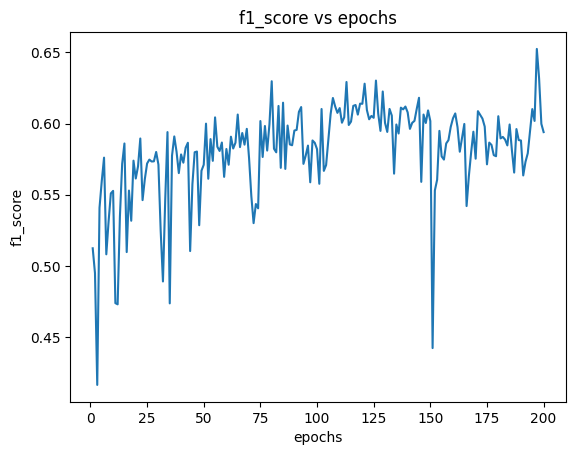

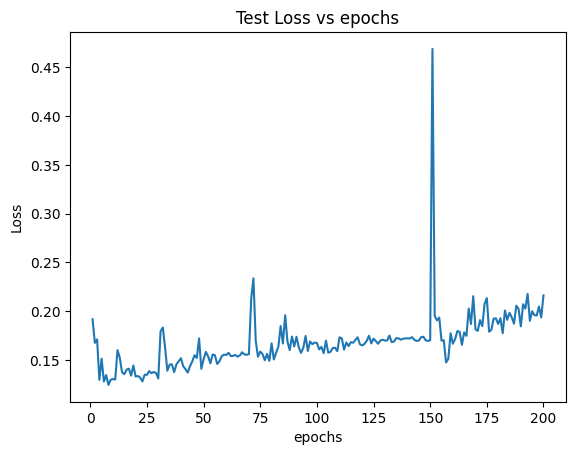

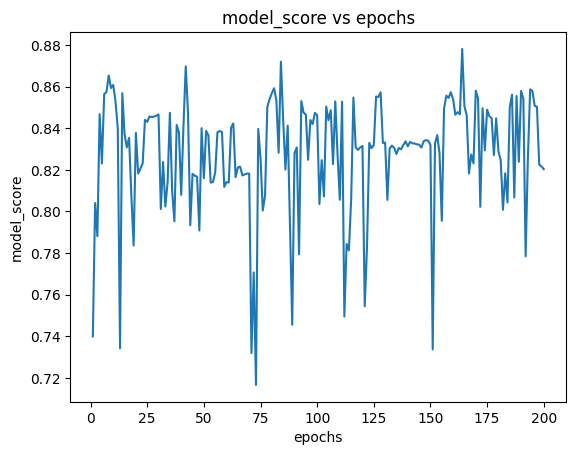

In [8]:
K = len(f1_arr)+1
plt.figure(1)
#plt.plot(sorted(list(set(roc_epochs))), f1_arr)
plt.plot(range(1,K), f1_arr)
plt.xlabel("epochs")
plt.ylabel("f1_score")
plt.title('f1_score vs epochs')

plt.figure(2)
#plt.plot(sorted(list(set(roc_epochs))), loss_arr)
plt.plot(range(1,K), loss_arr)
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title('Test Loss vs epochs')

plt.figure(3)
#plt.plot(sorted(list(set(roc_epochs))), f1_arr)
plt.plot(range(1,K), model_arr)
plt.xlabel("epochs")
plt.ylabel("model_score")
plt.title('model_score vs epochs')

print(max_ms)   

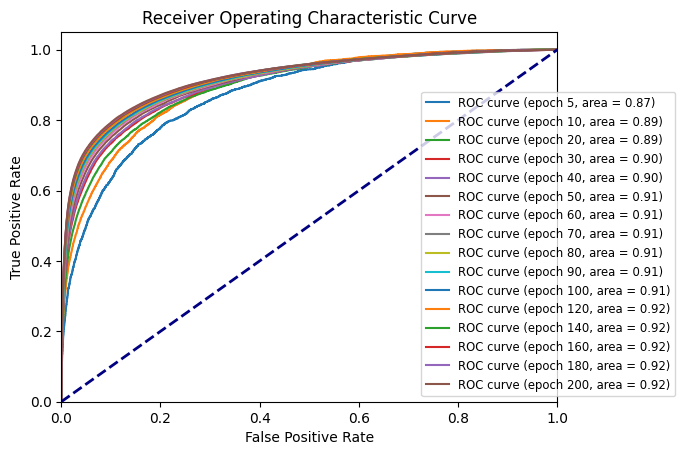

In [9]:
# plot ROC curve
fig2, ax2 = plt.subplots()
for i in range(len(roc_auc)):
    ax2.plot(roc_fpr[i], roc_tpr[i], label=f'ROC curve (epoch {roc_epochs[i]}, area = {roc_auc[i]:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver Operating Characteristic Curve')
# Set the properties for the legend
legend = ax2.legend(loc='lower right', bbox_to_anchor=(1.25, 0), fontsize='small', framealpha=0.8)

In [10]:
import IPython

IPython.Application.instance().kernel.do_shutdown(True)  # Restart kernel with True flag

{'status': 'ok', 'restart': True}

: 